### Structural error
+ test噪音

In [1]:
import jax
import jax.numpy as jnp
import jax_cfd.base as cfd
import numpy as np
import seaborn
import xarray
import functools
import copy
import pickle

from jax_cfd_test import my_equations
from jax_cfd_test import my_funcutils
from jax_cfd_test import my_forcing

from flax import linen as nn
from jax import random, numpy as jnp
from jax import grad

import optax

import time
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [2]:
jax.devices()

[cuda(id=0)]

In [3]:
def sealed_convection_diffusion_true(measure_point_coordinate, center, stage):
    grid = cfd.grids.Grid((size, size), domain=((lo_b, up_b), (lo_b, up_b)))

    bc = cfd.boundaries.neumann_boundary_conditions(2)
    
    grid_x = jnp.linspace(lo_b, up_b, size)
    grid_y = jnp.linspace(lo_b, up_b, size)
    xx, yy = jnp.meshgrid(grid_x, grid_y, indexing='ij')
    
    distance_array = 0.0*xx
    array = cfd.grids.GridArray(distance_array, offset=grid.cell_center, grid=grid)
    v0 = cfd.grids.GridVariable(array, bc)
    G=(v0,v0)

    time=0.0
    dt= 0.001
    center_x= center[0]
    center_y= center[1]
    
    i = (measure_point_coordinate[0]-lo_b)/(up_b-lo_b)*(size-1)
    j = (measure_point_coordinate[1]-lo_b)/(up_b-lo_b)*(size-1)
    
    inner_steps = 1
    outer_steps = (stage+1)*10+41#401

    # model = my_forcing.FullyConnectedNN()  # 创建模型实例 在外侧定义，只是一个结构

    #rollout_fn = jax.jit(my_funcutils.trajectory(my_equations.implicit_convection_diffusion3(
    #        density=density, viscosity=viscosity, dt=dt, grid=grid, forcing = my_forcing.exponential_force_with_nn(grid,center_x=center_x, center_y=center_y,params=param,model =model)), outer_steps*inner_steps))
  
    rollout_fn = jax.jit(my_funcutils.trajectory(my_equations.implicit_convection_diffusion3(
            density=density, viscosity=viscosity, dt=dt, grid=grid, forcing = my_forcing.exponential_force(grid,center_x=center_x, center_y=center_y)), outer_steps*inner_steps))
   
    #_, trajectory = jax.device_get(rollout_fn(G,time))
    #data_array_at_last_step = trajectory[0][0].data[-1,:,:]

    last_step, _ = jax.device_get(rollout_fn(G,time))
    data_array_at_last_step = last_step[0][0].array.data
    
    data_fin=jax.scipy.ndimage.map_coordinates(data_array_at_last_step,[i,j],1)
    
    return data_fin, data_array_at_last_step
    
def sealed_convection_diffusion_nn(param, measure_point_coordinate, center, stage, model):
    grid = cfd.grids.Grid((size, size), domain=((lo_b, up_b), (lo_b, up_b)))

    bc = cfd.boundaries.neumann_boundary_conditions(2)
    
    grid_x = jnp.linspace(lo_b, up_b, size)
    grid_y = jnp.linspace(lo_b, up_b, size)
    xx, yy = jnp.meshgrid(grid_x, grid_y, indexing='ij')
    
    distance_array = 0.0*xx
    array = cfd.grids.GridArray(distance_array, offset=grid.cell_center, grid=grid)
    v0 = cfd.grids.GridVariable(array, bc)
    G=(v0,v0)

    time=0.0
    dt= 0.001#0.0025
    center_x= center[0]
    center_y= center[1]
    
    i = (measure_point_coordinate[0]-lo_b)/(up_b-lo_b)*(size-1)
    j = (measure_point_coordinate[1]-lo_b)/(up_b-lo_b)*(size-1)
    
    inner_steps = 1
    outer_steps = (stage+1)*10+41#401

    # 原本的算例用的是5，改为3试试
    rollout_fn = jax.jit(my_funcutils.trajectory(my_equations.implicit_convection_diffusion3(
            density=density, viscosity=viscosity, dt=dt, grid=grid, forcing = my_forcing.reciprocal_force_with_nn(grid,center_x=center_x, center_y=center_y,params=param,model =model)), outer_steps*inner_steps))

    last_step, _ = rollout_fn(G,time)
    data_array_at_last_step = last_step[0][0].array.data
    
    data_fin=jax.scipy.ndimage.map_coordinates(data_array_at_last_step,[i,j],1)
    
    return data_fin, data_array_at_last_step
    
#%time jax.value_and_grad(sealed_convection_diffusion, has_aux=True)(params, (0.21,0.21),(0.203,0.21),stage=3)
#sealed_convection_diffusion_nn(params, (0.21,0.21),(0.203,0.21),3,model)

In [4]:
from flax.traverse_util import flatten_dict, unflatten_dict

def reconstruct_array_to_dict(params_grad_array, grads):
    """
    将扁平化后的数组重新构建回原始的 grads 字典。

    参数:
    - params_grad_array: 扁平化后的梯度数组
    - grads: 原始的 grads 字典，用于获取结构信息

    返回:
    - reconstructed_grads: 重建后的 grads 字典
    """
    # 获取原始 grads 的结构信息
    params_grad_flat = flatten_dict(grads)
    shapes = {k: v.shape for k, v in params_grad_flat.items()}

    # 将 params_grad_array 拆分成原始形状的数组
    index = 0
    reconstructed_params_grad_flat = {}
    for k, shape in shapes.items():
        size = size = int(np.prod(shape))  # 将形状转换为 numpy 数组，然后计算其大小
        reconstructed_params_grad_flat[k] = jnp.reshape(params_grad_array[index:index+size], shape)
        index += size

    # 将平坦化的字典恢复到原始的嵌套结构
    reconstructed_grads = unflatten_dict(reconstructed_params_grad_flat)

    return reconstructed_grads

def reconstruct_dict_to_array(grads):
    """
    将嵌套字典转换为扁平化的数组。

    参数:
    - grads: 嵌套的 grads 字典

    返回:
    - params_grad_array: 扁平化后的梯度数组
    """
    # 将字典展平
    params_grad_flat = flatten_dict(grads)
    
    # 获取所有梯度值，并将其展平
    flat_arrays = [jnp.ravel(v) for v in params_grad_flat.values()]
    
    # 将所有展平的数组拼接成一个单独的数组
    params_grad_array = jnp.concatenate(flat_arrays)
    
    return params_grad_array
    
def kl_divergence(mu1, sigma1, mu2, sigma2):
    # 计算逆矩阵和行列式
    sigma2_inv = jnp.linalg.inv(sigma2)
    #sigma1_det = jnp.linalg.det(sigma1)
    #sigma2_det = jnp.linalg.det(sigma2)
    
    # 计算各项
    term1 = jnp.trace(sigma2_inv @ sigma1)
    term2 = (mu2 - mu1).T @ sigma2_inv @ (mu2 - mu1)
    
    _, logdet_sigma1 = jnp.linalg.slogdet(sigma1)
    _, logdet_sigma2 = jnp.linalg.slogdet(sigma2)
    term3 = logdet_sigma2 - logdet_sigma1
    #term3 = jnp.log(sigma2_det / sigma1_det)
    
    # 计算最终的KL散度
    kl_div = 0.5 * (term1 + term2 - len(mu1) + term3)
    
    return kl_div

from jax import checkpoint

def predict_y_f(d_start, center, stage, model, ensemble_member_i):
    ensemble_member_i_dict = reconstruct_array_to_dict(ensemble_member_i,params)
    y_f, _ = sealed_convection_diffusion_nn(ensemble_member_i_dict, d_start, center, stage, model)
    return y_f

vmap_predict_y_f = jax.vmap(predict_y_f, in_axes=(None, None, None, None, 0))

def generate_sample(key, mean, std_dev):
    #return mean + std_dev * jax.random.normal(key, shape=mean.shape)
    return mean + std_dev * jax.random.normal(key, shape=mean.shape)
     
def EnKF_process_fixCenter(d_start, center, observation_local, ensemble_member, stage, model, noise_level_eki=1e-5, inflation_factor=1.0, step_size=0.5):
    # 进行一次EnKF更新
    
    ensemble_size_local = ensemble_member.shape[0]
    
    y_fs = vmap_predict_y_f(d_start, center, stage, model, ensemble_member)
    
    # 分批计算 y_fs
    #batch_size = ensemble_size_local // 3  # 将 ensemble_member 分为两部分（可以调整为其他比例）
    #y_fs_batches = []
    #for i in range(0, ensemble_size_local, batch_size):
    #    batch = ensemble_member[i:i + batch_size]
    #    y_fs_batch = vmap_predict_y_f(d_start, center, stage, model, batch)
    #    y_fs_batches.append(y_fs_batch)
    ## 拼接所有部分的 y_fs
    #y_fs = jnp.concatenate(y_fs_batches, axis=0)


    y_fs = y_fs.reshape((ensemble_size_local, 1))
    
    y_f_mean = jnp.mean(y_fs)
    
    #P_yy = 1/(ensemble_size_local-1)*jnp.sum((y_fs-y_f_mean)**2)+noise_level_eki
    P_yy = jnp.einsum('ij,ij->j', y_fs - y_f_mean, y_fs - y_f_mean) / (ensemble_size_local - 1)


    x_f_theta = ensemble_member.reshape(ensemble_size_local,-1)
    x_f_mean = jnp.mean(x_f_theta, axis=0).reshape(1,-1)

    x_f_deviation = x_f_theta - x_f_mean
    y_f_deviation = y_fs - y_f_mean.reshape(1,1)
    #P_xy = jnp.matmul(x_f_deviation.T, y_f_deviation) / (ensemble_size_local - 1)
    P_xy = jnp.einsum('ij,ik->jk', x_f_deviation, y_f_deviation) / (ensemble_size_local - 1)

    K = P_xy * 1.0/P_yy
    x_a = x_f_theta + step_size*jnp.matmul(K, (observation_local - y_fs).T).T
    
    x_a_mean = jnp.mean(x_a, axis=0)
    x_a = x_a_mean + inflation_factor * (x_a - x_a_mean) # 膨胀因子
    
    return x_a


def loss_function5(d_start, center, estimated_center, noise_level_eki):
    # 经过测试，1次和3次的导数是不一样的
    us = ensemble_members_array
    
    observation_local, _ = sealed_convection_diffusion_true(d_start, center, stage)
    
    # 固定所有不变参数，仅让 d_start 动态变化
    def body(i, us):
        return checkpoint(EnKF_process_fixCenter, static_argnums=(1, 2, 4, 5, 6, 7, 8))(d_start, estimated_center, observation_local, us, stage, model, noise_level_eki, inflation_factor, step_size)
    
    # 使用 fori_loop 进行循环，不保存中间结果
    us = jax.lax.fori_loop(0, 3, body, us)

    #def body(carry, _):
    #    us = carry
    #    us = EnKF_process_fixCenter(d_start, estimated_center, observation_local, us, stage, model, noise_level_eki, inflation_factor, step_size)
    #    return us, None  # carry 是 us，scan 不需要输出数据时，返回 None
    #
    #us, _ = jax.lax.scan(body, init=ensemble_members_array, xs=None, length=5)


    updated_mu = jnp.mean(us,axis=0)
    updated_sigma = jnp.cov(us, rowvar=False)
    
    #return jnp.trace(updated_sigma)
    return -kl_divergence(updated_mu, updated_sigma, initial_mu, initial_sigma)#, (updated_mu,updated_sigma)

#def loss_function5(d_start, center, estimated_center, noise_level_eki):
#    y_fs = ensemble_members_array
#    
#    observation_local, _ = sealed_convection_diffusion_true(d_start, center, stage)
#    
#    # 固定所有不变参数，仅让 d_start 动态变化
#    def body(i, y_fs):
#        return EnKF_process_fixCenter(d_start, estimated_center, observation_local, y_fs, stage, model, noise_level_eki, inflation_factor, step_size)
#    
#    # 使用 checkpoint 封装整个 fori_loop，粗粒度方式
#    y_fs = checkpoint(lambda y_fs: jax.lax.fori_loop(0, 3, body, y_fs))(y_fs)
#
#    updated_mu = jnp.mean(y_fs, axis=0)
#    updated_sigma = jnp.cov(y_fs, rowvar=False)
#    
#    return -kl_divergence(updated_mu, updated_sigma, initial_mu, initial_sigma), (updated_mu, updated_sigma)
#    
#class localFullyConnectedNN2(nn.Module):
#    @nn.compact
#    def __call__(self, x):
#        x = nn.Dense(features=4)(x)  # 输入层到隐藏层1，8个节点
#        x = nn.tanh(x)  # 激活函数
#        x = nn.Dense(features=4)(x)  # 隐藏层1到隐藏层2，4个节点
#        x = nn.tanh(x)  # 激活函数
#        x = nn.Dense(features=1)(x)  # 隐藏层2到输出层，1个节点
#        return x
#        
#model = localFullyConnectedNN2()  # 创建模型实例
#
#
#params = {'params': {'Dense_0': {'bias': jnp.array([-0.5034, -0.0280, -0.3198,  0.4847]),
#           'kernel': jnp.array([[ 4.8153,  4.1794,  8.2351,  9.6484],
#        [-2.8456,  5.2352, -8.0220, -9.1204]])},
#          'Dense_1': {'bias': jnp.array([-0.4493,  1.2653,  1.2336,  0.4221]),
#           'kernel': jnp.array([[-0.7218,  2.8800,  3.2308,  1.1351],
#        [-5.0888,  4.8622,  4.7844,  5.0217],
#        [-2.9412,  3.9048, -4.2149, -5.2085],
#        [ 4.3755, -3.2684,  4.4775,  3.3922]])},
#          'Dense_2': {'bias': jnp.array([-0.3442]),
#           'kernel': jnp.array([[-10.5900],
#        [ 10.0693],
#        [-10.0099],
#        [-10.6412]])}}
#         }
#
#key1 = random.PRNGKey(2023)
#
#size = 251  #只需要在 my_equation 里面改尺寸就可以了
#local_size = int((size-1)/5+1)
#density = 1.
#viscosity = 1
#
#lo_b = -2. #也需要在 my_equation 里面改范围
#up_b = 3.
#
#max_velocity = 2.0
#cfl_safety_factor = 0.5
#ensemble_size = 100
#std_dev = 0.3
#mean_array = reconstruct_dict_to_array(params)
#params_dimension = len(mean_array)
#key_ensemble = random.split(key1,ensemble_size)
#ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_ensemble, mean_array, std_dev)
#
#
#stage = 0
#d_start = jnp.array([0.34,0.43]) # ([0.34,0.33]) 巨大误差 ([0.44,0.33])([0.24,0.33]) 几乎没有误差 ([0.34,0.43])较小误差
#center = jnp.array([0.45,0.25])
#estimated_center = jnp.array([0.4,0.2])
#inflation_factor = 1.05
#step_size = 0.5
#noise_level_eki = 0.0002
#
#initial_mu = jnp.mean(ensemble_members_array,axis=0)
#initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
#
#
#%time jax.grad(loss_function5, has_aux=True)(d_start, center, estimated_center, noise_level_eki)

Network Settings: 

learning_rate1 =  0.003
learning_rate2 =  [0.012 0.012 0.012 0.012 0.012 0.012]
learning_rate3 =  [0.002  0.001  0.001  0.0008 0.0008 0.0008]
iteration_step_number1 =  (50, 45, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 30, 20)
iteration_step_number2 =  (10, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 100)
MAP range =  (5, 5, 5, 5, 5, 5, 5, 5, 5, 5)


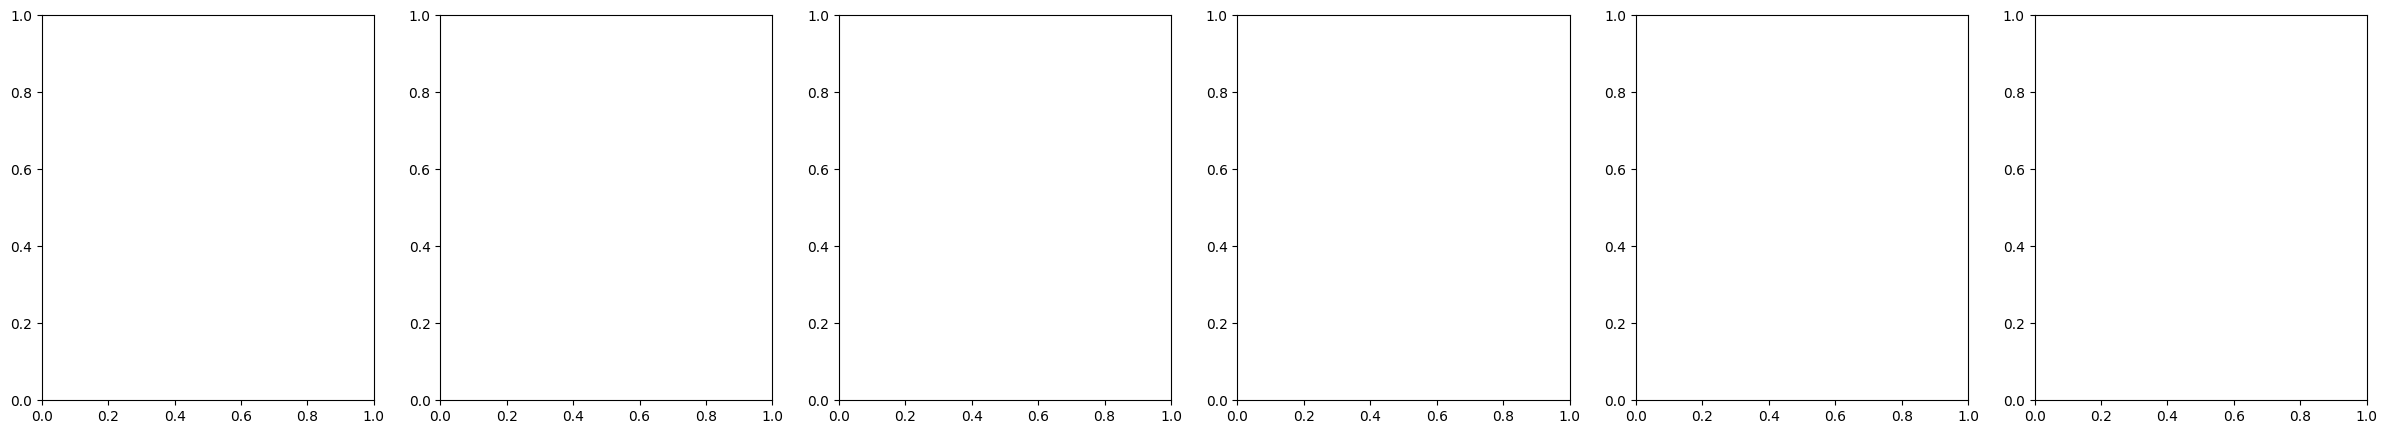

In [5]:
# 规划：
'''
1，涉及需要导数的过程都需要封装。因此 forward，likelihood，posterior，kld 都需要封装起来
2，其他的更新参数过程可以外方面
'''
def log_normalize_pdf(log_probs):
    # 计算最大对数概率值
    max_log_prob = jnp.max(log_probs)
    
    # 缩放并转换对数概率到概率空间，减少数值溢出风险
    probs = jnp.exp(log_probs - max_log_prob)
    
    # 归一化概率值
    normalized_probs = probs / jnp.sum(probs)
    
    # 转换回对数空间
    normalized_log_probs = jnp.log(normalized_probs+1e-32)
    
    return normalized_log_probs

def normalize_pdf(probs):
    return probs/jnp.sum(probs)

def calculate_loglikelihood(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, model):
    '''
    参数：
    stage: 当前的阶段。用于决定forward模拟的步数
    center: 污染源的中心
    current_params: 网络的参数
    d_start: 测量点
    prior: 先验
    noise_info: 测量误差设置
    num_d: 计算后验时使用的点数
    radio_d: 在测量点附近多选几个点测量，本质上可以理解为多次测量消除误差，可以考虑直接舍弃误差

    说明：
    1，假设数据量是300*300，计算范围是3*3
    应该是需要数据尺寸是3的倍数，否则到时候后验那里也会费劲
    也可以不是3的倍数，只要后验矩阵和数据矩阵匹配就行
    2，运用了等效的原则。主要起作用的是测量点和center的相对位置
    这里突然想到nn应该需要四个参数，当前的坐标和center，而不是仅当前坐标。
    '''
    noise_loc, noise_base_scale, noise_ratio_scale = noise_info[0]
    if num_d == 1.0:
        output_point, _ = sealed_convection_diffusion_true(d_start, center, stage) #这里的形状是()
        #key, subkey = random.split(key) 这一步放在外面
        
        #暂时只考虑不要误差的情况：
        observation = output_point + jnp.array([0.0])

        #这是要误差的代码：
        #noise = random.normal(key,(1,1))*(noise_base_scale+jnp.abs(output_point)*noise_ratio_scale) #形状(1,1)
        #observation = output_point + noise*0.05

        # 给一个函数，从所有的输出中找到关心的点
        false_center = jnp.array([1.0,1.0]) - d_start
        false_start = jnp.array([0.5, 0.5])
        _, output_all = sealed_convection_diffusion_nn(current_params, false_start, false_center, stage, model)
        output_all_central_sym = jnp.fliplr(jnp.flipud(output_all))
        # 取出[0,1]^2之间的矩阵
        xb_lo = int((0.0 - lo_b) / (up_b - lo_b) * (size - 1))
        xb_up = int((1.0 - lo_b) / (up_b - lo_b) * (size - 1))
        output_for_xb = output_all_central_sym[xb_lo:(xb_up+1),xb_lo:(xb_up+1)]
        # 针对于每一个数字求likelihood
        loglikelihood = jax.scipy.stats.norm.logpdf(observation, loc=output_for_xb, scale=noise_base_scale+noise_ratio_scale*jnp.abs(output_for_xb))
    return loglikelihood

def calculate_info_gain(prior, posterior):
    '''
    KLD
    '''
    return jnp.sum(posterior*(jnp.log(posterior+1e-32) - jnp.log(prior+1e-32)))

def forward_posterior_infoGain(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, model):
    loglikelihood = calculate_loglikelihood(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, model)
    log_evidence_list = log_normalize_pdf(loglikelihood) + jnp.log(prior+1e-32)
    evidence_list = jnp.exp(log_evidence_list)
    posterior = evidence_list/jnp.sum(evidence_list)
    KLD = calculate_info_gain(prior, posterior)
    return KLD, posterior

def compute_gradient_norm(grad_params):
    # 计算所有参数梯度的平方L2范数
    squared_norms = jax.tree_util.tree_map(lambda x: jnp.sum(x**2), grad_params)
    # 求和所有平方范数
    total_squared_norm = sum(jax.tree_util.tree_leaves(squared_norms))
    # 取平方根得到总的L2范数
    total_norm = jnp.sqrt(total_squared_norm)
    return total_norm

'''
main
'''

# 输入权重，求权重的导数

# PDE settings =================
size = 251  #只需要在 my_equation 里面改尺寸就可以了
local_size = int((size-1)/5+1)
density = 1.
viscosity = 1

lo_b = -2. #也需要在 my_equation 里面改范围
up_b = 3.

max_velocity = 2.0
cfl_safety_factor = 0.5


key = random.PRNGKey(2019)  # 随机数生成器的键
#key_new_l = jnp.array([3373630241, 3686834263], dtype=jnp.uint32)
#key_new = jnp.array([15292546, 3301520895], dtype=jnp.uint32)
x_for_shape = random.normal(key, (1, 2))  # 假设输入数据形状为 (batch_size, input_features)，这里是一个样本，两个特征
#model = my_forcing.FullyConnectedNN()  # 创建模型实例
#params = model.init(key, x_for_shape)

class localFullyConnectedNN2(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=4)(x)  # 输入层到隐藏层1，8个节点
        x = nn.tanh(x)  # 激活函数
        x = nn.Dense(features=4)(x)  # 隐藏层1到隐藏层2，4个节点
        x = nn.tanh(x)  # 激活函数
        x = nn.Dense(features=1)(x)  # 隐藏层2到输出层，1个节点
        return x
        
model = localFullyConnectedNN2()  # 创建模型实例


params = {'params': {'Dense_0': {'bias': jnp.array([-0.5034, -0.0280, -0.3198,  0.4847]),
           'kernel': jnp.array([[ 4.8153,  4.1794,  8.2351,  9.6484],
        [-2.8456,  5.2352, -8.0220, -9.1204]])},
          'Dense_1': {'bias': jnp.array([-0.4493,  1.2653,  1.2336,  0.4221]),
           'kernel': jnp.array([[-0.7218,  2.8800,  3.2308,  1.1351],
        [-5.0888,  4.8622,  4.7844,  5.0217],
        [-2.9412,  3.9048, -4.2149, -5.2085],
        [ 4.3755, -3.2684,  4.4775,  3.3922]])},
          'Dense_2': {'bias': jnp.array([-0.3442]),
           'kernel': jnp.array([[-10.5900],
        [ 10.0693],
        [-10.0099],
        [-10.6412]])}}
         }

params_shape = {'params': {'Dense_0': {'bias': jnp.array([0, 0, 0, 0]),
           'kernel': jnp.array([[0, 0, 0, 0],
        [0, 0, 0, 0]])},
          'Dense_1': {'bias': jnp.array([0, 0, 0, 0]),
           'kernel': jnp.array([[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]])},
          'Dense_2': {'bias': jnp.array([0]),
           'kernel': jnp.array([[0],
        [0],
        [0],
        [0]])}}
         }


# OED settings =================
n_stage = 6
d_start = jnp.array([0.5,0.5])
center = jnp.array([0.25,0.25])#jnp.array([0.25,0.45])#

d_change_range = jnp.array([0.2,0.2])
d_change_range_MEC = jnp.array([0.35,0.35])

noise_loc = 0
noise_base_scale = 0.05
noise_ratio_scale = 0.05
noise_info = [(noise_loc, noise_base_scale, noise_ratio_scale),]

num_d = 1.0
radio_d = 0.5

xb_size = int((size - 1)/5+1) #初始化均匀先验
prior_ori = jnp.ones((xb_size,xb_size))
prior = prior_ori/jnp.sum(prior_ori)

key = random.split(key,int(n_stage*2+1))

    
def loss_param_refine5(current_params, d_start, stage, estimated_center, model, observation):

    y_f, _ = sealed_convection_diffusion_nn(current_params, d_start, estimated_center, stage, model)
    loglikelihood = jax.scipy.stats.norm.logpdf(observation, loc=y_f, scale=noise_base_scale+noise_ratio_scale* jnp.abs(y_f))

    return -loglikelihood


def loss_param_refine6(current_params, design_MEC_array, stage_count_array, estimated_center, observation_MEC_array):
    def single_stage_loglikelihood(design_MEC, observation_MEC, stage_MEC):
        stage_MEC = int(stage_MEC)  # 确保是具体值
        y_f, _ = sealed_convection_diffusion_nn(current_params, design_MEC, estimated_center, stage_MEC, model)
        return jax.scipy.stats.norm.logpdf(
            observation_MEC, loc=y_f, scale=noise_base_scale + noise_ratio_scale * jnp.abs(y_f)
        )

    # 显式计算所有 loglikelihood
    loglikelihoods = [
        single_stage_loglikelihood(design_MEC, observation_MEC, stage_MEC)
        for design_MEC, observation_MEC, stage_MEC in zip(design_MEC_array, observation_MEC_array, stage_count_array)
    ]

    # 汇总所有 loglikelihood
    return -jnp.sum(jnp.array(loglikelihoods))
    

#stage = 5
#design_MEC_array = jnp.array(design_list[2:])
#estimated_center = jnp.array([0.22,0.24])
#observation_MEC_array = jnp.array([0.3,0.4,0.5,0.3,0.35])
#stage_count_array = np.arange(1,stage+1)
#%time jax.value_and_grad(loss_param_refine6)(params, design_MEC_array, stage_count_array, estimated_center, observation_MEC_array)

def loss_design(d_start, current_params, stage, center, prior, noise_info, num_d, radio_d, key, model):
    KLD, _ = forward_posterior_infoGain(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, model)
    return -KLD

def evaluate_nn_accuracy(params,model,center,local_size):
    grid = cfd.grids.Grid((local_size, local_size), domain=((0, 1), (0, 1)))
    offsets = ((0.5,0.5),(0.5,0.5))
    x = grid.mesh(offsets[1])[0]
    y = grid.mesh(offsets[0])[1]
    center_x = center[0]
    center_y = center[1]
    exponent_internal = ((x-center_x)**2.0+(y-center_y)**2.0)
    factor = 2.0 / (2.0 * jnp.pi * 0.05 **2)
    array_exponent = factor * jnp.exp(-exponent_internal / (2.0 * 0.05 **2.0))
    array_reciprocal = factor*1.5 / (exponent_internal**2 / (2.0 * 0.05 **2.0)**2+ 1.0)
    x_reshaped = x.reshape(-1, 1) - center_x
    y_reshaped = y.reshape(-1, 1) - center_y
    xy_combined = jnp.concatenate((x_reshaped, y_reshaped), axis=1)
    array_nn = model.apply(params,xy_combined).reshape(grid.shape)
    return jnp.sum((array_exponent - array_reciprocal - array_nn)**2)


#iteration_step_number1 = tuple((50,40,30,20,20,20,20,20,20,20))
iteration_step_number1 = tuple((50,45,40,40,40,40,40,40,40,40,40,40,40,30,20))
#iteration_step_number2 = tuple((10,50,50,50,50,50,50,50,100,100))
iteration_step_number2 = tuple((10,80,80,80,80,80,80,80,80,80,80,80,80,80,100))
iteration_net_design = tuple((70,30,30,30,30,30,30))#((70,21,20,20,18,17,17))#((70,70,70,70,70,70,70))#
num_top_array = tuple((5,5,5,5,5,5,5,5,5,5))#((1,1,1,1,1,1,1,1,1,1))#

stage_to_skip = [0]

fig, axes = plt.subplots(1, n_stage, figsize=(5*n_stage, 5))
grid_x_plot0, grid_y_plot0 = np.meshgrid(np.linspace(0, 1, local_size), np.linspace(0, 1, local_size))

learning_rate1 = 0.003
learning_rate2 = jnp.ones(n_stage)*0.012
learning_rate3 = jnp.array([0.002,0.0010,0.0010,0.0008,0.0008,0.0008])#([0.002,0.0010,0.0010,0.0010,0.0010,0.0010])#([0.002,0.002,0.002,0.0018,0.0015,0.0009])

print('Network Settings: \n')
print(f'learning_rate1 = ', learning_rate1)
print(f'learning_rate2 = ', learning_rate2)
print(f'learning_rate3 = ', learning_rate3)
print(f'iteration_step_number1 = ', iteration_step_number1)
print(f'iteration_step_number2 = ', iteration_step_number2)
print(f'MAP range = ', num_top_array)


def log_transform_prior(prior_matrix, epsilon=1e-6, alpha=0.5):
    """
    Apply a log transformation to a prior weight matrix to reduce high weights and amplify low weights,
    while preserving some of the original weight relationships.

    Args:
        prior_matrix (jax.numpy.ndarray): A 2D matrix representing prior weights.
        epsilon (float): A small value to ensure numerical stability for log computation.
        alpha (float): A mixing parameter (0 < alpha <= 1) to control the balance between original and transformed weights.

    Returns:
        jax.numpy.ndarray: A 2D matrix of transformed weights, normalized to sum to 1.
    """
    # Ensure all weights are positive by adding epsilon
    adjusted_prior = prior_matrix + epsilon

    # Apply the log transformation
    log_transformed = -jnp.log(adjusted_prior)

    # Normalize the log-transformed weights
    log_transformed_normalized = log_transformed / jnp.sum(log_transformed)

    # Normalize the original weights
    original_normalized = adjusted_prior / jnp.sum(adjusted_prior)

    # Combine the original and log-transformed weights
    mixed_weights = alpha * log_transformed_normalized + (1 - alpha) * original_normalized

    # Normalize the mixed weights to sum to 1
    final_weights = mixed_weights / jnp.sum(mixed_weights)

    return final_weights
    
decay_rate1 = 1.0
decay_rate2 = 0.9  # 衰减率

inflation_factor = 1.0
step_size = 0.5

KLD_list=[]
evidence_list=[]
NN_error_list=[]
gradient_norm_list=[]
params_list=[]
#params_list.append(params) #这里不需要，因为第一阶段不学习，在后面加上了
design_list = []
design_list.append(d_start)
posterior_list = []
posterior_oed_list = []
estimated_posterior_point = []
ensemble_mean_trajectory_list = []
ensemble_cov_trajectory_list = []
design_MEC_trajectory = []
KLD_MEC_list = []
actual_step = []
design_MEC_list = []
observation_MEC_list = []

In [ ]:
for stage in range(n_stage):
    
    #if stage == 5:
    #    break #提前结束
        
    print('\n stage = ', stage, '\n')
    key_for_design = random.split(key[stage*2],iteration_step_number1[stage])
    key_for_param = random.split(key[stage*2+1],(iteration_step_number2[stage]+1))
    
    #if stage != 0:
    #    d_start = design_list[stage]
    #    params = params_list[-1]
    #    prior = posterior_list[-1]
    
    clip_count = 0
    
    if stage!=0:
        try:
            del tx1
            del opt_state1
        except NameError:
            pass
    else:
        print(f'stage = 0, only run forward model and update posterior')
        
    tx1 = optax.chain(
    optax.adam(learning_rate1),  # 使用由 lr_schedule1 调整的学习率的 Adam 优化器
    optax.add_decayed_weights(1e-4)  # 添加权重衰减，衰减系数为 1e-5
    )
    
    opt_state1 = tx1.init(d_start)
    
    d_limit_min = d_start - d_change_range
    d_limit_max = d_start + d_change_range
    
    start_time = time.time()
    d_start_backup = d_start

    print('start learning design')
    print(f'start design : ', d_start)

    ## 平滑先验
    #if stage != 0:
    #    prior = log_transform_prior(prior, epsilon=1e-6, alpha=0.9)

    
    for i in range(iteration_step_number1[stage]):
        negtive_KLD, grad_design = jax.value_and_grad(loss_design)(d_start, params, stage, center, prior, noise_info, num_d, radio_d, key_for_design[i], model)
        #if stage in []:
        #    negtive_KLD, grad_design = jax.value_and_grad(loss_design)(d_start, params, stage, center, prior, noise_info, num_d, radio_d, key_for_design[i], model)
        #else:
        #    #negtive_KLD, grad_design = jax.value_and_grad(loss_design_trueOED)(d_start, params, stage, center, prior, noise_info, num_d, radio_d, key_for_design[i], model, multi_indices)
        #    negtive_KLD, grad_design = jax.value_and_grad(loss_design_trueOED_modified4)(d_start)
        
        
        
        
        updates, opt_state1 = tx1.update(grad_design, opt_state1, params=d_start)

        
        # 解决nan的问题
        oed_nan_index = 0
        updates_contain_nans = any(jnp.any(jnp.isnan(u)) for u in jax.tree_util.tree_leaves(updates))
        if updates_contain_nans:
            oed_nan_index = oed_nan_index + 1
            print(f'NaN appears in learning. Perturb params and continue. Nan count: {oed_nan_index}')
            noise = 0.05*jax.random.normal(key_for_design[i], d_start.shape)
            d_start = d_start+ noise
        else:
            oed_nan_index = 0
            d_start = optax.apply_updates(d_start, updates)
    
        d_start_before_clip = d_start
        d_start = jnp.clip(d_start, d_limit_min, d_limit_max)
        
        # 如果clip函数生效，即有参数被裁剪，增加计数器
        clip_count = 0
        if not jnp.all(d_start == d_start_before_clip):
            clip_count += 1
        else:
            clip_count = 0
            
        if clip_count >= 5:
            print(f"Stopping iteration at step {i} as clip function has been activated 5 times.")
            break
        
        if np.isnan(d_start).any() or np.isnan(negtive_KLD).any():
            print('some results are Nan')
            break
    
        KLD_list.append(-negtive_KLD)
        
        if oed_nan_index > 6:
            print('连续出现nam并扰动6次，停止oed')
            break
            
            
    end_time = time.time()
    print(f"Execution learning design time: {end_time - start_time} seconds")
    print('Current design = ', d_start)

    #if stage!=0:
    _, posterior = forward_posterior_infoGain(params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], model)
    del prior # 如果决定oed后不更新后验，则注释这一句
    prior = posterior # 如果决定oed后不更新后验，则注释这一句
    posterior_oed_list.append(posterior)

    net_accuracy = evaluate_nn_accuracy(params,model,center,local_size)
    NN_error_list.append(net_accuracy)
    design_list.append(d_start)
    

    

    # 模块：MAP估计中心
    ## 方法1
    #num_top = num_top_array[stage]
    #indices = jnp.argpartition(posterior.ravel(), -num_top)[-num_top:]
    #multi_indices = jnp.unravel_index(indices, posterior.shape)
    #
    #average_x = np.mean(multi_indices[0])
    #average_y = np.mean(multi_indices[1])
    #
    #estimated_center = jnp.array([average_x, average_y])/50
    #print(f'estimated_center is ', estimated_center)
    #estimated_posterior_point.append(estimated_center)

    # 方法2
    num_top = num_top_array[stage]
    indices = jnp.argpartition(posterior.ravel(), -num_top)[-num_top:]
    multi_indices = jnp.unravel_index(indices, posterior.shape)
    
    average_x = int(jnp.mean(multi_indices[0]))
    average_y = int(jnp.mean(multi_indices[1]))
    
    # 定义 5x5 的范围
    x_range = jnp.arange(max(0, average_x - 2), min(posterior.shape[0], average_x + 3))
    y_range = jnp.arange(max(0, average_y - 2), min(posterior.shape[1], average_y + 3))
    
    # 获取5x5的网格点
    x_grid, y_grid = jnp.meshgrid(x_range, y_range, indexing='ij')
    x_grid_flat = x_grid.ravel()
    y_grid_flat = y_grid.ravel()
    
    # 提取对应的 posterior 值
    grid_points = jnp.stack((x_grid_flat, y_grid_flat), axis=-1)
    grid_values = posterior[x_grid_flat, y_grid_flat]
    
    # 插值：创建细化的网格以提升精度
    fine_x = jnp.linspace(x_range.min(), x_range.max(), 50)
    fine_y = jnp.linspace(y_range.min(), y_range.max(), 50)
    fine_x_grid, fine_y_grid = jnp.meshgrid(fine_x, fine_y, indexing='ij')
    fine_points = jnp.stack((fine_x_grid.ravel(), fine_y_grid.ravel()), axis=-1)
    
    interpolated_values = griddata(grid_points, grid_values, fine_points, method='cubic')
    interpolated_values = interpolated_values.reshape(fine_x_grid.shape)
    
    # 找到插值后最大值的坐标
    max_index = jnp.unravel_index(jnp.argmax(interpolated_values), interpolated_values.shape)
    max_x, max_y = fine_x_grid[max_index], fine_y_grid[max_index]
    
    # 输出新的估计中心
    estimated_center = jnp.array([max_x, max_y]) / 50
    print(f'estimated_center is ', estimated_center)
    estimated_posterior_point.append(estimated_center)



    # 模块：判断是否执行model correction
    if stage in stage_to_skip:
        posterior_list.append(posterior)
        params_list.append(params)
        actual_step.append(0)
        #del prior # 如果决定oed后不更新后验，则不要注释这一句
        #prior = posterior # 如果决定oed后不更新后验，则不要注释这一句
        continue


    
    # 模块：找到一个目标model correction的design

    start_time = time.time()
    print(f'design from OED is {d_start}')
    ensemble_size = 40
    sample_size = 40

    std_dev = 0.3
    mean_array = reconstruct_dict_to_array(params)
    params_dimension = len(mean_array)



    observation, _ = sealed_convection_diffusion_true(d_start, center, stage)
    d_start_MEC = d_start 
    print(f'start design : ', d_start_MEC)
    print('observation of start design = ', observation)
    #print('initial ensemble var = ', jnp.trace(initial_sigma))

    # 设置优化器
    try:
        del tx2
        del opt_state2
    except NameError:
        pass
    
    tx2 = optax.chain(
        optax.adam(0.024),#learning_rate2[stage]),  # 使用由 lr_schedule1 调整的学习率的 Adam 优化器
        #optax.add_decayed_weights(1e-4)  # 添加权重衰减，衰减系数为 1e-5
    )
    
    opt_state2 = tx2.init(d_start_MEC)
    
    d_limit_min = d_start_MEC - d_change_range_MEC
    d_limit_max = d_start_MEC + d_change_range_MEC

    print('start learning design')

    clip_count = 0
    
    noise_level_eki = 2e-4#5e-5
    key_ensemble_pass = key_for_param[-1]
    
    for i in range(iteration_net_design[stage]):
        
        key_ensemble_pass, key_ensemble_pass_sub = random.split(key_ensemble_pass)
        key_ensemble = random.split(key_ensemble_pass_sub,ensemble_size)
        ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_ensemble, mean_array, std_dev)
        
        initial_mu = jnp.mean(ensemble_members_array,axis=0)
        initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)

        
        #key_sample = random.split(key_ensemble_pass,sample_size)
        #sample_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_sample, mean_array, 0.5)
        #
        ## 生成预测的y和y关于d的导数
        #(y_predicted, y_p_d_grad) = grad_y_sample_d_all(d_start_MEC, sample_members_array)
        #
        #likelihood_matrix = calculate_likelihood_matrix(y_predicted, 0.05)
        #
        #weights = jnp.sum(likelihood_matrix, axis=0)
        #normalized_weights = weights / jnp.sum(weights)
        #
        #
        ## 对于每一个y，计算dkld/dd
        #grad_design = jnp.zeros(2)
        #
        #for sample_num in range(sample_size):
        #    (dkld_dd, dkld_dy) = jax.grad(loss_function6, argnums=(0,1))(d_start_MEC, y_predicted[sample_num], center, estimated_center, noise_level_eki)
        #    grad_design += (dkld_dd + dkld_dy * y_p_d_grad[sample_num]) * normalized_weights[sample_num]
        #    print('-',end='')
            
    
        #negtive_KLD, grad_design = jax.value_and_grad(loss_test2)(d_start_MEC, params, center, estimated_center, 0.0002) # 预测
        negtive_KLD, grad_design = jax.value_and_grad(loss_function5)(d_start_MEC, center, estimated_center, 0.0002) # 实际
        updates, opt_state2 = tx2.update(grad_design, opt_state2, params=d_start_MEC)
        
        d_start_MEC = optax.apply_updates(d_start_MEC, updates)
    

        d_start_before_clip = d_start_MEC
        d_start_MEC = jnp.clip(d_start_MEC, d_limit_min, d_limit_max)
        design_MEC_trajectory.append(d_start_MEC)
        
        # 如果clip函数生效，即有参数被裁剪，增加计数器
        if not jnp.all(d_start_MEC == d_start_before_clip):
            clip_count += 1
        
        if clip_count >= 5:
            print(f"Stopping iteration at step {i} as clip function has been activated 5 times.")
            actual_step.append(i+1)
            break
            
        if isinstance(negtive_KLD, (list, tuple)):
            KLD_MEC_list.append(-negtive_KLD[0])  # 如果是列表或元组，取第一个元素
        else:
            KLD_MEC_list.append(-negtive_KLD)     # 如果是标量，直接使用

        if i == (iteration_net_design[stage]-1):
            actual_step.append(i+1)

        print('.',end='')

    print('\n')
    print('updated design : ', d_start_MEC)

    # 用新的design重新测量
    
    observation, _ = sealed_convection_diffusion_true(d_start_MEC, center, stage)
    print('observation of updated design = ', observation)
    design_MEC_list.append(d_start_MEC)
    observation_MEC_list.append(observation)
    
    try:
        del tx2
        del opt_state2
    except NameError:
        pass
    
    
    print(f'design for model correction is {d_start_MEC}')
    end_time = time.time()
    print(f"Execution finding design for model correction time: {end_time - start_time} seconds")


    
    ## 进行model correction
    #start_time = time.time()
    #
    #eki_iterations = 30
    #print(f'Start updating posterior with a {eki_iterations} iterations EKI')
    #mean = np.zeros((eki_iterations+1,params_dimension))
    #var = np.zeros((eki_iterations+1,params_dimension,params_dimension))
    #mean[0]=jnp.mean(ensemble_members_array, axis=0)
    #var[0]=jnp.cov(ensemble_members_array, rowvar=False)
    #
    #
    ##key_ensemble = random.split(key[stage],eki_iterations)
    #
    #
    #
    #
    #noise_level_eki = 2e-4
    #print('noise level for eki = ', noise_level_eki)
    #
    ## === 重新设置了ensemble，使用更大的member size。
    #ensemble_size = 100
    #
    #std_dev = 0.3
    #mean_array = reconstruct_dict_to_array(params)
    #params_dimension = len(mean_array)
    #key_ensemble = random.split(key_for_param[-1],ensemble_size)
    #ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_ensemble, mean_array, std_dev)
    #ensemble_params_posterior = ensemble_members_array
    ## ===
    #
    #
    ## 执行30步EKI，看结果
    #for i in range(eki_iterations):
    #    ensemble_params_posterior = EnKF_process_fixCenter(d_start_MEC, estimated_center, observation, ensemble_params_posterior, stage, model, noise_level_eki, 1.0, 0.5)#step_size)
    #    #ensemble_params_posterior = EnKF_process_fixCenter_perturbed(d_start_MEC, estimated_center, observation, ensemble_params_posterior, stage, key_ensemble[i], noise_level_eki, 1e-3, inflation_factor, 0.7)
    #    mean[i+1]=jnp.mean(ensemble_params_posterior, axis=0)
    #    var[i+1]=jnp.cov(ensemble_params_posterior, rowvar=False)
    #    print('.',end='')
    #
    #print('\n')
    #end_time = time.time()
    #print(f"Execution EKI for posterior time: {end_time - start_time} seconds")
    #print(f'inflation_factor = {inflation_factor}, step_size = {step_size}, result mean = {mean[-1]}, result var = {jnp.trace(var[-1])}')
    #
    #params = reconstruct_array_to_dict(mean[-1], params)
    #ensemble_mean_trajectory_list.append(mean)
    #ensemble_cov_trajectory_list.append(var)

    
    # 使用梯度下降法进行model correction
    start_time = time.time()
    try:
        del tx3
        del opt_state3
    except NameError:
        pass
        
    tx3 = optax.adam(learning_rate3[stage])#0.002)#learning_rate2[stage])
    
    opt_state3 = tx3.init(params)
    observation, _ = sealed_convection_diffusion_true(d_start_MEC, center, stage)
    print(f'measurement is: {observation}')
    design_MEC_array = jnp.array(design_MEC_list)
    observation_MEC_array = jnp.array(observation_MEC_list)
    stage_count_array = jnp.arange(1,stage+1)

    print('start learning params')
    for i in range(iteration_step_number2[stage]):
        if stage in stage_to_skip:
            print(f'stage {stage} dont learn error parameters')
            break
        
        #observation_perturbed =  observation + 0.003 * jax.random.normal(key_for_param[i], observation.shape) * (80-i)/80
        estimated_center_perturbed = estimated_center + 0.05 * jax.random.normal(key_for_param[i], estimated_center.shape)*jnp.exp(-0.04*i)#* (80-i)/80
        #max_evidence_items, grad_params = jax.value_and_grad(loss_param_refine5)(params, d_start_MEC, stage, estimated_center_perturbed, model, observation)
        max_evidence_items, grad_params = jax.value_and_grad(loss_param_refine6)(params, design_MEC_array, stage_count_array, estimated_center_perturbed, observation_MEC_array)
    
        clip_norm = 1e10
        clip_transform = optax.clip_by_global_norm(clip_norm)
        clipped_grads, _ = clip_transform.update(grad_params, state=None)
        
        updates, opt_state3 = tx3.update(clipped_grads, opt_state3, params=params)
        
        # 解决nan的问题
        updates_contain_nans = any(jnp.any(jnp.isnan(u)) for u in jax.tree_util.tree_leaves(updates))
        if updates_contain_nans:
            print('NaN appears in learning. Perturb params and continue.')
            noise = jax.tree_util.tree_map(lambda p: 0.01 * jax.random.normal(key_for_param[i], p.shape), params)
            params = jax.tree_util.tree_map(lambda p, n: p + n, params, noise)
        else:
            params = optax.apply_updates(params, updates)
            
        net_accuracy = evaluate_nn_accuracy(params,model,center,local_size)
        
        if np.isnan((max_evidence_items, net_accuracy)).any():
            print('some results are Nan')
            break
            
        evidence_list.append(-max_evidence_items)
        NN_error_list.append(net_accuracy)
        print('.',end='')

        
    params_list.append(params)
    
    end_time = time.time()
    print(f"Execution learning param time: {end_time - start_time} seconds")

    #if stage not in stage_to_skip:
    #    _, posterior = forward_posterior_infoGain(params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], model)
    #    if stage!=0:
    #         del prior
    #    prior = posterior
    
    if stage > 0:
        prior =  prior_ori/jnp.sum(prior_ori)
        for jjj in range(len(design_list)-1):
            _, posterior = forward_posterior_infoGain(params, design_list[jjj+1], jjj, center, prior, noise_info, num_d, radio_d, key[stage], model)
            del prior
            prior = posterior
        
    posterior_list.append(posterior)


        
    
    #axes[stage].contourf(grid_x_plot0, grid_y_plot0, posterior.T, levels=100,cmap='RdYlBu_r' )
    #axes[stage].scatter(d_start[0], d_start[1], marker='o', s=100, c='orangered')
    #axes[stage].scatter(center[0], center[1], marker='*', s=100, c='magenta')
    #axes[stage].plot([d_start[0],d_start_backup[0]],
    #                [d_start[1],d_start_backup[1]], c='orangered')
    #axes[stage].set_title(f'stage {stage}, t = {((stage+1)*0.05):.2f} s')  # 设置子图的标题
    #axes[stage].set_xlabel('z_x')  # 设置x轴标签
    #axes[stage].set_ylabel('z_y')  # 设置y轴标签



#plt.tight_layout()  # 调整子图间距
#plt.savefig('myplot1.png')
#plt.show()

In [26]:
y_fs.shape, key_ensemble.shape

((40, 1), (40, 2))

In [31]:
K.shape, ((0.5 - y_fs).T).shape

((37, 37), (1, 40))

In [32]:
(jnp.einsum('ij,ij->j', y_fs - y_f_mean, y_fs - y_f_mean) / (ensemble_size_local - 1)).shape

(1,)

# 测试加入扰动

In [47]:
def EnKF_process_fixCenter(d_start, center, observation_local, ensemble_member, stage, model, key_ensemble, noise_level_eki=1e-5, inflation_factor=1.0, step_size=0.5):
    # 进行一次EnKF更新
    
    ensemble_size_local = ensemble_member.shape[0]
    parameter_dimension = ensemble_member.shape[1]
    
    y_fs = vmap_predict_y_f(d_start, center, stage, model, ensemble_member)


    y_fs = y_fs.reshape((ensemble_size_local, 1))
    y_fs = y_fs + jax.random.normal(key_ensemble, y_fs.shape) * noise_level_eki
    
    y_f_mean = jnp.mean(y_fs)
    
    P_yy = jnp.einsum('ij,ij->j', y_fs - y_f_mean, y_fs - y_f_mean) / (ensemble_size_local - 1) + noise_level_eki**2


    x_f_theta = ensemble_member.reshape(ensemble_size_local,-1)
    x_f_mean = jnp.mean(x_f_theta, axis=0).reshape(1,-1)

    x_f_deviation = x_f_theta - x_f_mean
    y_f_deviation = y_fs - y_f_mean.reshape(1,1)
    
    P_xy = jnp.einsum('ij,ik->jk', x_f_deviation, y_f_deviation) / (ensemble_size_local - 1)

    K = P_xy * 1.0/P_yy
    x_a = x_f_theta + step_size*jnp.matmul(K, (observation_local - y_fs).T).T
    
    x_a_mean = jnp.mean(x_a, axis=0)
    x_a = x_a_mean + inflation_factor * (x_a - x_a_mean) # 膨胀因子
    
    return x_a


def loss_function_stability(d_start, center, estimated_center, noise_level_eki, error_additional=0.0):
    # 经过测试，1次和3次的导数是不一样的
    us = ensemble_members_array
    
    observation_local = sealed_convection_diffusion_true(d_start, center, stage)[0] + error_additional
    
    # 固定所有不变参数，仅让 d_start 动态变化
    def body(i, us):
        return checkpoint(EnKF_process_fixCenter, static_argnums=(1, 2, 4, 5, 7, 8, 9))(d_start, estimated_center, observation_local, us, stage, model, key_for_param[i+5], noise_level_eki, inflation_factor, step_size)
    
    # 使用 fori_loop 进行循环，不保存中间结果
    us = jax.lax.fori_loop(0, 3, body, us)



    updated_mu = jnp.mean(us,axis=0)
    updated_sigma = jnp.cov(us, rowvar=False)
    
    return -kl_divergence(updated_mu, updated_sigma, initial_mu, initial_sigma)#, (updated_mu,updated_sigma)

In [48]:
inflation_factor = step_size= 1.0
ensemble_size, noise_level_eki, inflation_factor, step_size

(40, 0.0002, 1.0, 1.0)

In [59]:
estimated_center = jnp.array([0.22, 0.26])
center, estimated_center

(Array([0.25, 0.25], dtype=float32), Array([0.22, 0.26], dtype=float32))

In [67]:
additional_noise = 1e-4
grad_clean = jax.grad(loss_function_stability)(d_start, center, estimated_center, 0.05)
grad_perturb = jax.grad(loss_function_stability)(d_start, center, estimated_center, 0.05, additional_noise)
print(f'additional_noise {additional_noise}, grad error {(grad_clean - grad_perturb) / grad_clean}')

additional_noise 0.0001, grad error [0.00011515 0.00070501]


In [64]:
additional_noise = 1e-5
grad_clean = jax.grad(loss_function_stability)(d_start, center, estimated_center, 0.05)
grad_perturb = jax.grad(loss_function_stability)(d_start, center, estimated_center, 0.05, additional_noise)
print(f'additional_noise {additional_noise}, grad error {(grad_clean - grad_perturb) / grad_clean}')

additional_noise 1e-05, grad error [-1.550459e-05  7.285531e-05]


In [65]:
additional_noise = 1e-6
grad_clean = jax.grad(loss_function_stability)(d_start, center, estimated_center, 0.05)
grad_perturb = jax.grad(loss_function_stability)(d_start, center, estimated_center, 0.05, additional_noise)
print(f'additional_noise {additional_noise}, grad error {(grad_clean - grad_perturb) / grad_clean}')

additional_noise 1e-06, grad error [-4.9377672e-06  8.5125675e-06]


In [66]:
additional_noise = 1e-7
grad_clean = jax.grad(loss_function_stability)(d_start, center, estimated_center, 0.05)
grad_perturb = jax.grad(loss_function_stability)(d_start, center, estimated_center, 0.05, additional_noise)
print(f'additional_noise {additional_noise}, grad error {(grad_clean - grad_perturb) / grad_clean}')

additional_noise 1e-07, grad error [4.8390120e-06 3.3743513e-06]


In [70]:
def EnKF_process_fixCenter2(d_start, center, observation_local, ensemble_member, stage, model, key_ensemble, error_additional, noise_level_eki=1e-5, inflation_factor=1.0, step_size=0.5):
    # 进行一次EnKF更新
    
    ensemble_size_local = ensemble_member.shape[0]
    parameter_dimension = ensemble_member.shape[1]
    
    y_fs = vmap_predict_y_f(d_start, center, stage, model, ensemble_member)


    y_fs = y_fs.reshape((ensemble_size_local, 1))
    y_fs = y_fs + jax.random.normal(key_ensemble, y_fs.shape) * noise_level_eki
    
    y_f_mean = jnp.mean(y_fs)
    
    P_yy = jnp.einsum('ij,ij->j', y_fs - y_f_mean, y_fs - y_f_mean) / (ensemble_size_local - 1) + noise_level_eki**2


    x_f_theta = ensemble_member.reshape(ensemble_size_local,-1)
    x_f_mean = jnp.mean(x_f_theta, axis=0).reshape(1,-1)

    x_f_deviation = x_f_theta - x_f_mean
    y_f_deviation = y_fs - y_f_mean.reshape(1,1)
    
    P_xy = jnp.einsum('ij,ik->jk', x_f_deviation, y_f_deviation) / (ensemble_size_local - 1)

    key1, key2 = random.split(key_ensemble)
    
    P_yy_pert = P_yy * (1 + jax.random.normal(key1, P_yy.shape)*error_additional)
    P_xy_pert = P_xy * (1 + jax.random.normal(key2, P_xy.shape)*error_additional)
    K = P_xy_pert * 1.0/P_yy_pert
    x_a = x_f_theta + step_size*jnp.matmul(K, (observation_local - y_fs).T).T
    
    x_a_mean = jnp.mean(x_a, axis=0)
    x_a = x_a_mean + inflation_factor * (x_a - x_a_mean) # 膨胀因子
    
    return x_a


def loss_function_stability2(d_start, center, estimated_center, noise_level_eki, error_additional=0.0):
    # 经过测试，1次和3次的导数是不一样的
    us = ensemble_members_array
    
    observation_local = sealed_convection_diffusion_true(d_start, center, stage)[0] 
    
    # 固定所有不变参数，仅让 d_start 动态变化
    def body(i, us):
        return checkpoint(EnKF_process_fixCenter2, static_argnums=(1, 2, 4, 5, 7, 8, 9, 10))(d_start, estimated_center, observation_local, us, stage, model, key_for_param[i+5], error_additional, noise_level_eki, inflation_factor, step_size)
    
    # 使用 fori_loop 进行循环，不保存中间结果
    us = jax.lax.fori_loop(0, 3, body, us)



    updated_mu = jnp.mean(us,axis=0)
    updated_sigma = jnp.cov(us, rowvar=False)
    
    return -kl_divergence(updated_mu, updated_sigma, initial_mu, initial_sigma)#, (updated_mu,updated_sigma)

In [72]:
additional_noise = 1e-4
grad_clean = jax.grad(loss_function_stability2)(d_start, center, estimated_center, 0.05)
grad_perturb = jax.grad(loss_function_stability2)(d_start, center, estimated_center, 0.05, additional_noise)
print(f'additional_noise {additional_noise}, grad error {(grad_clean - grad_perturb) / grad_clean}')

additional_noise 0.0001, grad error [-0.00022062 -0.00033467]


In [73]:
additional_noise = 1e-5
grad_clean = jax.grad(loss_function_stability2)(d_start, center, estimated_center, 0.05)
grad_perturb = jax.grad(loss_function_stability2)(d_start, center, estimated_center, 0.05, additional_noise)
print(f'additional_noise {additional_noise}, grad error {(grad_clean - grad_perturb) / grad_clean}')

additional_noise 1e-05, grad error [-8.8879392e-07  4.2025993e-05]


In [71]:
additional_noise = 1e-6
grad_clean = jax.grad(loss_function_stability2)(d_start, center, estimated_center, 0.05)
grad_perturb = jax.grad(loss_function_stability2)(d_start, center, estimated_center, 0.05, additional_noise)
print(f'additional_noise {additional_noise}, grad error {(grad_clean - grad_perturb) / grad_clean}')

additional_noise 1e-06, grad error [-1.2640625e-05 -3.0675906e-06]


In [74]:
key

Array([[1095379227, 2456461464],
       [2678674572, 3861670764],
       [1633347017, 2651333762],
       [3230460587, 4209911581],
       [ 811933200, 1908746982],
       [3649957237, 2953805009],
       [3126456891,   93247566],
       [4243620896, 4120737593],
       [1603667303, 2226678658],
       [  18437857, 2932798683],
       [1999182549, 2074361219],
       [2551065255, 1197128560],
       [1629912114, 2205158388]], dtype=uint32)

In [77]:
key_for_param[4:].shape

(40, 2)

In [78]:
additional_noise = 1e-6

grad_test_list = []
key = random.PRNGKey(2019)

for i in range(10):
    key, _ = random.split(key)
    key_for_param = random.split(key,4+ensemble_size)
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
    grad_clean = jax.grad(loss_function_stability2)(d_start, center, estimated_center, 0.05)
    grad_perturb = jax.grad(loss_function_stability2)(d_start, center, estimated_center, 0.05, additional_noise)
    grad_error = (grad_clean - grad_perturb) / grad_clean
    print(f'additional_noise {additional_noise}, grad error {grad_error}')
    grad_test_list.append(grad_error)

additional_noise 1e-06, grad error [-1.0647886e-05  4.5061192e-06]
additional_noise 1e-06, grad error [ 1.6157732e-05 -1.7443643e-05]
additional_noise 1e-06, grad error [-1.585331e-05 -4.724241e-06]
additional_noise 1e-06, grad error [-1.3840750e-05  4.9139903e-06]
additional_noise 1e-06, grad error [-6.331151e-05 -6.533262e-05]
additional_noise 1e-06, grad error [-1.1000712e-05  4.2459860e-06]
additional_noise 1e-06, grad error [2.8193001e-05 5.8238156e-06]
additional_noise 1e-06, grad error [ 2.0397024e-06 -6.1908722e-06]
additional_noise 1e-06, grad error [1.1480022e-05 3.1992834e-06]
additional_noise 1e-06, grad error [-2.2132487e-07  4.1012666e-07]


# 网络参数接近100
# 缩短pde求解跨度

In [95]:
def sealed_convection_diffusion_true(measure_point_coordinate, center, stage):
    grid = cfd.grids.Grid((size, size), domain=((lo_b, up_b), (lo_b, up_b)))

    bc = cfd.boundaries.neumann_boundary_conditions(2)
    
    grid_x = jnp.linspace(lo_b, up_b, size)
    grid_y = jnp.linspace(lo_b, up_b, size)
    xx, yy = jnp.meshgrid(grid_x, grid_y, indexing='ij')
    
    distance_array = 0.0*xx
    array = cfd.grids.GridArray(distance_array, offset=grid.cell_center, grid=grid)
    v0 = cfd.grids.GridVariable(array, bc)
    G=(v0,v0)

    time=0.0
    dt= 0.001
    center_x= center[0]
    center_y= center[1]
    
    i = (measure_point_coordinate[0]-lo_b)/(up_b-lo_b)*(size-1)
    j = (measure_point_coordinate[1]-lo_b)/(up_b-lo_b)*(size-1)
    
    inner_steps = 1
    outer_steps = (stage+1)*1+11

    # model = my_forcing.FullyConnectedNN()  # 创建模型实例 在外侧定义，只是一个结构

    #rollout_fn = jax.jit(my_funcutils.trajectory(my_equations.implicit_convection_diffusion3(
    #        density=density, viscosity=viscosity, dt=dt, grid=grid, forcing = my_forcing.exponential_force_with_nn(grid,center_x=center_x, center_y=center_y,params=param,model =model)), outer_steps*inner_steps))
  
    rollout_fn = jax.jit(my_funcutils.trajectory(my_equations.implicit_convection_diffusion3(
            density=density, viscosity=viscosity, dt=dt, grid=grid, forcing = my_forcing.exponential_force(grid,center_x=center_x, center_y=center_y)), outer_steps*inner_steps))
   
    #_, trajectory = jax.device_get(rollout_fn(G,time))
    #data_array_at_last_step = trajectory[0][0].data[-1,:,:]

    last_step, _ = jax.device_get(rollout_fn(G,time))
    data_array_at_last_step = last_step[0][0].array.data
    
    data_fin=jax.scipy.ndimage.map_coordinates(data_array_at_last_step,[i,j],1)
    
    return data_fin, data_array_at_last_step
    
def sealed_convection_diffusion_nn(param, measure_point_coordinate, center, stage, model):
    grid = cfd.grids.Grid((size, size), domain=((lo_b, up_b), (lo_b, up_b)))

    bc = cfd.boundaries.neumann_boundary_conditions(2)
    
    grid_x = jnp.linspace(lo_b, up_b, size)
    grid_y = jnp.linspace(lo_b, up_b, size)
    xx, yy = jnp.meshgrid(grid_x, grid_y, indexing='ij')
    
    distance_array = 0.0*xx
    array = cfd.grids.GridArray(distance_array, offset=grid.cell_center, grid=grid)
    v0 = cfd.grids.GridVariable(array, bc)
    G=(v0,v0)

    time=0.0
    dt= 0.001#0.0025
    center_x= center[0]
    center_y= center[1]
    
    i = (measure_point_coordinate[0]-lo_b)/(up_b-lo_b)*(size-1)
    j = (measure_point_coordinate[1]-lo_b)/(up_b-lo_b)*(size-1)
    
    inner_steps = 1
    outer_steps = (stage+1)*1+11

    # 原本的算例用的是5，改为3试试
    rollout_fn = jax.jit(my_funcutils.trajectory(my_equations.implicit_convection_diffusion3(
            density=density, viscosity=viscosity, dt=dt, grid=grid, forcing = my_forcing.reciprocal_force_with_nn(grid,center_x=center_x, center_y=center_y,params=param,model =model)), outer_steps*inner_steps))

    last_step, _ = rollout_fn(G,time)
    data_array_at_last_step = last_step[0][0].array.data
    
    data_fin=jax.scipy.ndimage.map_coordinates(data_array_at_last_step,[i,j],1)
    
    return data_fin, data_array_at_last_step
   
class LocalFCNN100(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=8)(x)
        x = nn.tanh(x)
        x = nn.Dense(features=8)(x)
        x = nn.tanh(x)
        x = nn.Dense(features=1)(x)
        return x

# 2) 创建模型实例
model = LocalFCNN100()

# 3) 给出一个“假”输入，注意这里的输入维度要和你真正用的 d_start、center、
#    estimated_center 中传入的一致；假设输入维度是 2，就写 (2,)：
dummy_input = jnp.zeros((2,))

# 4) 用 model.init 随机生成一套初始参数
rng = random.PRNGKey(0)
params = model.init(rng, dummy_input)

In [92]:
std_dev

0.3

In [96]:
additional_noise = 1e-6

grad_test_list = []
key = random.PRNGKey(2019)
ensemble_size = 110
mean_array = reconstruct_dict_to_array(params)

for i in range(10):
    key, _ = random.split(key)
    key_for_param = random.split(key,4+ensemble_size)
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    grad_clean = jax.grad(loss_function_stability2)(d_start, center, estimated_center, 0.05)
    grad_perturb = jax.grad(loss_function_stability2)(d_start, center, estimated_center, 0.05, additional_noise)
    grad_error = (grad_clean - grad_perturb) / grad_clean
    print(f'additional_noise {additional_noise}, grad error {grad_error}')
    grad_test_list.append(grad_error)

additional_noise 1e-06, grad error [-6.6183958e-07 -2.2096463e-06]
additional_noise 1e-06, grad error [-9.676253e-07  7.312151e-07]
additional_noise 1e-06, grad error [ 3.074101e-06 -3.343499e-06]
additional_noise 1e-06, grad error [-5.0513768e-07  2.6142316e-06]
additional_noise 1e-06, grad error [-2.1190767e-06  4.2313803e-07]
additional_noise 1e-06, grad error [-4.2301563e-06 -1.9860233e-06]
additional_noise 1e-06, grad error [-3.8477683e-06  1.4790627e-06]
additional_noise 1e-06, grad error [-1.1853899e-06 -2.8504680e-06]
additional_noise 1e-06, grad error [-1.0711035e-06 -1.2720411e-06]
additional_noise 1e-06, grad error [ 2.1755436e-06 -4.9746495e-06]


In [100]:
class LocalFCNN200(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=8)(x)
        x = nn.tanh(x)
        x = nn.Dense(features=8)(x)
        x = nn.tanh(x)
        x = nn.Dense(features=8)(x)
        x = nn.tanh(x)
        x = nn.Dense(features=1)(x)
        return x

# 2) 创建模型实例
model = LocalFCNN200()

# 3) 给出一个“假”输入，注意这里的输入维度要和你真正用的 d_start、center、
#    estimated_center 中传入的一致；假设输入维度是 2，就写 (2,)：
dummy_input = jnp.zeros((2,))

# 4) 用 model.init 随机生成一套初始参数
rng = random.PRNGKey(0)
params = model.init(rng, dummy_input)

In [101]:
print('network parameter dimension', reconstruct_dict_to_array(params).shape)

network parameter dimension (177,)


In [106]:
d_start, center, stage, sealed_convection_diffusion_true(d_start, center, stage)[0]

(Array([0.22245525, 0.22217366], dtype=float32),
 Array([0.25, 0.25], dtype=float32),
 1,
 Array(0.34325954, dtype=float32))

In [102]:
additional_noise = 1e-6

grad_test_list = []
key = random.PRNGKey(2019)
ensemble_size = 190
mean_array = reconstruct_dict_to_array(params)
eki_noise_level = 0.05

for i in range(10):
    key, _ = random.split(key)
    key_for_param = random.split(key,4+ensemble_size)
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    grad_clean = jax.grad(loss_function_stability2)(d_start, center, estimated_center, eki_noise_level)
    grad_perturb = jax.grad(loss_function_stability2)(d_start, center, estimated_center, eki_noise_level, additional_noise)
    grad_error = (grad_clean - grad_perturb) / grad_clean
    print(f'additional_noise {additional_noise}, grad error {grad_error}')
    grad_test_list.append(grad_error)

additional_noise 1e-06, grad error [1.7679723e-06 2.0946036e-06]
additional_noise 1e-06, grad error [1.0080312e-06 2.8688407e-06]
additional_noise 1e-06, grad error [ 2.1243961e-06 -0.0000000e+00]
additional_noise 1e-06, grad error [ 0.0000000e+00 -7.7216623e-07]
additional_noise 1e-06, grad error [-1.4541579e-06 -0.0000000e+00]
additional_noise 1e-06, grad error [1.1462947e-06 2.7808012e-06]
additional_noise 1e-06, grad error [-9.831397e-07  7.530753e-07]
additional_noise 1e-06, grad error [ 1.6963168e-06 -4.7000344e-07]
additional_noise 1e-06, grad error [-2.5982727e-06  2.9533937e-06]
additional_noise 1e-06, grad error [1.9914171e-06 3.9951587e-06]


In [103]:
additional_noise = 1e-6

grad_test_list = []
key = random.PRNGKey(2019)
ensemble_size = 190
mean_array = reconstruct_dict_to_array(params)
eki_noise_level = 0.02

for i in range(10):
    key, _ = random.split(key)
    key_for_param = random.split(key,4+ensemble_size)
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    grad_clean = jax.grad(loss_function_stability2)(d_start, center, estimated_center, eki_noise_level)
    grad_perturb = jax.grad(loss_function_stability2)(d_start, center, estimated_center, eki_noise_level, additional_noise)
    grad_error = (grad_clean - grad_perturb) / grad_clean
    print(f'additional_noise {additional_noise}, grad error {grad_error}')
    grad_test_list.append(grad_error)

additional_noise 1e-06, grad error [6.9603198e-07 1.4455127e-06]
additional_noise 1e-06, grad error [ 1.7749863e-06 -7.2809321e-08]
additional_noise 1e-06, grad error [8.104683e-07 3.391447e-06]
additional_noise 1e-06, grad error [-1.7408565e-06 -1.8625894e-06]
additional_noise 1e-06, grad error [ 0.0000000e+00 -8.6462256e-07]
additional_noise 1e-06, grad error [-2.2213244e-06  1.3815104e-06]
additional_noise 1e-06, grad error [-8.7392590e-07 -1.7244439e-06]
additional_noise 1e-06, grad error [1.035068e-06 9.120988e-07]
additional_noise 1e-06, grad error [1.0657368e-06 3.0534588e-06]
additional_noise 1e-06, grad error [0.000000e+00 2.672836e-06]


In [107]:
additional_noise = 1e-6

grad_test_list = []
key = random.PRNGKey(2019)
ensemble_size = 190
mean_array = reconstruct_dict_to_array(params)
eki_noise_level = 0.01

for i in range(10):
    key, _ = random.split(key)
    key_for_param = random.split(key,4+ensemble_size)
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    grad_clean = jax.grad(loss_function_stability2)(d_start, center, estimated_center, eki_noise_level)
    grad_perturb = jax.grad(loss_function_stability2)(d_start, center, estimated_center, eki_noise_level, additional_noise)
    grad_error = (grad_clean - grad_perturb) / grad_clean
    print(f'additional_noise {additional_noise}, grad error {grad_error}')
    grad_test_list.append(grad_error)

additional_noise 1e-06, grad error [6.190390e-06 4.469511e-06]
additional_noise 1e-06, grad error [2.4055594e-06 1.3919627e-06]
additional_noise 1e-06, grad error [7.8327622e-07 4.2060306e-06]
additional_noise 1e-06, grad error [-8.6446886e-07 -1.2123571e-06]
additional_noise 1e-06, grad error [8.1187609e-06 6.1539445e-06]
additional_noise 1e-06, grad error [9.862339e-06 9.734296e-06]
additional_noise 1e-06, grad error [-1.5001418e-06 -1.4250980e-06]
additional_noise 1e-06, grad error [-3.3924439e-06 -1.9714912e-06]
additional_noise 1e-06, grad error [-3.5500086e-06  5.1575225e-06]
additional_noise 1e-06, grad error [8.1908511e-06 1.3559723e-05]


In [109]:
class LocalFCNN300(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=12)(x)
        x = nn.tanh(x)
        x = nn.Dense(features=12)(x)
        x = nn.tanh(x)
        x = nn.Dense(features=8)(x)
        x = nn.tanh(x)
        x = nn.Dense(features=1)(x)
        return x

# 2) 创建模型实例
model = LocalFCNN300()

# 3) 给出一个“假”输入，注意这里的输入维度要和你真正用的 d_start、center、
#    estimated_center 中传入的一致；假设输入维度是 2，就写 (2,)：
dummy_input = jnp.zeros((2,))

# 4) 用 model.init 随机生成一套初始参数
rng = random.PRNGKey(0)
params = model.init(rng, dummy_input)
print('network parameter dimension', reconstruct_dict_to_array(params).shape)

network parameter dimension (305,)


In [ ]:
additional_noise = 1e-6

grad_test_list = []
key = random.PRNGKey(2019)
ensemble_size = 320
mean_array = reconstruct_dict_to_array(params)
eki_noise_level = 0.01

for i in range(10):
    key, _ = random.split(key)
    key_for_param = random.split(key,4+ensemble_size)
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    grad_clean = jax.grad(loss_function_stability2)(d_start, center, estimated_center, eki_noise_level)
    grad_perturb = jax.grad(loss_function_stability2)(d_start, center, estimated_center, eki_noise_level, additional_noise)
    grad_error = (grad_clean - grad_perturb) / grad_clean
    print(f'additional_noise {additional_noise}, grad error {grad_error}')
    grad_test_list.append(grad_error)

# 用网络代替pde

In [8]:
def EnKF_process_fixCenter2(d_start, center, observation_local, ensemble_member, stage, model, key_ensemble, error_additional, noise_level_eki=1e-5, inflation_factor=1.0, step_size=0.5):
    # 进行一次EnKF更新
    
    ensemble_size_local = ensemble_member.shape[0]
    parameter_dimension = ensemble_member.shape[1]
    
    y_fs = vmap_predict_y_f(d_start, center, model, ensemble_member)


    y_fs = y_fs.reshape((ensemble_size_local, 1))
    y_fs = y_fs + jax.random.normal(key_ensemble, y_fs.shape) * noise_level_eki
    
    y_f_mean = jnp.mean(y_fs)
    
    P_yy = jnp.einsum('ij,ij->j', y_fs - y_f_mean, y_fs - y_f_mean) / (ensemble_size_local - 1) + noise_level_eki**2


    x_f_theta = ensemble_member.reshape(ensemble_size_local,-1)
    x_f_mean = jnp.mean(x_f_theta, axis=0).reshape(1,-1)

    x_f_deviation = x_f_theta - x_f_mean
    y_f_deviation = y_fs - y_f_mean.reshape(1,1)
    
    P_xy = jnp.einsum('ij,ik->jk', x_f_deviation, y_f_deviation) / (ensemble_size_local - 1)

    key1, key2 = random.split(key_ensemble)
    
    P_yy_pert = P_yy * (1 + jax.random.normal(key1, P_yy.shape)*error_additional)
    P_xy_pert = P_xy * (1 + jax.random.normal(key2, P_xy.shape)*error_additional)
    K = P_xy_pert * 1.0/P_yy_pert
    x_a = x_f_theta + step_size*jnp.matmul(K, (observation_local - y_fs).T).T
    
    x_a_mean = jnp.mean(x_a, axis=0)
    x_a = x_a_mean + inflation_factor * (x_a - x_a_mean) # 膨胀因子
    
    return x_a


def loss_function_stability2(d_start, center, estimated_center, noise_level_eki, error_additional=0.0):
    # 经过测试，1次和3次的导数是不一样的
    us = ensemble_members_array
    
    #observation_local = sealed_convection_diffusion_true(d_start, center, stage)[0] 
    observation_local = forward_model(d_start, center, model, params_true)[0]
    
    # 固定所有不变参数，仅让 d_start 动态变化
    def body(i, us):
        return checkpoint(EnKF_process_fixCenter2, static_argnums=(1, 2, 4, 5, 7, 8, 9, 10))(d_start, estimated_center, observation_local, us, stage, model, key_for_param[i+5], error_additional, noise_level_eki, inflation_factor, step_size)
    
    # 使用 fori_loop 进行循环，不保存中间结果
    us = jax.lax.fori_loop(0, 3, body, us)



    updated_mu = jnp.mean(us,axis=0)
    updated_sigma = jnp.cov(us, rowvar=False)
    
    return -kl_divergence(updated_mu, updated_sigma, initial_mu, initial_sigma)#, (updated_mu,updated_sigma)

In [58]:
feature1 = 10
feature2 = 5

class FieldNet(nn.Module):
    @nn.compact
    def __call__(self, d: jnp.ndarray, u: jnp.ndarray):
        # d: (2,)     u: (51,51)
        # Embed d → (features_d,)
        features_d = nn.Dense(features=feature1)(d)        # (128,)
        features_d = nn.relu(features_d)
        # Broadcast to spatial grid → (51,51,128)
        bd = jnp.broadcast_to(features_d, (51,51,feature1))

        # Expand u to have a channel axis → (51,51,1)
        u_in = u[..., None]

        # Concatenate along channels → (51,51,129)
        x = jnp.concatenate([u_in, bd], axis=-1)

        # Several Conv layers
        x = nn.Conv(features=feature2, kernel_size=(3,3), padding='SAME')(x)
        x = nn.relu(x)
        x = nn.Conv(features=feature2, kernel_size=(3,3), padding='SAME')(x)
        x = nn.relu(x)
        x = nn.Conv(features=1,  kernel_size=(3,3), padding='SAME')(x)

        # Squeeze channel and sigmoid to [0,1]
        x = x[..., 0]
        x = nn.sigmoid(x)  # output shape (51,51), values in (0,1)
        return x

# 创建模型实例
model = FieldNet()

# 随机初始化参数
rng = random.PRNGKey(42)
rng_true = random.PRNGKey(2025)
dummy_d = jnp.zeros((2,))
dummy_u = jnp.zeros((51,51))
params = model.init(rng, dummy_d, dummy_u)
params_true = model.init(rng_true, dummy_d, dummy_u)

# 查看参数结构（可以打印一部分来验证）
import pprint
pprint.pprint({k: {sub: v.shape for sub, v in params['params'][k].items()} 
               for k in params['params']})

print('network parameter dimension', reconstruct_dict_to_array(params).shape)

    
def forward_model(d, center, model, params):
    u_new = model.apply(params, center, u_initial)
    i = d[0]*50
    j = d[1]*50
    data_fin=jax.scipy.ndimage.map_coordinates(u_new,[i,j],1)
    return data_fin, u_new

{'Conv_0': {'bias': (5,), 'kernel': (3, 3, 11, 5)},
 'Conv_1': {'bias': (5,), 'kernel': (3, 3, 5, 5)},
 'Conv_2': {'bias': (1,), 'kernel': (3, 3, 5, 1)},
 'Dense_0': {'bias': (10,), 'kernel': (2, 10)}}
network parameter dimension (806,)


In [59]:
center = jnp.array([0.25, 0.25])
estimated_center = jnp.array([0.22, 0.26])
d = jnp.array([0.3, 0.3])

u_initial = random.normal(rng_true, (51,51))
y_true, u_true = forward_model(d, center, model, params_true)
print('measurement : ', y_true)

measurement :  0.50495815


In [60]:
mean_array = reconstruct_dict_to_array(params)
jnp.max(mean_array), jnp.min(mean_array)

(Array(1.1177689, dtype=float32), Array(-1.1250676, dtype=float32))

In [67]:
additional_noise = 1e-6

grad_test_list = []
key = random.PRNGKey(2019)
ensemble_size = 1000
mean_array = reconstruct_dict_to_array(params)
eki_noise_level = 0.05
std_dev = 0.3
stage = None

for i in range(10):
    key, _ = random.split(key)
    key_for_param = random.split(key,4+ensemble_size)
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    grad_clean = jax.grad(loss_function_stability2)(d_start, center, estimated_center, eki_noise_level)
    grad_perturb = jax.grad(loss_function_stability2)(d_start, center, estimated_center, eki_noise_level, additional_noise)
    grad_error = (grad_clean - grad_perturb) / grad_clean
    print(f'additional_noise {additional_noise}, grad_clean {grad_clean}, grad_perturb {grad_perturb}, grad error {grad_error}')
    grad_test_list.append(grad_error)

additional_noise 1e-06, grad_clean [6.5544605 5.826187 ], grad_perturb [6.5544486 5.826175 ], grad error [1.8187507e-06 2.0460946e-06]
additional_noise 1e-06, grad_clean [6.6536427 5.9143543], grad_perturb [6.6536546 5.9143543], grad error [-1.7916395e-06  0.0000000e+00]
additional_noise 1e-06, grad_clean [6.659627 5.919671], grad_perturb [6.659615 5.919647], grad error [1.7900295e-06 4.0275650e-06]
additional_noise 1e-06, grad_clean [6.742978  5.9937596], grad_perturb [6.742978  5.9937596], grad error [0. 0.]
additional_noise 1e-06, grad_clean [6.6693187 5.928278 ], grad_perturb [6.6693187 5.928278 ], grad error [0. 0.]
additional_noise 1e-06, grad_clean [6.4843535 5.7638764], grad_perturb [6.4843535 5.7638764], grad error [0. 0.]
additional_noise 1e-06, grad_clean [6.8508267 6.089616 ], grad_perturb [6.8508267 6.0896277], grad error [ 0.000000e+00 -1.957583e-06]
additional_noise 1e-06, grad_clean [6.4953923 5.7736874], grad_perturb [6.4954042 5.7736874], grad error [-1.8352902e-06  0

# 改变网络尺寸

In [68]:
feature1 = 32
feature2 = 16

class FieldNet(nn.Module):
    @nn.compact
    def __call__(self, d: jnp.ndarray, u: jnp.ndarray):
        # d: (2,)     u: (51,51)
        # Embed d → (features_d,)
        features_d = nn.Dense(features=feature1)(d)        # (128,)
        features_d = nn.relu(features_d)
        # Broadcast to spatial grid → (51,51,128)
        bd = jnp.broadcast_to(features_d, (51,51,feature1))

        # Expand u to have a channel axis → (51,51,1)
        u_in = u[..., None]

        # Concatenate along channels → (51,51,129)
        x = jnp.concatenate([u_in, bd], axis=-1)

        # Several Conv layers
        x = nn.Conv(features=feature2, kernel_size=(3,3), padding='SAME')(x)
        x = nn.relu(x)
        x = nn.Conv(features=feature2, kernel_size=(3,3), padding='SAME')(x)
        x = nn.relu(x)
        x = nn.Conv(features=1,  kernel_size=(3,3), padding='SAME')(x)

        # Squeeze channel and sigmoid to [0,1]
        x = x[..., 0]
        x = nn.sigmoid(x)  # output shape (51,51), values in (0,1)
        return x

# 创建模型实例
model = FieldNet()

# 随机初始化参数
rng = random.PRNGKey(42)
rng_true = random.PRNGKey(2025)
dummy_d = jnp.zeros((2,))
dummy_u = jnp.zeros((51,51))
params = model.init(rng, dummy_d, dummy_u)
params_true = model.init(rng_true, dummy_d, dummy_u)

# 查看参数结构（可以打印一部分来验证）
import pprint
pprint.pprint({k: {sub: v.shape for sub, v in params['params'][k].items()} 
               for k in params['params']})

print('network parameter dimension', reconstruct_dict_to_array(params).shape)

    
def forward_model(d, center, model, params):
    u_new = model.apply(params, center, u_initial)
    i = d[0]*50
    j = d[1]*50
    data_fin=jax.scipy.ndimage.map_coordinates(u_new,[i,j],1)
    return data_fin, u_new

{'Conv_0': {'bias': (16,), 'kernel': (3, 3, 33, 16)},
 'Conv_1': {'bias': (16,), 'kernel': (3, 3, 16, 16)},
 'Conv_2': {'bias': (1,), 'kernel': (3, 3, 16, 1)},
 'Dense_0': {'bias': (32,), 'kernel': (2, 32)}}
network parameter dimension (7329,)


In [9]:
def predict_y_f(d_start, center, model, ensemble_member_i):
    ensemble_member_i_dict = reconstruct_array_to_dict(ensemble_member_i,params)
    y_f, _ = forward_model(d, center, model, params)
    return y_f

vmap_predict_y_f = jax.vmap(predict_y_f, in_axes=(None, None, None, 0))

In [70]:
center = jnp.array([0.25, 0.25])
estimated_center = jnp.array([0.22, 0.26])
d = jnp.array([0.3, 0.3])

u_initial = random.normal(rng_true, (51,51))
y_true, u_true = forward_model(d, center, model, params_true)
print('measurement : ', y_true)

measurement :  0.46066925


In [71]:
mean_array = reconstruct_dict_to_array(params)
jnp.max(mean_array), jnp.min(mean_array)

(Array(1.3472136, dtype=float32), Array(-1.3764547, dtype=float32))

In [73]:
additional_noise = 1e-6

grad_test_list = []
key = random.PRNGKey(2019)
ensemble_size = 8000
mean_array = reconstruct_dict_to_array(params)
eki_noise_level = 0.05
std_dev = 0.3
stage = None

for i in range(10):
    key, _ = random.split(key)
    key_for_param = random.split(key,4+ensemble_size)
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    grad_clean = jax.grad(loss_function_stability2)(d_start, center, estimated_center, eki_noise_level)
    grad_perturb = jax.grad(loss_function_stability2)(d_start, center, estimated_center, eki_noise_level, additional_noise)
    grad_error = (grad_clean - grad_perturb) / grad_clean
    print(f'additional_noise {additional_noise}, grad_clean {grad_clean}, grad_perturb {grad_perturb}, grad error {grad_error}')
    grad_test_list.append(grad_error)

additional_noise 1e-06, grad_clean [ 0.16227588 -0.12437999], grad_perturb [ 0.16227588 -0.12437999], grad error [ 0. -0.]
additional_noise 1e-06, grad_clean [ 0.16529411 -0.1266934 ], grad_perturb [ 0.16529411 -0.12669414], grad error [ 0.000000e+00 -5.880796e-06]
additional_noise 1e-06, grad_clean [ 0.15700608 -0.12034178], grad_perturb [ 0.15700608 -0.12034178], grad error [ 0. -0.]
additional_noise 1e-06, grad_clean [ 0.154946   -0.11876225], grad_perturb [ 0.15494674 -0.11876225], grad error [-4.808501e-06 -0.000000e+00]
additional_noise 1e-06, grad_clean [ 0.15452579 -0.11844039], grad_perturb [ 0.15452653 -0.11843964], grad error [-4.8215775e-06  6.2905742e-06]
additional_noise 1e-06, grad_clean [ 0.15395209 -0.11799932], grad_perturb [ 0.15395135 -0.11800006], grad error [ 4.8395450e-06 -6.3140883e-06]
additional_noise 1e-06, grad_clean [ 0.17404184 -0.13339892], grad_perturb [ 0.17404184 -0.13339967], grad error [ 0.0000000e+00 -5.5851883e-06]
additional_noise 1e-06, grad_clea

In [57]:
additional_noise = 1e-6

grad_test_list = []
key = random.PRNGKey(2019)
ensemble_size = 3000
mean_array = reconstruct_dict_to_array(params)
eki_noise_level = 0.0001
std_dev = 0.3
stage = None

for i in range(10):
    key, _ = random.split(key)
    key_for_param = random.split(key,4+ensemble_size)
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    grad_clean = jax.grad(loss_function_stability2)(d_start, center, estimated_center, eki_noise_level)
    grad_perturb = jax.grad(loss_function_stability2)(d_start, center, estimated_center, eki_noise_level, additional_noise)
    grad_error = (grad_clean - grad_perturb) / grad_clean
    print(f'additional_noise {additional_noise}, grad error {grad_error}')
    grad_test_list.append(grad_error)

additional_noise 1e-06, grad error [-5.2977328e-05  1.7459715e-06]
additional_noise 1e-06, grad error [ 0.000000e+00 -9.867389e-07]
additional_noise 1e-06, grad error [0.000000e+00 8.660852e-07]
additional_noise 1e-06, grad error [0. 0.]
additional_noise 1e-06, grad error [-5.2803887e-05 -1.7402837e-06]
additional_noise 1e-06, grad error [0. 0.]
additional_noise 1e-06, grad error [-5.331059e-05  0.000000e+00]
additional_noise 1e-06, grad error [0. 0.]
additional_noise 1e-06, grad error [ 0.0000000e+00 -1.8434198e-06]
additional_noise 1e-06, grad error [0.000000e+00 8.886026e-07]


In [ ]:
# 改变网络尺寸

In [6]:
feature1 = 50
feature2 = 20

class FieldNet(nn.Module):
    @nn.compact
    def __call__(self, d: jnp.ndarray, u: jnp.ndarray):
        # d: (2,)     u: (51,51)
        # Embed d → (features_d,)
        features_d = nn.Dense(features=feature1)(d)        # (128,)
        features_d = nn.relu(features_d)
        # Broadcast to spatial grid → (51,51,128)
        bd = jnp.broadcast_to(features_d, (51,51,feature1))

        # Expand u to have a channel axis → (51,51,1)
        u_in = u[..., None]

        # Concatenate along channels → (51,51,129)
        x = jnp.concatenate([u_in, bd], axis=-1)

        # Several Conv layers
        x = nn.Conv(features=feature2, kernel_size=(3,3), padding='SAME')(x)
        x = nn.relu(x)
        x = nn.Conv(features=feature2, kernel_size=(3,3), padding='SAME')(x)
        x = nn.relu(x)
        x = nn.Conv(features=1,  kernel_size=(3,3), padding='SAME')(x)

        # Squeeze channel and sigmoid to [0,1]
        x = x[..., 0]
        x = nn.sigmoid(x)  # output shape (51,51), values in (0,1)
        return x

# 创建模型实例
model = FieldNet()

# 随机初始化参数
rng = random.PRNGKey(42)
rng_true = random.PRNGKey(2025)
dummy_d = jnp.zeros((2,))
dummy_u = jnp.zeros((51,51))
params = model.init(rng, dummy_d, dummy_u)
params_true = model.init(rng_true, dummy_d, dummy_u)

# 查看参数结构（可以打印一部分来验证）
import pprint
pprint.pprint({k: {sub: v.shape for sub, v in params['params'][k].items()} 
               for k in params['params']})

print('network parameter dimension', reconstruct_dict_to_array(params).shape)

    
def forward_model(d, center, model, params):
    u_new = model.apply(params, center, u_initial)
    i = d[0]*50
    j = d[1]*50
    data_fin=jax.scipy.ndimage.map_coordinates(u_new,[i,j],1)
    return data_fin, u_new

{'Conv_0': {'bias': (20,), 'kernel': (3, 3, 51, 20)},
 'Conv_1': {'bias': (20,), 'kernel': (3, 3, 20, 20)},
 'Conv_2': {'bias': (1,), 'kernel': (3, 3, 20, 1)},
 'Dense_0': {'bias': (50,), 'kernel': (2, 50)}}
network parameter dimension (13151,)


In [7]:
center = jnp.array([0.25, 0.25])
estimated_center = jnp.array([0.22, 0.26])
d = jnp.array([0.3, 0.3])

u_initial = random.normal(rng_true, (51,51))
y_true, u_true = forward_model(d, center, model, params_true)
print('measurement : ', y_true)

measurement :  0.51172596


In [10]:
additional_noise = 1e-6

grad_test_list = []
key = random.PRNGKey(2019)
ensemble_size = 15000
mean_array = reconstruct_dict_to_array(params)
eki_noise_level = 0.05
std_dev = 0.3
stage = None

for i in range(10):
    key, _ = random.split(key)
    key_for_param = random.split(key,4+ensemble_size)
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    grad_clean = jax.grad(loss_function_stability2)(d_start, center, estimated_center, eki_noise_level)
    grad_perturb = jax.grad(loss_function_stability2)(d_start, center, estimated_center, eki_noise_level, additional_noise)
    grad_error = (grad_clean - grad_perturb) / grad_clean
    print(f'additional_noise {additional_noise}, grad_clean {grad_clean}, grad_perturb {grad_perturb}, grad error {grad_error}')
    grad_test_list.append(grad_error)

additional_noise 1e-06, grad_clean [-3.4038365  -0.68844557], grad_perturb [-3.4038365  -0.68844557], grad error [-0. -0.]
additional_noise 1e-06, grad_clean [-3.3795    -0.6835222], grad_perturb [-3.379494  -0.6835222], grad error [ 1.763712e-06 -0.000000e+00]
additional_noise 1e-06, grad_clean [-3.3288717  -0.67328215], grad_perturb [-3.3288717  -0.67328215], grad error [-0. -0.]
additional_noise 1e-06, grad_clean [-3.4655511 -0.7009268], grad_perturb [-3.4655511 -0.7009208], grad error [-0.000000e+00  8.503691e-06]
additional_noise 1e-06, grad_clean [-3.3992589  -0.68751574], grad_perturb [-3.399253   -0.68751574], grad error [ 1.7534601e-06 -0.0000000e+00]
additional_noise 1e-06, grad_clean [-3.3806503 -0.6837547], grad_perturb [-3.3806503 -0.6837547], grad error [-0. -0.]
additional_noise 1e-06, grad_clean [-3.4369886  -0.69514513], grad_perturb [-3.4369886  -0.69514513], grad error [-0. -0.]
additional_noise 1e-06, grad_clean [-3.2856166 -0.6645322], grad_perturb [-3.2856166 -0.6

In [11]:
additional_noise = 1e-5

grad_test_list = []
key = random.PRNGKey(2019)
ensemble_size = 15000
mean_array = reconstruct_dict_to_array(params)
eki_noise_level = 0.05
std_dev = 0.3
stage = None

for i in range(10):
    key, _ = random.split(key)
    key_for_param = random.split(key,4+ensemble_size)
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    grad_clean = jax.grad(loss_function_stability2)(d_start, center, estimated_center, eki_noise_level)
    grad_perturb = jax.grad(loss_function_stability2)(d_start, center, estimated_center, eki_noise_level, additional_noise)
    grad_error = (grad_clean - grad_perturb) / grad_clean
    print(f'additional_noise {additional_noise}, grad_clean {grad_clean}, grad_perturb {grad_perturb}, grad error {grad_error}')
    grad_test_list.append(grad_error)

additional_noise 1e-05, grad_clean [-3.4038365  -0.68844557], grad_perturb [-3.4038424  -0.68844557], grad error [-1.7511019e-06 -0.0000000e+00]
additional_noise 1e-05, grad_clean [-3.3795    -0.6835222], grad_perturb [-3.3794641 -0.6835103], grad error [1.0582272e-05 1.7440441e-05]
additional_noise 1e-05, grad_clean [-3.3288717  -0.67328215], grad_perturb [-3.3288598 -0.6732762], grad error [3.5810717e-06 8.8528477e-06]
additional_noise 1e-05, grad_clean [-3.4655511 -0.7009268], grad_perturb [-3.4656048  -0.70093274], grad error [-1.5479265e-05 -8.5036909e-06]
additional_noise 1e-05, grad_clean [-3.3992589  -0.68751574], grad_perturb [-3.399241   -0.68751574], grad error [ 5.2603805e-06 -0.0000000e+00]
additional_noise 1e-05, grad_clean [-3.3806503 -0.6837547], grad_perturb [-3.3806503 -0.6837547], grad error [-0. -0.]
additional_noise 1e-05, grad_clean [-3.4369886  -0.69514513], grad_perturb [-3.4369826  -0.69514513], grad error [ 1.7342113e-06 -0.0000000e+00]
additional_noise 1e-05,

In [12]:
additional_noise = 1e-4

grad_test_list = []
key = random.PRNGKey(2019)
ensemble_size = 15000
mean_array = reconstruct_dict_to_array(params)
eki_noise_level = 0.05
std_dev = 0.3
stage = None

for i in range(10):
    key, _ = random.split(key)
    key_for_param = random.split(key,4+ensemble_size)
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    grad_clean = jax.grad(loss_function_stability2)(d_start, center, estimated_center, eki_noise_level)
    grad_perturb = jax.grad(loss_function_stability2)(d_start, center, estimated_center, eki_noise_level, additional_noise)
    grad_error = (grad_clean - grad_perturb) / grad_clean
    print(f'additional_noise {additional_noise}, grad_clean {grad_clean}, grad_perturb {grad_perturb}, grad error {grad_error}')
    grad_test_list.append(grad_error)

additional_noise 0.0001, grad_clean [-3.4038365  -0.68844557], grad_perturb [-3.403902  -0.6884515], grad error [-1.9262121e-05 -8.6578584e-06]
additional_noise 0.0001, grad_clean [-3.3795    -0.6835222], grad_perturb [-3.37919    -0.68345666], grad error [9.1713024e-05 9.5922420e-05]
additional_noise 0.0001, grad_clean [-3.3288717  -0.67328215], grad_perturb [-3.328824  -0.6732762], grad error [1.4324287e-05 8.8528477e-06]
additional_noise 0.0001, grad_clean [-3.4655511 -0.7009268], grad_perturb [-3.4661233 -0.70104  ], grad error [-0.00016511 -0.00016157]
additional_noise 0.0001, grad_clean [-3.3992589  -0.68751574], grad_perturb [-3.399098   -0.68748593], grad error [4.7343423e-05 4.3347842e-05]
additional_noise 0.0001, grad_clean [-3.3806503 -0.6837547], grad_perturb [-3.3806324 -0.6837487], grad error [5.289335e-06 8.717256e-06]
additional_noise 0.0001, grad_clean [-3.4369886  -0.69514513], grad_perturb [-3.436935   -0.69513917], grad error [1.5607902e-05 8.5744177e-06]
additional

In [13]:
additional_noise = 1e-3

grad_test_list = []
key = random.PRNGKey(2019)
ensemble_size = 15000
mean_array = reconstruct_dict_to_array(params)
eki_noise_level = 0.05
std_dev = 0.3
stage = None

for i in range(10):
    key, _ = random.split(key)
    key_for_param = random.split(key,4+ensemble_size)
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    grad_clean = jax.grad(loss_function_stability2)(d_start, center, estimated_center, eki_noise_level)
    grad_perturb = jax.grad(loss_function_stability2)(d_start, center, estimated_center, eki_noise_level, additional_noise)
    grad_error = (grad_clean - grad_perturb) / grad_clean
    print(f'additional_noise {additional_noise}, grad_clean {grad_clean}, grad_perturb {grad_perturb}, grad error {grad_error}')
    grad_test_list.append(grad_error)

additional_noise 0.001, grad_clean [-3.4038365  -0.68844557], grad_perturb [-3.4045696 -0.6885886], grad error [-0.00021539 -0.00020779]
additional_noise 0.001, grad_clean [-3.3795    -0.6835222], grad_perturb [-3.3764243 -0.6828964], grad error [0.00091008 0.00091562]
additional_noise 0.001, grad_clean [-3.3288717  -0.67328215], grad_perturb [-3.3284426 -0.6731987], grad error [0.00012892 0.00012394]
additional_noise 0.001, grad_clean [-3.4655511 -0.7009268], grad_perturb [-3.4712613  -0.70207715], grad error [-0.00164768 -0.00164121]
additional_noise 0.001, grad_clean [-3.3992589  -0.68751574], grad_perturb [-3.3976853  -0.68719983], grad error [0.00046291 0.00045949]
additional_noise 0.001, grad_clean [-3.3806503 -0.6837547], grad_perturb [-3.3805132 -0.6837249], grad error [4.055157e-05 4.358628e-05]
additional_noise 0.001, grad_clean [-3.4369886  -0.69514513], grad_perturb [-3.4365177 -0.6950557], grad error [0.000137   0.00012862]
additional_noise 0.001, grad_clean [-3.2856166 -0

In [16]:
center = jnp.array([0.25, 0.25])
estimated_center = jnp.array([0.2, 0.5])
d = jnp.array([0.3, 0.3])

u_initial = random.normal(rng_true, (51,51))
y_true, u_true = forward_model(d, center, model, params_true)
print('measurement : ', y_true)

measurement :  0.51172596


In [17]:
additional_noise = 1e-6

grad_test_list = []
key = random.PRNGKey(2019)
ensemble_size = 15000
mean_array = reconstruct_dict_to_array(params)
eki_noise_level = 0.05
std_dev = 0.3
stage = None

for i in range(10):
    key, _ = random.split(key)
    key_for_param = random.split(key,4+ensemble_size)
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    grad_clean = jax.grad(loss_function_stability2)(d_start, center, estimated_center, eki_noise_level)
    grad_perturb = jax.grad(loss_function_stability2)(d_start, center, estimated_center, eki_noise_level, additional_noise)
    grad_error = (grad_clean - grad_perturb) / grad_clean
    print(f'additional_noise {additional_noise}, grad_clean {grad_clean}, grad_perturb {grad_perturb}, grad error {grad_error}')
    grad_test_list.append(grad_error)

additional_noise 1e-06, grad_clean [-5.6481123 -1.1423588], grad_perturb [-5.6481123 -1.1423588], grad error [-0. -0.]
additional_noise 1e-06, grad_clean [-5.610943  -1.1348367], grad_perturb [-5.610943  -1.1348367], grad error [-0. -0.]
additional_noise 1e-06, grad_clean [-5.540085  -1.1205077], grad_perturb [-5.540085  -1.1205077], grad error [-0. -0.]
additional_noise 1e-06, grad_clean [-5.75006  -1.162982], grad_perturb [-5.75006   -1.1629701], grad error [-0.0000000e+00  1.0250313e-05]
additional_noise 1e-06, grad_clean [-5.6507945 -1.1429071], grad_perturb [-5.6507945 -1.1429071], grad error [-0. -0.]
additional_noise 1e-06, grad_clean [-5.6230307 -1.1372924], grad_perturb [-5.6230307 -1.1372924], grad error [-0. -0.]
additional_noise 1e-06, grad_clean [-5.6913495 -1.1511087], grad_perturb [-5.6913495 -1.1511087], grad error [-0. -0.]
additional_noise 1e-06, grad_clean [-5.4708242 -1.1065006], grad_perturb [-5.470836  -1.1065125], grad error [-2.1790006e-06 -1.0773540e-05]
additi

In [18]:
additional_noise = 1e-6

grad_test_list = []
key = random.PRNGKey(2019)
ensemble_size = 5000
mean_array = reconstruct_dict_to_array(params)
eki_noise_level = 0.05
std_dev = 0.3
stage = None

for i in range(10):
    key, _ = random.split(key)
    key_for_param = random.split(key,4+ensemble_size)
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    grad_clean = jax.grad(loss_function_stability2)(d_start, center, estimated_center, eki_noise_level)
    grad_perturb = jax.grad(loss_function_stability2)(d_start, center, estimated_center, eki_noise_level, additional_noise)
    grad_error = (grad_clean - grad_perturb) / grad_clean
    print(f'additional_noise {additional_noise}, grad_clean {grad_clean}, grad_perturb {grad_perturb}, grad error {grad_error}')
    grad_test_list.append(grad_error)

additional_noise 1e-06, grad_clean [-6.455672  -1.3056874], grad_perturb [-6.456268  -1.3058186], grad error [-9.2329115e-05 -1.0043003e-04]
additional_noise 1e-06, grad_clean [-6.299448 -1.274097], grad_perturb [-6.299293  -1.2740612], grad error [2.4600899e-05 2.8069124e-05]
additional_noise 1e-06, grad_clean [-6.6308618 -1.3411283], grad_perturb [-6.6310406 -1.3411641], grad error [-2.6966922e-05 -2.6666192e-05]
additional_noise 1e-06, grad_clean [-6.4169645 -1.2978673], grad_perturb [-6.4168096 -1.2978315], grad error [2.4150371e-05 2.7555043e-05]
additional_noise 1e-06, grad_clean [-6.457937  -1.3061523], grad_perturb [-6.457877  -1.3061404], grad error [9.229673e-06 9.126752e-06]
additional_noise 1e-06, grad_clean [-6.441951  -1.3029218], grad_perturb [-6.441903  -1.3029099], grad error [7.402062e-06 9.149382e-06]
additional_noise 1e-06, grad_clean [-6.5342903 -1.32159  ], grad_perturb [-6.534207 -1.321578], grad error [1.2770553e-05 9.0201420e-06]
additional_noise 1e-06, grad_cl

In [19]:
additional_noise = 1e-6

grad_test_list = []
key = random.PRNGKey(2019)
ensemble_size = 1000
mean_array = reconstruct_dict_to_array(params)
eki_noise_level = 0.05
std_dev = 0.3
stage = None

for i in range(10):
    key, _ = random.split(key)
    key_for_param = random.split(key,4+ensemble_size)
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    grad_clean = jax.grad(loss_function_stability2)(d_start, center, estimated_center, eki_noise_level)
    grad_perturb = jax.grad(loss_function_stability2)(d_start, center, estimated_center, eki_noise_level, additional_noise)
    grad_error = (grad_clean - grad_perturb) / grad_clean
    print(f'additional_noise {additional_noise}, grad_clean {grad_clean}, grad_perturb {grad_perturb}, grad error {grad_error}')
    grad_test_list.append(grad_error)

additional_noise 1e-06, grad_clean [-5.999291  -1.2133837], grad_perturb [-5.9979677 -1.2131214], grad error [0.00022056 0.00021614]
additional_noise 1e-06, grad_clean [-5.968797  -1.2072086], grad_perturb [-5.9663773 -1.2067318], grad error [0.00040543 0.00039499]
additional_noise 1e-06, grad_clean [-5.7755113 -1.1681318], grad_perturb [-5.7684064 -1.1666894], grad error [0.00123017 0.00123482]
additional_noise 1e-06, grad_clean [-6.3100576 -1.2762427], grad_perturb [-6.30033   -1.2742758], grad error [0.00154158 0.00154121]
additional_noise 1e-06, grad_clean [-5.968082  -1.2070775], grad_perturb [-5.97111   -1.2076855], grad error [-0.00050735 -0.00050367]
additional_noise 1e-06, grad_clean [-5.9930563 -1.212132 ], grad_perturb [-6.0061693 -1.2147784], grad error [-0.00218804 -0.0021833 ]
additional_noise 1e-06, grad_clean [-6.2217116 -1.2583733], grad_perturb [-6.2054157 -1.2550712], grad error [0.0026192 0.0026241]
additional_noise 1e-06, grad_clean [-6.145656  -1.2429953], grad_pe

# 在ensemble里加入扰动

In [6]:
def EnKF_process_fixCenter3(d_start, center, observation_local, ensemble_member, stage, model, key_ensemble, error_additional, noise_level_eki=1e-5, inflation_factor=1.0, step_size=0.5):
    # 进行一次EnKF更新
    
    ensemble_size_local = ensemble_member.shape[0]
    parameter_dimension = ensemble_member.shape[1]
    
    y_fs = vmap_predict_y_f(d_start, center, model, ensemble_member)


    y_fs = y_fs.reshape((ensemble_size_local, 1))
    y_fs = y_fs + jax.random.normal(key_ensemble, y_fs.shape) * noise_level_eki
    
    y_f_mean = jnp.mean(y_fs)
    
    P_yy = jnp.einsum('ij,ij->j', y_fs - y_f_mean, y_fs - y_f_mean) / (ensemble_size_local - 1) + noise_level_eki**2


    x_f_theta = ensemble_member.reshape(ensemble_size_local,-1)
    x_f_mean = jnp.mean(x_f_theta, axis=0).reshape(1,-1)

    x_f_deviation = x_f_theta - x_f_mean
    y_f_deviation = y_fs - y_f_mean.reshape(1,1)
    
    P_xy = jnp.einsum('ij,ik->jk', x_f_deviation, y_f_deviation) / (ensemble_size_local - 1)

    
    K = P_xy * 1.0/P_yy
    x_a = x_f_theta + step_size*jnp.matmul(K, (observation_local - y_fs).T).T
    
    x_a_mean = jnp.mean(x_a, axis=0)
    x_a = x_a_mean + inflation_factor * (x_a - x_a_mean) # 膨胀因子
    
    return x_a


def loss_function_stability3(d_start, center, estimated_center, noise_level_eki):
    # 经过测试，1次和3次的导数是不一样的
    us = ensemble_members_array
    
    #observation_local = sealed_convection_diffusion_true(d_start, center, stage)[0] 
    observation_local = forward_model(d_start, center, model, params_true)[0]
    
    # 固定所有不变参数，仅让 d_start 动态变化
    def body(i, us):
        return checkpoint(EnKF_process_fixCenter3, static_argnums=(1, 2, 4, 5, 6, 7, 8, 9, 10))(d_start, estimated_center, observation_local, us, stage, model, key_for_param[i+5], None, noise_level_eki, inflation_factor, step_size)
    
    # 使用 fori_loop 进行循环，不保存中间结果
    us = jax.lax.fori_loop(0, 3, body, us)



    updated_mu = jnp.mean(us,axis=0)
    updated_sigma = jnp.cov(us, rowvar=False)
    
    return -kl_divergence(updated_mu, updated_sigma, initial_mu, initial_sigma)#, (updated_mu,updated_sigma)

def predict_y_f(d_start, center, model, ensemble_member_i):
    ensemble_member_i_dict = reconstruct_array_to_dict(ensemble_member_i,params)
    y_f, _ = forward_model(d, center, model, params)
    return y_f

vmap_predict_y_f = jax.vmap(predict_y_f, in_axes=(None, None, None, 0))

In [7]:
feature1 = 50
feature2 = 20

class FieldNet(nn.Module):
    @nn.compact
    def __call__(self, d: jnp.ndarray, u: jnp.ndarray):
        # d: (2,)     u: (51,51)
        # Embed d → (features_d,)
        features_d = nn.Dense(features=feature1)(d)        # (128,)
        features_d = nn.relu(features_d)
        # Broadcast to spatial grid → (51,51,128)
        bd = jnp.broadcast_to(features_d, (51,51,feature1))

        # Expand u to have a channel axis → (51,51,1)
        u_in = u[..., None]

        # Concatenate along channels → (51,51,129)
        x = jnp.concatenate([u_in, bd], axis=-1)

        # Several Conv layers
        x = nn.Conv(features=feature2, kernel_size=(3,3), padding='SAME')(x)
        x = nn.relu(x)
        x = nn.Conv(features=feature2, kernel_size=(3,3), padding='SAME')(x)
        x = nn.relu(x)
        x = nn.Conv(features=1,  kernel_size=(3,3), padding='SAME')(x)

        # Squeeze channel and sigmoid to [0,1]
        x = x[..., 0]
        x = nn.sigmoid(x)  # output shape (51,51), values in (0,1)
        return x

# 创建模型实例
model = FieldNet()

# 随机初始化参数
rng = random.PRNGKey(42)
rng_true = random.PRNGKey(2025)
dummy_d = jnp.zeros((2,))
dummy_u = jnp.zeros((51,51))
params = model.init(rng, dummy_d, dummy_u)
params_true = model.init(rng_true, dummy_d, dummy_u)

# 查看参数结构（可以打印一部分来验证）
import pprint
pprint.pprint({k: {sub: v.shape for sub, v in params['params'][k].items()} 
               for k in params['params']})

print('network parameter dimension', reconstruct_dict_to_array(params).shape)

    
def forward_model(d, center, model, params):
    u_new = model.apply(params, center, u_initial)
    i = d[0]*50
    j = d[1]*50
    data_fin=jax.scipy.ndimage.map_coordinates(u_new,[i,j],1)
    return data_fin, u_new

{'Conv_0': {'bias': (20,), 'kernel': (3, 3, 51, 20)},
 'Conv_1': {'bias': (20,), 'kernel': (3, 3, 20, 20)},
 'Conv_2': {'bias': (1,), 'kernel': (3, 3, 20, 1)},
 'Dense_0': {'bias': (50,), 'kernel': (2, 50)}}
network parameter dimension (13151,)


In [8]:
center = jnp.array([0.25, 0.25])
estimated_center = jnp.array([0.2, 0.5])
d = jnp.array([0.3, 0.3])

u_initial = random.normal(rng_true, (51,51))
y_true, u_true = forward_model(d, center, model, params_true)
print('measurement : ', y_true)

measurement :  0.51172596


In [9]:
key = random.PRNGKey(2019)
ensemble_size = 15000
eki_noise_level = 0.05
std_dev = 0.3
stage = None

for j in [0,1,7]:
    additional_noise = [1e-1,1e-3,1e-5,1e-6,1e-7,1e-8,1e-2,1e-4][j]
    grad_test_list = []
    for i in range(1000):
        key, _ = random.split(key)
        key_for_param = random.split(key,4+ensemble_size)
    
        center = random.uniform(key_for_param[i], (2,))
        estimated_center = random.uniform(key_for_param[i+1], (2,))
        d = random.uniform(key_for_param[i+2], (2,))
        u_initial = random.normal(key_for_param[i+3], (51,51))
        params = model.init(key_for_param[i+4], dummy_d, dummy_u)
        mean_array = reconstruct_dict_to_array(params)
        #center = jnp.array([0.25, 0.25])
        #estimated_center = jnp.array([0.2, 0.5])
        #d = jnp.array([0.3, 0.3])
        
        ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
        initial_mu = jnp.mean(ensemble_members_array,axis=0)
        initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
        grad_clean = jax.grad(loss_function_stability3)(d_start, center, estimated_center, eki_noise_level)
    
        
        ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
        ensemble_members_array = ensemble_members_array * (1+jax.random.normal(key_for_param[i], ensemble_members_array.shape)*additional_noise)
        initial_mu = jnp.mean(ensemble_members_array,axis=0)
        initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
        grad_perturb = jax.grad(loss_function_stability3)(d_start, center, estimated_center, eki_noise_level)
        grad_error = (grad_clean - grad_perturb) / grad_clean
        #print(f'additional_noise {additional_noise}, grad_clean {grad_clean}, grad_perturb {grad_perturb}, grad error {grad_error}')
        grad_test_list.append(grad_error)

    if j == 0:
        grad_array_e1 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 1:
        grad_array_e3 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 2:
        grad_array_e5 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 3:
        grad_array_e6 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 4:
        grad_array_e7 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 5:
        grad_array_e8 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 6:
        grad_array_e2 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 7:
        grad_array_e4 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')

    
        

perturb 0
perturb 1
perturb 7


In [10]:
# 保存数据
import pickle

data_to_save = {
    "grad_array_e1": grad_array_e1,
    "grad_array_e3": grad_array_e3,
    "grad_array_e4": grad_array_e4,
}

with open('net_13151_stability_data_randownEnsemble_134.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)


In [10]:
# 保存数据
import pickle

data_to_save = {
    "grad_array_e7": grad_array_e7,
    "grad_array_e8": grad_array_e8,
    "grad_array_e2": grad_array_e2,
}

with open('net_13151_stability_data_randownEnsemble_782.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)


In [10]:
# 保存数据
import pickle

data_to_save = {
    "grad_array_e6": grad_array_e6,
    "grad_array_e5": grad_array_e5,
}

with open('net_13151_stability_data_randownEnsemble_56.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)


In [32]:
with open('net_13151_stability_data_randownEnsemble_56.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# 访问读取的数据
grad_array_e6 = loaded_data["grad_array_e6"]
grad_array_e5 = loaded_data["grad_array_e5"]

with open('net_13151_stability_data_randownEnsemble_782.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# 访问读取的数据
grad_array_e7 = loaded_data["grad_array_e7"]
grad_array_e8 = loaded_data["grad_array_e8"]
grad_array_e2 = loaded_data["grad_array_e2"]

with open('net_13151_stability_data_randownEnsemble_134.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# 访问读取的数据
grad_array_e1 = loaded_data["grad_array_e1"]
grad_array_e3 = loaded_data["grad_array_e3"]
grad_array_e4 = loaded_data["grad_array_e4"]

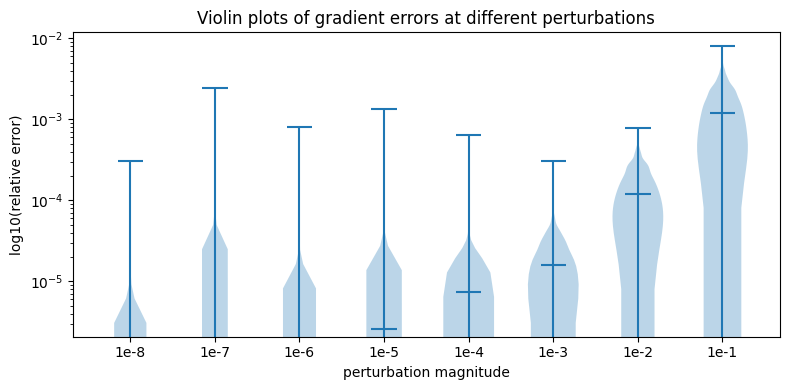

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# 假设这六个数组的 shape 都是 (n,2)，先提取第 1 维并取绝对值
data_e8 = grad_array_e8[:, 0]
data_e7 = grad_array_e7[:, 0]
data_e6 = grad_array_e6[:, 0]
data_e5 = grad_array_e5[:, 0]
data_e4 = grad_array_e4[:, 0]
data_e3 = grad_array_e3[:, 0]
data_e2 = grad_array_e2[:, 0]
data_e1 = grad_array_e1[:, 0]

# 对误差做 log10 变换
logs = [
    data_e8,
    data_e7,
    data_e6,
    data_e5,
    data_e4,
    data_e3,
    data_e2,
    data_e1,
]

# x 轴位置和对应标签
positions = np.arange(1, len(logs) + 1)
labels = ['1e-8', '1e-7', '1e-6', '1e-5', '1e-4', '1e-3', '1e-2', '1e-1']

fig, ax = plt.subplots(figsize=(8,4))
# 画小提琴图
parts = ax.violinplot(
    logs,
    positions=positions,
    showmedians=True,
    widths=0.6
)

# 美化——设置刻度和标签
ax.set_xticks(positions)
ax.set_xticklabels(labels)
ax.set_xlabel('perturbation magnitude')
ax.set_ylabel('log10(relative error)')
ax.set_yscale('log')
ax.set_title('Violin plots of gradient errors at different perturbations')


plt.tight_layout()
plt.show()


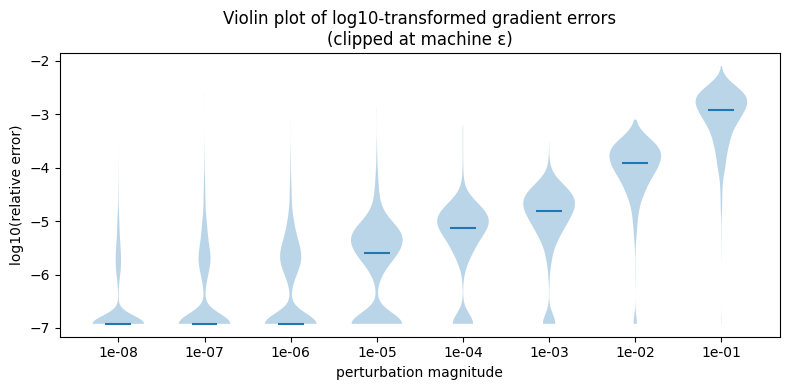

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# 假设你已在环境中定义好 grad_array_e8…grad_array_e1，shape 都是 (n,2)
arrays = {
    1e-8: grad_array_e8[:, 0],
    1e-7: grad_array_e7[:, 0],
    1e-6: grad_array_e6[:, 0],
    1e-5: grad_array_e5[:, 0],
    1e-4: grad_array_e4[:, 0],
    1e-3: grad_array_e3[:, 0],
    1e-2: grad_array_e2[:, 0],
    1e-1: grad_array_e1[:, 0],
}

# 对于 float32，相对精度 ε
eps = np.finfo(np.float32).eps  # ≈1.19e-7

# 对每组数据：
#   1) 取绝对值
#   2) 下限裁剪到 eps（小于 eps 的都设为 eps）
#   3) 再做 log10
perturbations = sorted(arrays.keys())
logs = [
    np.log10(np.maximum(np.abs(arrays[p]), eps))
    for p in perturbations
]

# 准备绘图参数
positions = np.arange(1, len(perturbations) + 1)
labels    = [f"{p:.0e}" for p in perturbations]

# 绘制小提琴图
fig, ax = plt.subplots(figsize=(8, 4))
ax.violinplot(
    logs,
    positions=positions,
    showmedians=True,    # 显示中位数
    showextrema=False,   # 关闭最值线
    widths=0.6
)

# 美化坐标轴
ax.set_xticks(positions)
ax.set_xticklabels(labels)
ax.set_xlabel('perturbation magnitude')
ax.set_ylabel('log10(relative error)')
ax.set_title('Violin plot of log10-transformed gradient errors\n(clipped at machine ε)')

plt.tight_layout()
plt.show()


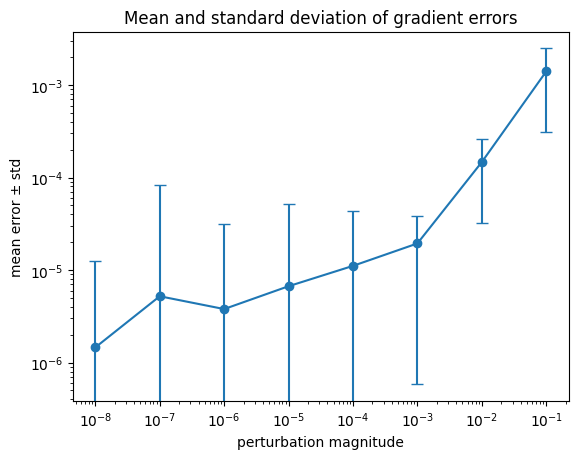

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# 假设你已经有以下六个 (n,2) 数组，取绝对值后关注第 1 维
arrays = {
    1e-8: np.abs(grad_array_e8[:,0]),
    1e-7: np.abs(grad_array_e7[:,0]),
    1e-6: np.abs(grad_array_e6[:,0]),
    1e-5: np.abs(grad_array_e5[:,0]),
    1e-4: np.abs(grad_array_e4[:,0]),
    1e-3: np.abs(grad_array_e3[:,0]),
    1e-2: np.abs(grad_array_e2[:,0]),
    1e-1: np.abs(grad_array_e1[:,0]),
}

# 计算每个扰动下的均值和标准差
perturbations = sorted(arrays.keys())
means = [arrays[p].mean() for p in perturbations]
stds  = [arrays[p].std()  for p in perturbations]

fig, ax = plt.subplots()
ax.errorbar(
    perturbations, means, yerr=stds,
    marker='o', linestyle='-',
    capsize=4
)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('perturbation magnitude')
ax.set_ylabel('mean error ± std')
ax.set_title('Mean and standard deviation of gradient errors')
plt.show()


In [8]:
feature1 = 10
feature2 = 7

class FieldNet(nn.Module):
    @nn.compact
    def __call__(self, d: jnp.ndarray, u: jnp.ndarray):
        # d: (2,)     u: (51,51)
        # Embed d → (features_d,)
        features_d = nn.Dense(features=feature1)(d)        # (128,)
        features_d = nn.relu(features_d)
        # Broadcast to spatial grid → (51,51,128)
        bd = jnp.broadcast_to(features_d, (51,51,feature1))

        # Expand u to have a channel axis → (51,51,1)
        u_in = u[..., None]

        # Concatenate along channels → (51,51,129)
        x = jnp.concatenate([u_in, bd], axis=-1)

        # Several Conv layers
        x = nn.Conv(features=feature2, kernel_size=(3,3), padding='SAME')(x)
        x = nn.relu(x)
        x = nn.Conv(features=feature2, kernel_size=(3,3), padding='SAME')(x)
        x = nn.relu(x)
        x = nn.Conv(features=1,  kernel_size=(3,3), padding='SAME')(x)

        # Squeeze channel and sigmoid to [0,1]
        x = x[..., 0]
        x = nn.sigmoid(x)  # output shape (51,51), values in (0,1)
        return x

# 创建模型实例
model = FieldNet()

# 随机初始化参数
rng = random.PRNGKey(42)
rng_true = random.PRNGKey(2025)
dummy_d = jnp.zeros((2,))
dummy_u = jnp.zeros((51,51))
params = model.init(rng, dummy_d, dummy_u)
params_true = model.init(rng_true, dummy_d, dummy_u)

# 查看参数结构（可以打印一部分来验证）
import pprint
pprint.pprint({k: {sub: v.shape for sub, v in params['params'][k].items()} 
               for k in params['params']})

print('network parameter dimension', reconstruct_dict_to_array(params).shape)

    
def forward_model(d, center, model, params):
    u_new = model.apply(params, center, u_initial)
    i = d[0]*50
    j = d[1]*50
    data_fin=jax.scipy.ndimage.map_coordinates(u_new,[i,j],1)
    return data_fin, u_new

{'Conv_0': {'bias': (7,), 'kernel': (3, 3, 11, 7)},
 'Conv_1': {'bias': (7,), 'kernel': (3, 3, 7, 7)},
 'Conv_2': {'bias': (1,), 'kernel': (3, 3, 7, 1)},
 'Dense_0': {'bias': (10,), 'kernel': (2, 10)}}
network parameter dimension (1242,)


In [11]:
key = random.PRNGKey(2019)
ensemble_size = 1400
eki_noise_level = 0.05
std_dev = 0.3
stage = None

for j in range(8):
    additional_noise = [1e-1,1e-3,1e-5,1e-6,1e-7,1e-8,1e-2,1e-4][j]
    grad_test_list = []
    for i in range(1000):
        key, _ = random.split(key)
        key_for_param = random.split(key,4+ensemble_size)
    
        center = random.uniform(key_for_param[i], (2,))
        estimated_center = random.uniform(key_for_param[i+1], (2,))
        d = random.uniform(key_for_param[i+2], (2,))
        u_initial = random.normal(key_for_param[i+3], (51,51))
        params = model.init(key_for_param[i+4], dummy_d, dummy_u)
        mean_array = reconstruct_dict_to_array(params)
        #center = jnp.array([0.25, 0.25])
        #estimated_center = jnp.array([0.2, 0.5])
        #d = jnp.array([0.3, 0.3])
        
        ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
        initial_mu = jnp.mean(ensemble_members_array,axis=0)
        initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
        grad_clean = jax.grad(loss_function_stability3)(d_start, center, estimated_center, eki_noise_level)
    
        
        ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
        ensemble_members_array = ensemble_members_array * (1+jax.random.normal(key_for_param[i], ensemble_members_array.shape)*additional_noise)
        initial_mu = jnp.mean(ensemble_members_array,axis=0)
        initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
        grad_perturb = jax.grad(loss_function_stability3)(d_start, center, estimated_center, eki_noise_level)
        grad_error = (grad_clean - grad_perturb) / grad_clean
        #print(f'additional_noise {additional_noise}, grad_clean {grad_clean}, grad_perturb {grad_perturb}, grad error {grad_error}')
        grad_test_list.append(grad_error)

    if j == 0:
        grad_array_e1 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 1:
        grad_array_e3 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 2:
        grad_array_e5 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 3:
        grad_array_e6 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 4:
        grad_array_e7 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 5:
        grad_array_e8 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 6:
        grad_array_e2 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 7:
        grad_array_e4 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')

perturb 0
perturb 1
perturb 2
perturb 3
perturb 4
perturb 5
perturb 6
perturb 7


In [13]:
# 保存数据
import pickle

data_to_save = {
    "grad_array_e1": grad_array_e1,
    "grad_array_e2": grad_array_e2,
    "grad_array_e3": grad_array_e3,
    "grad_array_e4": grad_array_e4,
    "grad_array_e5": grad_array_e5,
    "grad_array_e6": grad_array_e6,
    "grad_array_e7": grad_array_e7,
    "grad_array_e8": grad_array_e8,
}

with open('net_1242_stability_data_randownEnsemble.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)


In [35]:
with open('net_1242_stability_data_randownEnsemble.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# 访问读取的数据
grad_array_e6 = loaded_data["grad_array_e6"]
grad_array_e5 = loaded_data["grad_array_e5"]
grad_array_e7 = loaded_data["grad_array_e7"]
grad_array_e8 = loaded_data["grad_array_e8"]
grad_array_e2 = loaded_data["grad_array_e2"]
grad_array_e1 = loaded_data["grad_array_e1"]
grad_array_e3 = loaded_data["grad_array_e3"]
grad_array_e4 = loaded_data["grad_array_e4"]

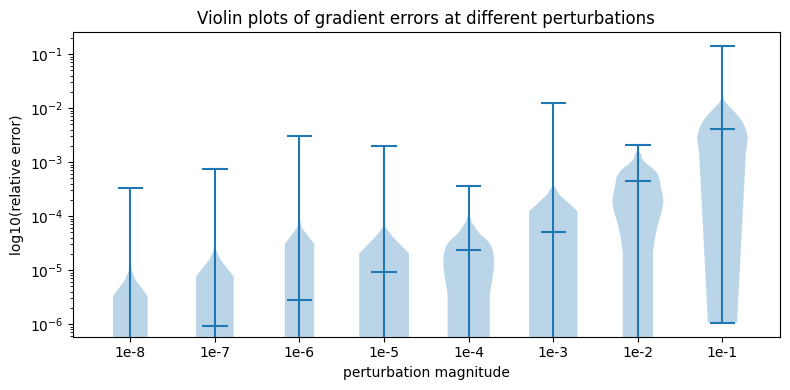

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# 假设这六个数组的 shape 都是 (n,2)，先提取第 1 维并取绝对值
data_e8 = grad_array_e8[:, 0]
data_e7 = grad_array_e7[:, 0]
data_e6 = grad_array_e6[:, 0]
data_e5 = grad_array_e5[:, 0]
data_e4 = grad_array_e4[:, 0]
data_e3 = grad_array_e3[:, 0]
data_e2 = grad_array_e2[:, 0]
data_e1 = grad_array_e1[:, 0]

# 对误差做 log10 变换
logs = [
    data_e8,
    data_e7,
    data_e6,
    data_e5,
    data_e4,
    data_e3,
    data_e2,
    data_e1,
]

# x 轴位置和对应标签
positions = np.arange(1, len(logs) + 1)
labels = ['1e-8', '1e-7', '1e-6', '1e-5', '1e-4', '1e-3', '1e-2', '1e-1']

fig, ax = plt.subplots(figsize=(8,4))
# 画小提琴图
parts = ax.violinplot(
    logs,
    positions=positions,
    showmedians=True,
    widths=0.6
)

# 美化——设置刻度和标签
ax.set_xticks(positions)
ax.set_xticklabels(labels)
ax.set_xlabel('perturbation magnitude')
ax.set_ylabel('log10(relative error)')
ax.set_yscale('log')
ax.set_title('Violin plots of gradient errors at different perturbations')


plt.tight_layout()
plt.show()


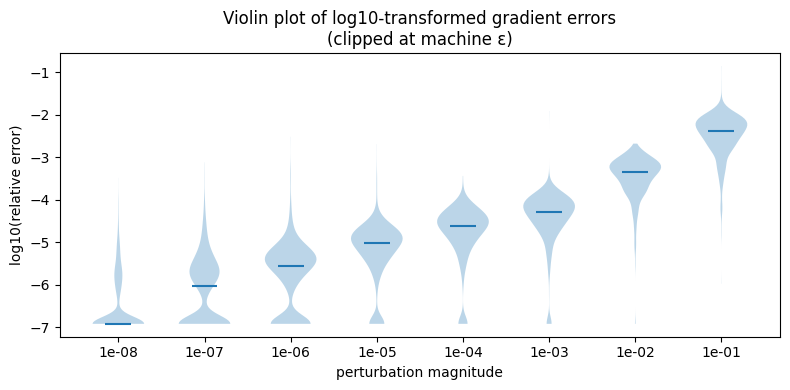

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# 假设你已在环境中定义好 grad_array_e8…grad_array_e1，shape 都是 (n,2)
arrays = {
    1e-8: grad_array_e8[:, 0],
    1e-7: grad_array_e7[:, 0],
    1e-6: grad_array_e6[:, 0],
    1e-5: grad_array_e5[:, 0],
    1e-4: grad_array_e4[:, 0],
    1e-3: grad_array_e3[:, 0],
    1e-2: grad_array_e2[:, 0],
    1e-1: grad_array_e1[:, 0],
}

# 对于 float32，相对精度 ε
eps = np.finfo(np.float32).eps  # ≈1.19e-7

# 对每组数据：
#   1) 取绝对值
#   2) 下限裁剪到 eps（小于 eps 的都设为 eps）
#   3) 再做 log10
perturbations = sorted(arrays.keys())
logs = [
    np.log10(np.maximum(np.abs(arrays[p]), eps))
    for p in perturbations
]

# 准备绘图参数
positions = np.arange(1, len(perturbations) + 1)
labels    = [f"{p:.0e}" for p in perturbations]

# 绘制小提琴图
fig, ax = plt.subplots(figsize=(8, 4))
ax.violinplot(
    logs,
    positions=positions,
    showmedians=True,    # 显示中位数
    showextrema=False,   # 关闭最值线
    widths=0.6
)

# 美化坐标轴
ax.set_xticks(positions)
ax.set_xticklabels(labels)
ax.set_xlabel('perturbation magnitude')
ax.set_ylabel('log10(relative error)')
ax.set_title('Violin plot of log10-transformed gradient errors\n(clipped at machine ε)')

plt.tight_layout()
plt.show()


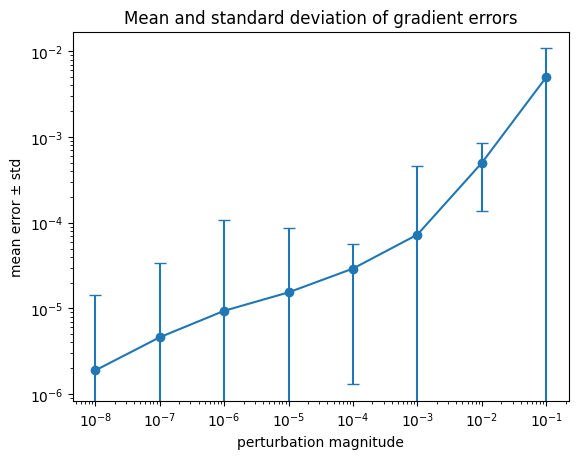

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# 假设你已经有以下六个 (n,2) 数组，取绝对值后关注第 1 维
arrays = {
    1e-8: np.abs(grad_array_e8[:,0]),
    1e-7: np.abs(grad_array_e7[:,0]),
    1e-6: np.abs(grad_array_e6[:,0]),
    1e-5: np.abs(grad_array_e5[:,0]),
    1e-4: np.abs(grad_array_e4[:,0]),
    1e-3: np.abs(grad_array_e3[:,0]),
    1e-2: np.abs(grad_array_e2[:,0]),
    1e-1: np.abs(grad_array_e1[:,0]),
}

# 计算每个扰动下的均值和标准差
perturbations = sorted(arrays.keys())
means = [arrays[p].mean() for p in perturbations]
stds  = [arrays[p].std()  for p in perturbations]

fig, ax = plt.subplots()
ax.errorbar(
    perturbations, means, yerr=stds,
    marker='o', linestyle='-',
    capsize=4
)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('perturbation magnitude')
ax.set_ylabel('mean error ± std')
ax.set_title('Mean and standard deviation of gradient errors')
plt.show()


In [8]:
feature1 = 5
feature2 = 3

class FieldNet(nn.Module):
    @nn.compact
    def __call__(self, d: jnp.ndarray, u: jnp.ndarray):
        # d: (2,)     u: (51,51)
        # Embed d → (features_d,)
        features_d = nn.Dense(features=feature1)(d)        # (128,)
        features_d = nn.relu(features_d)
        # Broadcast to spatial grid → (51,51,128)
        bd = jnp.broadcast_to(features_d, (51,51,feature1))

        # Expand u to have a channel axis → (51,51,1)
        u_in = u[..., None]

        # Concatenate along channels → (51,51,129)
        x = jnp.concatenate([u_in, bd], axis=-1)

        # Several Conv layers
        x = nn.Conv(features=feature2, kernel_size=(3,3), padding='SAME')(x)
        x = nn.relu(x)
        x = nn.Conv(features=feature2, kernel_size=(3,3), padding='SAME')(x)
        x = nn.relu(x)
        x = nn.Conv(features=1,  kernel_size=(3,3), padding='SAME')(x)

        # Squeeze channel and sigmoid to [0,1]
        x = x[..., 0]
        x = nn.sigmoid(x)  # output shape (51,51), values in (0,1)
        return x

# 创建模型实例
model = FieldNet()

# 随机初始化参数
rng = random.PRNGKey(42)
rng_true = random.PRNGKey(2025)
dummy_d = jnp.zeros((2,))
dummy_u = jnp.zeros((51,51))
params = model.init(rng, dummy_d, dummy_u)
params_true = model.init(rng_true, dummy_d, dummy_u)

# 查看参数结构（可以打印一部分来验证）
import pprint
pprint.pprint({k: {sub: v.shape for sub, v in params['params'][k].items()} 
               for k in params['params']})

print('network parameter dimension', reconstruct_dict_to_array(params).shape)

    
def forward_model(d, center, model, params):
    u_new = model.apply(params, center, u_initial)
    i = d[0]*50
    j = d[1]*50
    data_fin=jax.scipy.ndimage.map_coordinates(u_new,[i,j],1)
    return data_fin, u_new

{'Conv_0': {'bias': (3,), 'kernel': (3, 3, 6, 3)},
 'Conv_1': {'bias': (3,), 'kernel': (3, 3, 3, 3)},
 'Conv_2': {'bias': (1,), 'kernel': (3, 3, 3, 1)},
 'Dense_0': {'bias': (5,), 'kernel': (2, 5)}}
network parameter dimension (292,)


In [9]:
key = random.PRNGKey(2019)
ensemble_size = 330
eki_noise_level = 0.05
std_dev = 0.3
stage = None

threshold_small = 1e-6
threshold_large = 1e2

for j in range(8):
    additional_noise = [1e-1,1e-3,1e-5,1e-6,1e-7,1e-8,1e-2,1e-4][j]
    grad_test_list = []
    for i in range(1000):
        key, _ = random.split(key)
        key_for_param = random.split(key,4+ensemble_size)
    
        center = random.uniform(key_for_param[i], (2,))
        estimated_center = random.uniform(key_for_param[i+1], (2,))
        d = random.uniform(key_for_param[i+2], (2,))
        u_initial = random.normal(key_for_param[i+3], (51,51))
        params = model.init(key_for_param[i+4], dummy_d, dummy_u)
        mean_array = reconstruct_dict_to_array(params)
        #center = jnp.array([0.25, 0.25])
        #estimated_center = jnp.array([0.2, 0.5])
        #d = jnp.array([0.3, 0.3])
        
        ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
        initial_mu = jnp.mean(ensemble_members_array,axis=0)
        initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
        grad_clean = jax.grad(loss_function_stability3)(d_start, center, estimated_center, eki_noise_level)
    
        
        ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
        ensemble_members_array = ensemble_members_array * (1+jax.random.normal(key_for_param[i], ensemble_members_array.shape)*additional_noise)
        initial_mu = jnp.mean(ensemble_members_array,axis=0)
        initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
        grad_perturb = jax.grad(loss_function_stability3)(d_start, center, estimated_center, eki_noise_level)

        if jnp.all(jnp.abs(grad_clean) < threshold_small) and jnp.all(jnp.abs(grad_error) < threshold_small):
            print("Vanish ,","grad_clean:", grad_clean, ", grad_error:", grad_error)
        elif jnp.all(jnp.abs(grad_clean) > threshold_large) and jnp.all(jnp.abs(grad_error) > threshold_large):
            print("Explode ,","grad_clean:", grad_clean, ", grad_error:", grad_error)
        
        grad_error = (grad_clean - grad_perturb) / grad_clean
        #print(f'additional_noise {additional_noise}, grad_clean {grad_clean}, grad_perturb {grad_perturb}, grad error {grad_error}')
        grad_test_list.append(grad_error)

    if j == 0:
        grad_array_e1 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 1:
        grad_array_e3 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 2:
        grad_array_e5 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 3:
        grad_array_e6 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 4:
        grad_array_e7 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 5:
        grad_array_e8 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 6:
        grad_array_e2 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 7:
        grad_array_e4 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')

perturb 0
perturb 1
perturb 2
perturb 3
perturb 4
perturb 5
perturb 6
perturb 7


In [10]:
# 保存数据
import pickle

data_to_save = {
    "grad_array_e1": grad_array_e1,
    "grad_array_e2": grad_array_e2,
    "grad_array_e3": grad_array_e3,
    "grad_array_e4": grad_array_e4,
    "grad_array_e5": grad_array_e5,
    "grad_array_e6": grad_array_e6,
    "grad_array_e7": grad_array_e7,
    "grad_array_e8": grad_array_e8,
}

with open('net_292_stability_data_randownEnsemble.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)


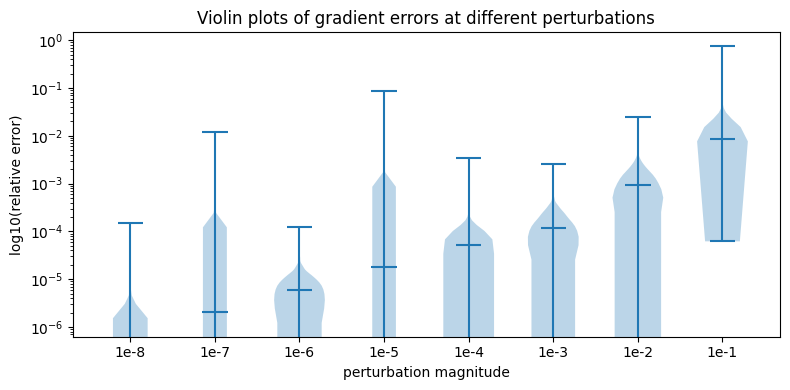

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# 假设这六个数组的 shape 都是 (n,2)，先提取第 1 维并取绝对值
data_e8 = grad_array_e8[:, 0]
data_e7 = grad_array_e7[:, 0]
data_e6 = grad_array_e6[:, 0]
data_e5 = grad_array_e5[:, 0]
data_e4 = grad_array_e4[:, 0]
data_e3 = grad_array_e3[:, 0]
data_e2 = grad_array_e2[:, 0]
data_e1 = grad_array_e1[:, 0]

# 对误差做 log10 变换
logs = [
    data_e8,
    data_e7,
    data_e6,
    data_e5,
    data_e4,
    data_e3,
    data_e2,
    data_e1,
]

# x 轴位置和对应标签
positions = np.arange(1, len(logs) + 1)
labels = ['1e-8', '1e-7', '1e-6', '1e-5', '1e-4', '1e-3', '1e-2', '1e-1']

fig, ax = plt.subplots(figsize=(8,4))
# 画小提琴图
parts = ax.violinplot(
    logs,
    positions=positions,
    showmedians=True,
    #showextrema=False,   # 不画极值线
    widths=0.6
)

# 美化——设置刻度和标签
ax.set_xticks(positions)
ax.set_xticklabels(labels)
ax.set_xlabel('perturbation magnitude')
ax.set_ylabel('log10(relative error)')
ax.set_yscale('log')
ax.set_title('Violin plots of gradient errors at different perturbations')


plt.tight_layout()
plt.show()


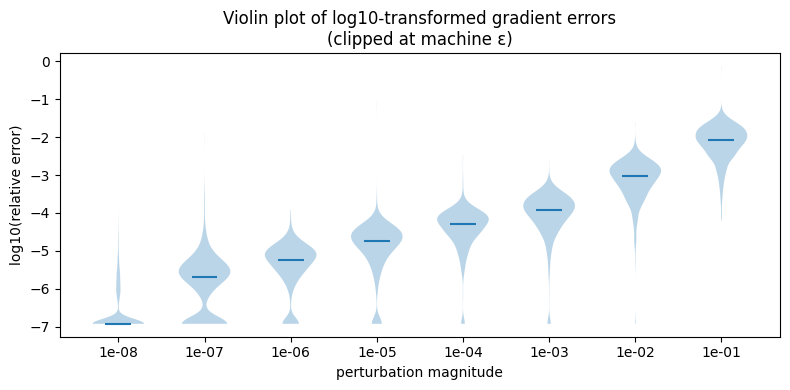

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# 假设你已在环境中定义好 grad_array_e8…grad_array_e1，shape 都是 (n,2)
arrays = {
    1e-8: grad_array_e8[:, 0],
    1e-7: grad_array_e7[:, 0],
    1e-6: grad_array_e6[:, 0],
    1e-5: grad_array_e5[:, 0],
    1e-4: grad_array_e4[:, 0],
    1e-3: grad_array_e3[:, 0],
    1e-2: grad_array_e2[:, 0],
    1e-1: grad_array_e1[:, 0],
}

# 对于 float32，相对精度 ε
eps = np.finfo(np.float32).eps  # ≈1.19e-7

# 对每组数据：
#   1) 取绝对值
#   2) 下限裁剪到 eps（小于 eps 的都设为 eps）
#   3) 再做 log10
perturbations = sorted(arrays.keys())
logs = [
    np.log10(np.maximum(np.abs(arrays[p]), eps))
    for p in perturbations
]

# 准备绘图参数
positions = np.arange(1, len(perturbations) + 1)
labels    = [f"{p:.0e}" for p in perturbations]

# 绘制小提琴图
fig, ax = plt.subplots(figsize=(8, 4))
ax.violinplot(
    logs,
    positions=positions,
    showmedians=True,    # 显示中位数
    showextrema=False,   # 关闭最值线
    widths=0.6
)

# 美化坐标轴
ax.set_xticks(positions)
ax.set_xticklabels(labels)
ax.set_xlabel('perturbation magnitude')
ax.set_ylabel('log10(relative error)')
ax.set_title('Violin plot of log10-transformed gradient errors\n(clipped at machine ε)')

plt.tight_layout()
plt.show()


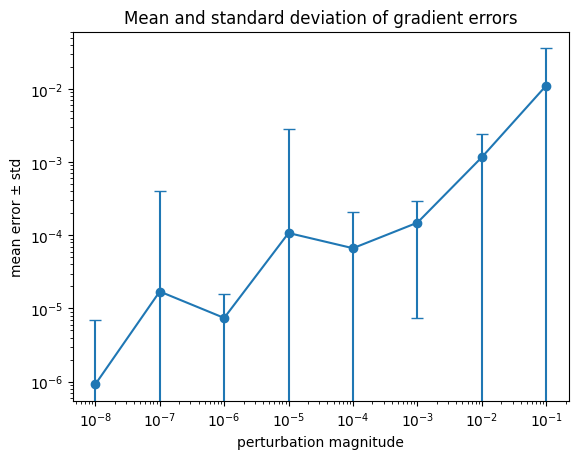

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# 假设你已经有以下六个 (n,2) 数组，取绝对值后关注第 1 维
arrays = {
    1e-8: np.abs(grad_array_e8[:,0]),
    1e-7: np.abs(grad_array_e7[:,0]),
    1e-6: np.abs(grad_array_e6[:,0]),
    1e-5: np.abs(grad_array_e5[:,0]),
    1e-4: np.abs(grad_array_e4[:,0]),
    1e-3: np.abs(grad_array_e3[:,0]),
    1e-2: np.abs(grad_array_e2[:,0]),
    1e-1: np.abs(grad_array_e1[:,0]),
}

# 计算每个扰动下的均值和标准差
perturbations = sorted(arrays.keys())
means = [arrays[p].mean() for p in perturbations]
stds  = [arrays[p].std()  for p in perturbations]

fig, ax = plt.subplots()
ax.errorbar(
    perturbations, means, yerr=stds,
    marker='o', linestyle='-',
    capsize=4
)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('perturbation magnitude')
ax.set_ylabel('mean error ± std')
ax.set_title('Mean and standard deviation of gradient errors')
plt.show()


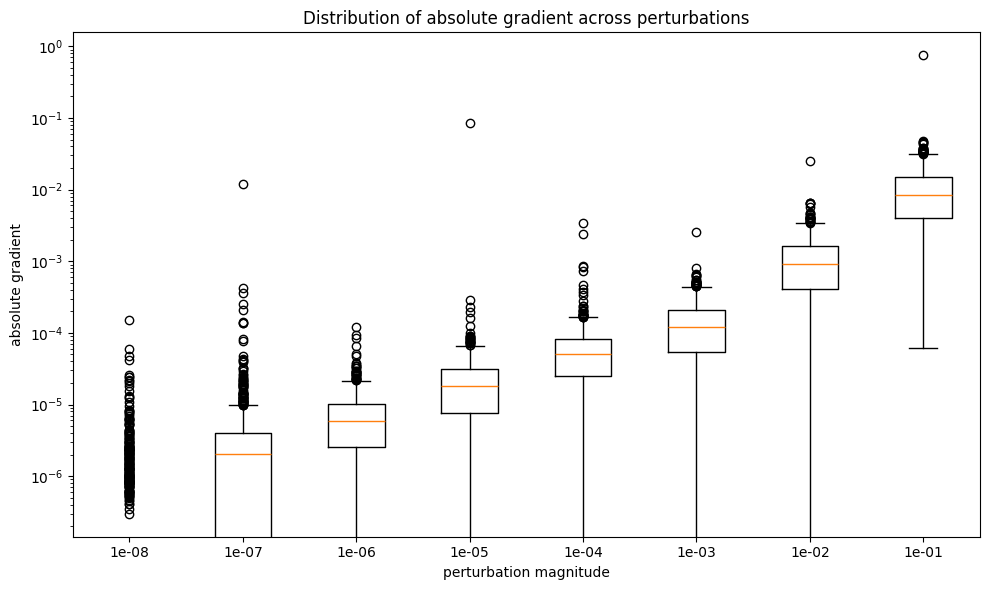

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# 假设你已在环境中定义以下 grad_array_e* 变量
arrays = {
    1e-8: np.abs(grad_array_e8[:, 0]),
    1e-7: np.abs(grad_array_e7[:, 0]),
    1e-6: np.abs(grad_array_e6[:, 0]),
    1e-5: np.abs(grad_array_e5[:, 0]),
    1e-4: np.abs(grad_array_e4[:, 0]),
    1e-3: np.abs(grad_array_e3[:, 0]),
    1e-2: np.abs(grad_array_e2[:, 0]),
    1e-1: np.abs(grad_array_e1[:, 0]),
}

perturbations = sorted(arrays.keys())
data = [arrays[p] for p in perturbations]
labels = [f"{p:.0e}" for p in perturbations]

fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(data, labels=labels)
ax.set_yscale('log')
ax.set_xlabel('perturbation magnitude')
ax.set_ylabel('absolute gradient')
ax.set_title('Distribution of absolute gradient across perturbations')
plt.tight_layout()
plt.show()


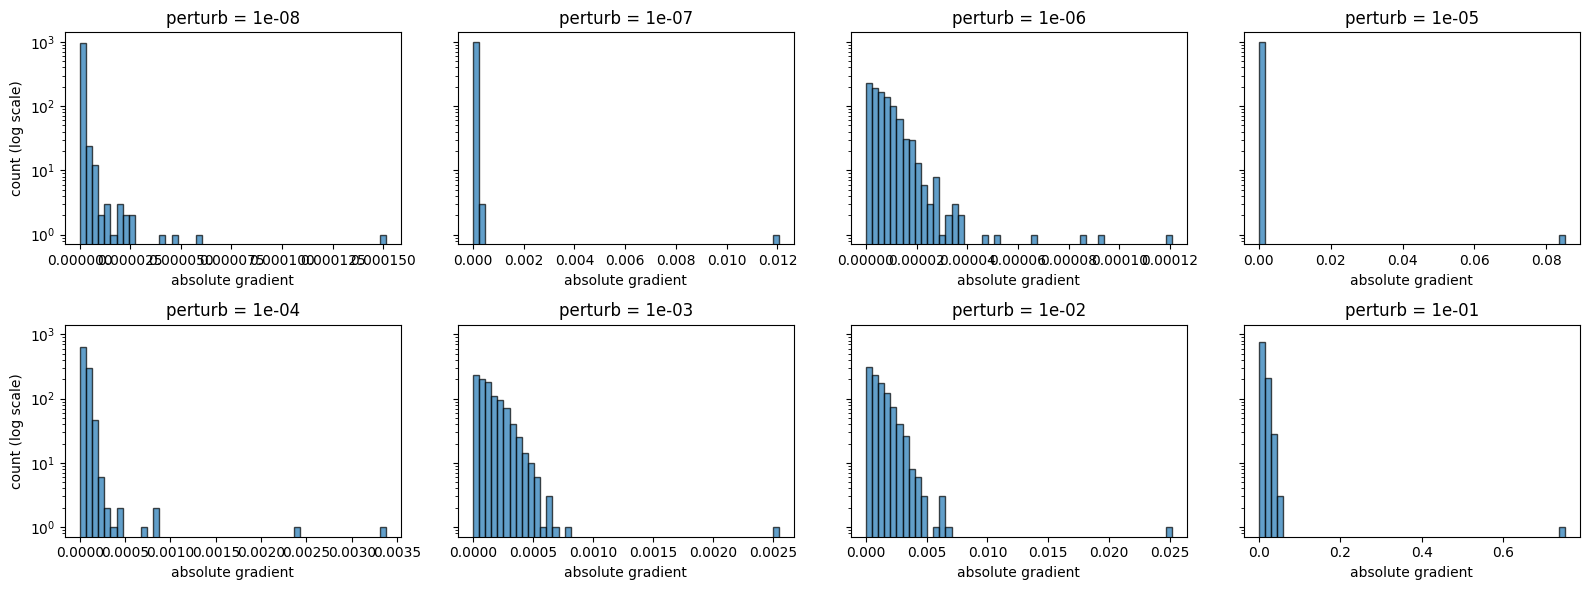

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# 假设你已在环境中定义好这个字典：
# arrays = {
#     1e-8: np.abs(grad_array_e8[:,0]),
#     1e-7: np.abs(grad_array_e7[:,0]),
#     ...,
#     1e-1: np.abs(grad_array_e1[:,0]),
# }

perturbations = sorted(arrays.keys())
n = len(perturbations)
cols = 4                     # 每行展示 4 个子图
rows = int(np.ceil(n/cols)) # 需要多少行

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows), sharey=True)
axes = axes.flatten()

for idx, p in enumerate(perturbations):
    ax = axes[idx]
    ax.hist(arrays[p], bins=50, log=True, edgecolor='k', alpha=0.7)
    ax.set_title(f"perturb = {p:.0e}")
    ax.set_xlabel("absolute gradient")
    #ax.set_yscale('log')
    if idx % cols == 0:
        ax.set_ylabel("count (log scale)")

# 把多余的空子图关掉
for j in range(idx+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [16]:
# 这里的计算：1，固定了design，2，样本数比较少

In [33]:
additional_noise = 1e-6

grad_test_list = []
key = random.PRNGKey(2019)
ensemble_size = 1000
mean_array = reconstruct_dict_to_array(params)
eki_noise_level = 0.05
std_dev = 0.3
stage = None

for i in range(10):
    key, _ = random.split(key)
    key_for_param = random.split(key,4+ensemble_size)
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    grad_clean = jax.grad(loss_function_stability3)(d_start, center, estimated_center, eki_noise_level)

    
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
    ensemble_members_array = ensemble_members_array * (1+jax.random.normal(key_for_param[i], ensemble_members_array.shape)*additional_noise)
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    grad_perturb = jax.grad(loss_function_stability3)(d_start, center, estimated_center, eki_noise_level)
    grad_error = (grad_clean - grad_perturb) / grad_clean
    print(f'additional_noise {additional_noise}, grad_clean {grad_clean}, grad_perturb {grad_perturb}, grad error {grad_error}')
    grad_test_list.append(grad_error)

additional_noise 1e-06, grad_clean [-5.999291  -1.2133837], grad_perturb [-6.095624  -1.2328625], grad error [-0.0160574  -0.01605329]
additional_noise 1e-06, grad_clean [-5.968797  -1.2072086], grad_perturb [-6.0872912 -1.2311816], grad error [-0.01985225 -0.0198582 ]
additional_noise 1e-06, grad_clean [-5.7755113 -1.1681318], grad_perturb [-5.987501  -1.2109995], grad error [-0.03670495 -0.03669762]
additional_noise 1e-06, grad_clean [-6.3100576 -1.2762427], grad_perturb [-6.150508  -1.2439728], grad error [0.02528499 0.02528512]
additional_noise 1e-06, grad_clean [-5.968082  -1.2070775], grad_perturb [-5.886662  -1.1906147], grad error [0.01364256 0.01363856]
additional_noise 1e-06, grad_clean [-5.9930563 -1.212132 ], grad_perturb [-6.0381055 -1.2212396], grad error [-0.0075169  -0.00751369]
additional_noise 1e-06, grad_clean [-6.2217116 -1.2583733], grad_perturb [-6.3445807 -1.2832284], grad error [-0.01974843 -0.0197518 ]
additional_noise 1e-06, grad_clean [-6.145656  -1.2429953],

In [42]:
loss_function_stability3(d_start, center, estimated_center, eki_noise_level) - loss_function_stability3(d_start+jnp.array([1e-7,0]), center, estimated_center, eki_noise_level)

Array(-0.00195312, dtype=float32)

In [43]:
-0.00195312 / jnp.array([1e-7,0])

Array([-19531.2,     -inf], dtype=float32)

In [44]:
loss_function_stability3(d_start, center, estimated_center, eki_noise_level) - loss_function_stability3(d_start+jnp.array([0, 1e-7]), center, estimated_center, eki_noise_level)

Array(-0.00146484, dtype=float32)

In [45]:
-0.00146484 / jnp.array([0, 1e-7])

Array([    -inf, -14648.4], dtype=float32)

In [49]:
grad_array = jnp.array(grad_test_list)

Array([[-0.0000000e+00, -0.0000000e+00],
       [-0.0000000e+00, -0.0000000e+00],
       [-0.0000000e+00, -0.0000000e+00],
       [-1.0893939e-06, -0.0000000e+00],
       [-0.0000000e+00, -0.0000000e+00],
       [-0.0000000e+00, -0.0000000e+00],
       [-0.0000000e+00, -0.0000000e+00],
       [-1.0715482e-06, -0.0000000e+00],
       [-1.1818062e-06, -0.0000000e+00],
       [-0.0000000e+00, -0.0000000e+00]], dtype=float32)

In [64]:
additional_noise = 1e-6

grad_test_list = []
key = random.PRNGKey(2019)
ensemble_size = 16000
mean_array = reconstruct_dict_to_array(params)
eki_noise_level = 0.05
std_dev = 0.3
stage = None

for i in range(100):
    key, _ = random.split(key)
    key_for_param = random.split(key,4+ensemble_size)
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    grad_clean = jax.grad(loss_function_stability3)(d_start, center, estimated_center, eki_noise_level)

    
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
    ensemble_members_array = ensemble_members_array * (1+jax.random.normal(key_for_param[i], ensemble_members_array.shape)*additional_noise)
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    grad_perturb = jax.grad(loss_function_stability3)(d_start, center, estimated_center, eki_noise_level)
    grad_error = (grad_clean - grad_perturb) / grad_clean
    print(f'additional_noise {additional_noise}, grad_clean {grad_clean}, grad_perturb {grad_perturb}, grad error {grad_error}')
    grad_test_list.append(grad_error)

grad_array_e6 = jnp.abs(jnp.array(grad_test_list))

additional_noise 1e-06, grad_clean [-5.248761  -1.0615885], grad_perturb [-5.2487555 -1.0615885], grad error [ 1.0901708e-06 -0.0000000e+00]
additional_noise 1e-06, grad_clean [-5.3375244 -1.0795414], grad_perturb [-5.3375244 -1.0795414], grad error [-0. -0.]
additional_noise 1e-06, grad_clean [-5.34302   -1.0806501], grad_perturb [-5.343032 -1.080656], grad error [-2.2311219e-06 -5.5156283e-06]
additional_noise 1e-06, grad_clean [-5.2525043 -1.0623455], grad_perturb [-5.25251   -1.0623455], grad error [-1.0893939e-06 -0.0000000e+00]
additional_noise 1e-06, grad_clean [-5.2827597 -1.0684669], grad_perturb [-5.2827597 -1.068461 ], grad error [-0.0000000e+00  5.5785204e-06]
additional_noise 1e-06, grad_clean [-5.3285837 -1.0777354], grad_perturb [-5.328572  -1.0777295], grad error [2.2371664e-06 5.5305454e-06]
additional_noise 1e-06, grad_clean [-5.251682  -1.0621786], grad_perturb [-5.251688  -1.0621786], grad error [-1.1803614e-06 -0.0000000e+00]
additional_noise 1e-06, grad_clean [-5.

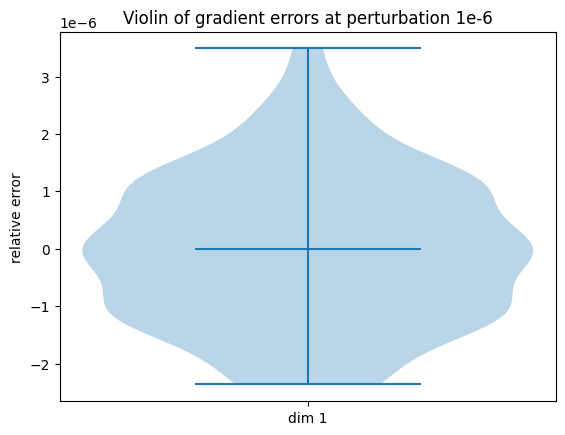

In [60]:
import matplotlib.pyplot as plt

# suppose grad_array_e6 is your (100, 2) numpy array
data = grad_array_e6[:, 0]   # first dimension

plt.violinplot(data, showmedians=True)
plt.xticks([1], ['dim 1'])  
plt.ylabel('relative error')
#plt.yscale('log')
plt.title('Violin of gradient errors at perturbation 1e-6')
plt.show()


In [65]:
additional_noise = 1e-5

grad_test_list = []
key = random.PRNGKey(2019)
ensemble_size = 16000
mean_array = reconstruct_dict_to_array(params)
eki_noise_level = 0.05
std_dev = 0.3
stage = None

for i in range(100):
    key, _ = random.split(key)
    key_for_param = random.split(key,4+ensemble_size)
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    grad_clean = jax.grad(loss_function_stability3)(d_start, center, estimated_center, eki_noise_level)

    
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
    ensemble_members_array = ensemble_members_array * (1+jax.random.normal(key_for_param[i], ensemble_members_array.shape)*additional_noise)
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    grad_perturb = jax.grad(loss_function_stability3)(d_start, center, estimated_center, eki_noise_level)
    grad_error = (grad_clean - grad_perturb) / grad_clean
    #print(f'additional_noise {additional_noise}, grad_clean {grad_clean}, grad_perturb {grad_perturb}, grad error {grad_error}')
    grad_test_list.append(grad_error)

grad_array_e5 = jnp.abs(jnp.array(grad_test_list))

additional_noise 1e-05, grad_clean [-5.248761  -1.0615885], grad_perturb [-5.2487555 -1.0615885], grad error [ 1.0901708e-06 -0.0000000e+00]
additional_noise 1e-05, grad_clean [-5.3375244 -1.0795414], grad_perturb [-5.33753   -1.0795474], grad error [-1.0720412e-06 -5.5212931e-06]
additional_noise 1e-05, grad_clean [-5.34302   -1.0806501], grad_perturb [-5.343044 -1.080656], grad error [-4.4622439e-06 -5.5156283e-06]
additional_noise 1e-05, grad_clean [-5.2525043 -1.0623455], grad_perturb [-5.2524986 -1.0623455], grad error [ 1.0893939e-06 -0.0000000e+00]
additional_noise 1e-05, grad_clean [-5.2827597 -1.0684669], grad_perturb [-5.2827597 -1.0684669], grad error [-0. -0.]
additional_noise 1e-05, grad_clean [-5.3285837 -1.0777354], grad_perturb [-5.328554  -1.0777295], grad error [5.5481732e-06 5.5305454e-06]
additional_noise 1e-05, grad_clean [-5.251682  -1.0621786], grad_perturb [-5.251688  -1.0621846], grad error [-1.1803614e-06 -5.6115464e-06]
additional_noise 1e-05, grad_clean [-5.

In [36]:
additional_noise = 1e-4

grad_test_list = []
key = random.PRNGKey(2019)
ensemble_size = 16000
mean_array = reconstruct_dict_to_array(params)
eki_noise_level = 0.05
std_dev = 0.3
stage = None

for i in range(10):
    key, _ = random.split(key)
    key_for_param = random.split(key,4+ensemble_size)
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    grad_clean = jax.grad(loss_function_stability3)(d_start, center, estimated_center, eki_noise_level)

    
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
    ensemble_members_array = ensemble_members_array * (1+jax.random.normal(key_for_param[i], ensemble_members_array.shape)*additional_noise)
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    grad_perturb = jax.grad(loss_function_stability3)(d_start, center, estimated_center, eki_noise_level)
    grad_error = (grad_clean - grad_perturb) / grad_clean
    #print(f'additional_noise {additional_noise}, grad_clean {grad_clean}, grad_perturb {grad_perturb}, grad error {grad_error}')
    grad_test_list.append(grad_error)


additional_noise 0.0001, grad_clean [-5.248761  -1.0615885], grad_perturb [-5.2486715 -1.0615706], grad error [1.7079343e-05 1.6843996e-05]
additional_noise 0.0001, grad_clean [-5.3375244 -1.0795414], grad_perturb [-5.3376017 -1.0795593], grad error [-1.4472556e-05 -1.6563879e-05]
additional_noise 0.0001, grad_clean [-5.34302   -1.0806501], grad_perturb [-5.3430915 -1.080668 ], grad error [-1.3386732e-05 -1.6546885e-05]
additional_noise 0.0001, grad_clean [-5.2525043 -1.0623455], grad_perturb [-5.2525225 -1.0623455], grad error [-3.449747e-06 -0.000000e+00]
additional_noise 0.0001, grad_clean [-5.2827597 -1.0684669], grad_perturb [-5.282712 -1.068455], grad error [9.0262893e-06 1.1157041e-05]
additional_noise 0.0001, grad_clean [-5.3285837 -1.0777354], grad_perturb [-5.3286076 -1.0777414], grad error [-4.4743329e-06 -5.5305454e-06]
additional_noise 0.0001, grad_clean [-5.251682  -1.0621786], grad_perturb [-5.2517295 -1.0621846], grad error [-9.0797039e-06 -5.6115464e-06]
additional_noi

In [66]:
additional_noise = 1e-3

grad_test_list = []
key = random.PRNGKey(2019)
ensemble_size = 16000
mean_array = reconstruct_dict_to_array(params)
eki_noise_level = 0.05
std_dev = 0.3
stage = None

for i in range(100):
    key, _ = random.split(key)
    key_for_param = random.split(key,4+ensemble_size)
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    grad_clean = jax.grad(loss_function_stability3)(d_start, center, estimated_center, eki_noise_level)

    
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
    ensemble_members_array = ensemble_members_array * (1+jax.random.normal(key_for_param[i], ensemble_members_array.shape)*additional_noise)
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    grad_perturb = jax.grad(loss_function_stability3)(d_start, center, estimated_center, eki_noise_level)
    grad_error = (grad_clean - grad_perturb) / grad_clean
    print(f'additional_noise {additional_noise}, grad_clean {grad_clean}, grad_perturb {grad_perturb}, grad error {grad_error}')
    grad_test_list.append(grad_error)

grad_array_e3 = jnp.abs(jnp.array(grad_test_list))

additional_noise 0.001, grad_clean [-5.248761  -1.0615885], grad_perturb [-5.248797  -1.0615945], grad error [-6.8135673e-06 -5.6146655e-06]
additional_noise 0.001, grad_clean [-5.3375244 -1.0795414], grad_perturb [-5.3376436 -1.0795653], grad error [-2.2334192e-05 -2.2085173e-05]
additional_noise 0.001, grad_clean [-5.34302   -1.0806501], grad_perturb [-5.343199  -1.0806918], grad error [-3.346683e-05 -3.860940e-05]
additional_noise 0.001, grad_clean [-5.2525043 -1.0623455], grad_perturb [-5.25251   -1.0623455], grad error [-1.0893939e-06 -0.0000000e+00]
additional_noise 0.001, grad_clean [-5.2827597 -1.0684669], grad_perturb [-5.2827597 -1.0684669], grad error [-0. -0.]
additional_noise 0.001, grad_clean [-5.3285837 -1.0777354], grad_perturb [-5.328703  -1.0777593], grad error [-2.2371665e-05 -2.2122182e-05]
additional_noise 0.001, grad_clean [-5.251682  -1.0621786], grad_perturb [-5.251682  -1.0621786], grad error [-0. -0.]
additional_noise 0.001, grad_clean [-5.33998   -1.0800421],

In [39]:
additional_noise = 1e-2

grad_test_list = []
key = random.PRNGKey(2019)
ensemble_size = 16000
mean_array = reconstruct_dict_to_array(params)
eki_noise_level = 0.05
std_dev = 0.3
stage = None

for i in range(10):
    key, _ = random.split(key)
    key_for_param = random.split(key,4+ensemble_size)
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    grad_clean = jax.grad(loss_function_stability3)(d_start, center, estimated_center, eki_noise_level)

    
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
    ensemble_members_array = ensemble_members_array * (1+jax.random.normal(key_for_param[i], ensemble_members_array.shape)*additional_noise)
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    grad_perturb = jax.grad(loss_function_stability3)(d_start, center, estimated_center, eki_noise_level)
    grad_error = (grad_clean - grad_perturb) / grad_clean
    print(f'additional_noise {additional_noise}, grad_clean {grad_clean}, grad_perturb {grad_perturb}, grad error {grad_error}')
    grad_test_list.append(grad_error)

additional_noise 0.01, grad_clean [-5.248761  -1.0615885], grad_perturb [-5.2489996 -1.0616362], grad error [-4.5423782e-05 -4.4917324e-05]
additional_noise 0.01, grad_clean [-5.3375244 -1.0795414], grad_perturb [-5.337918  -1.0796189], grad error [-7.3702831e-05 -7.1776805e-05]
additional_noise 0.01, grad_clean [-5.34302   -1.0806501], grad_perturb [-5.344099  -1.0808706], grad error [-0.00020196 -0.00020408]
additional_noise 0.01, grad_clean [-5.2525043 -1.0623455], grad_perturb [-5.2534285 -1.0625303], grad error [-0.00017594 -0.00017393]
additional_noise 0.01, grad_clean [-5.2827597 -1.0684669], grad_perturb [-5.28335   -1.0685861], grad error [-0.00011175 -0.00011157]
additional_noise 0.01, grad_clean [-5.3285837 -1.0777354], grad_perturb [-5.3295555 -1.0779262], grad error [-0.00018237 -0.00017698]
additional_noise 0.01, grad_clean [-5.251682  -1.0621786], grad_perturb [-5.250436  -1.0619283], grad error [0.00023725 0.00023568]
additional_noise 0.01, grad_clean [-5.33998   -1.080

In [67]:
additional_noise = 1e-1

grad_test_list = []
key = random.PRNGKey(2019)
ensemble_size = 16000
mean_array = reconstruct_dict_to_array(params)
eki_noise_level = 0.05
std_dev = 0.3
stage = None

for i in range(100):
    key, _ = random.split(key)
    key_for_param = random.split(key,4+ensemble_size)
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    grad_clean = jax.grad(loss_function_stability3)(d_start, center, estimated_center, eki_noise_level)

    
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
    ensemble_members_array = ensemble_members_array * (1+jax.random.normal(key_for_param[i], ensemble_members_array.shape)*additional_noise)
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    grad_perturb = jax.grad(loss_function_stability3)(d_start, center, estimated_center, eki_noise_level)
    grad_error = (grad_clean - grad_perturb) / grad_clean
    print(f'additional_noise {additional_noise}, grad_clean {grad_clean}, grad_perturb {grad_perturb}, grad error {grad_error}')
    grad_test_list.append(grad_error)

grad_array_e1 = jnp.abs(jnp.array(grad_test_list))

additional_noise 0.1, grad_clean [-5.248761  -1.0615885], grad_perturb [-5.2550373 -1.0628581], grad error [-0.00119574 -0.00119592]
additional_noise 0.1, grad_clean [-5.3375244 -1.0795414], grad_perturb [-5.335307  -1.0790944], grad error [0.00041542 0.0004141 ]
additional_noise 0.1, grad_clean [-5.34302   -1.0806501], grad_perturb [-5.3532124 -1.0827184], grad error [-0.00190761 -0.00191392]
additional_noise 0.1, grad_clean [-5.2525043 -1.0623455], grad_perturb [-5.2668037 -1.0652363], grad error [-0.0027224  -0.00272117]
additional_noise 0.1, grad_clean [-5.2827597 -1.0684669], grad_perturb [-5.289173  -1.0697663], grad error [-0.00121404 -0.00121612]
additional_noise 0.1, grad_clean [-5.3285837 -1.0777354], grad_perturb [-5.335909  -1.0792136], grad error [-0.00137469 -0.00137158]
additional_noise 0.1, grad_clean [-5.251682  -1.0621786], grad_perturb [-5.239934  -1.0598004], grad error [0.00223697 0.00223901]
additional_noise 0.1, grad_clean [-5.33998   -1.0800421], grad_perturb [-

In [70]:
additional_noise = 1e-7

grad_test_list = []
key = random.PRNGKey(2019)
ensemble_size = 16000
mean_array = reconstruct_dict_to_array(params)
eki_noise_level = 0.05
std_dev = 0.3
stage = None

for i in range(100):
    key, _ = random.split(key)
    key_for_param = random.split(key,4+ensemble_size)
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    grad_clean = jax.grad(loss_function_stability3)(d_start, center, estimated_center, eki_noise_level)

    
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
    ensemble_members_array = ensemble_members_array * (1+jax.random.normal(key_for_param[i], ensemble_members_array.shape)*additional_noise)
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    grad_perturb = jax.grad(loss_function_stability3)(d_start, center, estimated_center, eki_noise_level)
    grad_error = (grad_clean - grad_perturb) / grad_clean
    print(f'additional_noise {additional_noise}, grad_clean {grad_clean}, grad_perturb {grad_perturb}, grad error {grad_error}')
    grad_test_list.append(grad_error)

grad_array_e7 = jnp.abs(jnp.array(grad_test_list))

additional_noise 1e-07, grad_clean [-5.248761  -1.0615885], grad_perturb [-5.248761  -1.0615885], grad error [-0. -0.]
additional_noise 1e-07, grad_clean [-5.3375244 -1.0795414], grad_perturb [-5.3375363 -1.0795414], grad error [-2.233419e-06 -0.000000e+00]
additional_noise 1e-07, grad_clean [-5.34302   -1.0806501], grad_perturb [-5.34302   -1.0806501], grad error [-0. -0.]
additional_noise 1e-07, grad_clean [-5.2525043 -1.0623455], grad_perturb [-5.25251   -1.0623455], grad error [-1.0893939e-06 -0.0000000e+00]
additional_noise 1e-07, grad_clean [-5.2827597 -1.0684669], grad_perturb [-5.2827597 -1.0684669], grad error [-0. -0.]
additional_noise 1e-07, grad_clean [-5.3285837 -1.0777354], grad_perturb [-5.3285837 -1.0777295], grad error [-0.0000000e+00  5.5305454e-06]
additional_noise 1e-07, grad_clean [-5.251682  -1.0621786], grad_perturb [-5.251682  -1.0621786], grad error [-0. -0.]
additional_noise 1e-07, grad_clean [-5.33998   -1.0800421], grad_perturb [-5.3399744 -1.0800362], grad 

In [68]:
additional_noise = 1e-8

grad_test_list = []
key = random.PRNGKey(2019)
ensemble_size = 16000
mean_array = reconstruct_dict_to_array(params)
eki_noise_level = 0.05
std_dev = 0.3
stage = None

for i in range(100):
    key, _ = random.split(key)
    key_for_param = random.split(key,4+ensemble_size)
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    grad_clean = jax.grad(loss_function_stability3)(d_start, center, estimated_center, eki_noise_level)

    
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
    ensemble_members_array = ensemble_members_array * (1+jax.random.normal(key_for_param[i], ensemble_members_array.shape)*additional_noise)
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    grad_perturb = jax.grad(loss_function_stability3)(d_start, center, estimated_center, eki_noise_level)
    grad_error = (grad_clean - grad_perturb) / grad_clean
    print(f'additional_noise {additional_noise}, grad_clean {grad_clean}, grad_perturb {grad_perturb}, grad error {grad_error}')
    grad_test_list.append(grad_error)

grad_array_e8 = jnp.abs(jnp.array(grad_test_list))

additional_noise 1e-08, grad_clean [-5.248761  -1.0615885], grad_perturb [-5.248761  -1.0615885], grad error [-0. -0.]
additional_noise 1e-08, grad_clean [-5.3375244 -1.0795414], grad_perturb [-5.3375244 -1.0795414], grad error [-0. -0.]
additional_noise 1e-08, grad_clean [-5.34302   -1.0806501], grad_perturb [-5.34302   -1.0806501], grad error [-0. -0.]
additional_noise 1e-08, grad_clean [-5.2525043 -1.0623455], grad_perturb [-5.25251   -1.0623455], grad error [-1.0893939e-06 -0.0000000e+00]
additional_noise 1e-08, grad_clean [-5.2827597 -1.0684669], grad_perturb [-5.2827597 -1.0684669], grad error [-0. -0.]
additional_noise 1e-08, grad_clean [-5.3285837 -1.0777354], grad_perturb [-5.3285837 -1.0777354], grad error [-0. -0.]
additional_noise 1e-08, grad_clean [-5.251682  -1.0621786], grad_perturb [-5.251682  -1.0621786], grad error [-0. -0.]
additional_noise 1e-08, grad_clean [-5.33998   -1.0800421], grad_perturb [-5.339986  -1.0800421], grad error [-1.0715482e-06 -0.0000000e+00]
addi

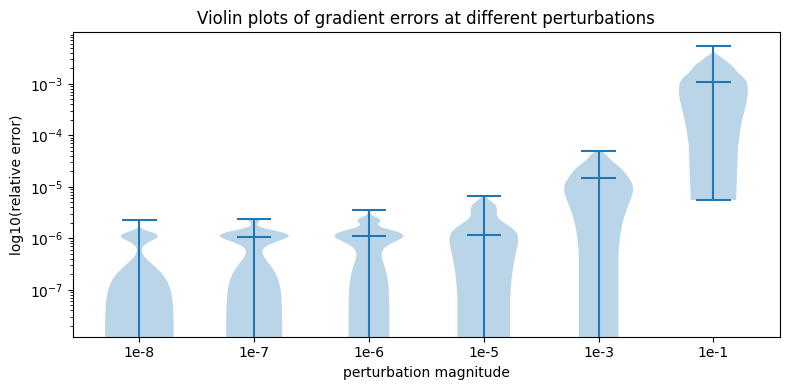

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# 假设这六个数组的 shape 都是 (n,2)，先提取第 1 维并取绝对值
data_e8 = grad_array_e8[:, 0]
data_e7 = grad_array_e7[:, 0]
data_e6 = grad_array_e6[:, 0]
data_e5 = grad_array_e5[:, 0]
data_e3 = grad_array_e3[:, 0]
data_e1 = grad_array_e1[:, 0]

# 对误差做 log10 变换
logs = [
    data_e8,
    data_e7,
    data_e6,
    data_e5,
    data_e3,
    data_e1,
]

# x 轴位置和对应标签
positions = np.arange(1, len(logs) + 1)
labels = ['1e-8', '1e-7', '1e-6', '1e-5', '1e-3', '1e-1']

fig, ax = plt.subplots(figsize=(8,4))
# 画小提琴图
parts = ax.violinplot(
    logs,
    positions=positions,
    showmedians=True,
    widths=0.6
)

# 美化——设置刻度和标签
ax.set_xticks(positions)
ax.set_xticklabels(labels)
ax.set_xlabel('perturbation magnitude')
ax.set_ylabel('log10(relative error)')
ax.set_yscale('log')
ax.set_title('Violin plots of gradient errors at different perturbations')


plt.tight_layout()
plt.show()


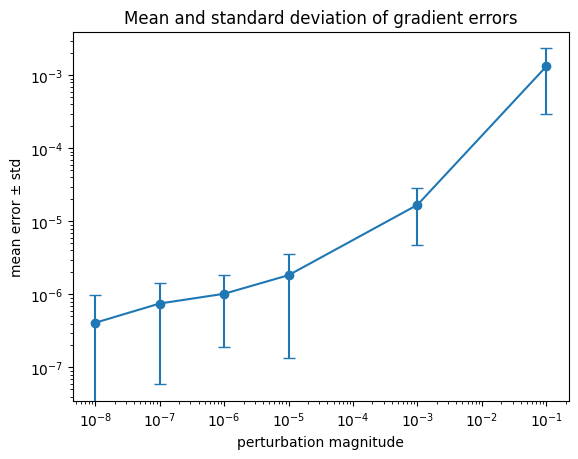

In [76]:
import numpy as np
import matplotlib.pyplot as plt

# 假设你已经有以下六个 (n,2) 数组，取绝对值后关注第 1 维
arrays = {
    1e-8: np.abs(grad_array_e8[:,0]),
    1e-7: np.abs(grad_array_e7[:,0]),
    1e-6: np.abs(grad_array_e6[:,0]),
    1e-5: np.abs(grad_array_e5[:,0]),
    1e-3: np.abs(grad_array_e3[:,0]),
    1e-1: np.abs(grad_array_e1[:,0]),
}

# 计算每个扰动下的均值和标准差
perturbations = sorted(arrays.keys())
means = [arrays[p].mean() for p in perturbations]
stds  = [arrays[p].std()  for p in perturbations]

fig, ax = plt.subplots()
ax.errorbar(
    perturbations, means, yerr=stds,
    marker='o', linestyle='-',
    capsize=4
)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('perturbation magnitude')
ax.set_ylabel('mean error ± std')
ax.set_title('Mean and standard deviation of gradient errors')
plt.show()


In [73]:
# 保存数据
import pickle

data_to_save = {
    "grad_array_e8": grad_array_e8,
    "grad_array_e7": grad_array_e7,
    "grad_array_e6": grad_array_e6,
    "grad_array_e5": grad_array_e5,
    "grad_array_e3": grad_array_e3,
    "grad_array_e1": grad_array_e1,
}

with open('net_15131_stability_data.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)


In [58]:
feature1 = 10
feature2 = 6

class FieldNet(nn.Module):
    @nn.compact
    def __call__(self, d: jnp.ndarray, u: jnp.ndarray):
        # d: (2,)     u: (51,51)
        # Embed d → (features_d,)
        features_d = nn.Dense(features=feature1)(d)        # (128,)
        features_d = nn.relu(features_d)
        # Broadcast to spatial grid → (51,51,128)
        bd = jnp.broadcast_to(features_d, (51,51,feature1))

        # Expand u to have a channel axis → (51,51,1)
        u_in = u[..., None]

        # Concatenate along channels → (51,51,129)
        x = jnp.concatenate([u_in, bd], axis=-1)

        # Several Conv layers
        x = nn.Conv(features=feature2, kernel_size=(3,3), padding='SAME')(x)
        x = nn.relu(x)
        x = nn.Conv(features=feature2, kernel_size=(3,3), padding='SAME')(x)
        x = nn.relu(x)
        x = nn.Conv(features=1,  kernel_size=(3,3), padding='SAME')(x)

        # Squeeze channel and sigmoid to [0,1]
        x = x[..., 0]
        x = nn.sigmoid(x)  # output shape (51,51), values in (0,1)
        return x

# 创建模型实例
model = FieldNet()

# 随机初始化参数
rng = random.PRNGKey(42)
rng_true = random.PRNGKey(2025)
dummy_d = jnp.zeros((2,))
dummy_u = jnp.zeros((51,51))
params = model.init(rng, dummy_d, dummy_u)
params_true = model.init(rng_true, dummy_d, dummy_u)

# 查看参数结构（可以打印一部分来验证）
import pprint
pprint.pprint({k: {sub: v.shape for sub, v in params['params'][k].items()} 
               for k in params['params']})

print('network parameter dimension', reconstruct_dict_to_array(params).shape)

    
def forward_model(d, center, model, params):
    u_new = model.apply(params, center, u_initial)
    i = d[0]*50
    j = d[1]*50
    data_fin=jax.scipy.ndimage.map_coordinates(u_new,[i,j],1)
    return data_fin, u_new

{'Conv_0': {'bias': (6,), 'kernel': (3, 3, 11, 6)},
 'Conv_1': {'bias': (6,), 'kernel': (3, 3, 6, 6)},
 'Conv_2': {'bias': (1,), 'kernel': (3, 3, 6, 1)},
 'Dense_0': {'bias': (10,), 'kernel': (2, 10)}}
network parameter dimension (1015,)


In [59]:
center = jnp.array([0.25, 0.25])
estimated_center = jnp.array([0.2, 0.5])
d = jnp.array([0.3, 0.3])

u_initial = random.normal(rng_true, (51,51))
y_true, u_true = forward_model(d, center, model, params_true)
print('measurement : ', y_true)

measurement :  0.5064634


In [60]:
key = random.PRNGKey(2019)
ensemble_size = 1200
mean_array = reconstruct_dict_to_array(params)
eki_noise_level = 0.05
std_dev = 0.3
stage = None

for j in range(7):
    additional_noise = [1e-1,1e-3,1e-5,1e-6,1e-7,1e-8,1e-2][j]
    grad_test_list = []
    for i in range(100):
        key, _ = random.split(key)
        key_for_param = random.split(key,4+ensemble_size)
    
        center = random.uniform(key_for_param[i], (2,))
        estimated_center = random.uniform(key_for_param[i+1], (2,))
        d = random.uniform(key_for_param[i+2], (2,))
        #center = jnp.array([0.25, 0.25])
        #estimated_center = jnp.array([0.2, 0.5])
        #d = jnp.array([0.3, 0.3])
        
        ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
        initial_mu = jnp.mean(ensemble_members_array,axis=0)
        initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
        grad_clean = jax.grad(loss_function_stability3)(d_start, center, estimated_center, eki_noise_level)
    
        
        ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
        ensemble_members_array = ensemble_members_array * (1+jax.random.normal(key_for_param[i], ensemble_members_array.shape)*additional_noise)
        initial_mu = jnp.mean(ensemble_members_array,axis=0)
        initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
        grad_perturb = jax.grad(loss_function_stability3)(d_start, center, estimated_center, eki_noise_level)
        grad_error = (grad_clean - grad_perturb) / grad_clean
        #print(f'additional_noise {additional_noise}, grad_clean {grad_clean}, grad_perturb {grad_perturb}, grad error {grad_error}')
        grad_test_list.append(grad_error)

    if j == 0:
        grad_array_e1 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 1:
        grad_array_e3 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 2:
        grad_array_e5 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 3:
        grad_array_e6 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 4:
        grad_array_e7 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 5:
        grad_array_e8 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 6:
        grad_array_e2 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    
        

perturb 0
perturb 1
perturb 2
perturb 3
perturb 4
perturb 5
perturb 6


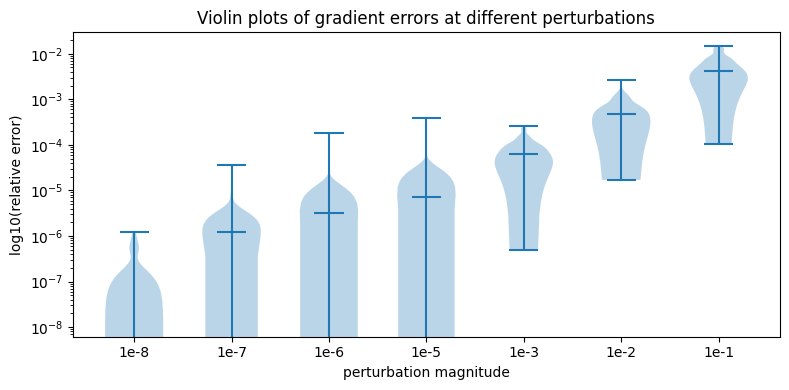

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# 假设这六个数组的 shape 都是 (n,2)，先提取第 1 维并取绝对值
data_e8 = grad_array_e8[:, 0]
data_e7 = grad_array_e7[:, 0]
data_e6 = grad_array_e6[:, 0]
data_e5 = grad_array_e5[:, 0]
data_e3 = grad_array_e3[:, 0]
data_e2 = grad_array_e2[:, 0]
data_e1 = grad_array_e1[:, 0]

# 对误差做 log10 变换
logs = [
    data_e8,
    data_e7,
    data_e6,
    data_e5,
    data_e3,
    data_e2,
    data_e1,
]

# x 轴位置和对应标签
positions = np.arange(1, len(logs) + 1)
labels = ['1e-8', '1e-7', '1e-6', '1e-5', '1e-3', '1e-2', '1e-1']

fig, ax = plt.subplots(figsize=(8,4))
# 画小提琴图
parts = ax.violinplot(
    logs,
    positions=positions,
    showmedians=True,
    widths=0.6
)

# 美化——设置刻度和标签
ax.set_xticks(positions)
ax.set_xticklabels(labels)
ax.set_xlabel('perturbation magnitude')
ax.set_ylabel('log10(relative error)')
ax.set_yscale('log')
ax.set_title('Violin plots of gradient errors at different perturbations')


plt.tight_layout()
plt.show()


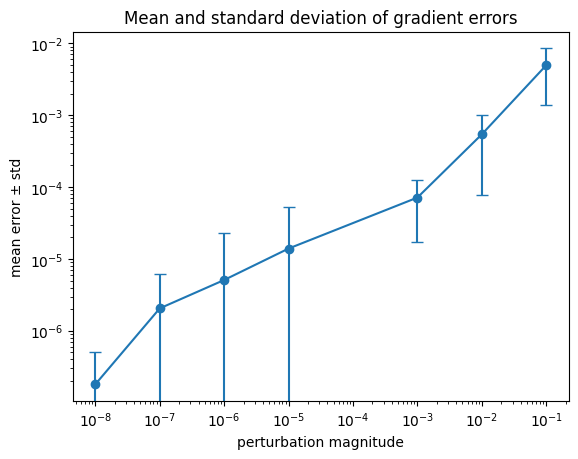

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# 假设你已经有以下六个 (n,2) 数组，取绝对值后关注第 1 维
arrays = {
    1e-8: np.abs(grad_array_e8[:,0]),
    1e-7: np.abs(grad_array_e7[:,0]),
    1e-6: np.abs(grad_array_e6[:,0]),
    1e-5: np.abs(grad_array_e5[:,0]),
    1e-3: np.abs(grad_array_e3[:,0]),
    1e-2: np.abs(grad_array_e2[:,0]),
    1e-1: np.abs(grad_array_e1[:,0]),
}

# 计算每个扰动下的均值和标准差
perturbations = sorted(arrays.keys())
means = [arrays[p].mean() for p in perturbations]
stds  = [arrays[p].std()  for p in perturbations]

fig, ax = plt.subplots()
ax.errorbar(
    perturbations, means, yerr=stds,
    marker='o', linestyle='-',
    capsize=4
)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('perturbation magnitude')
ax.set_ylabel('mean error ± std')
ax.set_title('Mean and standard deviation of gradient errors')
plt.show()


In [49]:
# 保存数据
import pickle

data_to_save = {
    "grad_array_e8": grad_array_e8,
    "grad_array_e7": grad_array_e7,
    "grad_array_e6": grad_array_e6,
    "grad_array_e5": grad_array_e5,
    "grad_array_e3": grad_array_e3,
    "grad_array_e2": grad_array_e2,
    "grad_array_e1": grad_array_e1,
}

with open('net_1015_stability_data.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)


In [51]:
feature1 = 5
feature2 = 3

class FieldNet(nn.Module):
    @nn.compact
    def __call__(self, d: jnp.ndarray, u: jnp.ndarray):
        # d: (2,)     u: (51,51)
        # Embed d → (features_d,)
        features_d = nn.Dense(features=feature1)(d)        # (128,)
        features_d = nn.relu(features_d)
        # Broadcast to spatial grid → (51,51,128)
        bd = jnp.broadcast_to(features_d, (51,51,feature1))

        # Expand u to have a channel axis → (51,51,1)
        u_in = u[..., None]

        # Concatenate along channels → (51,51,129)
        x = jnp.concatenate([u_in, bd], axis=-1)

        # Several Conv layers
        x = nn.Conv(features=feature2, kernel_size=(3,3), padding='SAME')(x)
        x = nn.relu(x)
        x = nn.Conv(features=feature2, kernel_size=(3,3), padding='SAME')(x)
        x = nn.relu(x)
        x = nn.Conv(features=1,  kernel_size=(3,3), padding='SAME')(x)

        # Squeeze channel and sigmoid to [0,1]
        x = x[..., 0]
        x = nn.sigmoid(x)  # output shape (51,51), values in (0,1)
        return x

# 创建模型实例
model = FieldNet()

# 随机初始化参数
rng = random.PRNGKey(42)
rng_true = random.PRNGKey(2025)
dummy_d = jnp.zeros((2,))
dummy_u = jnp.zeros((51,51))
params = model.init(rng, dummy_d, dummy_u)
params_true = model.init(rng_true, dummy_d, dummy_u)

# 查看参数结构（可以打印一部分来验证）
import pprint
pprint.pprint({k: {sub: v.shape for sub, v in params['params'][k].items()} 
               for k in params['params']})

print('network parameter dimension', reconstruct_dict_to_array(params).shape)

    
def forward_model(d, center, model, params):
    u_new = model.apply(params, center, u_initial)
    i = d[0]*50
    j = d[1]*50
    data_fin=jax.scipy.ndimage.map_coordinates(u_new,[i,j],1)
    return data_fin, u_new

{'Conv_0': {'bias': (3,), 'kernel': (3, 3, 6, 3)},
 'Conv_1': {'bias': (3,), 'kernel': (3, 3, 3, 3)},
 'Conv_2': {'bias': (1,), 'kernel': (3, 3, 3, 1)},
 'Dense_0': {'bias': (5,), 'kernel': (2, 5)}}
network parameter dimension (292,)


In [54]:
key = random.PRNGKey(2019)
ensemble_size = 350
mean_array = reconstruct_dict_to_array(params)
eki_noise_level = 0.05
std_dev = 0.3
stage = None

for j in range(6):
    additional_noise = [1e-1,1e-3,1e-5,1e-6,1e-7,1e-8,1e-2][j]
    grad_test_list = []
    for i in range(100):
        key, _ = random.split(key)
        key_for_param = random.split(key,4+ensemble_size)
    
        center = random.uniform(key_for_param[i], (2,))
        estimated_center = random.uniform(key_for_param[i+1], (2,))
        d = random.uniform(key_for_param[i+2], (2,))
        #center = jnp.array([0.25, 0.25])
        #estimated_center = jnp.array([0.2, 0.5])
        #d = jnp.array([0.3, 0.3])
        
        ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
        initial_mu = jnp.mean(ensemble_members_array,axis=0)
        initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
        grad_clean = jax.grad(loss_function_stability3)(d_start, center, estimated_center, eki_noise_level)
    
        
        ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
        ensemble_members_array = ensemble_members_array * (1+jax.random.normal(key_for_param[i], ensemble_members_array.shape)*additional_noise)
        initial_mu = jnp.mean(ensemble_members_array,axis=0)
        initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
        grad_perturb = jax.grad(loss_function_stability3)(d_start, center, estimated_center, eki_noise_level)
        grad_error = (grad_clean - grad_perturb) / grad_clean
        #print(f'additional_noise {additional_noise}, grad_clean {grad_clean}, grad_perturb {grad_perturb}, grad error {grad_error}')
        grad_test_list.append(grad_error)

    if j == 0:
        grad_array_e1 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 1:
        grad_array_e3 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 2:
        grad_array_e5 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 3:
        grad_array_e6 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 4:
        grad_array_e7 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 5:
        grad_array_e8 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 6:
        grad_array_e2 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')

    
        

perturb 0
perturb 1
perturb 2
perturb 3
perturb 4
perturb 5


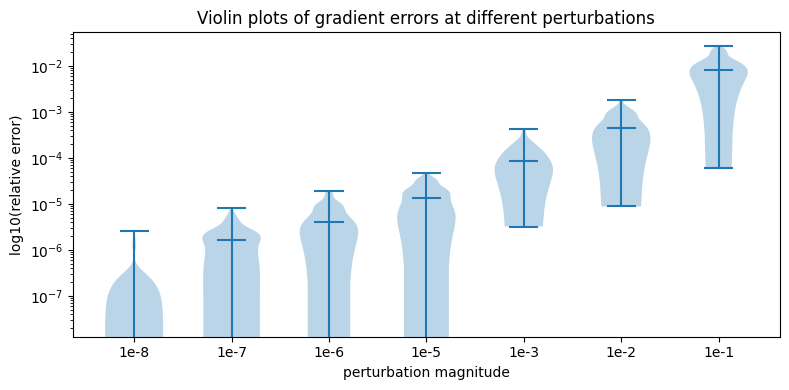

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# 假设这六个数组的 shape 都是 (n,2)，先提取第 1 维并取绝对值
data_e8 = grad_array_e8[:, 0]
data_e7 = grad_array_e7[:, 0]
data_e6 = grad_array_e6[:, 0]
data_e5 = grad_array_e5[:, 0]
data_e3 = grad_array_e3[:, 0]
data_e2 = grad_array_e2[:, 0]
data_e1 = grad_array_e1[:, 0]

# 对误差做 log10 变换
logs = [
    data_e8,
    data_e7,
    data_e6,
    data_e5,
    data_e3,
    data_e2,
    data_e1,
]

# x 轴位置和对应标签
positions = np.arange(1, len(logs) + 1)
labels = ['1e-8', '1e-7', '1e-6', '1e-5', '1e-3', '1e-2', '1e-1']

fig, ax = plt.subplots(figsize=(8,4))
# 画小提琴图
parts = ax.violinplot(
    logs,
    positions=positions,
    showmedians=True,
    widths=0.6
)

# 美化——设置刻度和标签
ax.set_xticks(positions)
ax.set_xticklabels(labels)
ax.set_xlabel('perturbation magnitude')
ax.set_ylabel('log10(relative error)')
ax.set_yscale('log')
ax.set_title('Violin plots of gradient errors at different perturbations')


plt.tight_layout()
plt.show()


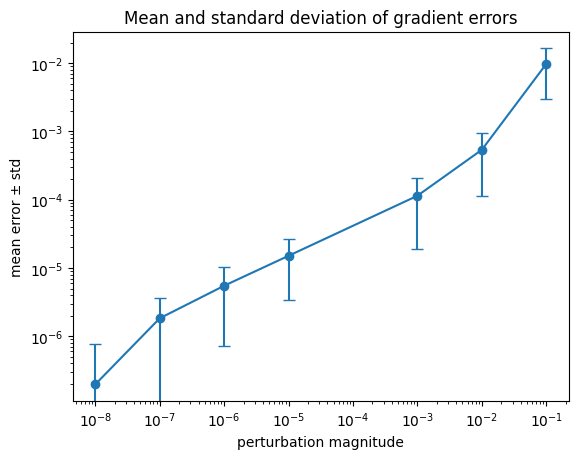

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# 假设你已经有以下六个 (n,2) 数组，取绝对值后关注第 1 维
arrays = {
    1e-8: np.abs(grad_array_e8[:,0]),
    1e-7: np.abs(grad_array_e7[:,0]),
    1e-6: np.abs(grad_array_e6[:,0]),
    1e-5: np.abs(grad_array_e5[:,0]),
    1e-3: np.abs(grad_array_e3[:,0]),
    1e-2: np.abs(grad_array_e2[:,0]),
    1e-1: np.abs(grad_array_e1[:,0]),
}

# 计算每个扰动下的均值和标准差
perturbations = sorted(arrays.keys())
means = [arrays[p].mean() for p in perturbations]
stds  = [arrays[p].std()  for p in perturbations]

fig, ax = plt.subplots()
ax.errorbar(
    perturbations, means, yerr=stds,
    marker='o', linestyle='-',
    capsize=4
)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('perturbation magnitude')
ax.set_ylabel('mean error ± std')
ax.set_title('Mean and standard deviation of gradient errors')
plt.show()


In [ ]:
# 保存数据
import pickle

data_to_save = {
    "grad_array_e8": grad_array_e8,
    "grad_array_e7": grad_array_e7,
    "grad_array_e6": grad_array_e6,
    "grad_array_e5": grad_array_e5,
    "grad_array_e3": grad_array_e3,
    "grad_array_e2": grad_array_e2,
    "grad_array_e1": grad_array_e1,
}

with open('net_292_stability_data.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)


In [69]:
feature1 = 40
feature2 = 15

class FieldNet(nn.Module):
    @nn.compact
    def __call__(self, d: jnp.ndarray, u: jnp.ndarray):
        # d: (2,)     u: (51,51)
        # Embed d → (features_d,)
        features_d = nn.Dense(features=feature1)(d)        # (128,)
        features_d = nn.relu(features_d)
        features_d = nn.Dense(features=feature1)(features_d)        # (128,)
        features_d = nn.relu(features_d)
        # Broadcast to spatial grid → (51,51,128)
        bd = jnp.broadcast_to(features_d, (51,51,feature1))

        # Expand u to have a channel axis → (51,51,1)
        u_in = u[..., None]

        # Concatenate along channels → (51,51,129)
        x = jnp.concatenate([u_in, bd], axis=-1)

        # Several Conv layers
        x = nn.Conv(features=feature2, kernel_size=(3,3), padding='SAME')(x)
        x = nn.relu(x)
        x = nn.Conv(features=feature2, kernel_size=(3,3), padding='SAME')(x)
        x = nn.relu(x)
        x = nn.Conv(features=feature2, kernel_size=(3,3), padding='SAME')(x)
        x = nn.relu(x)
        x = nn.Conv(features=1,  kernel_size=(3,3), padding='SAME')(x)

        # Squeeze channel and sigmoid to [0,1]
        x = x[..., 0]
        x = nn.sigmoid(x)  # output shape (51,51), values in (0,1)
        return x

# 创建模型实例
model = FieldNet()

# 随机初始化参数
rng = random.PRNGKey(42)
rng_true = random.PRNGKey(2025)
dummy_d = jnp.zeros((2,))
dummy_u = jnp.zeros((51,51))
params = model.init(rng, dummy_d, dummy_u)
params_true = model.init(rng_true, dummy_d, dummy_u)

# 查看参数结构（可以打印一部分来验证）
import pprint
pprint.pprint({k: {sub: v.shape for sub, v in params['params'][k].items()} 
               for k in params['params']})

print('network parameter dimension', reconstruct_dict_to_array(params).shape)

    
def forward_model(d, center, model, params):
    u_new = model.apply(params, center, u_initial)
    i = d[0]*50
    j = d[1]*50
    data_fin=jax.scipy.ndimage.map_coordinates(u_new,[i,j],1)
    return data_fin, u_new

{'Conv_0': {'bias': (15,), 'kernel': (3, 3, 41, 15)},
 'Conv_1': {'bias': (15,), 'kernel': (3, 3, 15, 15)},
 'Conv_2': {'bias': (15,), 'kernel': (3, 3, 15, 15)},
 'Conv_3': {'bias': (1,), 'kernel': (3, 3, 15, 1)},
 'Dense_0': {'bias': (40,), 'kernel': (2, 40)},
 'Dense_1': {'bias': (40,), 'kernel': (40, 40)}}
network parameter dimension (11526,)


In [70]:
key = random.PRNGKey(2019)
ensemble_size = 13000
mean_array = reconstruct_dict_to_array(params)
eki_noise_level = 0.05
std_dev = 0.3
stage = None

for j in range(6):
    additional_noise = [1e-1,1e-3,1e-5,1e-6,1e-7,1e-8,1e-2][j]
    grad_test_list = []
    for i in range(20):
        key, _ = random.split(key)
        key_for_param = random.split(key,4+ensemble_size)
    
        center = random.uniform(key_for_param[i], (2,))
        estimated_center = random.uniform(key_for_param[i+1], (2,))
        d = random.uniform(key_for_param[i+2], (2,))
        #center = jnp.array([0.25, 0.25])
        #estimated_center = jnp.array([0.2, 0.5])
        #d = jnp.array([0.3, 0.3])
        
        ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
        initial_mu = jnp.mean(ensemble_members_array,axis=0)
        initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
        grad_clean = jax.grad(loss_function_stability3)(d_start, center, estimated_center, eki_noise_level)
    
        
        ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_for_param[4:], mean_array, std_dev)
        ensemble_members_array = ensemble_members_array * (1+jax.random.normal(key_for_param[i], ensemble_members_array.shape)*additional_noise)
        initial_mu = jnp.mean(ensemble_members_array,axis=0)
        initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
        grad_perturb = jax.grad(loss_function_stability3)(d_start, center, estimated_center, eki_noise_level)
        grad_error = (grad_clean - grad_perturb) / grad_clean
        #print(f'additional_noise {additional_noise}, grad_clean {grad_clean}, grad_perturb {grad_perturb}, grad error {grad_error}')
        grad_test_list.append(grad_error)

    if j == 0:
        grad_array_e1 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 1:
        grad_array_e3 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 2:
        grad_array_e5 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 3:
        grad_array_e6 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 4:
        grad_array_e7 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 5:
        grad_array_e8 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')
    if j == 6:
        grad_array_e2 = jnp.abs(jnp.array(grad_test_list))
        print(f'perturb {j}')

    
        

perturb 0
perturb 1
perturb 2
perturb 3
perturb 4
perturb 5


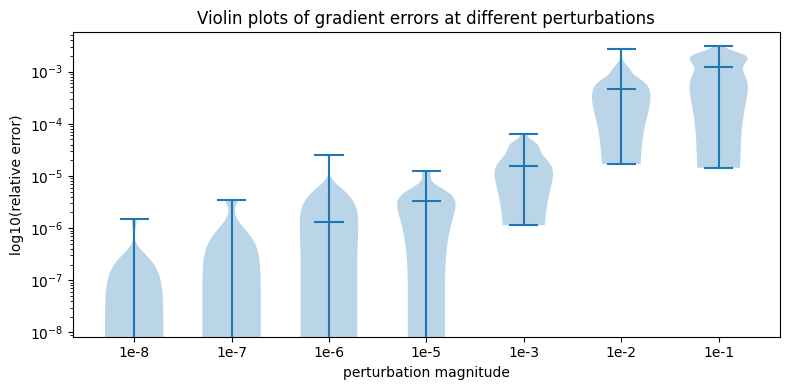

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# 假设这六个数组的 shape 都是 (n,2)，先提取第 1 维并取绝对值
data_e8 = grad_array_e8[:, 0]
data_e7 = grad_array_e7[:, 0]
data_e6 = grad_array_e6[:, 0]
data_e5 = grad_array_e5[:, 0]
data_e3 = grad_array_e3[:, 0]
data_e2 = grad_array_e2[:, 0]
data_e1 = grad_array_e1[:, 0]

# 对误差做 log10 变换
logs = [
    data_e8,
    data_e7,
    data_e6,
    data_e5,
    data_e3,
    data_e2,
    data_e1,
]

# x 轴位置和对应标签
positions = np.arange(1, len(logs) + 1)
labels = ['1e-8', '1e-7', '1e-6', '1e-5', '1e-3', '1e-2', '1e-1']

fig, ax = plt.subplots(figsize=(8,4))
# 画小提琴图
parts = ax.violinplot(
    logs,
    positions=positions,
    showmedians=True,
    widths=0.6
)

# 美化——设置刻度和标签
ax.set_xticks(positions)
ax.set_xticklabels(labels)
ax.set_xlabel('perturbation magnitude')
ax.set_ylabel('log10(relative error)')
ax.set_yscale('log')
ax.set_title('Violin plots of gradient errors at different perturbations')


plt.tight_layout()
plt.show()


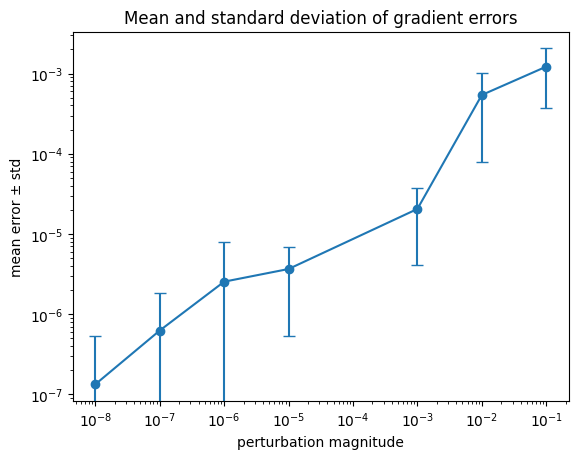

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# 假设你已经有以下六个 (n,2) 数组，取绝对值后关注第 1 维
arrays = {
    1e-8: np.abs(grad_array_e8[:,0]),
    1e-7: np.abs(grad_array_e7[:,0]),
    1e-6: np.abs(grad_array_e6[:,0]),
    1e-5: np.abs(grad_array_e5[:,0]),
    1e-3: np.abs(grad_array_e3[:,0]),
    1e-2: np.abs(grad_array_e2[:,0]),
    1e-1: np.abs(grad_array_e1[:,0]),
}

# 计算每个扰动下的均值和标准差
perturbations = sorted(arrays.keys())
means = [arrays[p].mean() for p in perturbations]
stds  = [arrays[p].std()  for p in perturbations]

fig, ax = plt.subplots()
ax.errorbar(
    perturbations, means, yerr=stds,
    marker='o', linestyle='-',
    capsize=4
)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('perturbation magnitude')
ax.set_ylabel('mean error ± std')
ax.set_title('Mean and standard deviation of gradient errors')
plt.show()


# 增加网络层数，结果比较类似

# 以前的代码

In [12]:
def EnKF_process_fixCenter_perturbed(d_start, center, observation, ensemble_member, stage, key_ensemble, model, noise_level_eki, inflation_factor=1.0, step_size=0.5):
    # 进行一次EnKF更新
    
    ensemble_size_local = ensemble_member.shape[0]
    
    y_fs = vmap_predict_y_f(d_start, center, model, ensemble_member)
    #y_fs = vmap_predict_y_f(d_start, center, stage, ensemble_member)

    # 确保 y_fs 的形状和原代码一致，即 (ensemble_size_local, 1)
    y_fs = y_fs.reshape((ensemble_size_local, 1)) 
    y_fs = y_fs + jax.random.normal(key_ensemble, y_fs.shape) * noise_level_eki
    
    y_f_mean = jnp.mean(y_fs)
    P_yy = 1/(ensemble_size_local-1)*jnp.sum((y_fs-y_f_mean)**2) + noise_level_eki**2  #noise_base_scale

    x_f_theta = ensemble_member.reshape(ensemble_size_local,-1)
    x_f_mean = jnp.mean(x_f_theta, axis=0).reshape(1,-1)

    x_f_deviation = x_f_theta - x_f_mean
    y_f_deviation = y_fs - y_f_mean.reshape(1,1)
    P_xy = jnp.matmul(x_f_deviation.T, y_f_deviation) / (ensemble_size_local - 1) 

    K = P_xy * 1.0/P_yy
    x_a = x_f_theta + step_size*jnp.matmul(K, (observation - y_fs).T).T
    
    x_a_mean = np.mean(x_a, axis=0)
    x_a = x_a_mean + inflation_factor * (x_a - x_a_mean) # 膨胀因子
    
    theta_samples_updated = x_a[:, -1]
    return theta_samples_updated


#stage = 0
#ensemble_params = jnp.linspace(1,4,10)
#observation, _ = sealed_convection_diffusion_exp_parametic(d_start, center, stage, theta_true)

def calculate_kld(mu1, sigma1, mu2, sigma2):
    '''
    sigma1, sigma2: std rather than variance
    '''
    kld = jnp.log(sigma2 / sigma1) + (sigma1**2 + (mu1 - mu2) ** 2) / (2 * sigma2**2) - 0.5
    return kld

@jax.jit
def w2_gaussian(mu1, cov1, mu2, cov2):
    delta2 = jnp.sum((mu1 - mu2)**2)
    # cov2^(1/2)
    w2, v2 = jnp.linalg.eigh(cov2)
    sqrt2 = (v2 * jnp.sqrt(jnp.clip(w2,0))) @ v2.T
    inner = sqrt2 @ cov1 @ sqrt2
    w3, v3 = jnp.linalg.eigh(inner)
    sqrt3 = (v3 * jnp.sqrt(jnp.clip(w3,0))) @ v3.T
    trace_term = jnp.trace(cov1 + cov2 - 2*sqrt3)
    return jnp.sqrt(delta2 + trace_term)

# 定义 loss_function2，将不变参数设为静态，仅对 d_start 求导
def loss_function2(d_start, center, estimated_center, noise_level_eki):
    initial_mu = jnp.mean(ensemble_params)
    initial_sigma = jnp.std(ensemble_params)
    y_fs = ensemble_params
    
    #observation_local, _ = sealed_convection_diffusion_exp_parametic(d_start, center, stage, theta_true)
    observation_local, _ = sealed_convection_diffusion_true(d_start, center, stage)
    
    # 固定所有不变参数，仅让 d_start 动态变化
    def body(i, y_fs):
        #return checkpoint(EnKF_process_fixCenter, static_argnums=(1, 2, 4, 5, 6, 7))(d_start, estimated_center, observation_local, y_fs, stage, noise_level_eki, inflation_factor, step_size)
        return checkpoint(EnKF_process_fixCenter_perturbed, static_argnums=(1, 2, 4, 5, 7, 8, 9))(d_start, estimated_center, observation_local, 
                                                                                               y_fs, stage, key_for_param[i+5], model, noise_level_eki, inflation_factor, step_size)
    
    # 使用 fori_loop 进行循环，不保存中间结果
    y_fs = jax.lax.fori_loop(0, 3, body, y_fs)

    updated_mu = jnp.mean(y_fs)
    updated_sigma = jnp.std(y_fs)

    return -calculate_kld(updated_mu, updated_sigma, initial_mu,initial_sigma)

In [9]:
key_ensemble_pass, key_ensemble_pass_sub = random.split(key_ensemble_pass)
key_ensemble = random.split(key_ensemble_pass_sub,ensemble_size)
ensemble_params = jax.vmap(generate_sample, in_axes=(0, None, None))(key_ensemble, mean_array, std_dev)

initial_mu = jnp.mean(ensemble_params,axis=0)
initial_sigma = jnp.cov(ensemble_params, rowvar=False)
negtive_KLD, grad_design = jax.value_and_grad(loss_function2)(d_start_MEC, center, estimated_center, 0.0002) # 实际

NameError: name 'sealed_convection_diffusion_exp_parametic' is not defined

In [13]:
jax.value_and_grad(loss_function2)(d_start_MEC, center, estimated_center, 0.0002)

TypeError: Cannot interpret value of type <class '__main__.localFullyConnectedNN2'> as an abstract array; it does not have a dtype attribute

In [10]:
# 保存数据
import pickle

numpy_list = [np.array(arr) for arr in posterior_list]
data_to_save = {
    "posterior_list": numpy_list,
    "posterior_oed_list": posterior_oed_list,
    "design_list": design_list,
    "params_list": params_list,
    "estimated_posterior_point": estimated_posterior_point,
    "design_MEC_trajectory": design_MEC_trajectory,
    
    "actual_step": actual_step,
    "design_MEC_list": design_MEC_list,
    "observation_MEC_list": observation_MEC_list
}

with open('all_data_nn_case_seed_2019_truePhy_trueNet_test10_changeCenter0.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

In [ ]:
运行0，1，保存0
读取0，运行2，保存1
读取1，运行3，保存2
读取2，运行4，保存3
读取3，运行5，保存4

In [34]:
def log_transform_prior(prior_matrix, epsilon=1e-6, alpha=0.5):
    """
    Apply a log transformation to a prior weight matrix to reduce high weights and amplify low weights,
    while preserving some of the original weight relationships.

    Args:
        prior_matrix (jax.numpy.ndarray): A 2D matrix representing prior weights.
        epsilon (float): A small value to ensure numerical stability for log computation.
        alpha (float): A mixing parameter (0 < alpha <= 1) to control the balance between original and transformed weights.

    Returns:
        jax.numpy.ndarray: A 2D matrix of transformed weights, normalized to sum to 1.
    """
    # Ensure all weights are positive by adding epsilon
    adjusted_prior = prior_matrix + epsilon

    # Apply the log transformation
    log_transformed = -jnp.log(adjusted_prior)

    # Normalize the log-transformed weights
    log_transformed_normalized = log_transformed / jnp.sum(log_transformed)

    # Normalize the original weights
    original_normalized = adjusted_prior / jnp.sum(adjusted_prior)

    # Combine the original and log-transformed weights
    mixed_weights = alpha * log_transformed_normalized + (1 - alpha) * original_normalized

    # Normalize the mixed weights to sum to 1
    final_weights = mixed_weights / jnp.sum(mixed_weights)

    return final_weights

stage_to_test = 1
prior = log_transform_prior(posterior_list[stage_to_test], epsilon=1e-6, alpha=0.9)

In [23]:
design_MEC_list

[Array([0.43989843, 0.24300766], dtype=float32),
 Array([0.270379 , 0.3145537], dtype=float32),
 Array([ 0.8329992 , -0.17412007], dtype=float32),
 Array([0.1606071 , 0.25744933], dtype=float32),
 Array([0.20698306, 0.21951488], dtype=float32)]

In [25]:
design_MEC_list[:1]

[Array([0.43989843, 0.24300766], dtype=float32)]

In [27]:
stage = 2

design_MEC_list = design_MEC_list[:(stage-1)]
design_MEC_list 

[Array([0.43989843, 0.24300766], dtype=float32)]

In [ ]:
# 写一段代码，调整correction oed的学习率

design_MEC_trajectory_special = []
KLD_MEC_list_special = []

for stage in [5]:
    
    print('\n stage = ', stage, '\n')
    key_for_design = random.split(key[stage*2],iteration_step_number1[stage])
    key_for_param = random.split(key[stage*2+1],(iteration_step_number2[stage]+1))
    
    d_start = design_list[stage+1]
    estimated_center = estimated_posterior_point[stage]
    params = params_list[stage-1]
    design_MEC_list = design_MEC_list[:(stage-1)]
    observation_MEC_list = observation_MEC_list[:(stage-1)]

    start_time = time.time()
    print(f'design from OED is {d_start}')
    ensemble_size = 40

    std_dev = 0.3
    mean_array = reconstruct_dict_to_array(params)
    params_dimension = len(mean_array)



    observation, _ = sealed_convection_diffusion_true(d_start, center, stage)
    d_start_MEC = d_start 
    print(f'start design : ', d_start_MEC)
    print('observation of start design = ', observation)
    #print('initial ensemble var = ', jnp.trace(initial_sigma))

    # 设置优化器
    try:
        del tx2
        del opt_state2
    except NameError:
        pass
    
    tx2 = optax.chain(
        optax.adam(0.024),#learning_rate2[stage]),  # 使用由 lr_schedule1 调整的学习率的 Adam 优化器
        #optax.add_decayed_weights(1e-4)  # 添加权重衰减，衰减系数为 1e-5
    )
    
    opt_state2 = tx2.init(d_start_MEC)
    
    d_limit_min = d_start_MEC - d_change_range_MEC
    d_limit_max = d_start_MEC + d_change_range_MEC

    print('start learning design')

    clip_count = 0
    
    noise_level_eki = 5e-5
    key_ensemble_pass = key_for_param[-1]
    
    for i in range(70):
        key_ensemble_pass, key_ensemble_pass_sub = random.split(key_ensemble_pass)
        key_ensemble = random.split(key_ensemble_pass_sub,ensemble_size)
        ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_ensemble, mean_array, std_dev)
        
        initial_mu = jnp.mean(ensemble_members_array,axis=0)
        initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    
        negtive_KLD, grad_design = jax.value_and_grad(loss_function5)(d_start_MEC, center, estimated_center, 0.0002)
        updates, opt_state2 = tx2.update(grad_design, opt_state2, params=d_start_MEC)
        
        d_start_MEC = optax.apply_updates(d_start_MEC, updates)
    

        d_start_before_clip = d_start_MEC
        d_start_MEC = jnp.clip(d_start_MEC, d_limit_min, d_limit_max)
        design_MEC_trajectory_special.append(d_start_MEC)
        
        # 如果clip函数生效，即有参数被裁剪，增加计数器
        if not jnp.all(d_start_MEC == d_start_before_clip):
            clip_count += 1
        
        if clip_count >= 5:
            print(f"Stopping iteration at step {i} as clip function has been activated 5 times.")
            actual_step.append(i+1)
            break
            
        if isinstance(negtive_KLD, (list, tuple)):
            KLD_MEC_list_special.append(-negtive_KLD[0])  # 如果是列表或元组，取第一个元素
        else:
            KLD_MEC_list_special.append(-negtive_KLD)     # 如果是标量，直接使用

        if i == 69:
            actual_step.append(i+1)

        print('.',end='')

    print('\n')
    print('updated design : ', d_start_MEC)

    # 用新的design重新测量
    
    observation, _ = sealed_convection_diffusion_true(d_start_MEC, center, stage)
    print('observation of updated design = ', observation)
    design_MEC_list.append(d_start_MEC)
    observation_MEC_list.append(observation)
    
    try:
        del tx2
        del opt_state2
    except NameError:
        pass
    
    
    print(f'design for model correction is {d_start_MEC}')
    end_time = time.time()
    print(f"Execution finding design for model correction time: {end_time - start_time} seconds")
    

IndexError: index 31 is out of bounds for axis 0 with size 31

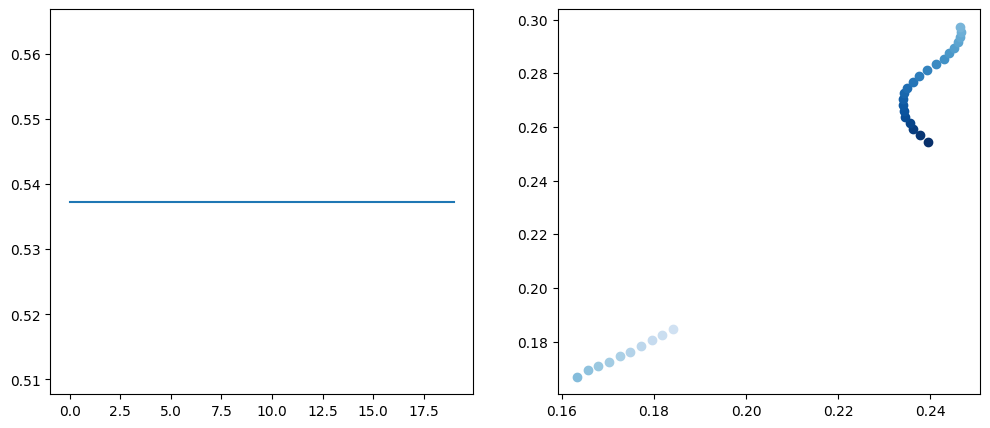

In [11]:
fig,axes = plt.subplots(1,2,figsize=(12,5))
axes[0].plot(KLD_MEC_list)#_special)

colors = plt.cm.Blues(np.linspace(1.0, 0.2, 31))
for i in range(len(design_MEC_trajectory)):#_special)):
    axes[1].scatter(design_MEC_trajectory[i][0], #_special[i][0], 
               design_MEC_trajectory[i][1], #_special[i][1], 
               color=colors[i])




In [22]:
design_MEC_trajectory

[Array([0.21781643, 0.2760184 ], dtype=float32),
 Array([0.22641283, 0.2994279 ], dtype=float32),
 Array([0.23780702, 0.32008472], dtype=float32),
 Array([0.25284967, 0.33572298], dtype=float32),
 Array([0.25914142, 0.34843343], dtype=float32),
 Array([0.26480266, 0.35876155], dtype=float32),
 Array([0.266647  , 0.36638924], dtype=float32),
 Array([0.26711875, 0.37202585], dtype=float32),
 Array([0.2647189, 0.3765721], dtype=float32),
 Array([0.26228422, 0.37880728], dtype=float32),
 Array([0.25894466, 0.37887043], dtype=float32),
 Array([0.25723824, 0.37661627], dtype=float32),
 Array([0.25897485, 0.37275648], dtype=float32),
 Array([0.2611823 , 0.36663178], dtype=float32),
 Array([0.26412207, 0.35827878], dtype=float32),
 Array([0.26288852, 0.35009396], dtype=float32),
 Array([0.26025522, 0.34077537], dtype=float32),
 Array([0.25513119, 0.33109647], dtype=float32),
 Array([0.24997242, 0.32141003], dtype=float32),
 Array([0.2435212 , 0.31210998], dtype=float32),
 Array([0.23367366, 0.

In [28]:
design_MEC_list = design_MEC_list[:(stage-1)]
observation_MEC_list = observation_MEC_list[:(stage-1)]
d_tem = jnp.array([0.25894466, 0.37887043])
design_MEC_list.append(d_tem)
observation, _ = sealed_convection_diffusion_true(d_tem, center, stage)
observation_MEC_list.append(observation)

In [29]:
design_MEC_list

[Array([0.25894466, 0.37887043], dtype=float32)]

In [30]:
# 调整网络参数的学习率
evidence_list_special = []
NN_error_list_special = []

for stage in [1]:
    print('\n stage = ', stage, '\n')
    key_for_design = random.split(key[stage*2],iteration_step_number1[stage])
    key_for_param = random.split(key[stage*2+1],(iteration_step_number2[stage]+1))
    
    prior = posterior_oed_list[stage]
    params = params_list[stage-1]
    estimated_center = estimated_posterior_point[stage]
    
    # 使用梯度下降法进行model correction
    start_time = time.time()
    try:
        del tx3
        del opt_state3
    except NameError:
        pass
        
    tx3 = optax.adam(learning_rate3[stage])#0.002)#learning_rate2[stage])#learning_rate3[stage])#
    
    opt_state3 = tx3.init(params)
    design_MEC_array = jnp.array(design_MEC_list)
    observation_MEC_array = jnp.array(observation_MEC_list)
    stage_count_array = jnp.arange(1,stage+1)

    print('start learning params')
    for i in range(iteration_step_number2[stage]):
        if stage in stage_to_skip:
            print(f'stage {stage} dont learn error parameters')
            break
        
        #observation_perturbed =  observation + 0.003 * jax.random.normal(key_for_param[i], observation.shape) * (80-i)/80
        estimated_center_perturbed = estimated_center + 0.05 * jax.random.normal(key_for_param[i], estimated_center.shape)*jnp.exp(-0.04*i)#* (80-i)/80
        #max_evidence_items, grad_params = jax.value_and_grad(loss_param_refine5)(params, d_start_MEC, stage, estimated_center_perturbed, model, observation)
        max_evidence_items, grad_params = jax.value_and_grad(loss_param_refine6)(params, design_MEC_array, stage_count_array, estimated_center_perturbed, observation_MEC_array)
    
        clip_norm = 1e10
        clip_transform = optax.clip_by_global_norm(clip_norm)
        clipped_grads, _ = clip_transform.update(grad_params, state=None)
        
        updates, opt_state3 = tx3.update(clipped_grads, opt_state3, params=params)
        
        # 解决nan的问题
        updates_contain_nans = any(jnp.any(jnp.isnan(u)) for u in jax.tree_util.tree_leaves(updates))
        if updates_contain_nans:
            print('NaN appears in learning. Perturb params and continue.')
            noise = jax.tree_util.tree_map(lambda p: 0.01 * jax.random.normal(key_for_param[i], p.shape), params)
            params = jax.tree_util.tree_map(lambda p, n: p + n, params, noise)
        else:
            params = optax.apply_updates(params, updates)
            
        net_accuracy = evaluate_nn_accuracy(params,model,center,local_size)
        
        if np.isnan((max_evidence_items, net_accuracy)).any():
            print('some results are Nan')
            break
            
        evidence_list_special.append(-max_evidence_items)
        NN_error_list_special.append(net_accuracy)
        print('.',end='')

        
    params_list.append(params)
    
    end_time = time.time()
    print(f"Execution learning param time: {end_time - start_time} seconds")

    #if stage not in stage_to_skip:
    #    _, posterior = forward_posterior_infoGain(params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], model)
    #    if stage!=0:
    #         del prior
    #    prior = posterior
  

    if stage > 0:
        prior =  prior_ori/jnp.sum(prior_ori)
        for jjj in range(len(design_list[:(stage+2)])-1):
            _, posterior = forward_posterior_infoGain(params, design_list[:(stage+2)][jjj+1], jjj, center, prior, noise_info, num_d, radio_d, key[stage], model)
            del prior
            prior = posterior


 stage =  1 

start learning params
................................................................................Execution learning param time: 101.19213199615479 seconds


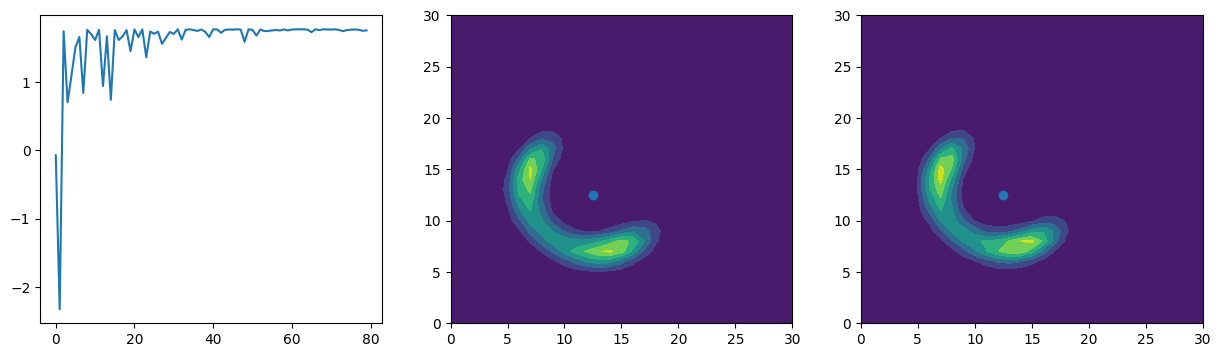

In [31]:
fig,axes = plt.subplots(1,3,figsize=(15,4))
axes[0].plot(evidence_list_special)
axes[1].contourf(posterior.T)
axes[1].set_xlim([0,30])
axes[1].set_ylim([0,30])
axes[1].scatter(center[0]*50,center[1]*50)
axes[2].contourf(posterior_oed_list[stage].T)
axes[2].set_xlim([0,30])
axes[2].set_ylim([0,30])
axes[2].scatter(center[0]*50,center[1]*50)

In [26]:
posterior[12,12], posterior_list[stage][12,12],posterior[13,13], posterior_list[stage][13,13]

(Array(6.7443834e-06, dtype=float32),
 Array(6.7443834e-06, dtype=float32),
 Array(7.8635173e-07, dtype=float32),
 Array(7.8635173e-07, dtype=float32))

In [32]:
num_top=1
indices = jnp.argpartition(posterior.ravel(), -num_top)[-num_top:]
multi_indices = jnp.unravel_index(indices, posterior.shape)

average_x = int(jnp.mean(multi_indices[0]))
average_y = int(jnp.mean(multi_indices[1]))

# 定义 5x5 的范围
x_range = jnp.arange(max(0, average_x - 2), min(posterior.shape[0], average_x + 3))
y_range = jnp.arange(max(0, average_y - 2), min(posterior.shape[1], average_y + 3))

# 获取5x5的网格点
x_grid, y_grid = jnp.meshgrid(x_range, y_range, indexing='ij')
x_grid_flat = x_grid.ravel()
y_grid_flat = y_grid.ravel()

# 提取对应的 posterior 值
grid_points = jnp.stack((x_grid_flat, y_grid_flat), axis=-1)
grid_values = posterior[x_grid_flat, y_grid_flat]

# 插值：创建细化的网格以提升精度
fine_x = jnp.linspace(x_range.min(), x_range.max(), 50)
fine_y = jnp.linspace(y_range.min(), y_range.max(), 50)
fine_x_grid, fine_y_grid = jnp.meshgrid(fine_x, fine_y, indexing='ij')
fine_points = jnp.stack((fine_x_grid.ravel(), fine_y_grid.ravel()), axis=-1)

interpolated_values = griddata(grid_points, grid_values, fine_points, method='cubic')
interpolated_values = interpolated_values.reshape(fine_x_grid.shape)

# 找到插值后最大值的坐标
max_index = jnp.unravel_index(jnp.argmax(interpolated_values), interpolated_values.shape)
max_x, max_y = fine_x_grid[max_index], fine_y_grid[max_index]

# 输出新的估计中心
estimated_center_post1 = jnp.array([max_x, max_y]) / 50
print('new ', estimated_center_post1)

num_top=1
indices = jnp.argpartition(posterior_list[stage].ravel(), -num_top)[-num_top:]
multi_indices = jnp.unravel_index(indices, posterior.shape)

average_x = int(jnp.mean(multi_indices[0]))
average_y = int(jnp.mean(multi_indices[1]))

# 定义 5x5 的范围
x_range = jnp.arange(max(0, average_x - 2), min(posterior.shape[0], average_x + 3))
y_range = jnp.arange(max(0, average_y - 2), min(posterior.shape[1], average_y + 3))

# 获取5x5的网格点
x_grid, y_grid = jnp.meshgrid(x_range, y_range, indexing='ij')
x_grid_flat = x_grid.ravel()
y_grid_flat = y_grid.ravel()

# 提取对应的 posterior 值
grid_points = jnp.stack((x_grid_flat, y_grid_flat), axis=-1)
grid_values = posterior_list[stage][x_grid_flat, y_grid_flat]

# 插值：创建细化的网格以提升精度
fine_x = jnp.linspace(x_range.min(), x_range.max(), 50)
fine_y = jnp.linspace(y_range.min(), y_range.max(), 50)
fine_x_grid, fine_y_grid = jnp.meshgrid(fine_x, fine_y, indexing='ij')
fine_points = jnp.stack((fine_x_grid.ravel(), fine_y_grid.ravel()), axis=-1)

interpolated_values = griddata(grid_points, grid_values, fine_points, method='cubic')
interpolated_values = interpolated_values.reshape(fine_x_grid.shape)

# 找到插值后最大值的坐标
max_index = jnp.unravel_index(jnp.argmax(interpolated_values), interpolated_values.shape)
max_x, max_y = fine_x_grid[max_index], fine_y_grid[max_index]

# 输出新的估计中心
estimated_center_post2 = jnp.array([max_x, max_y]) / 50
print('ori ', estimated_center_post2)

new  [0.13918367 0.29428568]
ori  [0.28081632 0.14081632]


In [32]:
np.sqrt(np.sum((estimated_center_post1 - center)**2))

0.032730803

In [12]:
 xc/50, yc/50

(Array(2.241817, dtype=float32), Array(2.2520177, dtype=float32))

In [12]:
for stage in [2]:
    print('stage = ', stage)
    estimated_center = estimated_posterior_point[stage]
    
    u_t = sealed_convection_diffusion_true(d_start, center, stage)[1][100:151,100:151]
    u_design_5 = sealed_convection_diffusion_nn(params_list[stage-1], d_start, center, stage, model)[1][100:151,100:151]
    u_design_7 = sealed_convection_diffusion_nn(params_list[stage], d_start, center, stage, model)[1][100:151,100:151]
    u_design_8 = sealed_convection_diffusion_nn(params, d_start, center, stage, model)[1][100:151,100:151]
    print('Total MSE: ', np.sum((u_t - u_design_5)**2),',',np.sum((u_t - u_design_7)**2),',',np.sum((u_t - u_design_8)**2))
    print('Total MSE: ', np.sum((u_t - u_design_5)**2)/51,',',np.sum((u_t - u_design_7)**2)/51,',',np.sum((u_t - u_design_8)**2)/51)
    print('Total RE: ', np.sum(np.abs(u_t - u_design_5))/np.sum(np.abs(u_t)),',',np.sum(np.abs(u_t - u_design_7))/np.sum(np.abs(u_t)),',',np.sum(np.abs(u_t - u_design_8))/np.sum(np.abs(u_t)))
    
    #u_t = sealed_convection_diffusion_true(d_start, center, stage)[1][110:115,110:115]
    #u_design_6 = sealed_convection_diffusion_nn(params_list[stage-1], d_start, center, stage, model)[1][110:115,110:115]
    #u_design_8 = sealed_convection_diffusion_nn(params_list[stage], d_start, center, stage, model)[1][110:115,110:115]
    #print('Center MSE: ', np.sum((u_t - u_design_6)**2),np.sum((u_t - u_design_8)**2))

    xc, yc =design_list[stage+1]*50+100
    range_xy = 2
    u_t = sealed_convection_diffusion_true(d_start, center, stage)[1][(int(xc)-range_xy):(int(xc)+range_xy),(int(yc)-range_xy):(int(yc)+range_xy)]
    u_design_6 = sealed_convection_diffusion_nn(params_list[stage-1], d_start, center, stage, model)[1][(int(xc)-range_xy):(int(xc)+range_xy),(int(yc)-range_xy):(int(yc)+range_xy)]
    u_design_8 = sealed_convection_diffusion_nn(params_list[stage], d_start, center, stage, model)[1][(int(xc)-range_xy):(int(xc)+range_xy),(int(yc)-range_xy):(int(yc)+range_xy)]
    u_design_9 = sealed_convection_diffusion_nn(params, d_start, center, stage, model)[1][(int(xc)-range_xy):(int(xc)+range_xy),(int(yc)-range_xy):(int(yc)+range_xy)]
    print('Design MSE: ', np.sum((u_t - u_design_6)**2)/5,',',np.sum((u_t - u_design_8)**2)/5,',',np.sum((u_t - u_design_9)**2)/5)
    print('Design RE: ', np.sum(np.abs(u_t - u_design_6))/np.sum(np.abs(u_t)),',',np.sum(np.abs(u_t - u_design_8))/np.sum(np.abs(u_t)),',',np.sum(np.abs(u_t - u_design_9))/np.sum(np.abs(u_t)))

    d_start=design_list[stage+1]
    u_t = sealed_convection_diffusion_true(d_start, center, stage)[0]
    u_design_6 = sealed_convection_diffusion_nn(params_list[stage-1], d_start, center, stage, model)[0]
    u_design_8 = sealed_convection_diffusion_nn(params_list[stage], d_start, center, stage, model)[0]
    u_design_9 = sealed_convection_diffusion_nn(params, d_start, center, stage, model)[0]
    print('Design MSE: ', np.sum((u_t - u_design_6)**2)/5,',',np.sum((u_t - u_design_8)**2)/5,',',np.sum((u_t - u_design_9)**2)/5)
    print('Design RE: ', np.sum(np.abs(u_t - u_design_6))/np.sum(np.abs(u_t)),',',np.sum(np.abs(u_t - u_design_8))/np.sum(np.abs(u_t)),',',np.sum(np.abs(u_t - u_design_9))/np.sum(np.abs(u_t)))


stage =  2
Total MSE:  21.811455 , 16.580257 , 16.580257
Total MSE:  0.4276756 , 0.3251031 , 0.3251031
Total RE:  0.57305485 , 0.5023855 , 0.5023855
Design MSE:  0.099127665 , 0.09323452 , 0.09323452
Design RE:  0.56275296 , 0.54632586 , 0.54632586
Design MSE:  0.007498165 , 0.0069739926 , 0.0069739926
Design RE:  0.55360335 , 0.53390247 , 0.53390247


In [36]:
np.max(posterior_list[stage_to_test]), np.max(prior), posterior_list[stage_to_test][12,12], prior[12,12]

(Array(0.03571777, dtype=float32),
 Array(0.00365065, dtype=float32),
 Array(1.6995751e-05, dtype=float32),
 Array(0.00029045, dtype=float32))

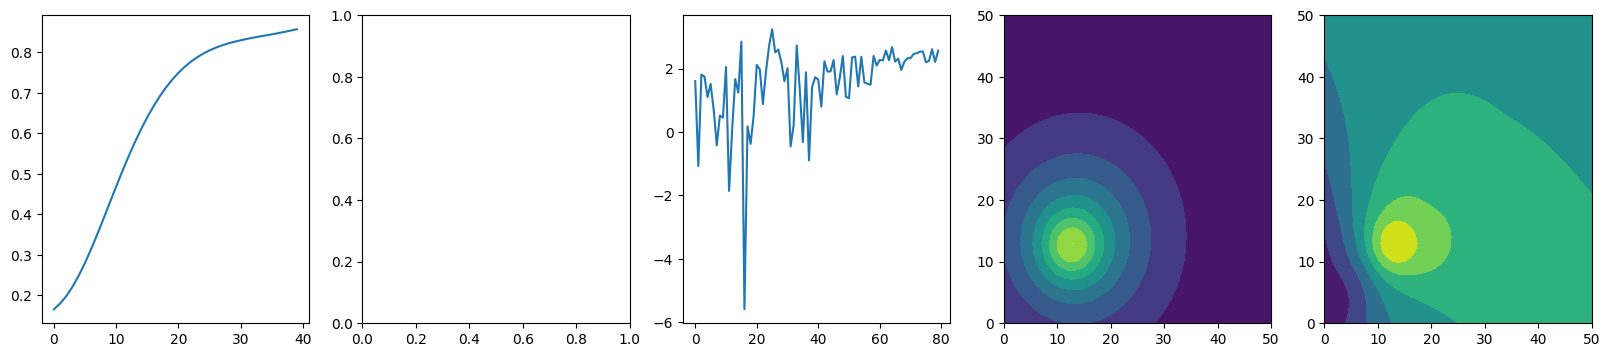

In [24]:
fig,axes=plt.subplots(1,5,figsize=(20,4))
axes[0].plot(KLD_list)

colors = plt.cm.Blues(np.linspace(1.0, 0.2, 100))

#for i in range(len(design_MEC_trajectory)):
#    axes[1].scatter(design_MEC_trajectory[i][0],design_MEC_trajectory[i][1],color=colors[i])

axes[2].plot(evidence_list)

axes[3].contourf(sealed_convection_diffusion_true(d_start, center, stage)[1][100:151,100:151])
axes[4].contourf(sealed_convection_diffusion_nn(params, d_start, center, stage, model)[1][100:151,100:151])

In [170]:
design_MEC_array

Array([[0.29972547, 0.15624546]], dtype=float32)

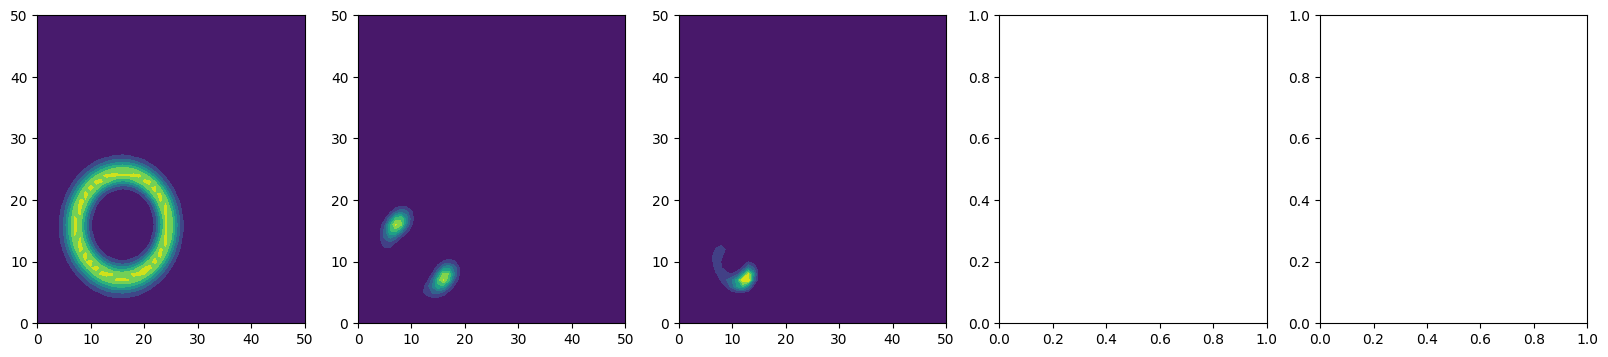

In [201]:
stage=1
fig,axes=plt.subplots(1,5,figsize=(20,4))
axes[0].contourf(posterior_list[stage-1].T)
axes[1].contourf(posterior_oed_list[stage].T)
axes[2].contourf(posterior_list[stage].T)

In [33]:
observation_MEC_list[1] = sealed_convection_diffusion_true(jnp.array([0.12,0.27]), center, stage)[0]
design_MEC_list, observation_MEC_list

([Array([0.29972547, 0.15624546], dtype=float32),
  Array([0.12, 0.27], dtype=float32)],
 [Array(0.3939374, dtype=float32), Array(0.3423139, dtype=float32)])

In [19]:
design_MEC_list

[Array([0.43400547, 0.2456034 ], dtype=float32),
 Array([0.20195755, 0.15085721], dtype=float32),
 Array([ 0.6028417 , -0.18041164], dtype=float32),
 Array([0.18627617, 0.27829355], dtype=float32),
 Array([0.06844676, 0.6795404 ], dtype=float32)]

In [8]:
# 调整model correction的学习率
evidence_list_special = []
NN_error_list_special = []


for stage in [5]:

    params = params_list[stage-1]
    d_start = design_MEC_list[stage-1]
    prior = posterior_oed_list[stage]
    estimated_center = estimated_posterior_point[stage]
    
    start_time = time.time()
    try:
        del tx3
        del opt_state3
    except NameError:
        pass
        
    tx3 = optax.adam(0.0012)#learning_rate2[stage])
    
    opt_state3 = tx3.init(params)
    
    design_MEC_array = jnp.array(design_MEC_list)
    observation_MEC_array = jnp.array(observation_MEC_list)
    stage_count_array = jnp.arange(1,stage+1)

    print('start learning params')
    for i in range(iteration_step_number2[stage]):
        if stage in stage_to_skip:
            print(f'stage {stage} dont learn error parameters')
            break
        
        #observation_perturbed =  observation + 0.003 * jax.random.normal(key_for_param[i], observation.shape) * (80-i)/80
        estimated_center_perturbed = estimated_center + 0.05 * jax.random.normal(key_for_param[i], estimated_center.shape)*jnp.exp(-0.04*i)#* (80-i)/80
        #max_evidence_items, grad_params = jax.value_and_grad(loss_param_refine5)(params, d_start_MEC, stage, estimated_center_perturbed, model, observation)
        max_evidence_items, grad_params = jax.value_and_grad(loss_param_refine6)(params, design_MEC_array, stage_count_array, estimated_center_perturbed, observation_MEC_array)
    
        clip_norm = 1e10
        clip_transform = optax.clip_by_global_norm(clip_norm)
        clipped_grads, _ = clip_transform.update(grad_params, state=None)
        
        updates, opt_state3 = tx3.update(clipped_grads, opt_state3, params=params)
        
        # 解决nan的问题
        updates_contain_nans = any(jnp.any(jnp.isnan(u)) for u in jax.tree_util.tree_leaves(updates))
        if updates_contain_nans:
            print('NaN appears in learning. Perturb params and continue.')
            noise = jax.tree_util.tree_map(lambda p: 0.01 * jax.random.normal(key_for_param[i], p.shape), params)
            params = jax.tree_util.tree_map(lambda p, n: p + n, params, noise)
        else:
            params = optax.apply_updates(params, updates)
            
        net_accuracy = evaluate_nn_accuracy(params,model,center,local_size)
        
        if np.isnan((max_evidence_items, net_accuracy)).any():
            print('some results are Nan')
            break
            
        evidence_list_special.append(-max_evidence_items)
        NN_error_list_special.append(net_accuracy)
        print('.',end='')

        
    #params_list.append(params)
    
    end_time = time.time()
    print(f"Execution learning param time: {end_time - start_time} seconds")

start learning params


NameError: name 'key_for_param' is not defined

In [14]:
params

{'params': {'Dense_0': {'bias': Array([-0.27927133, -0.16498373, -0.5649273 ,  0.7292584 ], dtype=float32),
   'kernel': Array([[ 4.542299 ,  3.923628 ,  8.352988 ,  9.387992 ],
          [-3.1170707,  4.9969606, -7.7588   , -9.172056 ]], dtype=float32)},
  'Dense_1': {'bias': Array([-0.20661715,  1.0243216 ,  1.4795947 ,  0.66933155], dtype=float32),
   'kernel': Array([[-0.9136928,  2.7309234,  3.1525393,  0.9034292],
          [-4.8366623,  5.0574403,  4.5333586,  4.761223 ],
          [-3.0694728,  3.7265067, -4.02041  , -5.3699055],
          [ 4.601531 , -3.5053754,  4.7192698,  3.6319945]], dtype=float32)},
  'Dense_2': {'bias': Array([-0.5869372], dtype=float32),
   'kernel': Array([[-10.830081],
          [ 10.275341],
          [-10.255032],
          [-10.804607]], dtype=float32)}}}

In [12]:
params

{'params': {'Dense_0': {'bias': Array([-0.27927133, -0.16498373, -0.5649273 ,  0.7292584 ], dtype=float32),
   'kernel': Array([[ 4.542299 ,  3.923628 ,  8.352988 ,  9.387992 ],
          [-3.1170707,  4.9969606, -7.7588   , -9.172056 ]], dtype=float32)},
  'Dense_1': {'bias': Array([-0.20661715,  1.0243216 ,  1.4795947 ,  0.66933155], dtype=float32),
   'kernel': Array([[-0.9136928,  2.7309234,  3.1525393,  0.9034292],
          [-4.8366623,  5.0574403,  4.5333586,  4.761223 ],
          [-3.0694728,  3.7265067, -4.02041  , -5.3699055],
          [ 4.601531 , -3.5053754,  4.7192698,  3.6319945]], dtype=float32)},
  'Dense_2': {'bias': Array([-0.5869372], dtype=float32),
   'kernel': Array([[-10.830081],
          [ 10.275341],
          [-10.255032],
          [-10.804607]], dtype=float32)}}}

In [35]:
for stage in [2]:
    print('stage = ', stage)
    estimated_center = estimated_posterior_point[stage]
    
    u_t = sealed_convection_diffusion_true(d_start, center, stage)[1][100:151,100:151]
    u_design_5 = sealed_convection_diffusion_nn(params_list[stage-1], d_start, center, stage, model)[1][100:151,100:151]
    u_design_7 = sealed_convection_diffusion_nn(params_list[stage], d_start, center, stage, model)[1][100:151,100:151]
    u_design_8 = sealed_convection_diffusion_nn(params, d_start, center, stage, model)[1][100:151,100:151]
    print('Total MSE: ', np.sum((u_t - u_design_5)**2),',',np.sum((u_t - u_design_7)**2),',',np.sum((u_t - u_design_8)**2))
    print('Total MSE: ', np.sum((u_t - u_design_5)**2)/51,',',np.sum((u_t - u_design_7)**2)/51,',',np.sum((u_t - u_design_8)**2)/51)
    print('Total RE: ', np.sum(np.abs(u_t - u_design_5))/np.sum(np.abs(u_t)),',',np.sum(np.abs(u_t - u_design_7))/np.sum(np.abs(u_t)),',',np.sum(np.abs(u_t - u_design_8))/np.sum(np.abs(u_t)))
    
    #u_t = sealed_convection_diffusion_true(d_start, center, stage)[1][110:115,110:115]
    #u_design_6 = sealed_convection_diffusion_nn(params_list[stage-1], d_start, center, stage, model)[1][110:115,110:115]
    #u_design_8 = sealed_convection_diffusion_nn(params_list[stage], d_start, center, stage, model)[1][110:115,110:115]
    #print('Center MSE: ', np.sum((u_t - u_design_6)**2),np.sum((u_t - u_design_8)**2))

    xc, yc =design_list[stage+1]*50+100
    range_xy = 2
    u_t = sealed_convection_diffusion_true(d_start, center, stage)[1][(int(xc)-range_xy):(int(xc)+range_xy),(int(yc)-range_xy):(int(yc)+range_xy)]
    u_design_6 = sealed_convection_diffusion_nn(params_list[stage-1], d_start, center, stage, model)[1][(int(xc)-range_xy):(int(xc)+range_xy),(int(yc)-range_xy):(int(yc)+range_xy)]
    u_design_8 = sealed_convection_diffusion_nn(params_list[stage], d_start, center, stage, model)[1][(int(xc)-range_xy):(int(xc)+range_xy),(int(yc)-range_xy):(int(yc)+range_xy)]
    u_design_9 = sealed_convection_diffusion_nn(params, d_start, center, stage, model)[1][(int(xc)-range_xy):(int(xc)+range_xy),(int(yc)-range_xy):(int(yc)+range_xy)]
    print('Design MSE: ', np.sum((u_t - u_design_6)**2)/5,',',np.sum((u_t - u_design_8)**2)/5,',',np.sum((u_t - u_design_9)**2)/5)
    print('Design RE: ', np.sum(np.abs(u_t - u_design_6))/np.sum(np.abs(u_t)),',',np.sum(np.abs(u_t - u_design_8))/np.sum(np.abs(u_t)),',',np.sum(np.abs(u_t - u_design_9))/np.sum(np.abs(u_t)))

    d_start=design_list[stage+1]
    u_t = sealed_convection_diffusion_true(d_start, center, stage)[0]
    u_design_6 = sealed_convection_diffusion_nn(params_list[stage-1], d_start, center, stage, model)[0]
    u_design_8 = sealed_convection_diffusion_nn(params_list[stage], d_start, center, stage, model)[0]
    u_design_9 = sealed_convection_diffusion_nn(params, d_start, center, stage, model)[0]
    print('Design MSE: ', np.sum((u_t - u_design_6)**2)/5,',',np.sum((u_t - u_design_8)**2)/5,',',np.sum((u_t - u_design_9)**2)/5)
    print('Design RE: ', np.sum(np.abs(u_t - u_design_6))/np.sum(np.abs(u_t)),',',np.sum(np.abs(u_t - u_design_8))/np.sum(np.abs(u_t)),',',np.sum(np.abs(u_t - u_design_9))/np.sum(np.abs(u_t)))


stage =  2
Total MSE:  51.30095 , 98.9707 , 44.501427
Total MSE:  1.005901 , 1.9406021 , 0.872577
Total RE:  0.92332184 , 1.1553448 , 0.877162
Design MSE:  0.5223773 , 1.2513803 , 0.2646366
Design RE:  1.9064904 , 2.950343 , 1.3547486
Design MSE:  0.03235918 , 0.07605559 , 0.016436098
Design RE:  1.7290236 , 2.6507437 , 1.2322577


In [198]:
posterior_oed_list

[Array([[3.0763832e-11, 8.9598801e-11, 2.6189037e-10, ..., 4.8142960e-16,
         4.1175561e-16, 3.5774902e-16],
        [8.9189579e-11, 2.7908731e-10, 8.7512264e-10, ..., 5.1566386e-16,
         4.3725948e-16, 3.7713107e-16],
        [2.5919844e-10, 8.7029550e-10, 2.9180300e-09, ..., 5.5435469e-16,
         4.6599147e-16, 3.9893500e-16],
        ...,
        [6.4935351e-16, 6.7093559e-16, 6.9447887e-16, ..., 2.4292447e-16,
         2.4039399e-16, 2.3854872e-16],
        [5.6845853e-16, 5.8305232e-16, 5.9900725e-16, ..., 2.3739763e-16,
         2.3509595e-16, 2.3344712e-16],
        [5.0533525e-16, 5.1513500e-16, 5.2592472e-16, ..., 2.3276685e-16,
         2.3064554e-16, 2.2910396e-16]], dtype=float32),
 Array([[5.2307419e-15, 7.9541164e-14, 1.0163390e-12, ..., 6.7325146e-39,
         4.9771683e-39, 3.7968014e-39],
        [7.8007174e-14, 1.2659067e-12, 1.6956455e-11, ..., 7.6599458e-39,
         5.5922304e-39, 4.2183610e-39],
        [9.7661354e-13, 1.6623985e-11, 2.2808454e-10, ...,

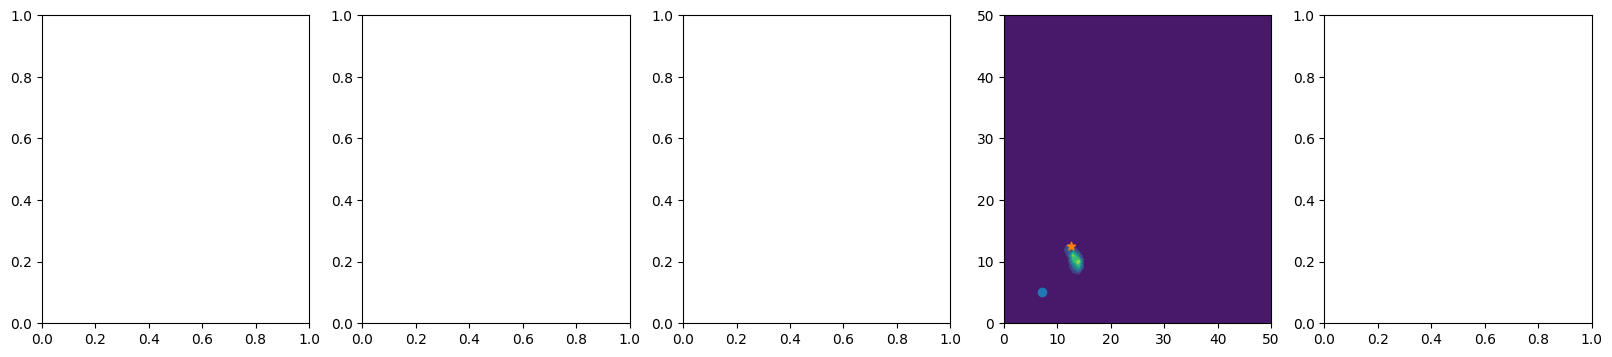

In [38]:
fig,axes=plt.subplots(1,5,figsize=(20,4))
stage=2
_, posterior = forward_posterior_infoGain(params_list[1], jnp.array([0.31,0.3]), stage, center, posterior_list[stage-1], noise_info, num_d, radio_d, key[stage], model)
axes[3].contourf(posterior.T) # 使用某一个设计更新之后的后验
axes[3].scatter(design_list[stage+1][0]*50,design_list[stage+1][1]*50)
axes[3].scatter(center[0]*50,center[1]*50,marker='*')

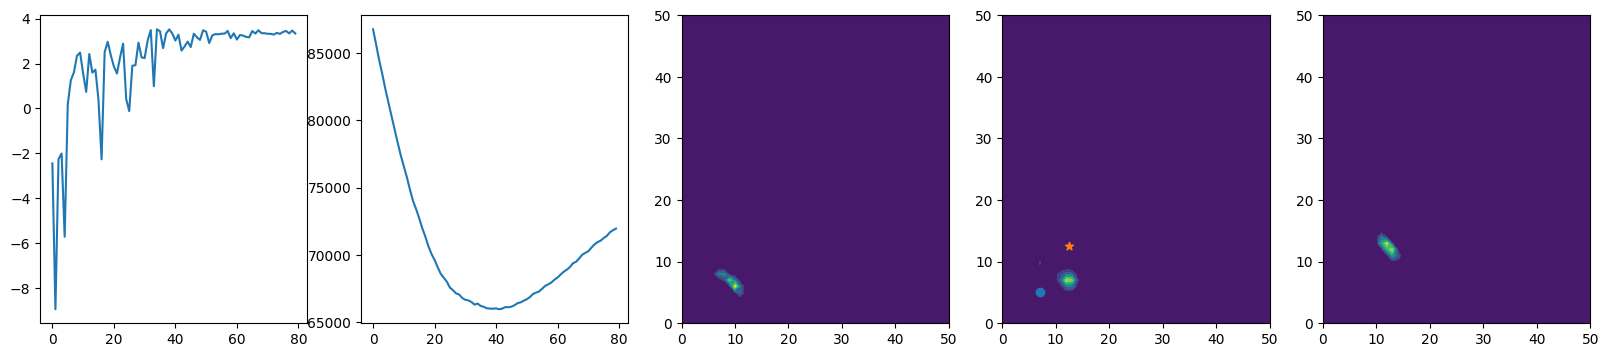

In [37]:
fig,axes=plt.subplots(1,5,figsize=(20,4))
axes[0].plot(evidence_list_special)
axes[1].plot(NN_error_list_special)
axes[2].contourf(posterior_list[stage].T)

_, posterior = forward_posterior_infoGain(params, design_list[stage+1], stage, center, posterior_list[stage-1], noise_info, num_d, radio_d, key[stage], model)
axes[3].contourf(posterior.T) # 使用某一个设计更新之后的后验
axes[3].scatter(design_list[stage+1][0]*50,design_list[stage+1][1]*50)
axes[3].scatter(center[0]*50,center[1]*50,marker='*')

# 打开保存的数据文件
with open('all_data_nn_case_seed_2018_randomEach_lr0p012_accurateCenterEsti_useHistorical_fineTune2_gd3.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# 访问读取的数据
posterior_list_ori = loaded_data["posterior_list"]

axes[4].contourf(posterior_list_ori[stage])

In [23]:
# 保存数据
import pickle

numpy_list = [np.array(arr) for arr in posterior_list]
data_to_save = {
    "posterior_list": numpy_list,
    "posterior_oed_list": posterior_oed_list,
    "design_list": design_list,
    "params_list": params_list,
    "estimated_posterior_point": estimated_posterior_point,
    "design_MEC_trajectory": design_MEC_trajectory,
    
    "actual_step": actual_step,
    "design_MEC_list": design_MEC_list,
    "observation_MEC_list": observation_MEC_list
}

with open('all_data_nn_case_seed_2020_truePhy_trueNet_test6_checkpoint4.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

# all_data_nn_case_seed_2021_random: 使用random ensemble
# all_data_nn_case_seed_2020_random.pkl
# all_data_nn_case_seed_2020_empirical.pkl: 使用stage 1
# all_data_nn_case_seed_2019_random.pkl
# all_data_nn_case_seed_2019_empirical.pkl：使用stage 1
# all_data_nn_case_seed_2018_random.pkl
# all_data_nn_case_seed_2018_empirical.pkl  /// 忘记保存了
# all_data_nn_case_seed_2017_random.pkl
# all_data_nn_case_seed_2017_empirical.pkl：使用stage 1
# all_data_nn_case_seed_2016_random.pkl
# all_data_nn_case_seed_2016_empirical.pkl：使用stage 1
# all_data_nn_case_seed_2015_random.pkl
# all_data_nn_case_seed_2015_empirical.pkl：使用stage 1
# all_data_nn_case_seed_2023_random.pkl
# all_data_nn_case_seed_2023_empirical.pkl：使用stage 1
# all_data_nn_case_seed_2021_useHistorical_noUpdateOED.pkl
# all_data_nn_case_seed_2021_useHistorical_noUpdateOED_specialEnsemble.pkl
# all_data_nn_case_seed_2021_specialEnsemble.pkl
# all_data_nn_case_seed_2021_randomEach_lr0p002.pkl
# all_data_nn_case_seed_2021_randomEach_lr0p012_changeEnsemble

NameError: name 'cmap' is not defined

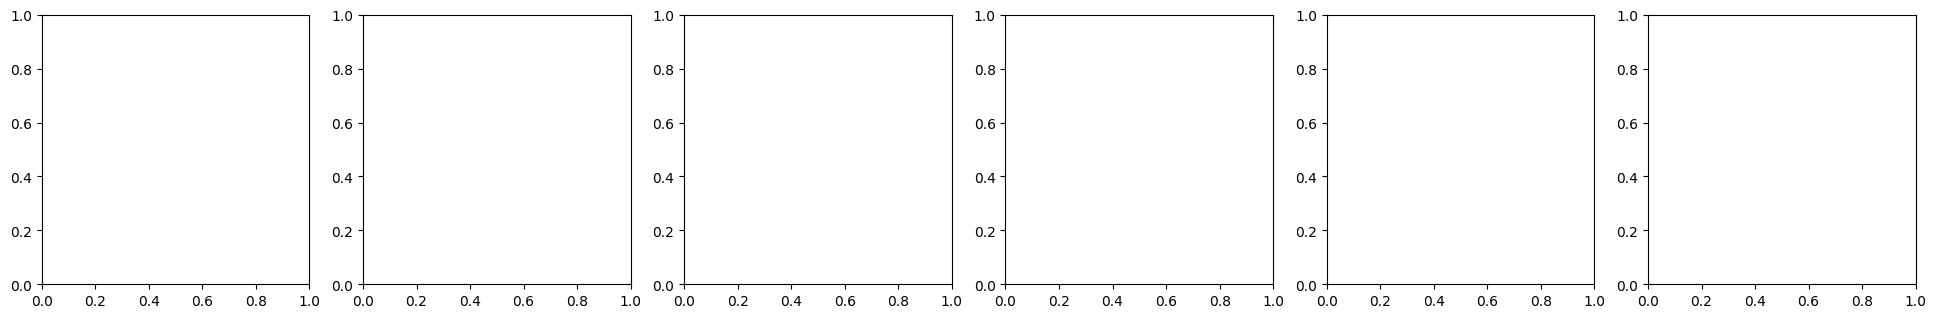

In [8]:
prior =  prior_ori/jnp.sum(prior_ori)
fig, axes = plt.subplots(1, n_stage, figsize=(4.03*n_stage, 3.5))
posterior_list_special1 = []#before

for stage in range(len(design_list)-1):
    _, posterior = forward_posterior_infoGain(params_list[0], design_list[stage+1], stage, center, prior, noise_info, num_d, radio_d, key[stage], model)
    del prior
    prior = posterior
    posterior_list_special1.append(posterior)
    axes[stage ].contourf(grid_x_plot0, grid_y_plot0, posterior.T, levels=100,cmap=cmap)#plasma' )
    axes[stage ].scatter(design_list[stage+1][0], design_list[stage+1][1], marker='o', s=100, c='orange')
    axes[stage].scatter(center[0], center[1], marker='*', s=100, c=star_color)

stage 0, estimated_center is [0.24 0.22], distance is 0.03162277862429619
stage 1, estimated_center is [0.42 0.24], distance after correction is 0.17029385268688202
stage 2, estimated_center is [0.17999999 0.22      ], distance after correction is 0.07615773379802704
stage 3, estimated_center is [0.17999999 0.22      ], distance after correction is 0.07615773379802704
stage 4, estimated_center is [0.16081633 0.22408162], distance after correction is 0.09287351369857788
stage 5, estimated_center is [0.15877551 0.22734693], distance after correction is 0.09399504959583282


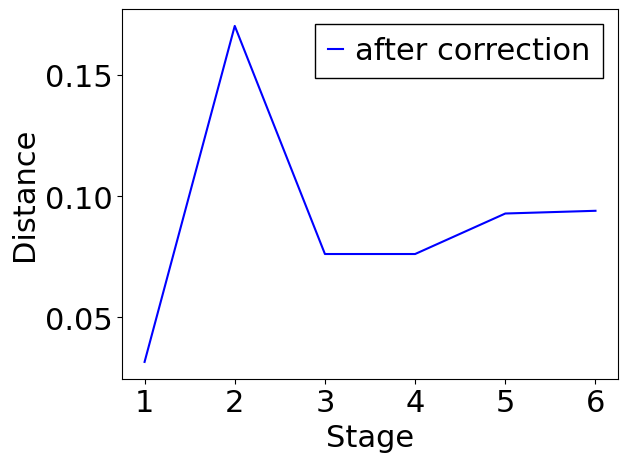

In [68]:
import jax.numpy as jnp
from scipy.interpolate import griddata

dis1_list = []

num_top = 5
for i in range(n_stage):
    # 找到初步估计的中心点 indices
    indices = jnp.argpartition(posterior_list_special1[i].ravel(), -num_top)[-num_top:]
    multi_indices = jnp.unravel_index(indices, posterior_list[i].shape)
    
    average_x = int(jnp.mean(multi_indices[0]))
    average_y = int(jnp.mean(multi_indices[1]))
    
    # 定义 5x5 的范围
    x_range = jnp.arange(max(0, average_x - 2), min(posterior_list[i].shape[0], average_x + 3))
    y_range = jnp.arange(max(0, average_y - 2), min(posterior_list[i].shape[1], average_y + 3))
    
    # 获取5x5的网格点
    x_grid, y_grid = jnp.meshgrid(x_range, y_range, indexing='ij')
    x_grid_flat = x_grid.ravel()
    y_grid_flat = y_grid.ravel()
    
    # 提取对应的 posterior 值
    grid_points = jnp.stack((x_grid_flat, y_grid_flat), axis=-1)
    grid_values = posterior_list_special1[i][x_grid_flat, y_grid_flat]
    
    # 插值：创建细化的网格以提升精度
    fine_x = jnp.linspace(x_range.min(), x_range.max(), 50)
    fine_y = jnp.linspace(y_range.min(), y_range.max(), 50)
    fine_x_grid, fine_y_grid = jnp.meshgrid(fine_x, fine_y, indexing='ij')
    fine_points = jnp.stack((fine_x_grid.ravel(), fine_y_grid.ravel()), axis=-1)
    
    interpolated_values = griddata(grid_points, grid_values, fine_points, method='cubic')
    interpolated_values = interpolated_values.reshape(fine_x_grid.shape)
    
    # 找到插值后最大值的坐标
    max_index = jnp.unravel_index(jnp.argmax(interpolated_values), interpolated_values.shape)
    max_x, max_y = fine_x_grid[max_index], fine_y_grid[max_index]
    
    # 输出新的估计中心
    estimated_center_post1 = jnp.array([max_x, max_y]) / 50
    
    distance1 = jnp.sqrt(jnp.sum((center - estimated_center_post1)**2))
    dis1_list.append(distance1)

    
    if i == 0:
        print(f'stage {i}, estimated_center is {estimated_center_post1}, distance is {distance1}')
    else:
        print(f'stage {i}, estimated_center is {estimated_center_post1}, distance after correction is {distance1}')

plt.plot(dis1_list,color='b',label='after correction')
plt.rc('font', size=22)
plt.xticks([0,1,2,3,4,5],labels=[1,2,3,4,5,6])
plt.legend(
    frameon=True,
    framealpha=1.0,
    edgecolor='black',
    borderpad=0.4,
    handlelength=0.5,
    fancybox=False,  # 设置图例框为方形
    handletextpad=0.4  # 调整图标和文字之间的距离
)
plt.xlabel("Stage")
plt.ylabel("Distance")
plt.show()


In [51]:
average_x,average_y, x_range, y_range

(8,
 11,
 Array([ 6,  7,  8,  9, 10], dtype=int32),
 Array([ 9, 10, 11, 12, 13], dtype=int32))

In [64]:
prior =  prior_ori/jnp.sum(prior_ori)
posterior_list_special2 = []

for stage in range(len(design_list)-1):
    _, posterior = forward_posterior_infoGain(params, design_list[stage+1], stage, center, prior, noise_info, num_d, radio_d, key[stage], model)
    del prior
    prior = posterior
    posterior_list_special2.append(posterior)

stage 0, estimated_center is [0.35999998 0.26      ], distance is 0.11045359075069427
stage 1, estimated_center is [0.23632652 0.19999999], distance after correction is 0.05183594673871994
stage 2, estimated_center is [0.19959183 0.22      ], distance after correction is 0.05865989625453949
stage 3, estimated_center is [0.17999999 0.24285713], distance after correction is 0.07036349177360535
stage 4, estimated_center is [0.18734694 0.23551019], distance after correction is 0.06430677324533463
stage 5, estimated_center is [0.18571427 0.23877548], distance after correction is 0.06525828689336777


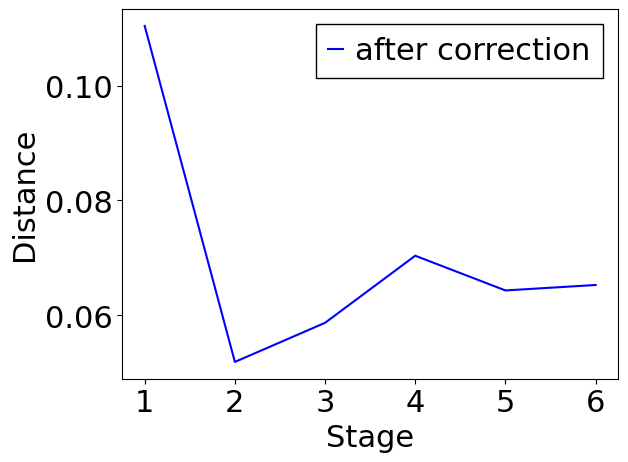

In [67]:
import jax.numpy as jnp
from scipy.interpolate import griddata

dis1_list = []
estimated_center_post1_list = []

num_top = 5
for i in range(n_stage):
    # 找到初步估计的中心点 indices
    indices = jnp.argpartition(posterior_list_special2[i].ravel(), -num_top)[-num_top:]
    multi_indices = jnp.unravel_index(indices, posterior_list[i].shape)
    
    average_x = int(jnp.mean(multi_indices[0]))
    average_y = int(jnp.mean(multi_indices[1]))
    
    # 定义 5x5 的范围
    x_range = jnp.arange(max(0, average_x - 2), min(posterior_list[i].shape[0], average_x + 3))
    y_range = jnp.arange(max(0, average_y - 2), min(posterior_list[i].shape[1], average_y + 3))
    
    # 获取5x5的网格点
    x_grid, y_grid = jnp.meshgrid(x_range, y_range, indexing='ij')
    x_grid_flat = x_grid.ravel()
    y_grid_flat = y_grid.ravel()
    
    # 提取对应的 posterior 值
    grid_points = jnp.stack((x_grid_flat, y_grid_flat), axis=-1)
    grid_values = posterior_list_special2[i][x_grid_flat, y_grid_flat]
    
    # 插值：创建细化的网格以提升精度
    fine_x = jnp.linspace(x_range.min(), x_range.max(), 50)
    fine_y = jnp.linspace(y_range.min(), y_range.max(), 50)
    fine_x_grid, fine_y_grid = jnp.meshgrid(fine_x, fine_y, indexing='ij')
    fine_points = jnp.stack((fine_x_grid.ravel(), fine_y_grid.ravel()), axis=-1)
    
    interpolated_values = griddata(grid_points, grid_values, fine_points, method='cubic')
    interpolated_values = interpolated_values.reshape(fine_x_grid.shape)
    
    # 找到插值后最大值的坐标
    max_index = jnp.unravel_index(jnp.argmax(interpolated_values), interpolated_values.shape)
    max_x, max_y = fine_x_grid[max_index], fine_y_grid[max_index]
    
    # 输出新的估计中心
    estimated_center_post1 = jnp.array([max_x, max_y]) / 50
    estimated_center_post1_list.append(estimated_center_post1)
    
    distance1 = jnp.sqrt(jnp.sum((center - estimated_center_post1)**2))
    dis1_list.append(distance1)

    
    if i == 0:
        print(f'stage {i}, estimated_center is {estimated_center_post1}, distance is {distance1}')
    else:
        print(f'stage {i}, estimated_center is {estimated_center_post1}, distance after correction is {distance1}')

plt.plot(dis1_list,color='b',label='after correction')
plt.rc('font', size=22)
plt.xticks([0,1,2,3,4,5],labels=[1,2,3,4,5,6])
plt.legend(
    frameon=True,
    framealpha=1.0,
    edgecolor='black',
    borderpad=0.4,
    handlelength=0.5,
    fancybox=False,  # 设置图例框为方形
    handletextpad=0.4  # 调整图标和文字之间的距离
)
plt.xlabel("Stage")
plt.ylabel("Distance")
plt.show()


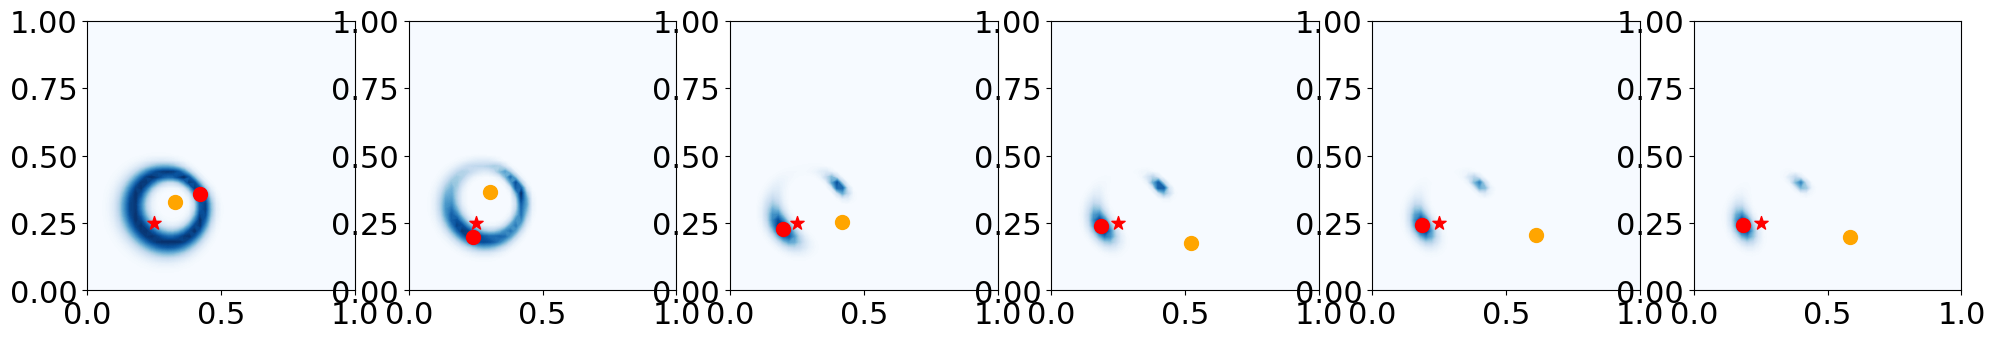

In [66]:
fig, axes = plt.subplots(1, n_stage, figsize=(4.03*n_stage, 3.5))

for stage in range(n_stage):
    axes[stage ].contourf(grid_x_plot0, grid_y_plot0, posterior_list_special2[stage].T, levels=100,cmap=cmap)#plasma' )
    axes[stage ].scatter(design_list[stage+1][0], design_list[stage+1][1], marker='o', s=100, c='orange')
    axes[stage].scatter(center[0], center[1], marker='*', s=100, c=star_color)
    axes[stage].scatter(estimated_center_post1_list[stage][0], estimated_center_post1_list[stage][1], marker='o', s=100, c=star_color)

In [19]:
design_list[-1]

Array([0.200338  , 0.10609574], dtype=float32)

In [18]:
params_list[-1]

{'params': {'Dense_0': {'bias': Array([-0.45416942, -0.11178908, -0.47018778,  0.650212  ], dtype=float32),
   'kernel': Array([[ 4.6396227,  4.0943356,  8.302697 ,  9.488601 ],
          [-2.977288 ,  5.076063 , -7.8705683, -8.838866 ]], dtype=float32)},
  'Dense_1': {'bias': Array([-0.3772905,  1.2590514,  1.2355644,  0.5034812], dtype=float32),
   'kernel': Array([[-0.8245547,  2.9839818,  3.1150737,  1.0273643],
          [-4.6727095,  4.805146 ,  4.7221694,  4.884182 ],
          [-3.052333 ,  3.9820528, -4.2850094, -5.3192   ],
          [ 4.4627957, -3.4237869,  4.62319  ,  3.4639373]], dtype=float32)},
  'Dense_2': {'bias': Array([-0.34686875], dtype=float32),
   'kernel': Array([[-10.553897],
          [ 10.150299],
          [-10.240886],
          [-10.978576]], dtype=float32)}}}

In [31]:
import pickle

# 打开保存的数据文件
with open('all_data_nn_case_seed_2020_truePhy_trueNet_test6_checkpoint3.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# 访问读取的数据
posterior_list = loaded_data["posterior_list"]
posterior_oed_list = loaded_data["posterior_oed_list"]
design_list = loaded_data["design_list"]
params_list = loaded_data["params_list"]
estimated_posterior_point = loaded_data["estimated_posterior_point"]
design_MEC_trajectory = loaded_data["design_MEC_trajectory"]
actual_step = loaded_data["actual_step"]
design_MEC_list = loaded_data["design_MEC_list"]
observation_MEC_list = loaded_data["observation_MEC_list"] 

In [32]:
actual_step

[0, 21, 20, 20, 18]

In [144]:
#编写一段代码，用来fine tune phyOED的学习率和设置。

with open('all_data_nn_case_seed_2018_randomEach_lr0p012_accurateCenterEsti_useHistorical_fineTune2_gd3.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# 访问读取的数据
posterior_list = loaded_data["posterior_list"]
posterior_oed_list = loaded_data["posterior_oed_list"]
design_list = loaded_data["design_list"]
params_list = loaded_data["params_list"]
estimated_posterior_point = loaded_data["estimated_posterior_point"]
design_MEC_trajectory = loaded_data["design_MEC_trajectory"]
design_MEC_list = loaded_data["design_MEC_list"]
observation_MEC_list = loaded_data["observation_MEC_list"]
actual_step = loaded_data["actual_step"]

d_trajectory = []
KLD_list = []
key = random.PRNGKey(2018)
key = random.split(key,int(n_stage*2+1))

for stage in [2]:#
    
    #if stage == 5:
    #    break #提前结束
        
    print('\n stage = ', stage, '\n')
    key_for_design = random.split(key[stage*2],iteration_step_number1[stage])
    key_for_param = random.split(key[stage*2+1],(iteration_step_number2[stage]+1))

    d_start = design_list[stage]
    params = params_list[stage-1]
    prior = posterior_list[stage-1]
    
    clip_count = 0
    
    if stage!=0:
        try:
            del tx1
            del opt_state1
        except NameError:
            pass
    else:
        print(f'stage = 0, only run forward model and update posterior')

    total_steps = 50
    
    lr_ad = 0.03
    #print(lr_ad)
    #tx1 = optax.adam(lr_ad)
    tx1 = optax.chain(
    optax.adam(lr_ad),  # 使用由 lr_schedule1 调整的学习率的 Adam 优化器
    optax.add_decayed_weights(1e-4)  # 添加权重衰减，衰减系数为 1e-5
    )

    
    ## 定义学习率调度：Warmup + Cosine Annealing
    #warmup_cosine_schedule = optax.warmup_cosine_decay_schedule(
    #    init_value=0.03,  # 热身初始值
    #    peak_value=0.3,  # 热身结束时的学习率
    #    warmup_steps=15,         # 热身步数
    #    decay_steps= 40,  # 余弦退火步数
    #    end_value=0.01       # 最终学习率
    #)
    #
    ## 构建优化器链：Adam + Cosine Annealing + 权重衰减
    #tx1 = optax.chain(
    #    optax.scale_by_adam(),                              # Adam 优化器
    #    #optax.add_decayed_weights(weight_decay=1e-4),       # 权重衰减
    #    optax.scale_by_schedule(warmup_cosine_schedule)            # Cosine Annealing 调度
    #)

    
    
    opt_state1 = tx1.init(d_start)
    
    d_limit_min = d_start - d_change_range
    d_limit_max = d_start + d_change_range
    
    start_time = time.time()
    d_start_backup = d_start

    print('start learning design')
    print(f'start design : ', d_start)
    
    num_top_local = 15
    indices = jnp.argpartition(prior.ravel(), -num_top_local)[-num_top_local:]
    multi_indices = jnp.unravel_index(indices, prior.shape)
    
    for i in range(100):

        #negtive_KLD, grad_design = jax.value_and_grad(loss_design)(d_start, params, stage, center, prior, noise_info, num_d, radio_d, key_for_design[i], model)
        negtive_KLD, grad_design = jax.value_and_grad(loss_design_trueOED_modified)(d_start)
            
        #negtive_KLD, grad_design = jax.value_and_grad(loss_design)(d_start, params, stage, center, prior, noise_info, num_d, radio_d, key_for_design[i], model)
        updates, opt_state1 = tx1.update(grad_design, opt_state1, params=d_start)

        
        # 解决nan的问题
        oed_nan_index = 0
        updates_contain_nans = any(jnp.any(jnp.isnan(u)) for u in jax.tree_util.tree_leaves(updates))
        if updates_contain_nans:
            oed_nan_index = oed_nan_index + 1
            print(f'NaN appears in learning. Perturb params and continue. Nan count: {oed_nan_index}')
            noise = 0.05*jax.random.normal(key_for_design[i], d_start.shape)
            d_start = d_start+ noise
        else:
            oed_nan_index = 0
            d_start = optax.apply_updates(d_start, updates)
    
        d_start_before_clip = d_start
        d_start = jnp.clip(d_start, d_limit_min, d_limit_max)
        
        # 如果clip函数生效，即有参数被裁剪，增加计数器
        clip_count = 0
        if not jnp.all(d_start == d_start_before_clip):
            clip_count += 1
        else:
            clip_count = 0
            
        if clip_count >= 5:
            print(f"Stopping iteration at step {i} as clip function has been activated 5 times.")
            break
        
        if np.isnan(d_start).any() or np.isnan(negtive_KLD).any():
            print('some results are Nan')
            break
    
        KLD_list.append(-negtive_KLD)
        
        if oed_nan_index > 6:
            print('连续出现nam并扰动6次，停止oed')
            break

        #if (d_start - d_trajectory[-1])
        
        d_trajectory.append(d_start)
        print('.',end='')
        print(d_start)
            
            
    end_time = time.time()
    print(f"Execution learning design time: {end_time - start_time} seconds")
    print('Current design = ', d_start)

    #if stage!=0:
    _, posterior = forward_posterior_infoGain(params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], model)
    del prior # 如果决定oed后不更新后验，则注释这一句
    prior = posterior # 如果决定oed后不更新后验，则注释这一句
    #posterior_oed_list.append(posterior)

    net_accuracy = evaluate_nn_accuracy(params,model,center,local_size)
    #NN_error_list.append(net_accuracy)
    #design_list.append(d_start)
    

    

    # 模块：MAP估计中心
    ## 方法1
    #num_top = num_top_array[stage]
    #indices = jnp.argpartition(posterior.ravel(), -num_top)[-num_top:]
    #multi_indices = jnp.unravel_index(indices, posterior.shape)
    #
    #average_x = np.mean(multi_indices[0])
    #average_y = np.mean(multi_indices[1])
    #
    #estimated_center = jnp.array([average_x, average_y])/50
    #print(f'estimated_center is ', estimated_center)
    #estimated_posterior_point.append(estimated_center)

    # 方法2
    num_top = num_top_array[stage]
    indices = jnp.argpartition(posterior.ravel(), -num_top)[-num_top:]
    multi_indices = jnp.unravel_index(indices, posterior.shape)
    
    average_x = int(jnp.mean(multi_indices[0]))
    average_y = int(jnp.mean(multi_indices[1]))
    
    # 定义 5x5 的范围
    x_range = jnp.arange(max(0, average_x - 2), min(posterior.shape[0], average_x + 3))
    y_range = jnp.arange(max(0, average_y - 2), min(posterior.shape[1], average_y + 3))
    
    # 获取5x5的网格点
    x_grid, y_grid = jnp.meshgrid(x_range, y_range, indexing='ij')
    x_grid_flat = x_grid.ravel()
    y_grid_flat = y_grid.ravel()
    
    # 提取对应的 posterior 值
    grid_points = jnp.stack((x_grid_flat, y_grid_flat), axis=-1)
    grid_values = posterior[x_grid_flat, y_grid_flat]
    
    # 插值：创建细化的网格以提升精度
    fine_x = jnp.linspace(x_range.min(), x_range.max(), 50)
    fine_y = jnp.linspace(y_range.min(), y_range.max(), 50)
    fine_x_grid, fine_y_grid = jnp.meshgrid(fine_x, fine_y, indexing='ij')
    fine_points = jnp.stack((fine_x_grid.ravel(), fine_y_grid.ravel()), axis=-1)
    
    interpolated_values = griddata(grid_points, grid_values, fine_points, method='cubic')
    interpolated_values = interpolated_values.reshape(fine_x_grid.shape)
    
    # 找到插值后最大值的坐标
    max_index = jnp.unravel_index(jnp.argmax(interpolated_values), interpolated_values.shape)
    max_x, max_y = fine_x_grid[max_index], fine_y_grid[max_index]
    
    # 输出新的估计中心
    estimated_center = jnp.array([max_x, max_y]) / 50
    print(f'estimated_center is ', estimated_center)



 stage =  2 

start learning design
start design :  [0.22245525 0.22217366]
.[0.25247818 0.19219519]
.[0.27724478 0.1681187 ]
.[0.29246613 0.14362969]
.[0.29295468 0.12285969]
.[0.28459746 0.10794488]
.[0.27129573 0.09936243]
.[0.25527135 0.09659819]
.[0.23809628 0.0986665 ]
.[0.22118358 0.10432986]
.[0.20574899 0.1120989 ]
.[0.19240448 0.12035792]
.[0.18091369 0.12754004]
.[0.17054024 0.13262372]
.[0.16061862 0.13546742]
.[0.15104939 0.13666514]
.[0.14239053 0.13713117]
.[0.13558432 0.13771194]
.[0.1314614  0.13894817]
.[0.13029228 0.1409742 ]
.[0.13171676 0.14356741]
.[0.13488409 0.14622408]
.[0.1387297 0.1483193]
.[0.14220044 0.14923626]
.[0.14458087 0.14856225]
.[0.1456682  0.14621256]
.[0.14582184 0.14252235]
.[0.14570959 0.13811225]
.[0.14607309 0.133744  ]
.[0.14747652 0.13011646]
.[0.15012044 0.12764356]
.[0.15390639 0.1264299 ]
.[0.15851782 0.12627386]
.[0.16354065 0.12672508]
.[0.16851239 0.12712303]
.[0.17317024 0.12693612]
.[0.17744754 0.12584668]
.[0.18147144 0.12387682]


NameError: name 'd_trajectory' is not defined

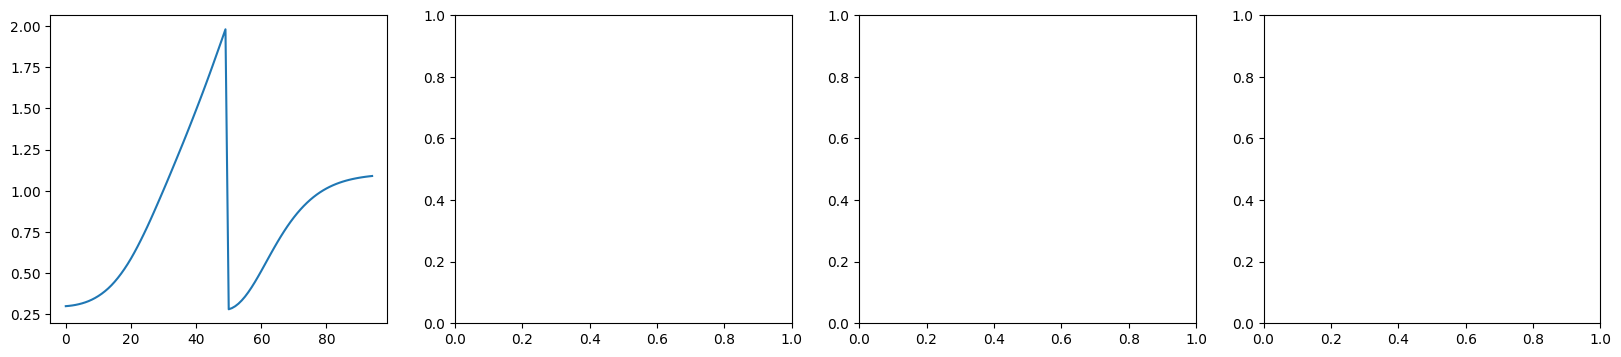

In [151]:
fig,axes=plt.subplots(1,4,figsize=(20,4))
axes[0].plot(KLD_list)

colors = plt.cm.Blues(np.linspace(1.0, 0.2, 100))

for i in range(len(d_trajectory)):
    axes[1].scatter(d_trajectory[i][0],d_trajectory[i][1],color=colors[i])

axes[2].contourf(posterior.T)
#axes[3].contourf(posterior_list[2].T)

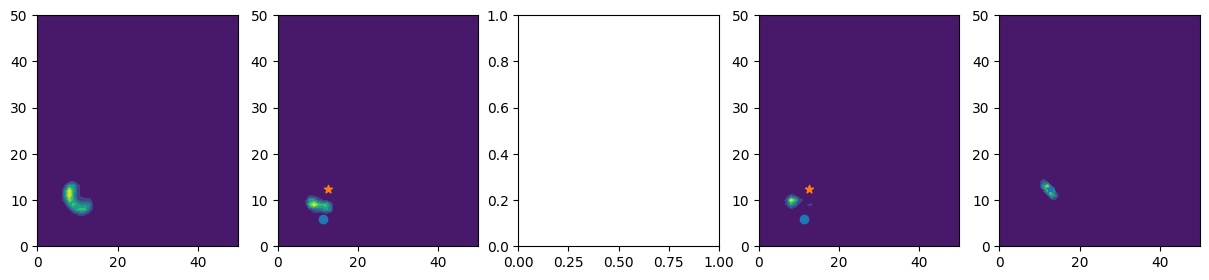

In [147]:
fig,axes=plt.subplots(1,5,figsize=(15,3))
axes[0].contourf(posterior_list[stage-1].T) # 上一阶段的后验，这一阶段的先验

d = jnp.array([0.2228857,0.11976115])#design_list[1]-
_, posterior = forward_posterior_infoGain(params_list[stage-1], d, stage, center, posterior_list[stage-1], noise_info, num_d, radio_d, key[stage], model)
axes[1].contourf(posterior.T) # 使用某一个设计更新之后的后验
axes[1].scatter(d[0]*50,d[1]*50)
axes[1].scatter(center[0]*50,center[1]*50,marker='*')

#axes[2].contourf(posterior_oed_list[stage].T)
#axes[2].scatter(center[0]*50,center[1]*50,marker='*')

_, posterior = forward_posterior_infoGain(params_list[stage], d, stage, center, posterior, noise_info, num_d, radio_d, key[stage], model)
axes[3].contourf(posterior.T) # 使用某一个设计更新之后的后验
axes[3].scatter(d[0]*50,d[1]*50)
axes[3].scatter(center[0]*50,center[1]*50,marker='*')


axes[4].contourf(posterior_list[stage].T)
axes[4].scatter(center[0]*50,center[1]*50,marker='*')

In [54]:
import jax.numpy as jnp
from scipy.interpolate import griddata

num_top = 1
for i in range(n_stage):
    # 找到初步估计的中心点 indices
    indices = jnp.argpartition(posterior_list[i].ravel(), -num_top)[-num_top:]
    multi_indices = jnp.unravel_index(indices, posterior_list[i].shape)
    
    average_x = int(jnp.mean(multi_indices[0]))
    average_y = int(jnp.mean(multi_indices[1]))
    
    # 定义 5x5 的范围
    x_range = jnp.arange(max(0, average_x - 2), min(posterior_list[i].shape[0], average_x + 3))
    y_range = jnp.arange(max(0, average_y - 2), min(posterior_list[i].shape[1], average_y + 3))
    
    # 获取5x5的网格点
    x_grid, y_grid = jnp.meshgrid(x_range, y_range, indexing='ij')
    x_grid_flat = x_grid.ravel()
    y_grid_flat = y_grid.ravel()
    
    # 提取对应的 posterior 值
    grid_points = jnp.stack((x_grid_flat, y_grid_flat), axis=-1)
    grid_values = posterior_list[i][x_grid_flat, y_grid_flat]
    
    # 插值：创建细化的网格以提升精度
    fine_x = jnp.linspace(x_range.min(), x_range.max(), 50)
    fine_y = jnp.linspace(y_range.min(), y_range.max(), 50)
    fine_x_grid, fine_y_grid = jnp.meshgrid(fine_x, fine_y, indexing='ij')
    fine_points = jnp.stack((fine_x_grid.ravel(), fine_y_grid.ravel()), axis=-1)
    
    interpolated_values = griddata(grid_points, grid_values, fine_points, method='cubic')
    interpolated_values = interpolated_values.reshape(fine_x_grid.shape)
    
    # 找到插值后最大值的坐标
    max_index = jnp.unravel_index(jnp.argmax(interpolated_values), interpolated_values.shape)
    max_x, max_y = fine_x_grid[max_index], fine_y_grid[max_index]
    
    # 输出新的估计中心
    estimated_center_post = jnp.array([max_x, max_y]) / 50
    
    distance = jnp.sqrt(jnp.sum((center - estimated_center_post)**2))
    print(f'stage {i}, estimated_center is {estimated_center_post}, distance is {distance}')


stage 0, estimated_center is [0.18285714 0.4212245 ], distance is 0.18391844630241394
stage 1, estimated_center is [0.14244898 0.24734692], distance is 0.10758374631404877
stage 2, estimated_center is [0.277551   0.18734694], distance is 0.06844314187765121
stage 3, estimated_center is [0.27591833 0.20081632], distance is 0.05559491366147995
stage 4, estimated_center is [0.21918367 0.17591837], distance is 0.08023548871278763
stage 5, estimated_center is [0.26081634 0.19918367], distance is 0.051954712718725204


In [2]:
import pickle

# 打开保存的数据文件
with open('all_data_nn_case_seed_2019_randomEach_lr0p012_accurateCenterEsti_useHistorical_fineTune2_gd3.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# 访问读取的数据
posterior_list = loaded_data["posterior_list"]
posterior_oed_list = loaded_data["posterior_oed_list"]
design_list = loaded_data["design_list"]
params_list = loaded_data["params_list"]
estimated_posterior_point = loaded_data["estimated_posterior_point"]
design_MEC_trajectory = loaded_data["design_MEC_trajectory"]
actual_step = loaded_data["actual_step"]
design_MEC_list = loaded_data["design_MEC_list"]
observation_MEC_list = loaded_data["observation_MEC_list"] 

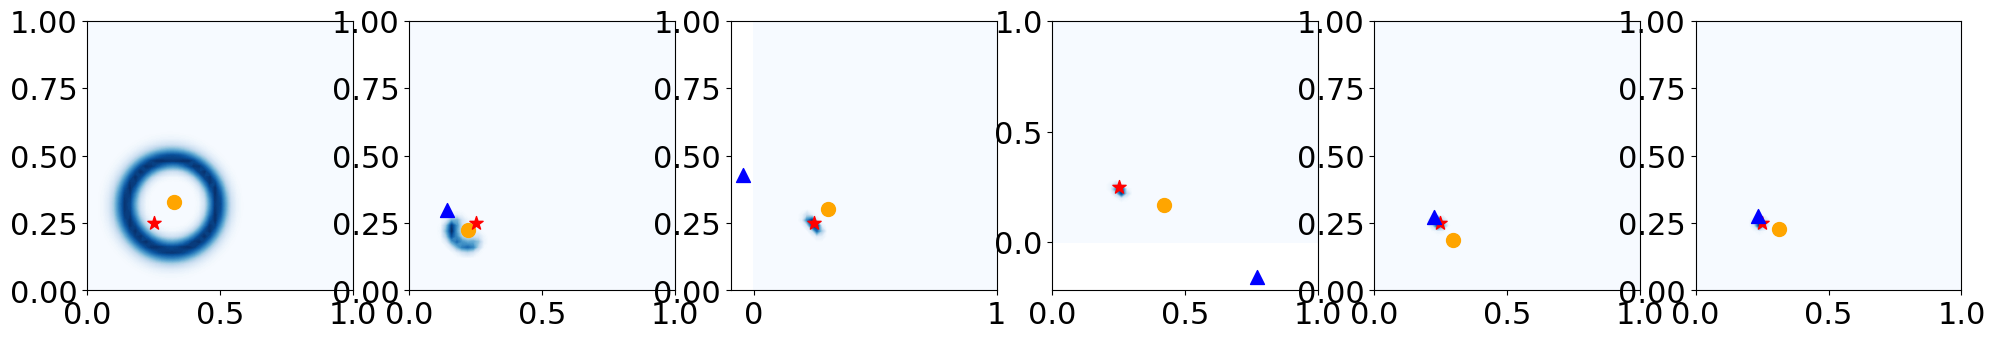

In [30]:
fig, axes = plt.subplots(1, n_stage, figsize=(4.03*n_stage, 3.5))
fig.subplots_adjust(wspace=0.21)

# fig.subplots_adjust(left = 0.05, right = 0.9, wspace=0.3)

grid_x_plot0, grid_y_plot0 = np.meshgrid(np.linspace(0, 1, local_size), np.linspace(0, 1, local_size))

        
fontsize = 23
pic_num=0

# 内置颜色图
cmap = 'Blues'#'PuBu'#'pink'#'GnBu'#'Greens'#
star_color = 'r'#'magenta'#'y'#'#F89054'#


for stage in range(n_stage):
    d_start = design_list[stage+1]
    d_start_backup = design_list[stage]
    contour=axes[stage ].contourf(grid_x_plot0, grid_y_plot0, posterior_list[stage].T, levels=100,cmap=cmap)#plasma' )
    axes[stage ].scatter(d_start[0], d_start[1], marker='o', s=100, c='orange')
    axes[stage].scatter(center[0], center[1], marker='*', s=100, c=star_color)
    if stage not in stage_to_skip:
        try:
            axes[stage].scatter(design_MEC_list[stage-1][0], design_MEC_list[stage-1][1], marker='^', s=100, c='blue')
        except NameError:
            axes[stage].scatter(design_MEC_trajectory[np.sum(actual_step[:stage+1])-1][0], design_MEC_trajectory[np.sum(actual_step[:stage+1])-1][1], marker='^', s=100, c='blue')

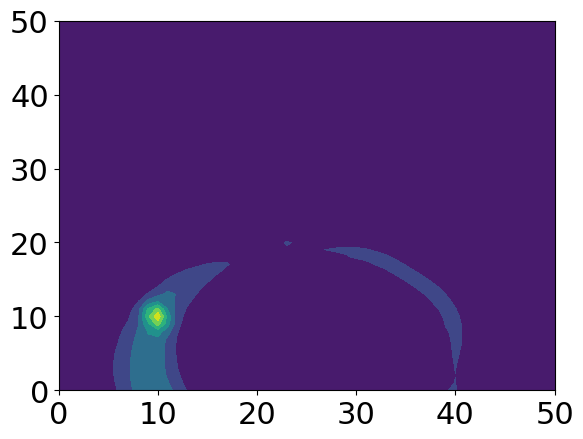

In [17]:
plt.contourf(posterior_list[-1].T)

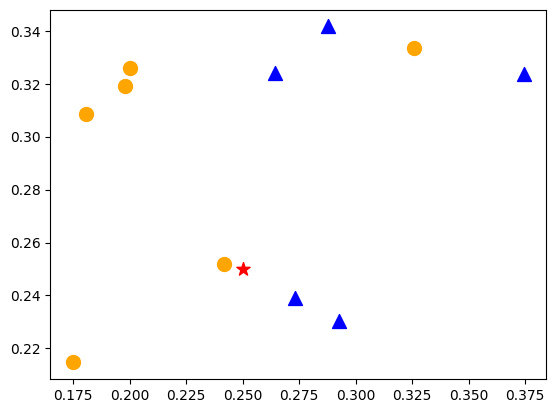

In [12]:
plt.scatter(center[0], center[1], marker='*', s=100, c='r')
for stage in range(n_stage):
    plt.scatter(design_list[stage+1][0], design_list[stage+1][1], marker='o', s=100, c='orange')
    if stage != 0:
        plt.scatter(design_MEC_list[stage-1][0], design_MEC_list[stage-1][1], marker='^', s=100, c='blue')

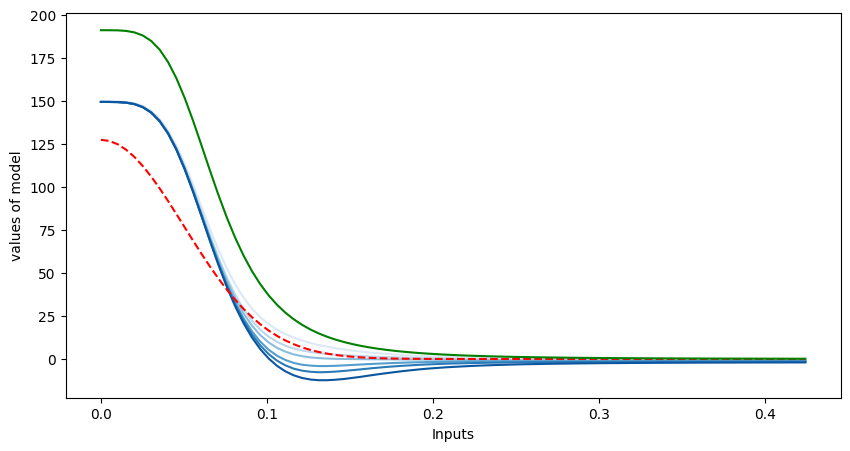

In [12]:
def show_nn_trajectory(params_list, apply_model, colormap = 'Blues', center_x=0, center_y=0, size=85):
    x = jnp.linspace(0, 0.3, size).reshape(-1, 1)
    y = jnp.linspace(0, 0.3, size).reshape(-1, 1)
    xy_combined = jnp.concatenate((x, y), axis=1)
    
    exponent_internal = ((x - center_x) ** 2 + (y - center_y) ** 2)
    factor = 2.0 / (2.0 * jnp.pi * 0.05 ** 2)
    array_exponent = factor * jnp.exp(-exponent_internal / (2.0 * 0.05 ** 2))
    array_reciprocal = factor * 1.5 / (exponent_internal ** 2 / (2.0 * 0.05 ** 2) ** 2 + 1.0)
    
    plt.figure(figsize=(10, 5))
    
    cmap = plt.colormaps[colormap].resampled(len(params_list)+2)#cm.get_cmap('Blues', len(params_list))
    for index, params in enumerate(params_list):
        #if index not in [6]:
        #    continue
        array_nn = apply_model.apply(params, xy_combined) #* 100.0
        
        plt.plot(jnp.sqrt(2) * x.squeeze(), 
                 (array_nn.squeeze() + array_reciprocal.squeeze()), 
                 label=f'NN + Reciprocal - Params {index+1}',
                 color=cmap(index+1))
    
    plt.plot(jnp.sqrt(2) * x.squeeze(), 
             array_exponent.squeeze(), color='r', linestyle = '--', label='Exponent')
    plt.plot(jnp.sqrt(2) * x.squeeze(), 
             array_reciprocal.squeeze(), color='g', label='Reciprocal')
    
    plt.ylabel('values of model')
    plt.xlabel('Inputs')
    
show_nn_trajectory(params_list, model, center_x=0, center_y=0, size=85)

#plt.legend()
#
#leg = plt.gca().get_legend()
#
#new_labels = ['Updated model at stage 0', 'Updated model at stage 1','Updated model at stage 2','Updated model at stage 3','Updated model at stage 4','Updated model at stage 5', 'Updated model at stage 6','System', 'Baseline model']
#
#for text, new_label in zip(leg.get_texts(), new_labels):
#    text.set_text(new_label)
#
#plt.draw()

In [22]:
for stage in range(1,n_stage):
    print('stage = ', stage)
    estimated_center = estimated_posterior_point[stage]
    
    u_t = sealed_convection_diffusion_true(d_start, center, stage)[1][100:151,100:151]
    u_design_5 = sealed_convection_diffusion_nn(params_list[stage-1], d_start, center, stage, model)[1][100:151,100:151]
    u_design_7 = sealed_convection_diffusion_nn(params_list[stage], d_start, center, stage, model)[1][100:151,100:151]
    print('Total MSE: ', np.sum((u_t - u_design_5)**2),',',np.sum((u_t - u_design_7)**2))
    print('Total MSE: ', np.sum((u_t - u_design_5)**2)/51,',',np.sum((u_t - u_design_7)**2)/51)
    print('Total RE: ', np.sum(np.abs(u_t - u_design_5))/np.sum(np.abs(u_t)),',',np.sum(np.abs(u_t - u_design_7))/np.sum(np.abs(u_t)))
    
    #u_t = sealed_convection_diffusion_true(d_start, center, stage)[1][110:115,110:115]
    #u_design_6 = sealed_convection_diffusion_nn(params_list[stage-1], d_start, center, stage, model)[1][110:115,110:115]
    #u_design_8 = sealed_convection_diffusion_nn(params_list[stage], d_start, center, stage, model)[1][110:115,110:115]
    #print('Center MSE: ', np.sum((u_t - u_design_6)**2),np.sum((u_t - u_design_8)**2))

    xc, yc =design_list[stage+1]*50+100
    range_xy = 2
    u_t = sealed_convection_diffusion_true(d_start, center, stage)[1][(int(xc)-range_xy):(int(xc)+range_xy),(int(yc)-range_xy):(int(yc)+range_xy)]
    u_design_6 = sealed_convection_diffusion_nn(params_list[stage-1], d_start, center, stage, model)[1][(int(xc)-range_xy):(int(xc)+range_xy),(int(yc)-range_xy):(int(yc)+range_xy)]
    u_design_8 = sealed_convection_diffusion_nn(params_list[stage], d_start, center, stage, model)[1][(int(xc)-range_xy):(int(xc)+range_xy),(int(yc)-range_xy):(int(yc)+range_xy)]
    print('Design MSE: ', np.sum((u_t - u_design_6)**2)/5,',',np.sum((u_t - u_design_8)**2)/5)
    print('Design RE: ', np.sum(np.abs(u_t - u_design_6))/np.sum(np.abs(u_t)),',',np.sum(np.abs(u_t - u_design_8))/np.sum(np.abs(u_t)))

    #if stage != n_stage-1:
    #    xc, yc =design_list[stage+2]*50+100
    #    range_xy = 2
    #    u_t = sealed_convection_diffusion_true(d_start, center, stage)[1][(int(xc)-range_xy):(int(xc)+range_xy),(int(yc)-range_xy):(int(yc)+range_xy)]
    #    u_design_6 = sealed_convection_diffusion_nn(params_list[stage-1], d_start, center, stage, model)[1][(int(xc)-range_xy):(int(xc)+range_xy),(int(yc)-range_xy):(int(yc)+range_xy)]
    #    u_design_8 = sealed_convection_diffusion_nn(params_list[stage], d_start, center, stage, model)[1][(int(xc)-range_xy):(int(xc)+range_xy),(int(yc)-range_xy):(int(yc)+range_xy)]
    #    print('Design MSE next stage: ', np.sum((u_t - u_design_6)**2)/5,',',np.sum((u_t - u_design_8)**2)/5)
    #    print('Design RE next stage: ', np.sum(np.abs(u_t - u_design_6))/np.sum(np.abs(u_t)),',',np.sum(np.abs(u_t - u_design_8))/np.sum(np.abs(u_t)))

    #xc, yc =design_MEC_trajectory[np.sum(actual_step[:stage+1])-1]*50+100
    #range_xy = 5
    #u_t = sealed_convection_diffusion_true(d_start, center, stage)[1][(int(xc)-range_xy):(int(xc)+range_xy),(int(yc)-range_xy):(int(yc)+range_xy)]
    #u_design_6 = sealed_convection_diffusion_nn(params_list[stage-1], d_start, center, stage, model)[1][(int(xc)-range_xy):(int(xc)+range_xy),(int(yc)-range_xy):(int(yc)+range_xy)]
    #u_design_8 = sealed_convection_diffusion_nn(params_list[stage], d_start, center, stage, model)[1][(int(xc)-range_xy):(int(xc)+range_xy),(int(yc)-range_xy):(int(yc)+range_xy)]
    #print('Design MEC MSE: ', np.sum((u_t - u_design_6)**2),np.sum((u_t - u_design_8)**2),'\n')

stage =  1
Total MSE:  15.55122 , 30.34203
Total MSE:  0.3049259 , 0.5949418
Total RE:  0.53482264 , 0.8899002
Design MSE:  0.19151819 , 0.10476237
Design RE:  0.48156482 , 0.34896243
stage =  2
Total MSE:  41.381718 , 12.484606
Total MSE:  0.81140625 , 0.2447962
Total RE:  0.94377255 , 0.51900274
Design MSE:  0.050351884 , 0.0015936431
Design RE:  0.22458029 , 0.03408376
stage =  3
Total MSE:  17.688221 , 5.162504
Total MSE:  0.34682786 , 0.10122558
Total RE:  0.55022895 , 0.30217835
Design MSE:  0.056987215 , 0.020017061
Design RE:  0.4674325 , 0.2774324
stage =  4
Total MSE:  5.440434 , 6.6903057
Total MSE:  0.10667518 , 0.13118248
Total RE:  0.2837267 , 0.3668494
Design MSE:  0.047764026 , 0.0014186492
Design RE:  0.24404031 , 0.037211694
stage =  5
Total MSE:  8.112332 , 11.429097
Total MSE:  0.15906535 , 0.22409995
Total RE:  0.37334427 , 0.4542977
Design MSE:  0.0024981312 , 0.0007530452
Design RE:  0.039605223 , 0.022020774


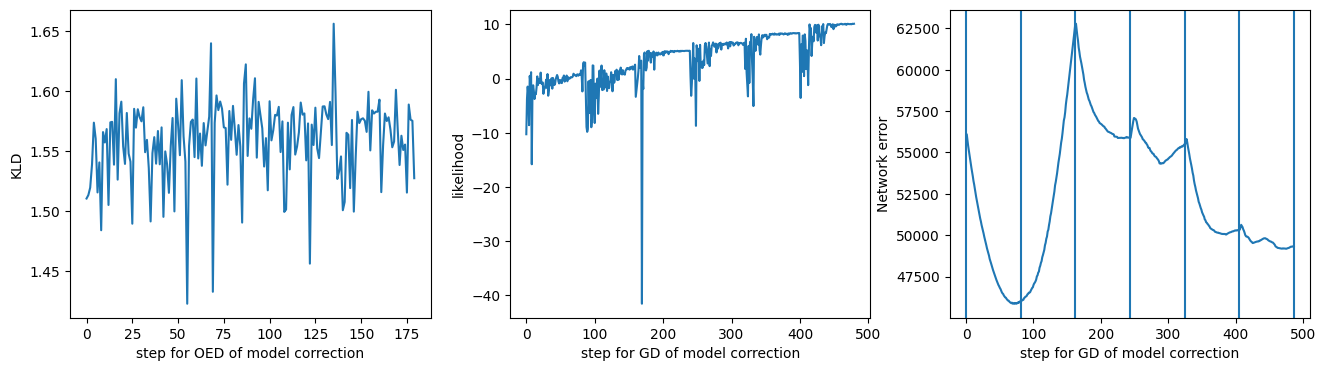

In [14]:
fig,axes = plt.subplots(1,3,figsize=(16,4))
fig.subplots_adjust(wspace=0.22)
axes[0].plot(KLD_MEC_list)
axes[0].set_xlabel('step for OED of model correction')
axes[0].set_ylabel('KLD')
axes[1].plot(evidence_list)
axes[1].set_xlabel('step for GD of model correction')
axes[1].set_ylabel('likelihood')
axes[2].plot(NN_error_list)
axes[2].set_xlabel('step for GD of model correction')
axes[2].set_ylabel('Network error')
for i in range(n_stage):
    axes[2].axvline(81*i)

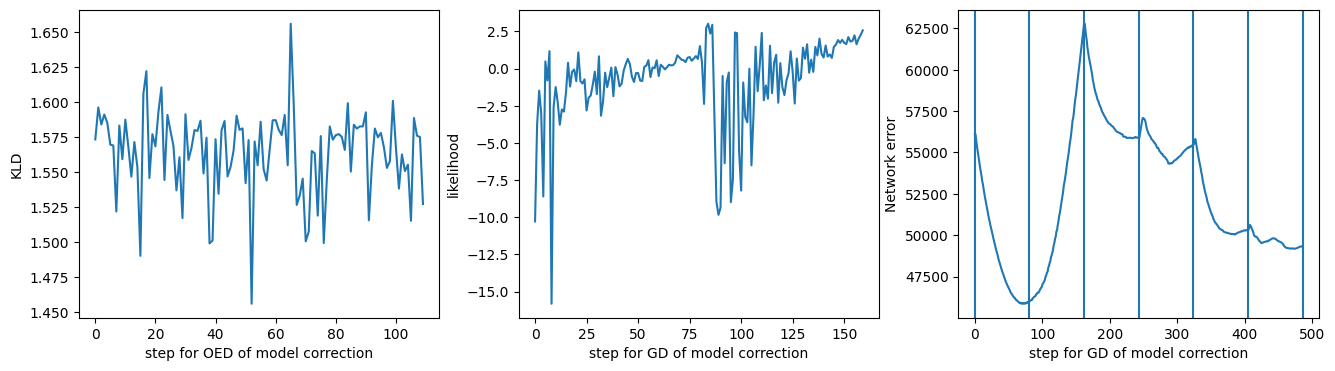

In [15]:
fig,axes = plt.subplots(1,3,figsize=(16,4))
fig.subplots_adjust(wspace=0.22)
axes[0].plot(KLD_MEC_list[70:210])
axes[0].set_xlabel('step for OED of model correction')
axes[0].set_ylabel('KLD')
axes[1].plot(evidence_list[0:160])
axes[1].set_xlabel('step for GD of model correction')
axes[1].set_ylabel('likelihood')
axes[2].plot(NN_error_list)
axes[2].set_xlabel('step for GD of model correction')
axes[2].set_ylabel('Network error')
for i in range(n_stage):
    axes[2].axvline(81*i)

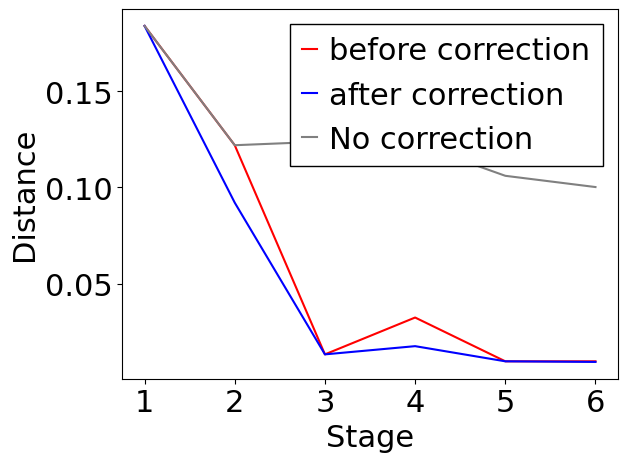

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Data extracted from the image text
stages = [0, 1, 2, 3, 4, 5]
distance_before_correction = [
    0.18391844630241394,
    0.12188474833965302,
    0.013166052289307117,
    0.03232032688197136,
    0.00955924578011036,
    0.00955924578011036,
]
distance_after_correction = [
    0.18391844630241394,
    0.09201569855213165,
    0.013166052289307117,
    0.017434366047382355,
    0.00955924578011036,
    0.009240219369530678,
]

distance_base = [0.1839,0.1219,0.1238,0.1227,0.1060,0.10015]

# Recreate the plot
plt.rc('font', size=22)
plt.plot(stages, distance_before_correction, label="before correction", color="red")
plt.plot(stages, distance_after_correction, label="after correction", color="blue")
plt.plot(stages, distance_base, label="No correction", color="grey")
plt.xticks([0,1,2,3,4,5],labels=[1,2,3,4,5,6])
plt.legend(
    frameon=True,
    framealpha=1.0,
    edgecolor='black',
    borderpad=0.4,
    handlelength=0.5,
    fancybox=False,  # 设置图例框为方形
    handletextpad=0.4  # 调整图标和文字之间的距离
)
plt.xlabel("Stage")
plt.ylabel("Distance")
#plt.savefig('nn case distance change',dpi=300,bbox_inches='tight')
plt.show()


stage 0, estimated_center is [0.18285714 0.4212245 ], distance is 0.18391844630241394
stage 1, estimated_center is [0.14244898 0.3073469 ], distance before correction is 0.12188474833965302, distance after correction is 0.09201569855213165, correction is good
stage 2, estimated_center is [0.25428572 0.237551  ], distance before correction is 0.013166052289307117, distance after correction is 0.013166052289307117, correction is good
stage 3, estimated_center is [0.26244897 0.22244897], distance before correction is 0.030233023688197136, distance after correction is 0.017434366047382355, correction is good
stage 4, estimated_center is [0.2408163  0.25265306], distance before correction is 0.00955924578011036, distance after correction is 0.00955924578011036, correction is good
stage 5, estimated_center is [0.2408163  0.25265306], distance before correction is 0.00955924578011036, distance after correction is 0.009240219369530678, correction is good


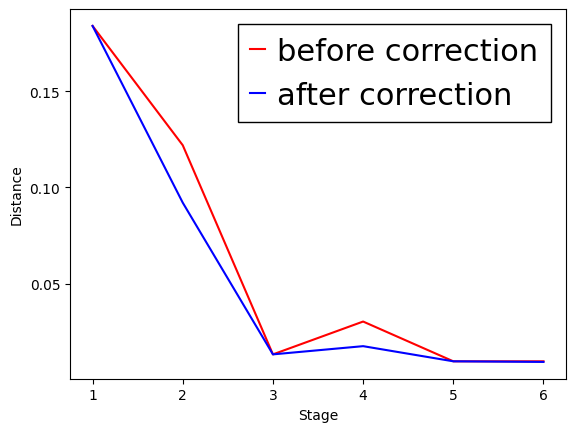

In [17]:
import jax.numpy as jnp
from scipy.interpolate import griddata

dis1_list = []
dis2_list = []

num_top = 1
for i in range(n_stage):
    # 找到初步估计的中心点 indices
    indices = jnp.argpartition(posterior_list[i].ravel(), -num_top)[-num_top:]
    multi_indices = jnp.unravel_index(indices, posterior_list[i].shape)
    
    average_x = int(jnp.mean(multi_indices[0]))
    average_y = int(jnp.mean(multi_indices[1]))
    
    # 定义 5x5 的范围
    x_range = jnp.arange(max(0, average_x - 2), min(posterior_list[i].shape[0], average_x + 3))
    y_range = jnp.arange(max(0, average_y - 2), min(posterior_list[i].shape[1], average_y + 3))
    
    # 获取5x5的网格点
    x_grid, y_grid = jnp.meshgrid(x_range, y_range, indexing='ij')
    x_grid_flat = x_grid.ravel()
    y_grid_flat = y_grid.ravel()
    
    # 提取对应的 posterior 值
    grid_points = jnp.stack((x_grid_flat, y_grid_flat), axis=-1)
    grid_values = posterior_list[i][x_grid_flat, y_grid_flat]
    
    # 插值：创建细化的网格以提升精度
    fine_x = jnp.linspace(x_range.min(), x_range.max(), 50)
    fine_y = jnp.linspace(y_range.min(), y_range.max(), 50)
    fine_x_grid, fine_y_grid = jnp.meshgrid(fine_x, fine_y, indexing='ij')
    fine_points = jnp.stack((fine_x_grid.ravel(), fine_y_grid.ravel()), axis=-1)
    
    interpolated_values = griddata(grid_points, grid_values, fine_points, method='cubic')
    interpolated_values = interpolated_values.reshape(fine_x_grid.shape)
    
    # 找到插值后最大值的坐标
    max_index = jnp.unravel_index(jnp.argmax(interpolated_values), interpolated_values.shape)
    max_x, max_y = fine_x_grid[max_index], fine_y_grid[max_index]
    
    # 输出新的估计中心
    estimated_center_post1 = jnp.array([max_x, max_y]) / 50
    
    distance1 = jnp.sqrt(jnp.sum((center - estimated_center_post1)**2))
    dis1_list.append(distance1)

    
    
    # 找到初步估计的中心点 indices
    indices = jnp.argpartition(posterior_oed_list[i].ravel(), -num_top)[-num_top:]
    multi_indices = jnp.unravel_index(indices, posterior_oed_list[i].shape)
    
    average_x = int(jnp.mean(multi_indices[0]))
    average_y = int(jnp.mean(multi_indices[1]))
    
    # 定义 5x5 的范围
    x_range = jnp.arange(max(0, average_x - 2), min(posterior_oed_list[i].shape[0], average_x + 3))
    y_range = jnp.arange(max(0, average_y - 2), min(posterior_oed_list[i].shape[1], average_y + 3))
    
    # 获取5x5的网格点
    x_grid, y_grid = jnp.meshgrid(x_range, y_range, indexing='ij')
    x_grid_flat = x_grid.ravel()
    y_grid_flat = y_grid.ravel()
    
    # 提取对应的 posterior 值
    grid_points = jnp.stack((x_grid_flat, y_grid_flat), axis=-1)
    grid_values = posterior_oed_list[i][x_grid_flat, y_grid_flat]
    
    # 插值：创建细化的网格以提升精度
    fine_x = jnp.linspace(x_range.min(), x_range.max(), 50)
    fine_y = jnp.linspace(y_range.min(), y_range.max(), 50)
    fine_x_grid, fine_y_grid = jnp.meshgrid(fine_x, fine_y, indexing='ij')
    fine_points = jnp.stack((fine_x_grid.ravel(), fine_y_grid.ravel()), axis=-1)
    
    interpolated_values = griddata(grid_points, grid_values, fine_points, method='cubic')
    interpolated_values = interpolated_values.reshape(fine_x_grid.shape)
    
    # 找到插值后最大值的坐标
    max_index = jnp.unravel_index(jnp.argmax(interpolated_values), interpolated_values.shape)
    max_x, max_y = fine_x_grid[max_index], fine_y_grid[max_index]
    
    # 输出新的估计中心
    estimated_center_post2 = jnp.array([max_x, max_y]) / 50
    
    distance2 = jnp.sqrt(jnp.sum((center - estimated_center_post2)**2))
    dis2_list.append(distance2)
    
    if distance2-distance1<0:
        mec_quality = 'bad'
    else:
        mec_quality = 'good'

    if i == 0:
        print(f'stage {i}, estimated_center is {estimated_center_post2}, distance is {distance2}')
    else:
        print(f'stage {i}, estimated_center is {estimated_center_post2}, distance before correction is {distance2}, distance after correction is {distance1}, correction is {mec_quality}')

plt.plot(dis2_list,color='r',label='before correction')
plt.plot(dis1_list,color='b',label='after correction')
plt.rc('font', size=22)
plt.xticks([0,1,2,3,4,5],labels=[1,2,3,4,5,6])
plt.legend(
    frameon=True,
    framealpha=1.0,
    edgecolor='black',
    borderpad=0.4,
    handlelength=0.5,
    fancybox=False,  # 设置图例框为方形
    handletextpad=0.4  # 调整图标和文字之间的距离
)
plt.xlabel("Stage")
plt.ylabel("Distance")
plt.show()

In [18]:
from scipy.stats import chi2

std_unc1 = np.zeros(n_stage)
std_unc2 = np.zeros(n_stage)
std_unc3 = np.zeros(n_stage)

for i in range(n_stage):
    posterior = posterior_list[i]
    
    # 步骤2：生成对应的参数网格
    n_points = posterior.shape[0]  # 假设为 51
    x = np.linspace(0, 1, n_points)
    y = np.linspace(0, 1, n_points)
    x_grid, y_grid = np.meshgrid(x, y)
    
    # 将网格展开成一维数组（参数点的位置）
    x_flat = x_grid.flatten()
    y_flat = y_grid.flatten()
    posterior_flat = posterior.flatten()
    
    # 计算均值（限制性2）
    mean_x = np.sum(x_flat * posterior_flat)
    mean_y = np.sum(y_flat * posterior_flat)
    
    # 计算协方差矩阵元素
    cov_xx = np.sum((x_flat - mean_x) ** 2 * posterior_flat)
    cov_yy = np.sum((y_flat - mean_y) ** 2 * posterior_flat)
    cov_xy = np.sum((x_flat - mean_x) * (y_flat - mean_y) * posterior_flat)
    
    # 构造协方差矩阵
    cov_matrix = np.array([
        [cov_xx, cov_xy],
        [cov_xy, cov_yy]
    ])
    
    # 步骤3：执行PCA
    # 计算协方差矩阵的特征值和特征向量
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    
    # 按特征值从大到小排序
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    std_unc1[i]=(eigenvalues[0]*eigenvalues[1])**(1/4)
    std_unc2[i]=(eigenvalues[0]+eigenvalues[1])/2
    
    # 输出PCA结果
    print((eigenvalues[0]*eigenvalues[1])**(1/4),(eigenvalues[0]+eigenvalues[1])/2)
    
    # 置信水平
    confidence_level = 0.95
    chi2_value = chi2.ppf(confidence_level, df=2)  # 自由度为2的卡方分布
    scaling_factor = np.sqrt(chi2_value)
    
    # 计算置信椭圆面积作为标量
    confidence_metric = np.pi * np.sqrt(eigenvalues[0] * eigenvalues[1]) * scaling_factor
    print(f"Confidence Metric (area): {np.sqrt(confidence_metric/np.pi)}")

    std_unc3[i]=np.sqrt(confidence_metric/np.pi)

0.1278148990700709 0.016336689160312085
Confidence Metric (area): 0.19996994625320197
0.03257947898004864 0.0012200140488745907
Confidence Metric (area): 0.0509714963435212
0.01613684636053549 0.0003604622966594211
Confidence Metric (area): 0.025246542640098728
0.013343788939571994 0.00019765388612188602
Confidence Metric (area): 0.02087672702066941
0.011986276581244433 0.00014808696174168536
Confidence Metric (area): 0.018752861373488496
0.010699094442779397 0.00011501206742346083
Confidence Metric (area): 0.016739029301330585


In [53]:
dis1_list

[Array(0.18391845, dtype=float32),
 Array(0.0920157, dtype=float32),
 Array(0.01316605, dtype=float32),
 Array(0.01743437, dtype=float32),
 Array(0.00955925, dtype=float32),
 Array(0.00924022, dtype=float32)]

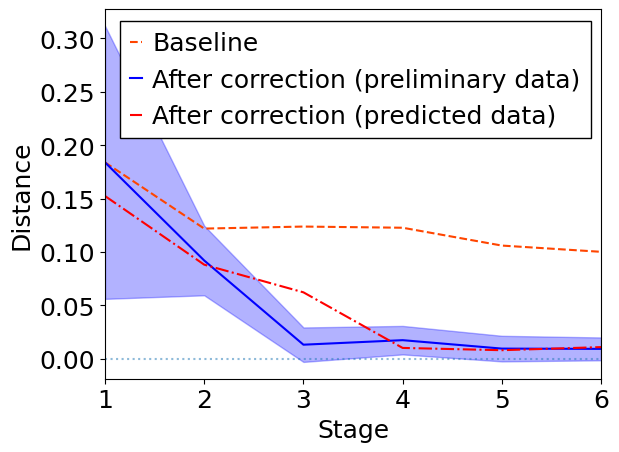

In [25]:
plt.rc('font', size=18)#22)

distance_base = [0.1839,0.1219,0.1238,0.1227,0.1060,0.10015]

plt.plot(range(n_stage), distance_base, label="Baseline", linestyle='--',color='orangered')

dis1_list = [0.1839, 0.0920, 0.01316, 0.0174, 0.0095, 0.00924]
plt.plot(dis1_list,color='b',label='After correction (preliminary data)')


dis2_list = [0.1524, 0.0881, 0.0622, 0.01013, 0.0080, 0.0109]
plt.plot(dis2_list,color='r',linestyle='-.',label='After correction (predicted data)')

plt.xlim([0,5])
plt.xticks(ticks=[0,1,2,3,4,5],labels=[1,2,3,4,5,6])
plt.xlabel('Stage')
plt.ylabel('Distance')
#plt.yticks([0.14,0.12,0.10,0.08,0.06,0.04,0.02])
#plt.legend(
#    frameon=True,
#    framealpha=1.0,
#    edgecolor='black',
#    borderpad=0.4,
#    handlelength=0.5,
#    fancybox=False,  # 设置图例框为方形
#    handletextpad=0.4  # 调整图标和文字之间的距离
#)
plt.legend(
    loc=(0.03,0.65),#(-0.1, 1.05),  # 手动调整图例的位置，x 和 y 取值范围是 [0,1]
    frameon=True,
    framealpha=1.0,
    edgecolor='black',
    borderpad=0.4,
    handlelength=0.5,
    fancybox=False,
    handletextpad=0.4
)


#plt.fill_between(range(6),dis1_list+2*std_unc1, dis1_list-2*std_unc1, color='b',alpha=0.5)
#plt.fill_between(range(6),dis1_list+3*std_unc2, dis1_list-3*std_unc2, color='b',alpha=0.5)
#plt.fill_between(range(n_stage),dis1_list+1*std_unc3, dis1_list-1*std_unc3, color='b',alpha=0.3)
plt.fill_between(range(n_stage),dis1_list+1*std_unc1, dis1_list-1*std_unc1, color='b',alpha=0.3)



plt.axhline(0.0,linestyle=':',alpha=0.5)
plt.savefig('nn case distance with predicted.png',dpi=300,bbox_inches='tight')

In [73]:
len(design_MEC_trajectory),actual_step

(323, [0, 70, 49, 64, 70, 70])

In [76]:
design_MEC_trajectory[253],design_MEC_trajectory[-1]

(Array([0.30117804, 0.23935655], dtype=float32),
 Array([0.23616154, 0.27445975], dtype=float32))

In [ ]:
design_list,design_MEC_list

(Array([0.30117804, 0.23935655], dtype=float32),
 [Array([0.5, 0.5], dtype=float32),
  Array([0.32696426, 0.32690698], dtype=float32),
  Array([0.22245525, 0.22217366], dtype=float32),
  Array([0.30721295, 0.30114982], dtype=float32),
  Array([0.42020676, 0.16850942], dtype=float32),
  Array([0.29544502, 0.18822312], dtype=float32),
  Array([0.3131783 , 0.22735627], dtype=float32)],
 [Array([0.1408993 , 0.29823673], dtype=float32),
  Array([-0.04278705,  0.4295147 ], dtype=float32),
  Array([ 0.77020675, -0.15895759], dtype=float32),
  Array([0.22597142, 0.2702888 ], dtype=float32),
  Array([0.23616154, 0.27445975], dtype=float32)])

In [67]:
for stage in range(1,n_stage):
    print(int(np.sum(actual_step[:stage])),int(np.sum(actual_step[:stage+1])))
  

0 70
70 119
119 183
183 253
253 323


[0.22597142 0.2702888 ]
[0.23616154 0.27445975]


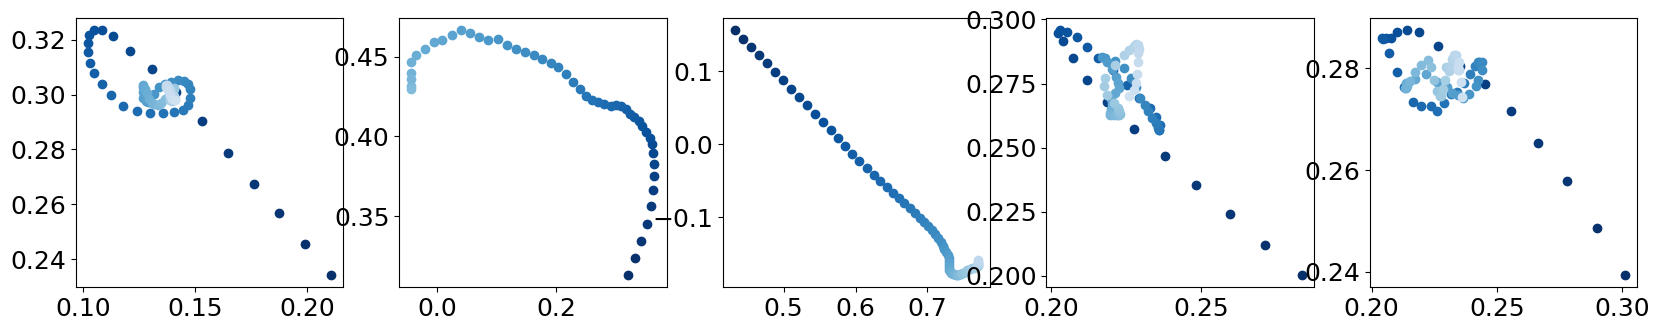

In [66]:
fig, axes = plt.subplots(1, n_stage-1, figsize=(4.03*(n_stage-1), 3.5))
fig.subplots_adjust(wspace=0.21)

colors = plt.cm.Blues(np.linspace(1.0, 0.2, 70))
for stage in range(1,n_stage):
    for i in range(int(np.sum(actual_step[:stage])),int(np.sum(actual_step[:stage+1]))):
        axes[stage-1].scatter(design_MEC_trajectory[i][0], 
               design_MEC_trajectory[i][1], 
               color=colors[i-int(np.sum(actual_step[:stage]))])

        if stage in [4,5]:
            if i == int(np.sum(actual_step[:stage+1])-1):
                print(design_MEC_trajectory[i])

In [23]:
stage = 3
int(np.sum(actual_step[:stage])),int(np.sum(actual_step[:stage+1]))

(40, 40)

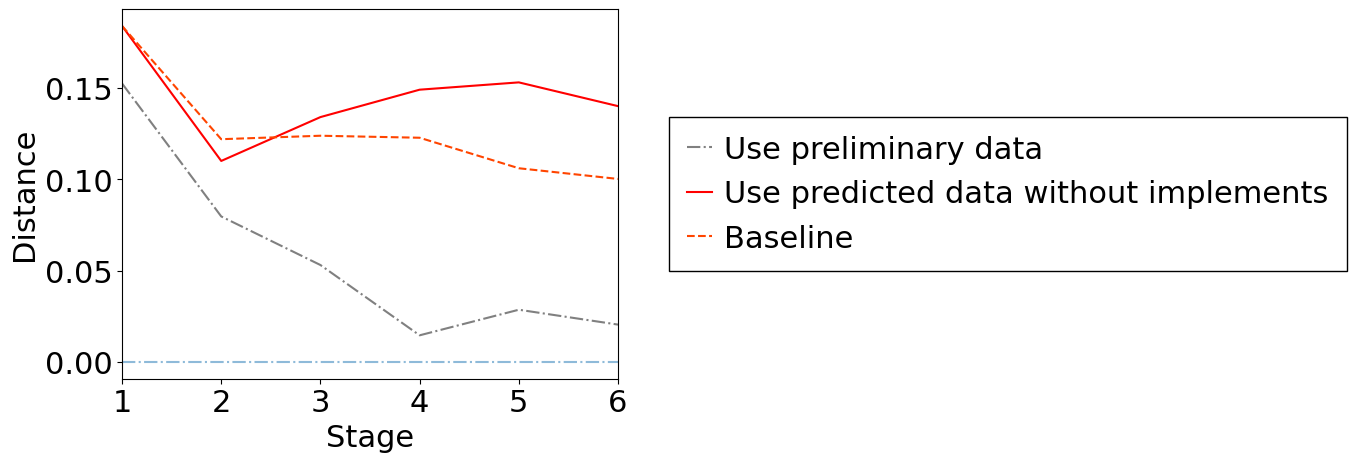

In [24]:
plt.rc('font', size=22)

plt.plot(dis1_list,color='grey',linestyle='-.',label='Use preliminary data')

dis2_list = [0.1839, 0.11, 0.134, 0.149, 0.153, 0.140]
plt.plot(dis2_list,color='r',label='Use predicted data without implements')

distance_base = [0.1839,0.1219,0.1238,0.1227,0.1060,0.10015]

plt.plot(range(n_stage), distance_base, label="Baseline", linestyle='--',color='orangered')

plt.xlim([0,5])
plt.xticks(ticks=[0,1,2,3,4,5],labels=[1,2,3,4,5,6])
plt.xlabel('Stage')
plt.ylabel('Distance')
#plt.yticks([0.14,0.12,0.10,0.08,0.06,0.04,0.02])
plt.legend(
    loc='center right',
    bbox_to_anchor=(2.5, 0.5),
    frameon=True,
    framealpha=1.0,
    edgecolor='black',
    borderpad=0.6,
    handlelength=0.8,
    fancybox=False,  # 设置图例框为方形
    handletextpad=0.4  # 调整图标和文字之间的距离
)


plt.axhline(0.0,linestyle='-.',alpha=0.5)
#plt.savefig('nn case distance.png',dpi=300,bbox_inches='tight')

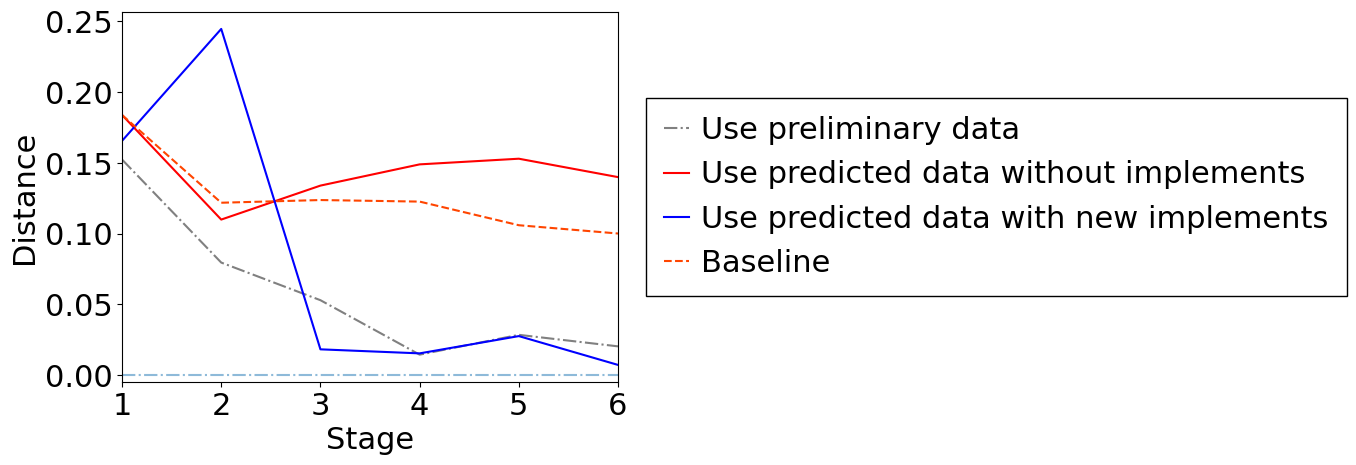

In [25]:
plt.rc('font', size=22)

plt.plot(dis1_list,color='grey',linestyle='-.',label='Use preliminary data')

dis2_list = [0.1839, 0.11, 0.134, 0.149, 0.153, 0.140]
plt.plot(dis2_list,color='r',label='Use predicted data without implements')

dis2_list = [0.1656, 0.2447, 0.01832, 0.01547, 0.02767, 0.007307]
plt.plot(dis2_list,color='b',label='Use predicted data with new implements')

distance_base = [0.1839,0.1219,0.1238,0.1227,0.1060,0.10015]

plt.plot(range(n_stage), distance_base, label="Baseline", linestyle='--',color='orangered')

plt.xlim([0,5])
plt.xticks(ticks=[0,1,2,3,4,5],labels=[1,2,3,4,5,6])
plt.xlabel('Stage')
plt.ylabel('Distance')
#plt.yticks([0.14,0.12,0.10,0.08,0.06,0.04,0.02])
plt.legend(
    loc='center right',
    bbox_to_anchor=(2.5, 0.5),
    frameon=True,
    framealpha=1.0,
    edgecolor='black',
    borderpad=0.6,
    handlelength=0.8,
    fancybox=False,  # 设置图例框为方形
    handletextpad=0.4  # 调整图标和文字之间的距离
)


plt.axhline(0.0,linestyle='-.',alpha=0.5)
#plt.savefig('nn case distance.png',dpi=300,bbox_inches='tight')

In [43]:
dis1_list # approach 1

[Array(0.18391845, dtype=float32),
 Array(0.0920157, dtype=float32),
 Array(0.01316605, dtype=float32),
 Array(0.01743437, dtype=float32),
 Array(0.00955925, dtype=float32),
 Array(0.00924022, dtype=float32)]

In [35]:
dis1_list # approach 2

[Array(0.15242179, dtype=float32),
 Array(0.07566175, dtype=float32),
 Array(0.03796688, dtype=float32),
 Array(0.01092554, dtype=float32),
 Array(0.01378421, dtype=float32),
 Array(0.01962796, dtype=float32)]

In [29]:
dis1_list # approach 3

[Array(0.15242179, dtype=float32),
 Array(0.07962269, dtype=float32),
 Array(0.05303686, dtype=float32),
 Array(0.01456007, dtype=float32),
 Array(0.02856706, dtype=float32),
 Array(0.02042655, dtype=float32)]

In [44]:
dis1_list # 对应的seed和center true oed

[Array(0.15242179, dtype=float32),
 Array(0.08812403, dtype=float32),
 Array(0.06222381, dtype=float32),
 Array(0.01013449, dtype=float32),
 Array(0.00800357, dtype=float32),
 Array(0.01092554, dtype=float32)]

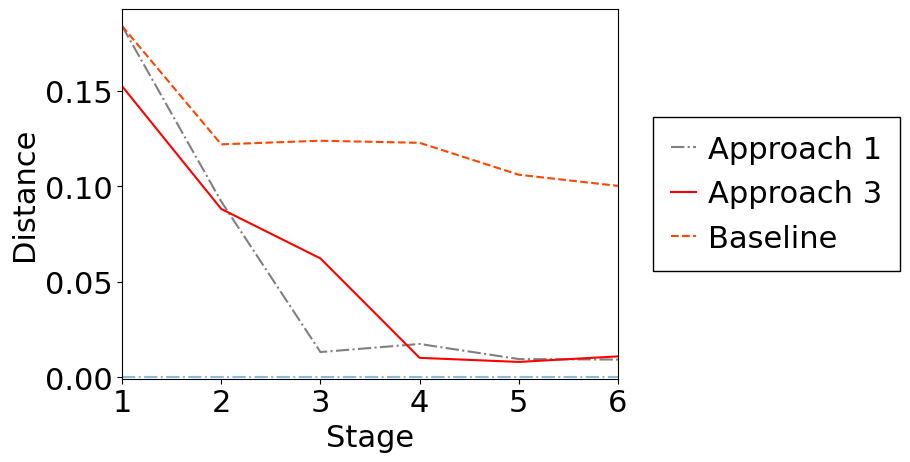

In [46]:
plt.rc('font', size=22)

dis2_list = [0.1839, 0.0920, 0.01316, 0.0174, 0.0095, 0.00924]
plt.plot(dis2_list,color='grey',linestyle='-.',label='Approach 1')

#dis2_list = [0.1524, 0.0756, 0.0379, 0.0109, 0.0137, 0.0196]
#plt.plot(dis2_list,color='b',label='Approach 2')

#dis2_list = [0.1524, 0.0796, 0.0530, 0.0145, 0.0285, 0.0204]
dis2_list = [0.1524, 0.0881, 0.0622, 0.01013, 0.0080, 0.0109]
plt.plot(dis2_list,color='r',label='Approach 3')

distance_base = [0.1839,0.1219,0.1238,0.1227,0.1060,0.10015]

plt.plot(range(n_stage), distance_base, label="Baseline", linestyle='--',color='orangered')

plt.xlim([0,5])
plt.xticks(ticks=[0,1,2,3,4,5],labels=[1,2,3,4,5,6])
plt.xlabel('Stage')
plt.ylabel('Distance')
#plt.yticks([0.14,0.12,0.10,0.08,0.06,0.04,0.02])
plt.legend(
    loc='center right',
    bbox_to_anchor=(1.6, 0.5),
    frameon=True,
    framealpha=1.0,
    edgecolor='black',
    borderpad=0.6,
    handlelength=0.8,
    fancybox=False,  # 设置图例框为方形
    handletextpad=0.4  # 调整图标和文字之间的距离
)


plt.axhline(0.0,linestyle='-.',alpha=0.5)
#plt.savefig('nn case distance.png',dpi=300,bbox_inches='tight')

In [10]:
with open('all_data_nn_case_seed_2019_truePhy_trueNet_test10_changeCenter0.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# 访问读取的数据
posterior_list = loaded_data["posterior_list"]
posterior_oed_list = loaded_data["posterior_oed_list"]
design_list = loaded_data["design_list"]
params_list = loaded_data["params_list"]
estimated_posterior_point = loaded_data["estimated_posterior_point"]
design_MEC_trajectory = loaded_data["design_MEC_trajectory"]
design_MEC_list = loaded_data["design_MEC_list"]
observation_MEC_list = loaded_data["observation_MEC_list"]
actual_step = loaded_data["actual_step"]
    

In [33]:
# 每一阶段重新运行一个oed，用上一阶段没有修改过的网络，这样才能够比较correction对于下一阶段oed的影响

posterior_oed_list_special = []
design_list_special = []

for stage in range(2,n_stage):
        
    print('\n stage = ', stage, '\n')
    key_for_design = random.split(key[stage*2],iteration_step_number1[stage])
    key_for_param = random.split(key[stage*2+1],(iteration_step_number2[stage]+1))
    

    d_start = design_list[stage] # 使用当前正常的起点
    params = params_list[stage-2] # 使用上一阶段没有修改过的网络
    prior = posterior_oed_list[stage-1] # 使用上一阶段没有做correction的后验
    
    clip_count = 0
    
    if stage!=0:
        try:
            del tx1
            del opt_state1
        except NameError:
            pass
    else:
        print(f'stage = 0, only run forward model and update posterior')
        
    tx1 = optax.chain(
    optax.adam(learning_rate1),  # 使用由 lr_schedule1 调整的学习率的 Adam 优化器
    optax.add_decayed_weights(1e-4)  # 添加权重衰减，衰减系数为 1e-5
    )
    
    opt_state1 = tx1.init(d_start)
    
    d_limit_min = d_start - d_change_range
    d_limit_max = d_start + d_change_range
    
    start_time = time.time()
    d_start_backup = d_start

    print('start learning design')
    print(f'start design : ', d_start)

    ## 平滑先验
    #if stage != 0:
    #    prior = log_transform_prior(prior, epsilon=1e-6, alpha=0.9)

    for i in range(iteration_step_number1[stage]):
        print('-',end='')

    print('|')
    
    for i in range(iteration_step_number1[stage]):
       # negtive_KLD, grad_design = jax.value_and_grad(loss_design)(d_start, params, stage, center, prior, noise_info, num_d, radio_d, key_for_design[i], model)
        if stage in []:
            negtive_KLD, grad_design = jax.value_and_grad(loss_design)(d_start, params, stage, center, prior, noise_info, num_d, radio_d, key_for_design[i], model)
        else:
            #negtive_KLD, grad_design = jax.value_and_grad(loss_design_trueOED)(d_start, params, stage, center, prior, noise_info, num_d, radio_d, key_for_design[i], model, multi_indices)
            negtive_KLD, grad_design = jax.value_and_grad(loss_design_trueOED_modified4)(d_start)
        
        
        
        
        updates, opt_state1 = tx1.update(grad_design, opt_state1, params=d_start)

        
        # 解决nan的问题
        oed_nan_index = 0
        updates_contain_nans = any(jnp.any(jnp.isnan(u)) for u in jax.tree_util.tree_leaves(updates))
        if updates_contain_nans:
            oed_nan_index = oed_nan_index + 1
            print(f'NaN appears in learning. Perturb params and continue. Nan count: {oed_nan_index}')
            noise = 0.05*jax.random.normal(key_for_design[i], d_start.shape)
            d_start = d_start+ noise
        else:
            oed_nan_index = 0
            d_start = optax.apply_updates(d_start, updates)
    
        d_start_before_clip = d_start
        d_start = jnp.clip(d_start, d_limit_min, d_limit_max)
        
        # 如果clip函数生效，即有参数被裁剪，增加计数器
        clip_count = 0
        if not jnp.all(d_start == d_start_before_clip):
            clip_count += 1
        else:
            clip_count = 0
            
        if clip_count >= 5:
            print(f"Stopping iteration at step {i} as clip function has been activated 5 times.")
            break
        
        if np.isnan(d_start).any() or np.isnan(negtive_KLD).any():
            print('some results are Nan')
            break
    
        #KLD_list.append(-negtive_KLD)
        
        if oed_nan_index > 6:
            print('连续出现nam并扰动6次，停止oed')
            break

        print('.',end='')
            
            
    end_time = time.time()
    print(f"Execution learning design time: {end_time - start_time} seconds")
    print('Current design = ', d_start)

    #if stage!=0:
    _, posterior = forward_posterior_infoGain(params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], model)
    
    posterior_oed_list_special.append(posterior)

    design_list_special.append(d_start)


 stage =  2 

start learning design
start design :  [0.22245525 0.22217366]
----------------------------------------|
........................................Execution learning design time: 122.26767945289612 seconds
Current design =  [0.12414627 0.13984434]

 stage =  3 

start learning design
start design :  [0.30721295 0.30114982]
----------------------------------------|
........................................Execution learning design time: 114.02809500694275 seconds
Current design =  [0.2878594  0.18790755]

 stage =  4 

start learning design
start design :  [0.42020676 0.16850942]
----------------------------------------|
........................................Execution learning design time: 115.7761640548706 seconds
Current design =  [0.3066044  0.13387428]

 stage =  5 

start learning design
start design :  [0.29544502 0.18822312]
----------------------------------------|
........................................Execution learning design time: 115.08081221580505 seconds
Cur

In [38]:
# 检查下一阶段design附近的场
for stage in range(2,n_stage):
    # 新的design新的网络
    xc, yc =design_list[stage+1]*50+100
    range_xy = 2
    u_t1 = sealed_convection_diffusion_true(d_start, center, stage)[1][(int(xc)-range_xy):(int(xc)+range_xy),(int(yc)-range_xy):(int(yc)+range_xy)]
    u_design_10 = sealed_convection_diffusion_nn(params_list[stage-1], d_start, center, stage, model)[1][(int(xc)-range_xy):(int(xc)+range_xy),(int(yc)-range_xy):(int(yc)+range_xy)]
    
    xc, yc =design_list_special[stage-2]*50+100
    u_t2 = sealed_convection_diffusion_true(d_start, center, stage)[1][(int(xc)-range_xy):(int(xc)+range_xy),(int(yc)-range_xy):(int(yc)+range_xy)]
    u_design_8 = sealed_convection_diffusion_nn(params_list[stage-2], d_start, center, stage, model)[1][(int(xc)-range_xy):(int(xc)+range_xy),(int(yc)-range_xy):(int(yc)+range_xy)]
    
    print('2, old design old net. 3, new design new net')
    print('Design next stage MSE: ', np.sum((u_t2 - u_design_8)**2)/5,',',np.sum((u_t1 - u_design_10)**2)/5)
    print('Design next stage RE: ', np.sum(np.abs(u_t2 - u_design_8))/np.sum(np.abs(u_t2)),',',np.sum(np.abs(u_t1 - u_design_10))/np.sum(np.abs(u_t1)))

2, old design old net. 3, new design new net
Design next stage MSE:  0.046232797 , 0.050351884
Design next stage RE:  0.5556469 , 0.22458029
2, old design old net. 3, new design new net
Design next stage MSE:  0.19520661 , 0.056987215
Design next stage RE:  0.5089169 , 0.4674325
2, old design old net. 3, new design new net
Design next stage MSE:  0.10323999 , 0.047764026
Design next stage RE:  0.52149534 , 0.24404031
2, old design old net. 3, new design new net
Design next stage MSE:  0.046524473 , 0.0024981312
Design next stage RE:  0.23614573 , 0.039605223


In [143]:
import pickle

# 打开保存的数据文件
with open('all_data_nn_case_seed_2019_randomEach_lr0p012_accurateCenterEsti_useHistorical_fineTune2_gd3.pkl', 'rb') as f:
#with open('all_data_nn_case_seed_2019_truePhy_trueNet_test10_changeCenter0.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# 访问读取的数据
posterior_list = loaded_data["posterior_list"]
posterior_oed_list = loaded_data["posterior_oed_list"]
design_list = loaded_data["design_list"]
params_list = loaded_data["params_list"]
estimated_posterior_point = loaded_data["estimated_posterior_point"]
design_MEC_trajectory = loaded_data["design_MEC_trajectory"]
actual_step = loaded_data["actual_step"]
design_MEC_list = loaded_data["design_MEC_list"]
observation_MEC_list = loaded_data["observation_MEC_list"] 

In [14]:
np.max(posterior_list)

0.36186838

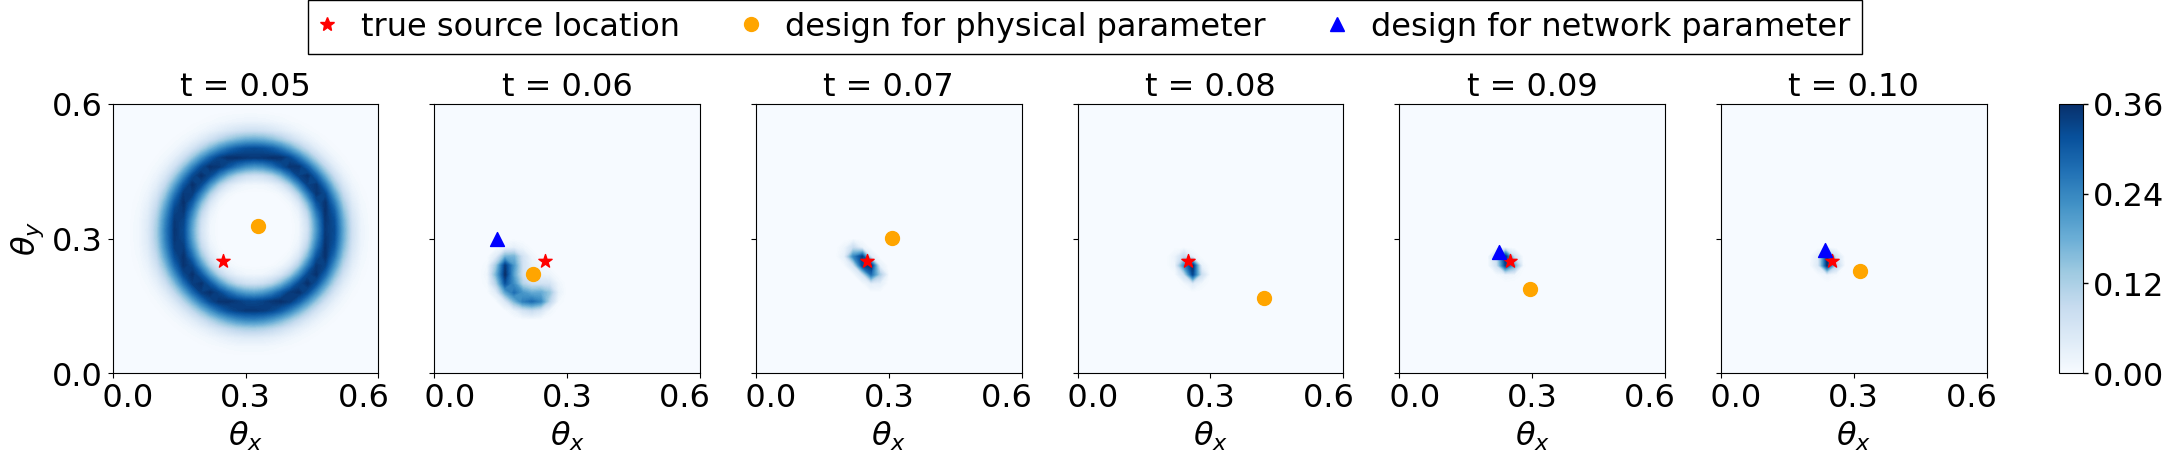

In [49]:
import numpy as np
import jax.numpy as jnp


n_stage =6
local_size = 51
#center = jnp.array([0.25,0.25])

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib.colors import LinearSegmentedColormap

stage_to_plot = [0,1,2,3,4,5]

fig, axes = plt.subplots(1, len(stage_to_plot), figsize=(4.03*len(stage_to_plot), 3.5))
fig.subplots_adjust(wspace=0.21)

# fig.subplots_adjust(left = 0.05, right = 0.9, wspace=0.3)

grid_x_plot0, grid_y_plot0 = np.meshgrid(np.linspace(0, 1, local_size), np.linspace(0, 1, local_size))

        
fontsize = 23
pic_num=0

# 内置颜色图
cmap = 'Blues'#'PuBu'#'pink'#'GnBu'#'Greens'#
star_color = 'r'#'magenta'#'y'#'#F89054'#


def custom_formatter(x, pos):
    if x == 0.0:
        return '   0.0'  # 向右移动
    elif x == 0.6:
        return '0.6   '  # 向左移动
    elif x == 0.3:
        return '0.3'
    else:
        return f'{x:.2f}'


for stage in stage_to_plot:
    d_start = design_list[stage+1]
    d_start_backup = design_list[stage]
    contour=axes[pic_num].contourf(grid_x_plot0, grid_y_plot0, posterior_list[stage].T, levels=100,cmap=cmap)#plasma' )
    axes[pic_num].scatter(d_start[0], d_start[1], marker='o', s=100, c='orange')
    
    axes[pic_num].scatter(center[0], center[1], marker='*', s=100, c=star_color)
    #axes[pic_num].plot([d_start[0],d_start_backup[0]],[d_start[1],d_start_backup[1]], c='orangered')
    axes[pic_num].set_title(f't = {((stage+1)*10+40)*0.001:.2f}', fontsize=fontsize)  # 设置子图的标题
    axes[pic_num].set_xlabel('$\\theta_x$', fontsize=fontsize)  # 设置x轴标签
    axes[pic_num].set_yticks([0.0, 0.3,0.6])
    if stage == 0:
        axes[pic_num].set_ylabel('$\\theta_y$', fontsize=fontsize)  # 设置y轴标签
    else:
        axes[pic_num].set_yticklabels([]) 
        
    axes[pic_num].tick_params(axis='both', which='major', labelsize=fontsize)
    axes[pic_num].set_xticks([0.0,0.3,0.6])
    axes[pic_num].xaxis.set_major_formatter(FuncFormatter(custom_formatter))
    axes[pic_num].set_xlim([0.0,0.6])
    axes[pic_num].set_ylim([0.0,0.6])
    
    if stage_to_skip == []:
        axes[pic_num].scatter(design_MEC_list[stage][0], design_MEC_list[stage][1], marker='^', s=100, c='blue')
    else:
        if stage not in stage_to_skip:
            #axes[stage].scatter(design_MEC_trajectory[np.sum(actual_step[:stage+1])-1][0], design_MEC_trajectory[np.sum(actual_step[:stage+1])-1][1], marker='^', s=100, c='blue')
            axes[pic_num].scatter(design_MEC_list[stage-1][0], design_MEC_list[stage-1][1], marker='^', s=100, c='blue')
            
    pic_num=pic_num+1

cbar_ax = fig.add_axes([0.93, 0.11, 0.01, 0.77])  # [left, bottom, width, height]
contour_set = plt.cm.ScalarMappable(cmap=cmap)#'plasma')
contour_set.set_array(posterior_list[stage])

contour_set.set_clim(0, 0.36) # 使用测量数据
ticks = [0, 0.12, 0.24, 0.36]
#contour_set.set_clim(0, 0.27) # 使用预测数据
#ticks = [0, 0.09, 0.18, 0.27]

cbar = fig.colorbar(contour_set, cax=cbar_ax, orientation='vertical', shrink=0.4, aspect=20, pad=0.06)
cbar.ax.tick_params(labelsize=fontsize, width=1)
cbar.set_ticks(ticks)
cbar.update_ticks()

plt.plot([], [], marker='*', markersize=10, color=star_color, linestyle='None', label='true source location')
plt.plot([], [], marker='o', markersize=10, color='orange', linestyle='None', label='design for physical parameter')

plt.plot([], [], marker='^', markersize=10, color='b', linestyle='None', label='design for network parameter')

legend = plt.legend(
    loc='center',
    bbox_to_anchor=(0.527, 1.1),  # 仅调整纵坐标位置，使其离上面远一点，离下面近一点
    ncol=3,
    frameon=True,
    framealpha=1,
    edgecolor='black',
    fontsize=fontsize,
    borderpad=0.05, handlelength=0.5,
    bbox_transform=fig.transFigure  # 将定位转换为相对于整个图形
)
legend.get_frame().set_edgecolor('black')  # 设置边框颜色为黑色
legend.get_frame().set_linewidth(1)  # 设置边框线宽为1
legend.get_frame().set_boxstyle("Square")


#plt.savefig('nn case posterior.png',bbox_inches='tight')
#plt.savefig('nn case posterior predicted.png',bbox_inches='tight')

In [98]:
# 画出中间的design

stage = 3
start_index = int(np.sum(actual_step[:stage]))
end_index = int(np.sum(actual_step[:stage+1]))-2
print(start_index, end_index)
params = params_list[stage-1]

d1 = design_list[stage+1]#design_MEC_trajectory[start_index]
d2 = design_MEC_trajectory[int(start_index+(end_index-start_index)/4)-1]
d3 = design_MEC_trajectory[end_index]

estimated_center = estimated_posterior_point[stage]
mean_array = reconstruct_dict_to_array(params)
key_ensemble_pass, key_ensemble_pass_sub = random.split(key[-1])
kld_array = np.zeros((9,50))

for j in range(50):
    print('-', end='')

print('|')

for j in range(50):
    key_ensemble_pass, key_ensemble_pass_sub = random.split(key_ensemble_pass)
    key_ensemble = random.split(key_ensemble_pass_sub, 40)
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_ensemble, mean_array, 0.3)
    
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    
    
    u_his = loss_function_hist(d1, center, estimated_center, 0.0002)
    
    for i in range(3):
        updated_mu = jnp.mean(u_his[i], axis=0)  # 取最后一步
        updated_sigma = jnp.cov(u_his[i], rowvar=False)
    
        kld_array[i,j] = -kl_divergence(updated_mu, updated_sigma, initial_mu, initial_sigma)
    
    u_his = loss_function_hist(d2, center, estimated_center, 0.0002)
    
    for i in range(3):
        updated_mu = jnp.mean(u_his[i], axis=0)  # 取最后一步
        updated_sigma = jnp.cov(u_his[i], rowvar=False)
    
        kld_array[i+3,j] = -kl_divergence(updated_mu, updated_sigma, initial_mu, initial_sigma)
    
    u_his = loss_function_hist(d3, center, estimated_center, 0.0002)
    
    for i in range(3):
        updated_mu = jnp.mean(u_his[i], axis=0)  # 取最后一步
        updated_sigma = jnp.cov(u_his[i], rowvar=False)
    
        kld_array[i+6,j] = -kl_divergence(updated_mu, updated_sigma, initial_mu, initial_sigma)

    print('.', end='')

119 181
--------------------------------------------------|
..................................................

In [ ]:
# 保存数据
import pickle

numpy_list = [np.array(arr) for arr in posterior_list]
data_to_save = {
    "posterior_oed_list_special": posterior_oed_list_special,
    "design_list_special": design_list_special,
    "kld_array": kld_array,
}

with open('all_data_nn_case_seed_2019_randomEach_lr0p012_accurateCenterEsti_useHistorical_fineTune2_gd3_additional.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

In [99]:
# 保存数据
import pickle

numpy_list = [np.array(arr) for arr in posterior_list]
data_to_save = {
    "kld_array": kld_array,
}

with open('all_data_nn_case_seed_2019_randomEach_lr0p012_accurateCenterEsti_useHistorical_fineTune2_gd3_additional_updated.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [139]:
with open('all_data_nn_case_seed_2019_randomEach_lr0p012_accurateCenterEsti_useHistorical_fineTune2_gd3_additional_updated.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# 访问读取的数据
kld_array = loaded_data["kld_array"]
    

In [83]:
start_index, int(start_index+(end_index-start_index)/4)

(119, 134)

In [84]:
d2

Array([ 0.59547585, -0.01308933], dtype=float32)

In [80]:
design_MEC_trajectory[start_index], design_list

(Array([0.43220705, 0.15650915], dtype=float32),
 [Array([0.5, 0.5], dtype=float32),
  Array([0.32696426, 0.32690698], dtype=float32),
  Array([0.22245525, 0.22217366], dtype=float32),
  Array([0.30721295, 0.30114982], dtype=float32),
  Array([0.42020676, 0.16850942], dtype=float32),
  Array([0.29544502, 0.18822312], dtype=float32),
  Array([0.3131783 , 0.22735627], dtype=float32)])

In [60]:
actual_step

[0, 70, 49, 64, 70, 70]

In [144]:
stage = 3
start_index = int(np.sum(actual_step[:stage]))
end_index = int(np.sum(actual_step[:stage+1]))-2
print(start_index, end_index)
params = params_list[stage-1]

d1 = design_MEC_trajectory[start_index]
d2 = design_MEC_trajectory[int(start_index+(end_index-start_index)/4)]
d3 = design_MEC_trajectory[end_index]

119 181


In [55]:
start_index, int(start_index+(end_index-start_index)/4),end_index

(119, 134, 181)

In [6]:
stage = 3
start_index = int(np.sum(actual_step[:stage]))
end_index = int(np.sum(actual_step[:stage+1]))-2

d1 = design_list[stage+1]#design_MEC_trajectory[start_index]
d2 = design_MEC_trajectory[int(start_index+(end_index-start_index)/4)-1]
d3 = design_MEC_trajectory[end_index]

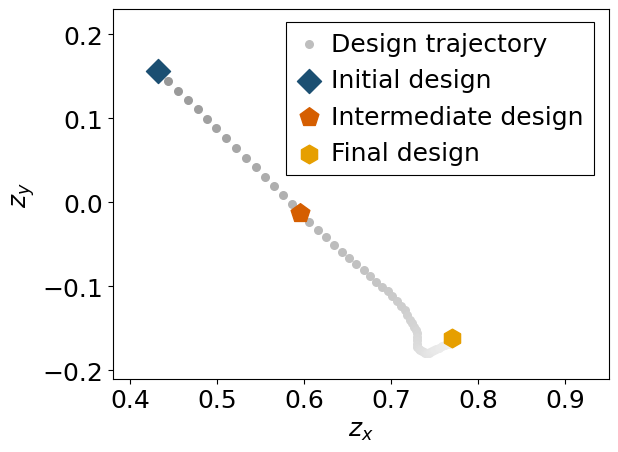

In [145]:
plt.rc('font', size=18)
plt.figure(figsize=(6.4, 4.8))


colors = plt.cm.Greys(np.linspace(0.5, 0.05, 70))
for stage in [3]:
    for i in range(int(np.sum(actual_step[:stage])),int(np.sum(actual_step[:stage+1]))):
        if i == int(np.sum(actual_step[:stage]))+20:
            plt.scatter(design_MEC_trajectory[i][0], 
               design_MEC_trajectory[i][1], 
               color=colors[i-int(np.sum(actual_step[:stage]))],
                   s=30,
                       label='Design trajectory')
        else:
            plt.scatter(design_MEC_trajectory[i][0], 
               design_MEC_trajectory[i][1], 
               color=colors[i-int(np.sum(actual_step[:stage]))],
                   s=30)

plt.scatter(d1[0],d1[1],marker='D',s=150,color='#1B4F72',label='Initial design')
plt.scatter(d2[0],d2[1],marker='p',s=200,color='#D55E00',label='Intermediate design')
plt.scatter(d3[0],d3[1],marker='h',s=180,color='#E69F00',label='Final design')
plt.xlim([0.38,0.95])
plt.ylim([-0.21,0.23])

legend = plt.legend(
    loc=(0.35, 0.55),#(0.02, 0.59),  # 手动调整图例的位置，x 和 y 取值范围是 [0,1]
    frameon=True,
    framealpha=1.0,
    edgecolor='black',
    borderpad=0.4,
    handlelength=1,
    fancybox=False,
    handletextpad=0.4
)
legend.get_frame().set_linewidth(0.8)

plt.xlabel('$z_x$')
plt.ylabel('$z_y$')
plt.savefig('nn case design trajectory.png',dpi=300,bbox_inches='tight')

In [172]:
kld_mean = -np.mean(kld_array, axis=1) # 画图使用 更改了design
kld_reshaped = kld_mean.reshape(3, 3)

kld_with_zeros = np.hstack([np.zeros((3, 1)), kld_reshaped])

result = kld_with_zeros.flatten()

print(result)

[0.         0.33456539 0.94058205 1.58441601 0.         0.46154575
 1.21895435 1.9555941  0.         0.50069622 1.29671757 2.05500568]


In [96]:
kld_mean = -np.mean(kld_array, axis=1) # 最开始选择的design
kld_reshaped = kld_mean.reshape(3, 3)

kld_with_zeros = np.hstack([np.zeros((3, 1)), kld_reshaped])

result = kld_with_zeros.flatten()

print(result)

[0.         0.34105957 0.95405388 1.60126049 0.         0.46687908
 1.230135   1.97016998 0.         0.50069622 1.29671757 2.05500568]


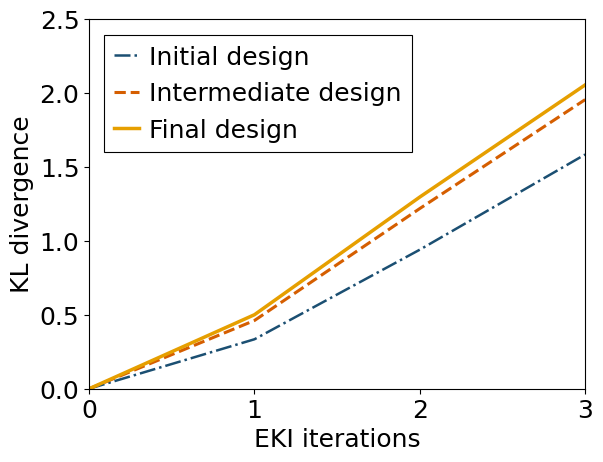

In [148]:
plt.rc('font', size=18)#22)
plt.plot(result[0:4],color='#1B4F72',linestyle='-.',linewidth=1.8,label='Initial design')
plt.plot(result[4:8],color='#D55E00',linestyle='--',linewidth=2.2,label='Intermediate design')
plt.plot(result[8:12],color='#E69F00',linestyle='-',linewidth=2.5,label='Final design')
legend = plt.legend(
    loc=(0.03, 0.64),#(0.02, 0.59),  # 手动调整图例的位置，x 和 y 取值范围是 [0,1]
    frameon=True,
    framealpha=1.0,
    edgecolor='black',
    borderpad=0.4,
    handlelength=1,
    fancybox=False,
    handletextpad=0.4
)
legend.get_frame().set_linewidth(0.8)
plt.xlim([0,3])
plt.xticks([0,1,2,3])
plt.ylim([0,2.5])
plt.xlabel('EKI iterations')
plt.ylabel('KL divergence')
plt.savefig('nn case eki.png',dpi=300,bbox_inches='tight')

In [80]:
7.40+2.47

9.870000000000001

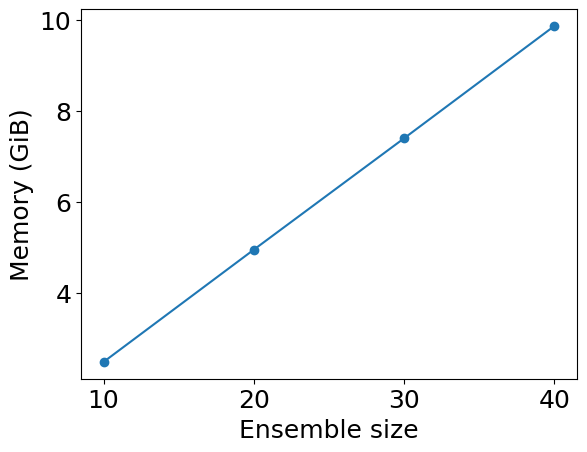

In [172]:
plt.rc('font', size=18)#22)
memory_size = [2.48, 4.95, 7.40, 9.87]
plt.plot([10,20,30,40], memory_size, marker='o',label='Memory cost')
plt.xlabel('Ensemble size')
plt.ylabel('Memory (GiB)')
plt.savefig('memory_cost_size.png',dpi=300,bbox_inches='tight')

Text(0, 0.5, 'Time/s')

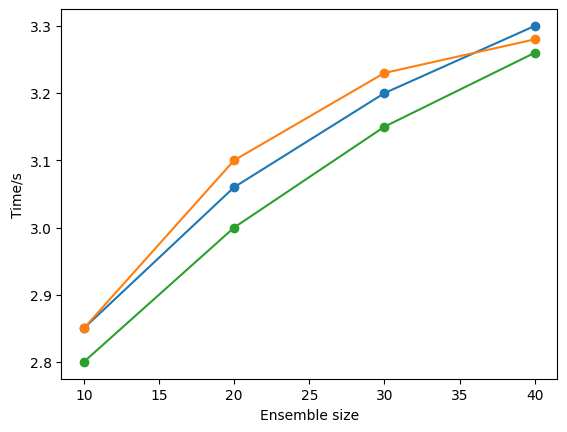

In [116]:
memory_size1 = [2.85, 3.06, 3.2, 3.3]
memory_size2 = [2.85,3.1,3.23,3.28]
memory_size3 = [2.8, 3.0, 3.15, 3.26]
plt.plot([10,20,30,40], memory_size1, marker='o')
plt.plot([10,20,30,40], memory_size2, marker='o')
plt.plot([10,20,30,40], memory_size3, marker='o')
plt.xlabel('Ensemble size')
plt.ylabel('Time/s')

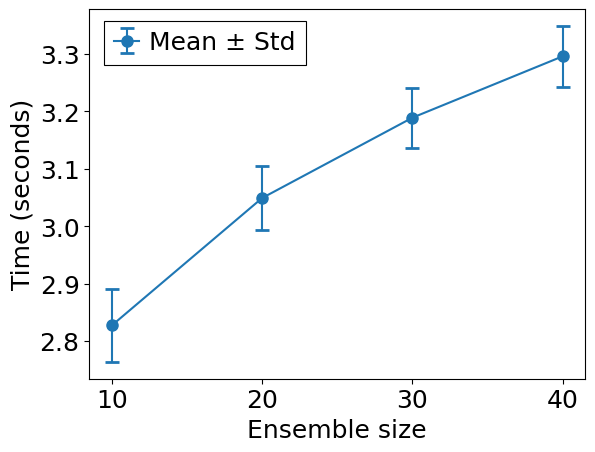

In [3]:
plt.rc('font', size=18)#22)
# 数据
x = [10, 20, 30, 40]
means = [2.827, 3.049, 3.189, 3.296]
stds = [0.0636, 0.0552, 0.0525, 0.0529]

# 画图
plt.errorbar(x, means, yerr=stds, fmt='o-', capsize=5, capthick=2, elinewidth=1.5, markersize=8, label='Mean ± Std')

# 图例和标签
plt.xlabel('Ensemble size')
plt.ylabel('Time (seconds)')
plt.xticks(x)

legend = plt.legend(
    loc=(0.03, 0.85),#(0.02, 0.59),  # 手动调整图例的位置，x 和 y 取值范围是 [0,1]
    frameon=True,
    framealpha=1.0,
    edgecolor='black',
    borderpad=0.4,
    handlelength=1,
    fancybox=False,
    handletextpad=0.4
)
legend.get_frame().set_linewidth(0.8)

# 显示图
plt.savefig('time_cost_size.png',dpi=300,bbox_inches='tight')
plt.show()


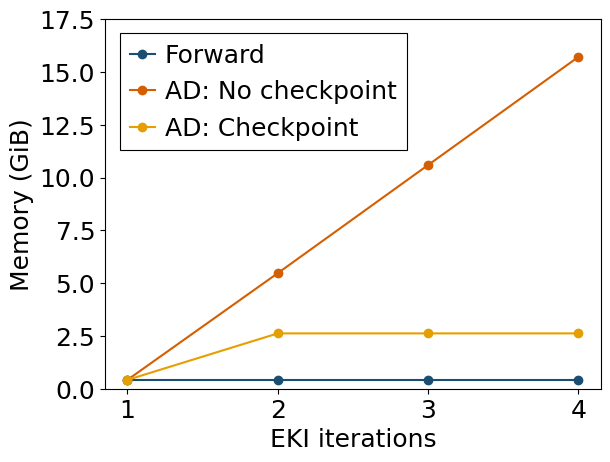

In [182]:
momery_iteration1 = [0.419, 5.47, 10.59, 15.71]
momery_iteration2 = [0.418, 2.62, 2.62, 2.62]
momery_iteration3 = [0.419, 0.419, 0.419, 0.419]

plt.plot([1,2,3,4],momery_iteration3, color='#1B4F72', label='Forward', marker='o')
plt.plot([1,2,3,4],momery_iteration1, color='#D55E00', label='AD: No checkpoint', marker='o')
plt.plot([1,2,3,4],momery_iteration2, color='#E69F00', label='AD: Checkpoint', marker='o')
plt.xlabel('EKI iterations')
plt.ylabel('Memory (GiB)')
legend = plt.legend(
    loc=(0.03, 0.645),#(0.02, 0.59),  # 手动调整图例的位置，x 和 y 取值范围是 [0,1]
    frameon=True,
    framealpha=1.0,
    edgecolor='black',
    borderpad=0.4,
    handlelength=1,
    fancybox=False,
    handletextpad=0.4
)
legend.get_frame().set_linewidth(0.8)
plt.ylim([0,17.5])
plt.savefig('memory_cost_step.png',dpi=300,bbox_inches='tight')

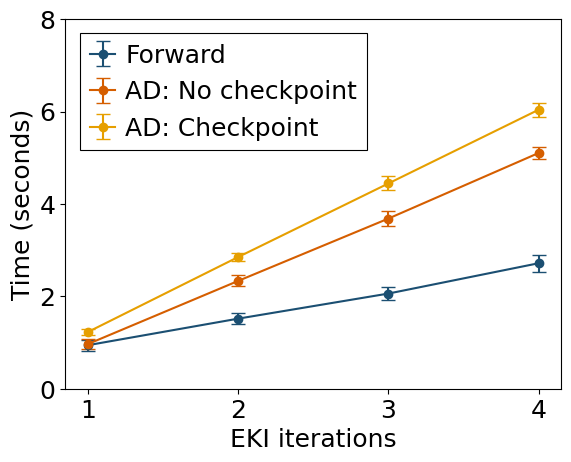

In [181]:
import matplotlib.pyplot as plt

# 步数
steps = [1, 2, 3, 4]

# Forward: No checkpoint
momery_iteration1 = [0.9417, 1.5167, 2.0600, 2.7167]
std_iteration1 = [0.1173, 0.1251, 0.1475, 0.1880]

# AD: No checkpoint
momery_iteration2 = [0.9657, 2.3333, 3.6833, 5.1033]
std_iteration2 = [0.1065, 0.1188, 0.1678, 0.1384]

# AD: Checkpoint
momery_iteration3 = [1.2267, 2.8500, 4.4433, 6.0400]
std_iteration3 = [0.0682, 0.0898, 0.1518, 0.1517]

plt.errorbar(steps, momery_iteration1, yerr=std_iteration1, color='#1B4F72', label='Forward', marker='o', capsize=5)
plt.errorbar(steps, momery_iteration2, yerr=std_iteration2, color='#D55E00', label='AD: No checkpoint', marker='o', capsize=5)
plt.errorbar(steps, momery_iteration3, yerr=std_iteration3, color='#E69F00', label='AD: Checkpoint', marker='o', capsize=5)

# 标签和标题
plt.xlabel('EKI iterations')
plt.ylabel('Time (seconds)')
plt.ylim([0,8])

legend = plt.legend(
    loc=(0.03, 0.645),#(0.02, 0.59),  # 手动调整图例的位置，x 和 y 取值范围是 [0,1]
    frameon=True,
    framealpha=1.0,
    edgecolor='black',
    borderpad=0.4,
    handlelength=1,
    fancybox=False,
    handletextpad=0.4
)
legend.get_frame().set_linewidth(0.8)

# 显示图
plt.savefig('time_cost_step.png',dpi=300,bbox_inches='tight')
plt.show()


In [2]:
!pip install --upgrade tensorboard

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 24.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 28.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 32.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
import jax
import jax.numpy as jnp
import jax.profiler
def func1(x):
  return jnp.tile(x, 10) * 0.5
def func2(x):
  y = func1(x)
  return y, jnp.tile(x, 10) + 1
x = jax.random.normal(jax.random.key(42), (1000, 1000))
y, z = func2(x)
z.block_until_ready()
jax.profiler.save_device_memory_profile("memory.prof") 

In [16]:
import jax
import jax.numpy as jnp
import jax.profiler
import time

# 启动 profiler 服务器
#jax.profiler.start_server(9999)
print("JAX Profiler server started on port 9999.")

log_dir = "/home/huchen/OED-ensemble/jax_trace"  
print(f"Saving JAX profiling data to: {log_dir}")
jax.profiler.trace("on_trace_start", log_dir)  # 开始记录 profiling 数据

# 示例计算函数
def my_function(x):
    return jnp.sin(x) * jnp.cos(x)

# 进行计算，并确保所有计算完成
x = jnp.linspace(0, 3.14, 10000000)
result = my_function(x).block_until_ready()  # 确保计算完成

jax.profiler.trace("on_trace_end", log_dir)

# 5️⃣ 等待几秒钟，确保 profiling 数据写入完成
time.sleep(2)
print("Profiling complete. You can now open TensorBoard.")

JAX Profiler server started on port 9999.
Saving JAX profiling data to: /home/huchen/OED-ensemble/jax_trace
Profiling complete. You can now open TensorBoard.


In [88]:
def loss_function5(d_start, center, estimated_center, noise_level_eki):
    # 经过测试，1次和3次的导数是不一样的
    us = ensemble_members_array
    
    observation_local, _ = sealed_convection_diffusion_true(d_start, center, stage)
    
    # 固定所有不变参数，仅让 d_start 动态变化
    def body(i, us):
        return checkpoint(EnKF_process_fixCenter, static_argnums=(1, 2, 4, 5, 6, 7, 8))(d_start, estimated_center, observation_local, us, stage, model, noise_level_eki, inflation_factor, step_size)
    
    # 使用 fori_loop 进行循环，不保存中间结果
    us = jax.lax.fori_loop(0, 3, body, us)

    #def body(carry, _):
    #    us = carry
    #    us = EnKF_process_fixCenter(d_start, estimated_center, observation_local, us, stage, model, noise_level_eki, inflation_factor, step_size)
    #    return us, None  # carry 是 us，scan 不需要输出数据时，返回 None
    #
    #us, _ = jax.lax.scan(body, init=ensemble_members_array, xs=None, length=5)


    updated_mu = jnp.mean(us,axis=0)
    updated_sigma = jnp.cov(us, rowvar=False)
    
    return -kl_divergence(updated_mu, updated_sigma, initial_mu, initial_sigma)

def loss_function_hist(d_start, center, estimated_center, noise_level_eki):
    us = ensemble_members_array
    us_history = []
    
    observation_local, _ = sealed_convection_diffusion_true(d_start, center, stage)
    
    for _ in range(3):
        us = EnKF_process_fixCenter(
            d_start, estimated_center, observation_local, us, stage, model, noise_level_eki, inflation_factor, step_size
        )
        us_history.append(us)

    ## us_history 形状为 (3, ensemble_size, param_dim)，表示3个时间步的 us
    #updated_mu = jnp.mean(us_history[-1], axis=0)  # 取最后一步
    #updated_sigma = jnp.cov(us_history[-1], rowvar=False)

    return us_history


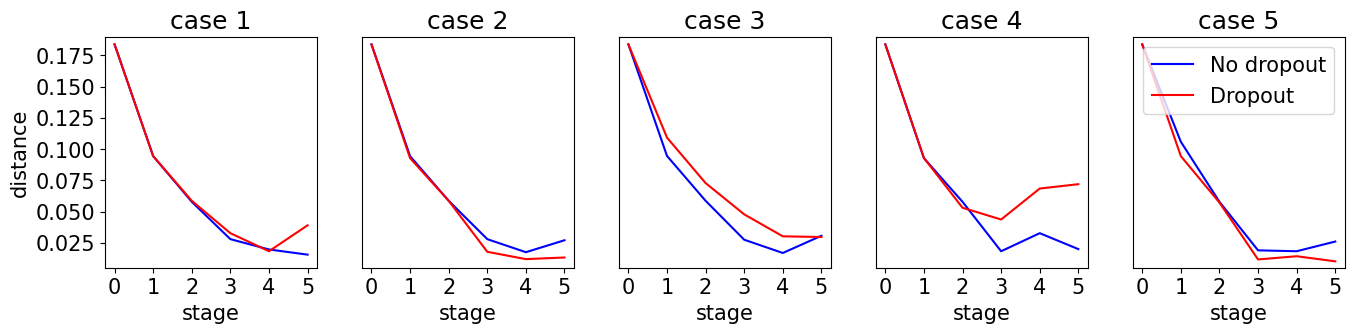

In [45]:
a=np.array([
[0.1839,	0.1075,	0.0705,	0.044	,0.0177, 0.0293],
[0.1839,	0.1075,	0.0714,	0.0455,	0.0177	,0.0295],
[0.1839,	0.1078,	0.0628,	0.0345,	0.0563	,0.0578],
[0.1839,	0.1077,	0.0714,	0.0424,	0.0141	,0.0204],
[0.1839,	0.1077,	0.0738,	0.0531,	0.039	,0.0294],
[0.1839,	0.1091,	0.0729,	0.0475,	0.019	,0.0348],
[0.1839,	0.1076,	0.0705,	0.0393,	0.0177	,0.0396],
[0.1839,	0.1075,	0.0684,	0.0424,	0.0177	,0.0295],
[0.1839,	0.1093,	0.0699,	0.0436,	0.0154	,0.0324],
])

c=np.array([
[0.1839,	0.1075,	0.0714,	0.0455,	0.0177	,0.0295],
[0.1839,	0.1078,	0.0628,	0.0345,	0.0563	,0.0578],
[0.1839,	0.1076,	0.0705,	0.0393,	0.0177	,0.0396],
[0.1839,	0.1075,	0.0684,	0.0424,	0.0177	,0.0295],
[0.1839,	0.1093,	0.0699,	0.0436,	0.0154	,0.0324],
])

b=np.array([
[0.1839,	0.09438,	0.0578,	0.02788,	0.019628,	0.01547],
[0.1839,	0.09438,	0.0586,	0.02788,	0.017434,	0.026996],
[0.1839,	0.09453,	0.0586,	0.02742,	0.0168112,	0.030594],
[0.1839,	0.092757,	0.0578,	0.0182	,   0.03266,	0.0199],
[0.1839,	0.10587,	0.0578,	0.01892,	0.0182,	0.025964],

])

d=np.array([
[0.1839,	0.094384	,0.0586,	0.03266,	0.0182, 	0.03896],
[0.1839,	0.09275	,0.0586,	0.01775,	0.01189,	0.01319],
[0.1839,	0.10921	,0.072797,	0.04774,	0.030145,	0.0296],
[0.1839,	0.092904,0.053037,	0.04362,	0.06841,	0.071902],
[0.1839,	0.09438	,0.05719,	0.01163,	0.01419,	0.01013],

])

#plt.yticks([0.025,0.05,0.075,0.1,0.125,0.15,0.175])
#plt.rc('font', size=18)
#plt.plot(np.mean(a,axis=0), label='use current data')
#plt.plot(np.mean(b,axis=0), label='historical data')
#plt.xlabel('stage')
#plt.ylabel('average distance')
#plt.legend()

fig,axes=plt.subplots(1,5,figsize=(16,3))
fig.subplots_adjust(wspace=0.21)
plt.rc('font', size=15)
for i in range(5):
    axes[i].plot(b[i],color='b',label='No dropout')
    axes[i].plot(d[i],color='r',label='Dropout')
    axes[i].set_ylim([0.005,0.19])
    axes[i].set_xticks([0,1,2,3,4,5])
    axes[i].set_xlabel('stage')
    axes[i].set_title(f'case {i+1}')
    if i == 0:
        axes[i].set_yticks([0.025,0.05,0.075,0.1,0.125,0.15,0.175])
        axes[i].set_ylabel('distance')
    else:
        axes[i].set_yticks([])
        
axes[4].legend()

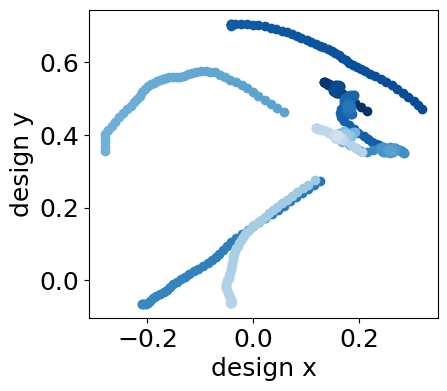

In [62]:
plt.rc('font', size=18)
plt.figure(figsize=(4.5,4))
colors = plt.cm.Blues(np.linspace(1.0, 0.2, len(design_MEC_trajectory)))
for i in range(len(design_MEC_trajectory)):
    plt.scatter(design_MEC_trajectory[i][0], 
               design_MEC_trajectory[i][1], 
               color=colors[i])
    plt.xlabel('design x')
    plt.ylabel('design y')

In [33]:
jnp.array([0.26098555,0.3583703 ])-d_start

Array([ 0.09946503, -0.03605717], dtype=float32)

In [10]:
# 给出一些design，评估他们各自带来的中心距离的估计，评估好坏

stage = 4

d_start = design_list[stage+1]

d_to_test = [
    d_start + jnp.array([0.0,0]),
    #d_start + jnp.array([0.02,0]),
    #d_start + jnp.array([0,-0.02]),
    #d_start + jnp.array([0,0.02]),
    #d_start + jnp.array([-0.02,0.02]),
    #d_start + jnp.array([-0.02,-0.02]),
    #d_start + jnp.array([0.02,-0.02]),
    #d_start + jnp.array([0.02,0.02]),
]

estimated_center = estimated_posterior_point[stage]

key_for_design = random.split(key[stage*2],iteration_step_number1[stage])
key_for_param = random.split(key[stage*2+1],(iteration_step_number2[stage]+1))

for j in range(len(d_to_test)):

    d_start_MEC = d_to_test[j]
    params = params_list[stage-1] # 每次都重置
    prior = posterior_oed_list[stage]
    
    start_time = time.time()
    try:
        del tx3
        del opt_state3
        del posterior
    except NameError:
        pass
        
    tx3 = optax.adam(0.002)#learning_rate2[stage])
    
    opt_state3 = tx3.init(params)
    observation, _ = sealed_convection_diffusion_true(d_start_MEC, center, stage)
    print(f'measurement is: {observation}')
    
    #design_MEC_array = jnp.array(design_MEC_list)
    #observation_MEC_array = jnp.array(observation_MEC_list)
    #stage_count_array = jnp.arange(1,stage+1)

    print('start learning params')
    for i in range(iteration_step_number2[stage]):
        if stage in stage_to_skip:
            print(f'stage {stage} dont learn error parameters')
            break
        
        #observation_perturbed =  observation + 0.003 * jax.random.normal(key_for_param[i], observation.shape) * (80-i)/80
        estimated_center_perturbed = estimated_center + 0.05 * jax.random.normal(key_for_param[i], estimated_center.shape)*jnp.exp(-0.04*i)#* (80-i)/80
        max_evidence_items, grad_params = jax.value_and_grad(loss_param_refine5)(params, d_start_MEC, stage, estimated_center_perturbed, model, observation)
        #max_evidence_items, grad_params = jax.value_and_grad(loss_param_refine6)(params, design_MEC_array, stage_count_array, estimated_center_perturbed, observation_MEC_array)
    
        clip_norm = 1e10
        clip_transform = optax.clip_by_global_norm(clip_norm)
        clipped_grads, _ = clip_transform.update(grad_params, state=None)
        
        updates, opt_state3 = tx3.update(clipped_grads, opt_state3, params=params)
        
        # 解决nan的问题
        updates_contain_nans = any(jnp.any(jnp.isnan(u)) for u in jax.tree_util.tree_leaves(updates))
        if updates_contain_nans:
            print('NaN appears in learning. Perturb params and continue.')
            noise = jax.tree_util.tree_map(lambda p: 0.01 * jax.random.normal(key_for_param[i], p.shape), params)
            params = jax.tree_util.tree_map(lambda p, n: p + n, params, noise)
        else:
            params = optax.apply_updates(params, updates)
            
        net_accuracy = evaluate_nn_accuracy(params,model,center,local_size)
        
        if np.isnan((max_evidence_items, net_accuracy)).any():
            print('some results are Nan')
            break
            
        #evidence_list.append(-max_evidence_items)
        #NN_error_list.append(net_accuracy)
        print('.',end='')

        
    #params_list.append(params)
    
    end_time = time.time()
    print(f"Execution learning param time: {end_time - start_time} seconds")

    
    _, posterior = forward_posterior_infoGain(params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], model)

    num_top = num_top_array[stage]
    indices = jnp.argpartition(posterior.ravel(), -num_top)[-num_top:]
    multi_indices = jnp.unravel_index(indices, posterior.shape)
    
    average_x = int(jnp.mean(multi_indices[0]))
    average_y = int(jnp.mean(multi_indices[1]))
    
    # 定义 5x5 的范围
    x_range = jnp.arange(max(0, average_x - 2), min(posterior.shape[0], average_x + 3))
    y_range = jnp.arange(max(0, average_y - 2), min(posterior.shape[1], average_y + 3))
    
    # 获取5x5的网格点
    x_grid, y_grid = jnp.meshgrid(x_range, y_range, indexing='ij')
    x_grid_flat = x_grid.ravel()
    y_grid_flat = y_grid.ravel()
    
    # 提取对应的 posterior 值
    grid_points = jnp.stack((x_grid_flat, y_grid_flat), axis=-1)
    grid_values = posterior[x_grid_flat, y_grid_flat]
    
    # 插值：创建细化的网格以提升精度
    fine_x = jnp.linspace(x_range.min(), x_range.max(), 50)
    fine_y = jnp.linspace(y_range.min(), y_range.max(), 50)
    fine_x_grid, fine_y_grid = jnp.meshgrid(fine_x, fine_y, indexing='ij')
    fine_points = jnp.stack((fine_x_grid.ravel(), fine_y_grid.ravel()), axis=-1)
    
    interpolated_values = griddata(grid_points, grid_values, fine_points, method='cubic')
    interpolated_values = interpolated_values.reshape(fine_x_grid.shape)
    
    # 找到插值后最大值的坐标
    max_index = jnp.unravel_index(jnp.argmax(interpolated_values), interpolated_values.shape)
    max_x, max_y = fine_x_grid[max_index], fine_y_grid[max_index]
    
    # 输出新的估计中心
    estimated_center_post1 = jnp.array([max_x, max_y]) / 50
    
    distance1 = jnp.sqrt(jnp.sum((center - estimated_center_post1)**2))

    print(f'direction {d_start_MEC-d_start},estimated center is {estimated_center_post1}, distance is {distance1}')

measurement is: 0.5272310972213745
start learning params
................................................................................Execution learning param time: 105.13864469528198 seconds
direction [0. 0.],estimated center is [0.23551019 0.2408163 ], distance is 0.017155032604932785


In [15]:
stage=4
key1 = random.PRNGKey(0)
grad_list = []

ensemble_size = 40
std_dev = 0.3
params = params_list[stage-1]
mean_array = reconstruct_dict_to_array(params)
params_dimension = len(mean_array)
estimated_center = estimated_posterior_point[stage]

key_ensemble = random.split(key1,ensemble_size)
ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_ensemble, mean_array, std_dev)


inflation_factor = 1.0
step_size = 0.5
noise_level_eki = 0.0002

initial_mu = jnp.mean(ensemble_members_array,axis=0)
initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    
#%time jax.grad(loss_function5)(d_start, center, estimated_center, noise_level_eki)

for i in range(10):
    key1,key1_sub = random.split(key1)
    key_ensemble = random.split(key1_sub,ensemble_size)
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_ensemble, mean_array, std_dev)
    
    
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    
    print(jax.grad(loss_function_trace)(d_start, center, estimated_center, noise_level_eki), jax.grad(loss_function_kld)(d_start, center, estimated_center, noise_level_eki))

[0.05633573 0.03117777] [0.2693159  0.21759647]
[-0.32594407 -0.06345876] [-0.18463531  0.08902478]
[0.24025594 0.19085434] [-0.30049956  0.08213186]
[-0.05148643 -0.01911902] [-0.47887206 -0.27287042]
[-0.01832239 -0.02224776] [ 0.04962964 -0.0320988 ]
[-0.00923191  0.09178314] [-0.17932558 -0.04243422]
[ 0.01086133 -0.12135113] [-0.84010553  0.45338798]
[-0.04046934  0.13320366] [0.56433225 0.06646925]
[0.02738209 0.23474346] [-0.02078873 -0.1608728 ]
[-0.02796709 -0.16924725] [-0.05041844 -0.17918846]


In [9]:
stage=4
key1 = random.PRNGKey(2023)
grad_list = []

ensemble_size = 40
std_dev = 0.3
params = params_list[stage-1]
mean_array = reconstruct_dict_to_array(params)
params_dimension = len(mean_array)
estimated_center = estimated_posterior_point[stage]


for i in range(470):
    key1,key1_sub = random.split(key1)
    key_ensemble = random.split(key1_sub,ensemble_size)
    ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(key_ensemble, mean_array, std_dev)
    
    
    inflation_factor = 1.0
    step_size = 0.5
    noise_level_eki = 0.0002
    
    initial_mu = jnp.mean(ensemble_members_array,axis=0)
    initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)
    
    #grad = jax.grad(loss_function5)(d_start, center, estimated_center, noise_level_eki)
    grad = jax.grad(loss_function7)(d_start, center, estimated_center, key1)
    grad_list.append(grad)

grad_array = jnp.array(grad_list)
mean = jnp.mean(grad_array,axis=0)
var = jnp.var(grad_array,axis=0)

In [10]:
mean,var

(Array([0.01679993, 0.00465392], dtype=float32),
 Array([7.8044090e-05, 1.6980332e-05], dtype=float32))

kld

In [19]:
mean,var

(Array([0.03469156, 3.842245  ], dtype=float32),
 Array([0.07510284, 0.9330142 ], dtype=float32))

trace

In [12]:
mean,var

(Array([-0.01523916, -0.01776617], dtype=float32),
 Array([0.00392262, 0.00543616], dtype=float32))

In [17]:
def loss_function5(d_start, center, estimated_center, noise_level_eki):
    # 经过测试，1次和3次的导数是不一样的
    us = ensemble_members_array
    
    observation_local, _ = sealed_convection_diffusion_true(d_start, center, stage)
    
    # 固定所有不变参数，仅让 d_start 动态变化
    def body(i, us):
        return checkpoint(EnKF_process_fixCenter, static_argnums=(1, 2, 4, 5, 6, 7, 8))(d_start, estimated_center, observation_local, us, stage, model, noise_level_eki, inflation_factor, step_size)
    
    # 使用 fori_loop 进行循环，不保存中间结果
    us = jax.lax.fori_loop(0, 3, body, us)

    #def body(carry, _):
    #    us = carry
    #    us = EnKF_process_fixCenter(d_start, estimated_center, observation_local, us, stage, model, noise_level_eki, inflation_factor, step_size)
    #    return us, None  # carry 是 us，scan 不需要输出数据时，返回 None
    #
    #us, _ = jax.lax.scan(body, init=ensemble_members_array, xs=None, length=5)


    updated_mu = jnp.mean(us,axis=0)
    updated_sigma = jnp.cov(us, rowvar=False)
    
    #return jnp.trace(updated_sigma)
    return -kl_divergence(updated_mu, updated_sigma, initial_mu, initial_sigma)

%time jax.grad(loss_function5)(d_start, center, estimated_center, noise_level_eki)

CPU times: user 6.69 s, sys: 10.6 s, total: 17.3 s
Wall time: 3.88 s


Array([-0.14899802,  2.712284  ], dtype=float32)

In [67]:
stage = 5

d_start = design_list[stage+1]
estimated_center = estimated_posterior_point[stage]
%time jax.grad(loss_function5)(d_start, center, estimated_center, noise_level_eki)

CPU times: user 19.1 s, sys: 6.7 s, total: 25.8 s
Wall time: 16.9 s


Array([-0.5467091 ,  0.39906147], dtype=float32)

In [66]:
stage = 4

d_start = design_list[stage+1]
estimated_center = estimated_posterior_point[stage]
%time jax.grad(loss_function5)(d_start, center, estimated_center, noise_level_eki)

CPU times: user 7.69 s, sys: 8.52 s, total: 16.2 s
Wall time: 4.77 s


Array([-0.6809657, -1.5907106], dtype=float32)

In [8]:
def EnKF_process_fixCenter(d_start, center, observation_local, ensemble_member, stage, model, noise_level_eki=1e-5, inflation_factor=1.0, step_size=0.5):
    # 进行一次EnKF更新
    
    ensemble_size_local = ensemble_member.shape[0]
    
    y_fs = vmap_predict_y_f(d_start, center, stage, model, ensemble_member)
    
    # 分批计算 y_fs
    #batch_size = ensemble_size_local // 3  # 将 ensemble_member 分为两部分（可以调整为其他比例）
    #y_fs_batches = []
    #for i in range(0, ensemble_size_local, batch_size):
    #    batch = ensemble_member[i:i + batch_size]
    #    y_fs_batch = vmap_predict_y_f(d_start, center, stage, model, batch)
    #    y_fs_batches.append(y_fs_batch)
    ## 拼接所有部分的 y_fs
    #y_fs = jnp.concatenate(y_fs_batches, axis=0)


    y_fs = y_fs.reshape((ensemble_size_local, 1))
    
    y_f_mean = jnp.mean(y_fs)
    
    P_yy = jnp.einsum('ij,ij->j', y_fs - y_f_mean, y_fs - y_f_mean) / (ensemble_size_local - 1)


    x_f_theta = ensemble_member.reshape(ensemble_size_local,-1)
    x_f_mean = jnp.mean(x_f_theta, axis=0).reshape(1,-1)

    x_f_deviation = x_f_theta - x_f_mean
    y_f_deviation = y_fs - y_f_mean.reshape(1,1)
    P_xy = jnp.einsum('ij,ik->jk', x_f_deviation, y_f_deviation) / (ensemble_size_local - 1)

    K = P_xy * 1.0/P_yy
    x_a = x_f_theta + step_size*jnp.matmul(K, (observation_local - y_fs).T).T
    
    x_a_mean = jnp.mean(x_a, axis=0)
    x_a = x_a_mean + inflation_factor * (x_a - x_a_mean) # 膨胀因子
    
    return x_a

def predict_y_f_regularization(d_start, center, stage, model, ensemble_member_i, C):
    ensemble_member_i_dict = reconstruct_array_to_dict(ensemble_member_i,params)
    y_f, _ = sealed_convection_diffusion_nn(ensemble_member_i_dict, d_start, center, stage, model)
    y_f_flat = jnp.ravel(y_f)
    return jnp.concatenate([y_f_flat, jnp.einsum('ij,j->i', C, ensemble_member_i)])
    
#%time predict_y_f_regularization(d_start, center, stage, model, ensemble_members_array[0])

vmap_predict_y_f_regularization = jax.vmap(predict_y_f_regularization, in_axes=(None, None, None, None, 0, None))

# drop off
def EnKF_process_fixCenter_regularization(d_start, center, observation_local, ensemble_member, stage, model, key1, lambda_value = 0.5, h_n = 0.5):
    '''
    lambda_value: drop off weight
    '''
    ensemble_size_local, parameter_size = ensemble_member.shape
    
    theta_mean = jnp.mean(ensemble_member,axis=0)
    theta_deviation = ensemble_member - theta_mean
    
    ensemble_member.shape, theta_mean.shape, theta_deviation.shape
    
    mask = random.bernoulli(key1, p=lambda_value, shape=theta_deviation.shape)
    theta_deviation_tilde = theta_deviation * mask
    ensemble_member_tilde = theta_mean + theta_deviation_tilde
    
    C = 0.1*jnp.eye(parameter_size)#37**(-0.5)*
    Z = jnp.concatenate([jnp.ravel(observation_local), jnp.zeros(parameter_size)])
    H_u = vmap_predict_y_f_regularization(d_start, center, stage, model, ensemble_member_tilde, C)
    H_u_deviation = H_u - jnp.mean(H_u,axis=0)
    
    #C_uu = jnp.einsum('ij,ik->jk', theta_deviation, theta_deviation_tilde) / (ensemble_size_local - 1)
    #C_zu = jnp.einsum('ij,ik->jk', theta_deviation, H_u_deviation).T / (ensemble_size_local - 1)
    C_uu_tilde = jnp.einsum('ij,ik->jk', theta_deviation_tilde, theta_deviation_tilde) / (ensemble_size_local - 1)
    C_uz_tilde = jnp.einsum('ij,ik->jk', theta_deviation_tilde, H_u_deviation) / (ensemble_size_local - 1)
    C_zz_tilde = jnp.einsum('ij,ik->jk', H_u_deviation, H_u_deviation) / (ensemble_size_local - 1)
    
    C_zz_inv = jnp.linalg.pinv(h_n * C_zz_tilde + jnp.eye(C_zz_tilde.shape[0]))
    K_n = jnp.einsum('ik,kj->ij', C_uz_tilde, C_zz_inv)
    
    
    obs_error = Z - H_u
    increment = jnp.einsum('ij,kj->ki', K_n, obs_error)
    x_a = ensemble_member + h_n * increment
    
    return x_a

def loss_function7(d_start, center, estimated_center, key):
    """
    计算损失函数，其中 EnKF 每次更新使用不同的随机数 key。
    
    Args:
        d_start: 初始状态。
        center: 真值中心。
        estimated_center: 估计中心。
    
    Returns:
        负的 KL 散度以及更新后的均值和协方差。
    """
    y_fs = ensemble_members_array
    
    observation_local, _ = sealed_convection_diffusion_true(d_start, center, stage)

    initial_state = (y_fs, key)
    
    # 固定所有不变参数，仅让 d_start 动态变化
    def body(i, state):
        y_fs, key = state
        # 生成新的 key
        key, subkey = random.split(key)
        # 调用 EnKF 过程，传入新的随机数 key
        y_fs = checkpoint(EnKF_process_fixCenter_regularization, static_argnums=(1, 2, 4, 5, 7, 8))(
            d_start, estimated_center, observation_local, y_fs, stage, model, subkey, 1.0, 0.5
        )
        return y_fs, key
        
    # 使用 fori_loop 进行循环，传递状态
    final_state = jax.lax.fori_loop(0, 3, body, initial_state)
    y_fs, final_key = final_state

    # 计算更新后的均值和协方差
    updated_mu = jnp.mean(y_fs, axis=0)
    updated_sigma = jnp.cov(y_fs, rowvar=False)
    
    # 返回负的 KL 散度和更新的统计量
    return -kl_divergence(updated_mu, updated_sigma, initial_mu, initial_sigma)

In [21]:
%time jax.value_and_grad(loss_function7)(d_start, center, estimated_center, key[-1])

CPU times: user 5.95 s, sys: 6.19 s, total: 12.1 s
Wall time: 4.05 s


(Array(-0.01366997, dtype=float32),
 Array([0.01751599, 0.0039193 ], dtype=float32))

In [19]:
%time jax.value_and_grad(loss_function5)(d_start, center, estimated_center, 0.0002)

CPU times: user 6.26 s, sys: 7.85 s, total: 14.1 s
Wall time: 3.93 s


(Array(-1.6030102, dtype=float32),
 Array([-0.2976197 , -0.01681435], dtype=float32))

In [14]:
def loss_function_trace(d_start, center, estimated_center, noise_level_eki):
    # 经过测试，1次和3次的导数是不一样的
    us = ensemble_members_array
    
    observation_local, _ = sealed_convection_diffusion_true(d_start, center, stage)
    
    # 固定所有不变参数，仅让 d_start 动态变化
    def body(i, us):
        return checkpoint(EnKF_process_fixCenter, static_argnums=(1, 2, 4, 5, 6, 7, 8))(d_start, estimated_center, observation_local, us, stage, model, noise_level_eki, inflation_factor, step_size)
    
    # 使用 fori_loop 进行循环，不保存中间结果
    us = jax.lax.fori_loop(0, 3, body, us)

    #def body(carry, _):
    #    us = carry
    #    us = EnKF_process_fixCenter(d_start, estimated_center, observation_local, us, stage, model, noise_level_eki, inflation_factor, step_size)
    #    return us, None  # carry 是 us，scan 不需要输出数据时，返回 None
    #
    #us, _ = jax.lax.scan(body, init=ensemble_members_array, xs=None, length=5)


    updated_mu = jnp.mean(us,axis=0)
    updated_sigma = jnp.cov(us, rowvar=False)
    
    return jnp.trace(updated_sigma)
    #return -kl_divergence(updated_mu, updated_sigma, initial_mu, initial_sigma)


def loss_function_kld(d_start, center, estimated_center, noise_level_eki):
    # 经过测试，1次和3次的导数是不一样的
    us = ensemble_members_array
    
    observation_local, _ = sealed_convection_diffusion_true(d_start, center, stage)
    
    # 固定所有不变参数，仅让 d_start 动态变化
    def body(i, us):
        return checkpoint(EnKF_process_fixCenter, static_argnums=(1, 2, 4, 5, 6, 7, 8))(d_start, estimated_center, observation_local, us, stage, model, noise_level_eki, inflation_factor, step_size)
    
    # 使用 fori_loop 进行循环，不保存中间结果
    us = jax.lax.fori_loop(0, 3, body, us)

    #def body(carry, _):
    #    us = carry
    #    us = EnKF_process_fixCenter(d_start, estimated_center, observation_local, us, stage, model, noise_level_eki, inflation_factor, step_size)
    #    return us, None  # carry 是 us，scan 不需要输出数据时，返回 None
    #
    #us, _ = jax.lax.scan(body, init=ensemble_members_array, xs=None, length=5)


    updated_mu = jnp.mean(us,axis=0)
    updated_sigma = jnp.cov(us, rowvar=False)
    
    #return jnp.trace(updated_sigma)
    return -kl_divergence(updated_mu, updated_sigma, initial_mu, initial_sigma)

#%time jax.grad(loss_function5)(d_start, center, estimated_center, noise_level_eki)

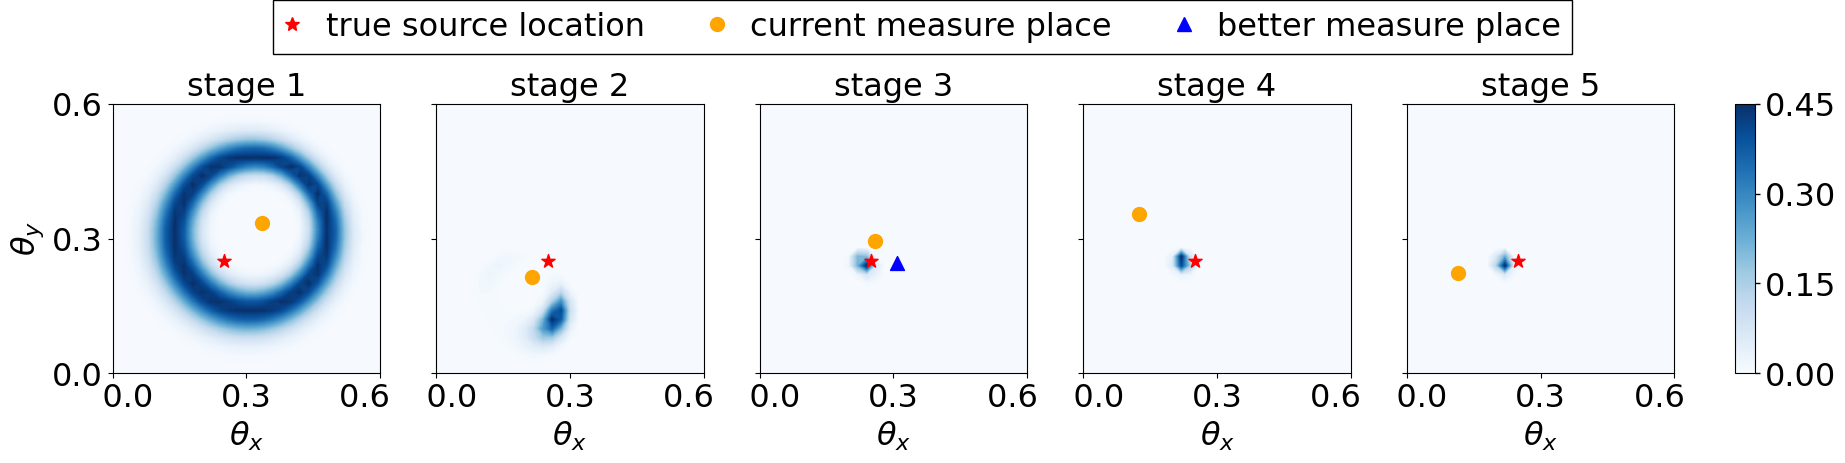

In [7]:
import numpy as np
import jax.numpy as jnp




n_stage =5
local_size = 51
center = jnp.array([0.25,0.25])

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib.colors import LinearSegmentedColormap

fig, axes = plt.subplots(1, 5, figsize=(4.03*5, 3.5))
fig.subplots_adjust(wspace=0.21)

# fig.subplots_adjust(left = 0.05, right = 0.9, wspace=0.3)

grid_x_plot0, grid_y_plot0 = np.meshgrid(np.linspace(0, 1, local_size), np.linspace(0, 1, local_size))

        
fontsize = 23
pic_num=0

# 内置颜色图
cmap = 'Blues'#'PuBu'#'pink'#'GnBu'#'Greens'#
star_color = 'r'#'magenta'#'y'#'#F89054'#


def custom_formatter(x, pos):
    if x == 0.0:
        return '   0.0'  # 向右移动
    elif x == 0.6:
        return '0.6   '  # 向左移动
    elif x == 0.3:
        return '0.3'
    else:
        return f'{x:.2f}'


for stage in [0,1,2,3,4]:
    d_start = design_list[stage+1]
    d_start_backup = design_list[stage]
    contour=axes[pic_num].contourf(grid_x_plot0, grid_y_plot0, posterior_list[stage].T, levels=100,cmap=cmap)#plasma' )
    axes[pic_num].scatter(d_start[0], d_start[1], marker='o', s=100, c='orange')

    if stage == 2:
        axes[pic_num].scatter(d_start[0]+0.05, d_start[1]-0.05, marker='^', s=100, c='blue')
    
    axes[pic_num].scatter(center[0], center[1], marker='*', s=100, c=star_color)
    #axes[pic_num].plot([d_start[0],d_start_backup[0]],[d_start[1],d_start_backup[1]], c='orangered')
    axes[pic_num].set_title(f'stage {stage+1}', fontsize=fontsize)  # 设置子图的标题
    axes[pic_num].set_xlabel('$\\theta_x$', fontsize=fontsize)  # 设置x轴标签
    axes[pic_num].set_yticks([0.0, 0.3,0.6])
    if stage == 0:
        axes[pic_num].set_ylabel('$\\theta_y$', fontsize=fontsize)  # 设置y轴标签
    else:
        axes[pic_num].set_yticklabels([]) 
        
    axes[pic_num].tick_params(axis='both', which='major', labelsize=fontsize)
    axes[pic_num].set_xticks([0.0,0.3,0.6])
    axes[pic_num].xaxis.set_major_formatter(FuncFormatter(custom_formatter))
    axes[pic_num].set_xlim([0.0,0.6])
    axes[pic_num].set_ylim([0.0,0.6])
    pic_num=pic_num+1

cbar_ax = fig.add_axes([0.93, 0.11, 0.01, 0.77])  # [left, bottom, width, height]
contour_set = plt.cm.ScalarMappable(cmap=cmap)#'plasma')
contour_set.set_array(posterior_list[stage])

#contour_set.set_clim(0, 0.06)
#ticks = [0, 0.02, 0.04, 0.06]
contour_set.set_clim(0, 0.45)
ticks = [0, 0.15, 0.30, 0.45]
#contour_set.set_clim(0, 0.33)
#ticks = [0, 0.11, 0.22, 0.33]

cbar = fig.colorbar(contour_set, cax=cbar_ax, orientation='vertical', shrink=0.4, aspect=20, pad=0.06)
cbar.ax.tick_params(labelsize=fontsize, width=1)
cbar.set_ticks(ticks)
cbar.update_ticks()

plt.plot([], [], marker='*', markersize=10, color=star_color, linestyle='None', label='true source location')
plt.plot([], [], marker='o', markersize=10, color='orange', linestyle='None', label='current measure place')

plt.plot([], [], marker='^', markersize=10, color='b', linestyle='None', label='better measure place')

legend = plt.legend(
    loc='center',
    bbox_to_anchor=(0.527, 1.1),  # 仅调整纵坐标位置，使其离上面远一点，离下面近一点
    ncol=3,
    frameon=True,
    framealpha=1,
    edgecolor='black',
    fontsize=fontsize,
    borderpad=0.05, handlelength=0.5,
    bbox_transform=fig.transFigure  # 将定位转换为相对于整个图形
)
legend.get_frame().set_edgecolor('black')  # 设置边框颜色为黑色
legend.get_frame().set_linewidth(1)  # 设置边框线宽为1
legend.get_frame().set_boxstyle("Square")


#plt.savefig('NN case good design.png',bbox_inches='tight')

In [6]:
#读取数据
with open('all_data_nn_case_data_6_test11.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

posterior_list = loaded_data["posterior_list"]
posterior_oed_list = loaded_data["posterior_oed_list"]
design_list = loaded_data["design_list"]
params_list = loaded_data["params_list"]
estimated_posterior_point = loaded_data["estimated_posterior_point"]

(0.0, 30.0)

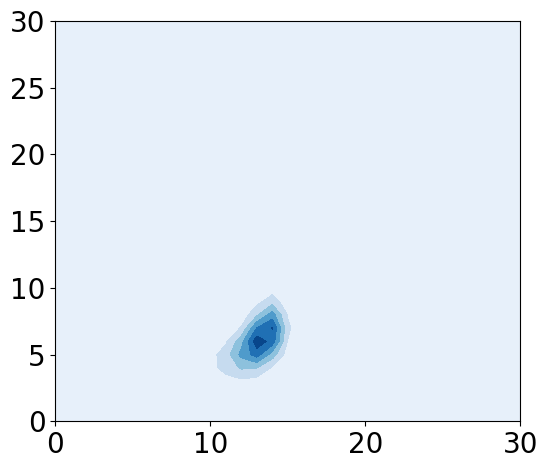

In [50]:
plt.figure(figsize=(6,5.2))
plt.contourf(posterior_list[1].T,cmap = 'Blues')
plt.xlim([0,30])
plt.ylim([0,30])

(0.0, 30.0)

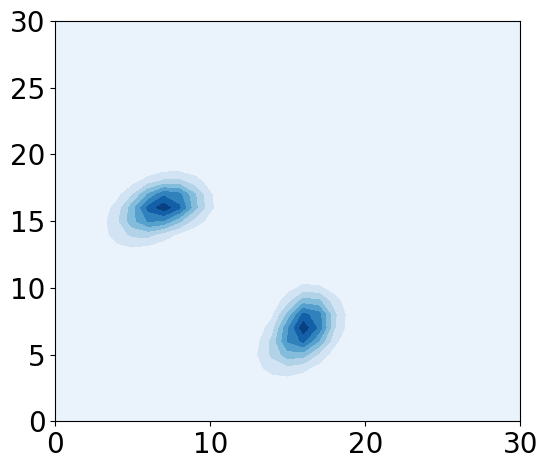

In [49]:
plt.figure(figsize=(6,5.2))
plt.contourf(posterior_oed_list[1].T,cmap = 'Blues')
plt.xlim([0,30])
plt.ylim([0,30])

In [6]:
# 保存数据
import pickle

numpy_list = [np.array(arr) for arr in posterior_list]
data_to_save = {
    "posterior_list": numpy_list,
    "posterior_oed_list": posterior_oed_list,
    "design_list": design_list,
    "params_list": params_list,
    "estimated_posterior_point": estimated_posterior_point
}

with open('all_data_nn_case_data_6_test11.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

#test1 不对design做修改
#test2 是对design做了修改
#test3 不做correction

#更正了似然函数的计算公式
#test5 单纯model correction 原本的学习陷入局部最小值
#test6 不做model correction                                 # 使用的数据
#test7 单纯model correction 增大扰动值为0.05 使用线性衰减
#test8 第二步改了设计
#test9 单纯model correction 使用大扰动加大的衰减              # 使用的数据
#test10 第三步改了设计，但是后验变化不大
#test11 第二步改了设计                                       # 使用的数据
#test12 用所有点

(5.0, 20.0)

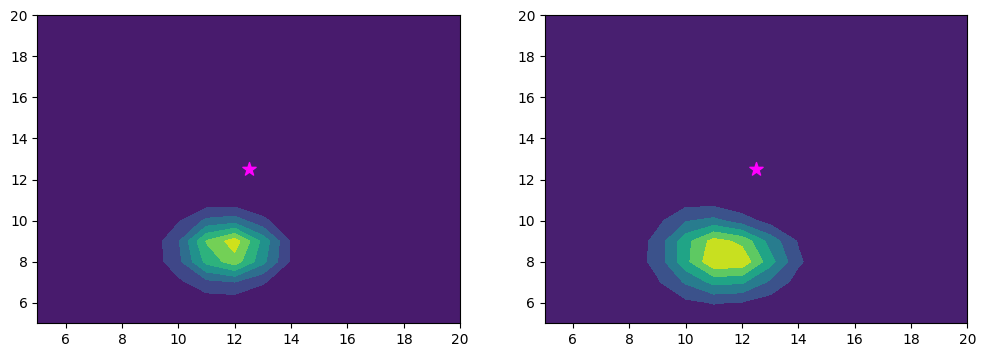

In [9]:
with open('all_data_nn_case_data_6_test.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

posterior_list = loaded_data["posterior_list"]

fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].contourf(posterior_list[3].T)
axes[0].scatter(center[0]*50, center[1]*50, marker='*', s=100, c='magenta')
axes[0].set_xlim([5,20])
axes[0].set_ylim([5,20])
axes[1].contourf(posterior_oed_list[-1].T)
axes[1].scatter(center[0]*50, center[1]*50, marker='*', s=100, c='magenta')
axes[1].set_xlim([5,20])
axes[1].set_ylim([5,20])


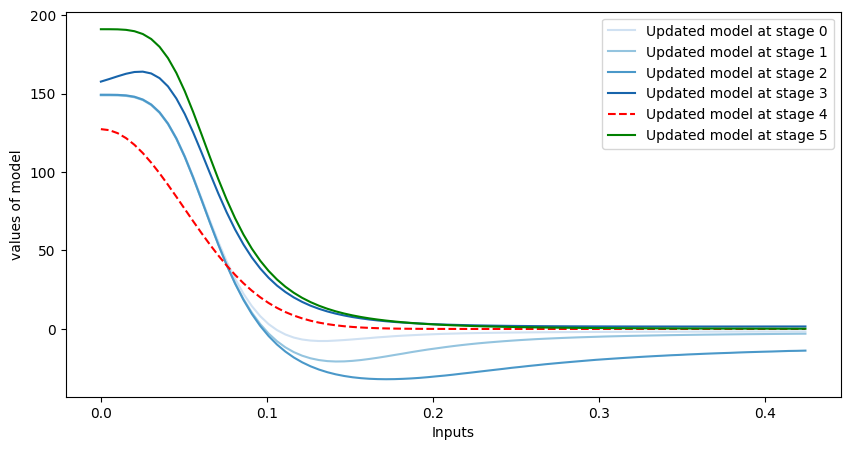

In [10]:
def show_nn_trajectory(params_list, apply_model, colormap = 'Blues', center_x=0, center_y=0, size=85):
    x = jnp.linspace(0, 0.3, size).reshape(-1, 1)
    y = jnp.linspace(0, 0.3, size).reshape(-1, 1)
    xy_combined = jnp.concatenate((x, y), axis=1)
    
    exponent_internal = ((x - center_x) ** 2 + (y - center_y) ** 2)
    factor = 2.0 / (2.0 * jnp.pi * 0.05 ** 2)
    array_exponent = factor * jnp.exp(-exponent_internal / (2.0 * 0.05 ** 2))
    array_reciprocal = factor * 1.5 / (exponent_internal ** 2 / (2.0 * 0.05 ** 2) ** 2 + 1.0)
    
    plt.figure(figsize=(10, 5))
    
    cmap = plt.colormaps[colormap].resampled(len(params_list)+2)#cm.get_cmap('Blues', len(params_list))
    for index, params in enumerate(params_list):
        #if index not in [6]:
        #    continue
        array_nn = apply_model.apply(params, xy_combined) #* 100.0
        
        plt.plot(jnp.sqrt(2) * x.squeeze(), 
                 (array_nn.squeeze() + array_reciprocal.squeeze()), 
                 label=f'NN + Reciprocal - Params {index+1}',
                 color=cmap(index+1))
    
    plt.plot(jnp.sqrt(2) * x.squeeze(), 
             array_exponent.squeeze(), color='r', linestyle = '--', label='Exponent')
    plt.plot(jnp.sqrt(2) * x.squeeze(), 
             array_reciprocal.squeeze(), color='g', label='Reciprocal')
    
    plt.ylabel('values of model')
    plt.xlabel('Inputs')
    
#show_nn_trajectory(params_list, model, center_x=0, center_y=0, size=85)
show_nn_trajectory(params_list, model, center_x=0, center_y=0, size=85)

plt.legend()

leg = plt.gca().get_legend()

new_labels = ['Updated model at stage 0', 'Updated model at stage 1','Updated model at stage 2','Updated model at stage 3','Updated model at stage 4','Updated model at stage 5', 'Updated model at stage 6','System', 'Baseline model']

for text, new_label in zip(leg.get_texts(), new_labels):
    text.set_text(new_label)

plt.draw()

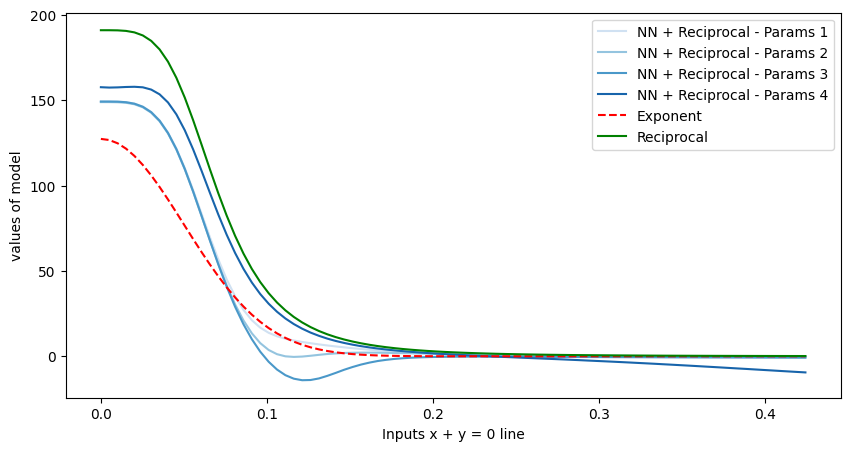

In [14]:
def show_nn_trajectory_diag(params_list, apply_model, colormap='Blues', size=85):
    x = jnp.linspace(0, 0.30, size).reshape(-1, 1)
    y = 0.0 - x
    xy_combined = jnp.concatenate((x, y), axis=1)

    exponent_internal = ((x - 0) ** 2 + (y - 0) ** 2)
    factor = 2.0 / (2.0 * jnp.pi * 0.05 ** 2)
    array_exponent = factor * jnp.exp(-exponent_internal / (2.0 * 0.05 ** 2))
    array_reciprocal = factor * 1.5 / (exponent_internal ** 2 / (2.0 * 0.05 ** 2) ** 2 + 1.0)

    plt.figure(figsize=(10, 5))

    cmap = plt.colormaps[colormap].resampled(len(params_list) + 2)
    for index, params in enumerate(params_list):
        array_nn = apply_model.apply(params, xy_combined)

        plt.plot(jnp.sqrt(2) * x.squeeze(),
                 (array_nn.squeeze() + array_reciprocal.squeeze()),
                 label=f'NN + Reciprocal - Params {index + 1}',
                 color=cmap(index + 1))

    plt.plot(jnp.sqrt(2) * x.squeeze(),
             array_exponent.squeeze(), color='r', linestyle='--', label='Exponent')
    plt.plot(jnp.sqrt(2) * x.squeeze(),
             array_reciprocal.squeeze(), color='g', label='Reciprocal')

    plt.ylabel('values of model')
    plt.xlabel('Inputs x + y = 0 line')
    plt.legend()
    plt.show()


show_nn_trajectory_diag(params_list, model)

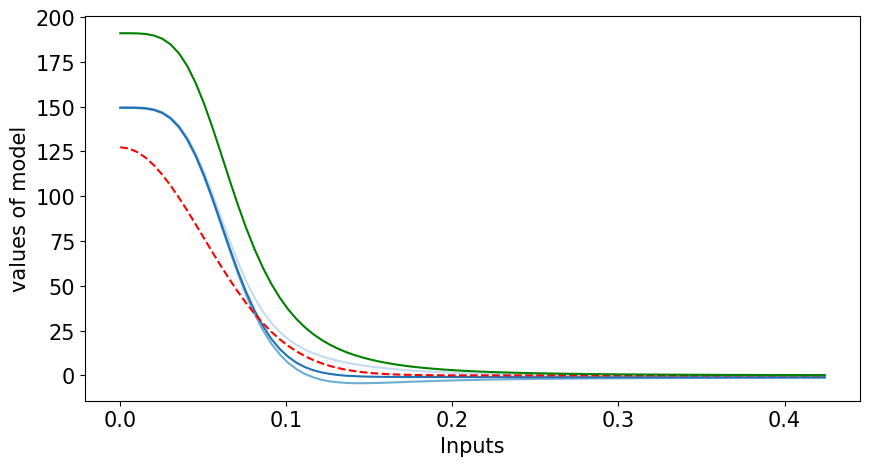

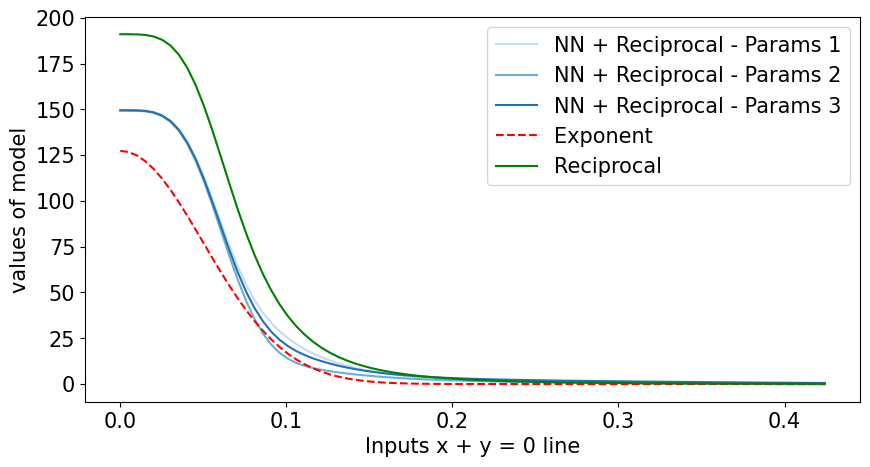

In [64]:
#with open('all_data_nn_case_data_6_test7.pkl', 'rb') as f:
#    loaded_data = pickle.load(f)
#
#params_list = loaded_data["params_list"]

show_nn_trajectory([params_list[0],params_list[1],params_list[2]], model)
show_nn_trajectory_diag([params_list[0],params_list[1],params_list[2]], model) # 不修改设计

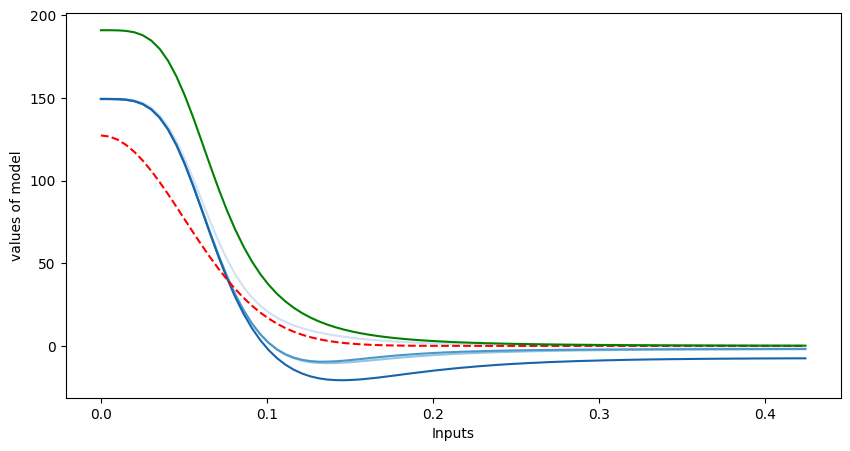

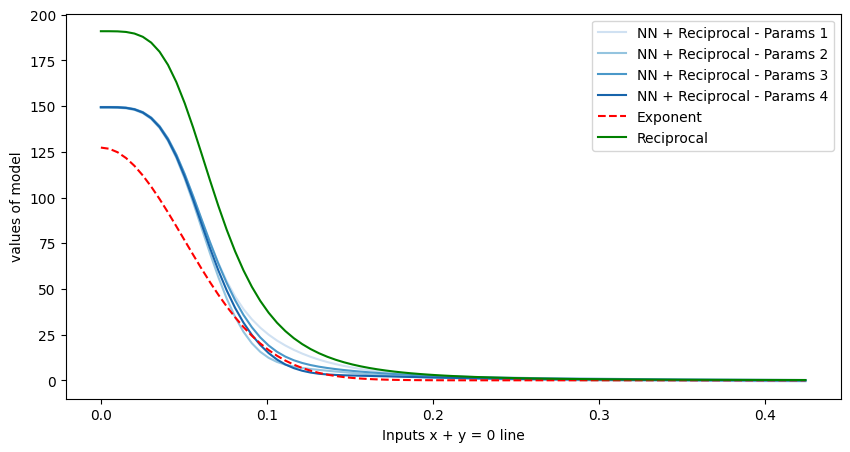

In [154]:
#读取数据
with open('all_data_nn_case_data_6_test8.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

params_list = loaded_data["params_list"]

show_nn_trajectory([params_list[0],params_list[1],params_list[2],params_list[3]], model)
show_nn_trajectory_diag([params_list[0],params_list[1],params_list[2],params_list[3]], model) # 修改设计

In [54]:
design_list

[Array([0.5, 0.5], dtype=float32),
 Array([0.3860589 , 0.38600475], dtype=float32),
 Array([0.30302617, 0.30292052], dtype=float32),
 Array([0.25707266, 0.28082484], dtype=float32),
 Array([0.3296741 , 0.23870234], dtype=float32),
 Array([0.29042608, 0.17356515], dtype=float32),
 Array([0.35514557, 0.10731688], dtype=float32),
 Array([0.39422476, 0.04704005], dtype=float32)]

In [54]:
(jnp.array([0.33066455, 0.24762303])-jnp.array([0.26151356, 0.28208357]))/2+design_list[stage]

Array([0.29608905, 0.2648533 ], dtype=float32)

In [146]:
for stage in range(1,n_stage):
    print('stage = ', stage)
    estimated_center = estimated_posterior_point[stage]
    #u_t = sealed_convection_diffusion_true(d_start, center, stage)[1][100:151,100:151]
    #u_design_5 = sealed_convection_diffusion_nn(params_list[stage-1], d_start, estimated_center, stage, model)[1][100:151,100:151]
    #u_design_7 = sealed_convection_diffusion_nn(params_list[stage], d_start, estimated_center, stage, model)[1][100:151,100:151]
    #print(np.sum((u_t - u_design_5)**2),np.sum((u_t - u_design_7)**2))
    #print(np.sum(((u_t - u_design_5)/u_t)**2),np.sum(((u_t - u_design_7)/u_t)**2))
    
    u_t = sealed_convection_diffusion_true(d_start, center, stage)[1][100:151,100:151]
    u_design_5 = sealed_convection_diffusion_nn(params_list[stage-1], d_start, center, stage, model)[1][100:151,100:151]
    u_design_7 = sealed_convection_diffusion_nn(params_list[stage], d_start, center, stage, model)[1][100:151,100:151]
    #print(np.sum(((u_t - u_design_5)/u_t)**2),np.sum(((u_t - u_design_7)/u_t)**2),'\n')
    print(np.sum((u_t - u_design_5)**2),np.sum((u_t - u_design_7)**2),'\n')

stage =  1
22.758408 71.71507 

stage =  2
392.5998 170.40518 

stage =  3
456.91083 99.092606 

stage =  4
153.13881 33.37152 



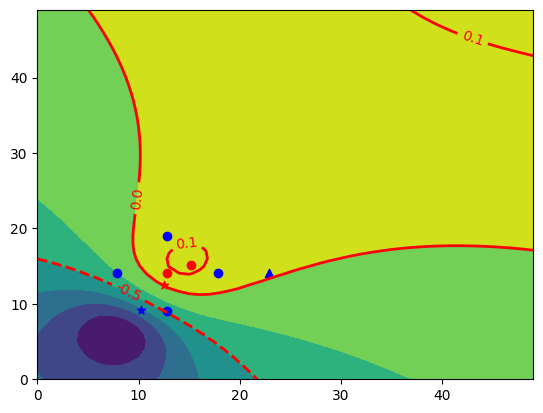

In [92]:
_, y0 = sealed_convection_diffusion_true(d_start, center, stage)
_, y1 = sealed_convection_diffusion_true(d_start, estimated_center, stage)
percentage = ((y0-y1)/y0)[100:150,100:150]
plt.contourf(percentage.T)
contour = plt.contour(percentage.T, levels=[-0.5, 0, 0.15], colors='red', linewidths=2)

plt.scatter(estimated_center[0]*50, estimated_center[1]*50, marker='*', color='b')
plt.scatter(center[0]*50, center[1]*50, marker='*', color='r')


# 添加等高线的标签 (可选)
plt.clabel(contour, fmt='%1.1f')
d_start2 = design_list[stage+1]*50

plt.scatter(d_start2[0], d_start2[1], marker='o', color='r')


d_start2 = design_list[stage]*50
plt.scatter(d_start2[0], d_start2[1], marker='o', color='r')

#d_start2 = (design_list[stage+1]+jnp.array([-0.01,0.005]))*50
#plt.scatter(d_start2[0], d_start2[1], marker='o', color='y')

d_start2 = (design_list[stage+1]-jnp.array([0.10,0.0]))*50
plt.scatter(d_start2[0], d_start2[1], marker='o', color='b')

d_start2 = (design_list[stage+1]+jnp.array([0.10,0.0]))*50
plt.scatter(d_start2[0], d_start2[1], marker='o', color='b')

d_start2 = (design_list[stage+1]-jnp.array([0.0,0.10]))*50
plt.scatter(d_start2[0], d_start2[1], marker='o', color='b')

d_start2 = (design_list[stage+1]+jnp.array([0.0,0.10]))*50
plt.scatter(d_start2[0], d_start2[1], marker='o', color='b')

d_start2 = (design_list[stage+1]+jnp.array([0.2,0.0]))*50
plt.scatter(d_start2[0], d_start2[1], marker='^', color='b')

In [107]:
14/50

0.28

In [108]:
indices = jnp.argpartition(y0.ravel(), -1)[-1:]
multi_indices

(Array([114], dtype=int32), Array([114], dtype=int32))

In [26]:
d_start = design_list[stage+1]+jnp.array([0.1,0.0])
y0, _ = sealed_convection_diffusion_true(d_start, center, stage)
y1, _ = sealed_convection_diffusion_true(d_start, estimated_center, stage)
y0,y1

(Array(0.2345945, dtype=float32), Array(0.23659566, dtype=float32))

In [67]:
design_list[stage+1]

Array([0.33066455, 0.24762303], dtype=float32)

In [11]:
noise_loc = 0
noise_base_scale = 0.05
noise_ratio_scale = 0.05
noise_info = [(noise_loc, noise_base_scale, noise_ratio_scale),]

for stage in [3]:
    key_for_design = random.split(key[stage*2],iteration_step_number1[stage])
    key_for_param = random.split(key[stage*2+1],80)#iteration_step_number2[stage])

    prior = posterior_list[stage-1]
    params=params_list[stage-1]
    d_start = design_list[stage+1]

    if stage!=0:
        _, posterior = forward_posterior_infoGain(params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], model)
        del prior
        prior = posterior
    
    #print(f'prior = {prior}')
    num_top = 5
    indices = jnp.argpartition(prior.ravel(), -num_top)[-num_top:]
    multi_indices = jnp.unravel_index(indices, prior.shape)
    
    # 计算平均坐标
    average_x = np.mean(multi_indices[0])
    average_y = np.mean(multi_indices[1])
    
    # 直接使用平均坐标
    estimated_center = jnp.array([average_x, average_y])/50
    print(f'estimated_center is ', estimated_center)

    # 运行之前必须先运行上面
    evidence_list_special = []
    NN_error_list_special = []

    #if stage!=0:
    #    del tx2
    #    del opt_state2
        
    tx2 = optax.chain(
    optax.adam(0.012),  # 使用由 lr_schedule1 调整的学习率的 Adam 优化器
    optax.add_decayed_weights(1e-4)  # 添加权重衰减，衰减系数为 1e-5
    )
    opt_state2 = tx2.init(params)

    start_time = time.time()

    
    print(f'original design for OED is {d_start}')
    d_move = jnp.array([0.05,-0.05])
    print(f'move design {d_move}')
    d_start = design_list[stage+1]+d_move
    
    print(f'design for model correction is {d_start}')
    observation, u_t_251 = sealed_convection_diffusion_true(d_start, center, stage)
    u_t = u_t_251[100:151,100:151]
    print(f'measurement is: {observation}')

    print('start learning params')
    for i in range(80):#iteration_step_number2[stage]):
        if stage in [0]:
            print('stage one dont learn error parameters')
            break
            
        #observation_perturbed =  observation + 0.003 * jax.random.normal(key_for_param[i], observation.shape)* (80 - i)/80
        estimated_center_perturbed = estimated_center + 0.05 * jax.random.normal(key_for_param[i], estimated_center.shape)*jnp.exp(-0.04*i)
        max_evidence_items, grad_params = jax.value_and_grad(loss_param_refine5)(params, d_start, stage, estimated_center_perturbed, model, observation)

        clip_norm = 1e10
        clip_transform = optax.clip_by_global_norm(clip_norm)
        clipped_grads, _ = clip_transform.update(grad_params, state=None)
        
        updates, opt_state2 = tx2.update(clipped_grads, opt_state2, params=params)
        
        # 解决nan的问题
        updates_contain_nans = any(jnp.any(jnp.isnan(u)) for u in jax.tree_util.tree_leaves(updates))
        if updates_contain_nans:
            print(f'NaN appears in learning. Perturb params and continue.')
            noise = jax.tree_util.tree_map(lambda p: 0.01 * jax.random.normal(key_for_param[i], p.shape), params)
            params = jax.tree_util.tree_map(lambda p, n: p + n, params, noise)
        else:
            params = optax.apply_updates(params, updates)
            
        net_accuracy = evaluate_nn_accuracy(params,model,center,local_size)
        #print(f'Loss step {i} max evidence items: {max_evidence_items}, nn error {i}: {net_accuracy}')
        
        if np.isnan((max_evidence_items, net_accuracy)).any():
            print('some results are Nan')
            break
            
        evidence_list_special.append(-max_evidence_items)
        NN_error_list_special.append(net_accuracy)
    
    
    end_time = time.time()
    print(f"Execution learning param time: {end_time - start_time} seconds")

    u_design_5 = sealed_convection_diffusion_nn(params, d_start, center, stage, model)[1][100:151,100:151]
    print('current error is ', np.sum((u_t - u_design_5)**2))

estimated_center is  [0.268      0.18399999]
original design for OED is [0.3991495  0.22517781]
move design [ 0.05 -0.05]
design for model correction is [0.44914952 0.17517781]
measurement is: 0.1609523743391037
start learning params
Execution learning param time: 115.15405678749084 seconds
current error is  76.67081


In [74]:
jnp.exp(-0.05*80), jnp.exp(-0.03*80), jnp.exp(-0.07*80)

(Array(0.01831564, dtype=float32, weak_type=True),
 Array(0.09071794, dtype=float32, weak_type=True),
 Array(0.00369786, dtype=float32, weak_type=True))

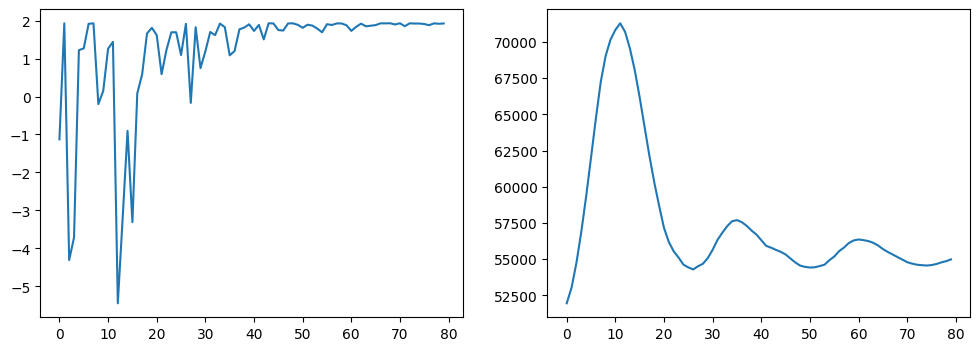

In [12]:
fig,axes = plt.subplots(1,2,figsize=(12,4))
axes[0].plot(evidence_list_special)
axes[1].plot(NN_error_list_special)

In [13]:
u_t = sealed_convection_diffusion_true(d_start, center, stage)[1][105:120,105:120]
u_design_5 = sealed_convection_diffusion_nn(params, d_start, center, stage, model)[1][105:120,105:120]
u_design_8 = sealed_convection_diffusion_nn(params_list[stage], d_start, center, stage, model)[1][105:120,105:120]
np.sum((u_t - u_design_5)**2),np.sum((u_t - u_design_8)**2)

(1.3438244, 3.329196)

In [14]:
u_t = sealed_convection_diffusion_true(d_start, center, stage)[1][100:151,100:151]
u_design_5 = sealed_convection_diffusion_nn(params, d_start, center, stage, model)[1][100:151,100:151]
u_design_8 = sealed_convection_diffusion_nn(params_list[stage], d_start, center, stage, model)[1][100:151,100:151]
np.sum((u_t - u_design_5)**2),np.sum((u_t - u_design_8)**2)

(76.67081, 132.84708)

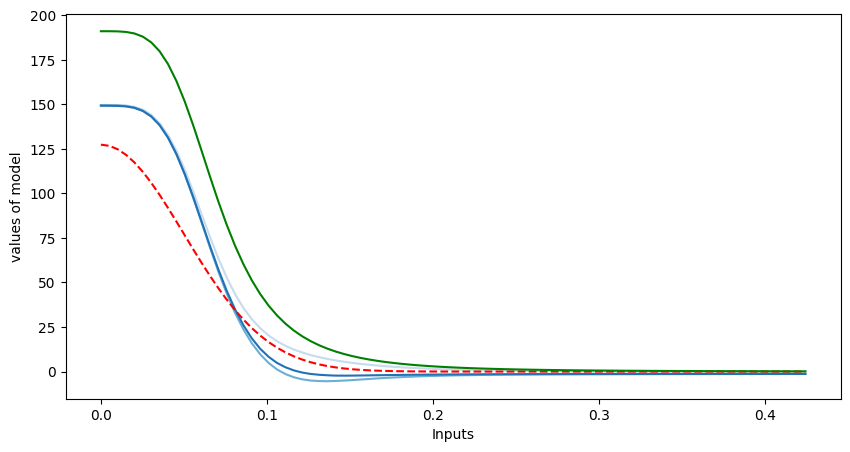

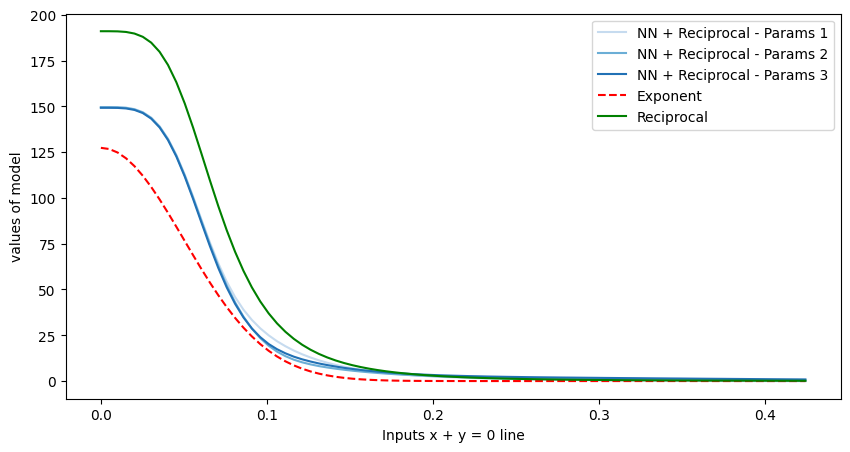

In [15]:
show_nn_trajectory([params_list[0],params_list[stage],params], model, center_x=0, center_y=0, size=85)
show_nn_trajectory_diag([params_list[0],params_list[stage],params], model)

total loss  76.67081 132.84708
local loss  0.074385226 0.54621446


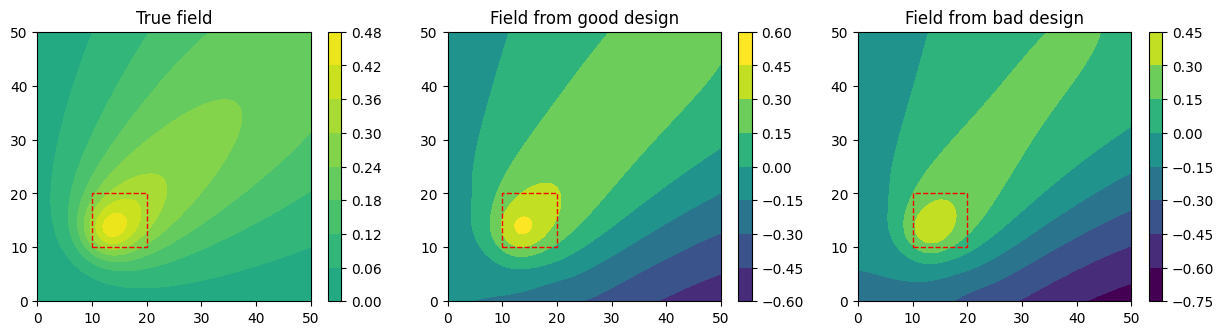

In [16]:
import matplotlib.patches as patches

u_t = sealed_convection_diffusion_true(d_start, center, stage)[1][100:151,100:151]
u_design_7 = sealed_convection_diffusion_nn(params_list[stage], d_start, center, stage, model)[1][100:151,100:151]
u_design_5 = sealed_convection_diffusion_nn(params, d_start, center, stage, model)[1][100:151,100:151]
print('total loss ',np.sum((u_t - u_design_5)**2),np.sum((u_t - u_design_7)**2))
print('local loss ',np.sum(((u_t - u_design_5)**2)[10:20,10:20]),np.sum(((u_t - u_design_7)**2)[10:20,10:20]))

# 找到所有数据的全局最小值和最大值
vmin = min(np.min(u_t), np.min(u_design_5), np.min(u_design_7))
vmax = max(np.max(u_t), np.max(u_design_5), np.max(u_design_7))

# 创建子图
fig, axes = plt.subplots(1, 3, figsize=(15, 3.5))

# 绘制 contourf 图像并设置相同的 vmin 和 vmax
c1 = axes[0].contourf(u_t.T, vmin=vmin, vmax=vmax)
c2 = axes[1].contourf(u_design_5.T, vmin=vmin, vmax=vmax)
c3 = axes[2].contourf(u_design_7.T, vmin=vmin, vmax=vmax)

rect = patches.Rectangle((10, 10), 10, 10, linewidth=1, linestyle='--', edgecolor='red', facecolor='none')
axes[0].set_title('True field')
axes[0].add_patch(rect)

rect = patches.Rectangle((10, 10), 10, 10, linewidth=1, linestyle='--', edgecolor='red', facecolor='none')
axes[1].set_title('Field from good design')
axes[1].add_patch(rect)

rect = patches.Rectangle((10, 10), 10, 10, linewidth=1, linestyle='--', edgecolor='red', facecolor='none')
axes[2].set_title('Field from bad design')
axes[2].add_patch(rect)

# 为所有子图添加颜色条
fig.colorbar(c1, ax=axes[0])
fig.colorbar(c2, ax=axes[1])
fig.colorbar(c3, ax=axes[2])

plt.show()

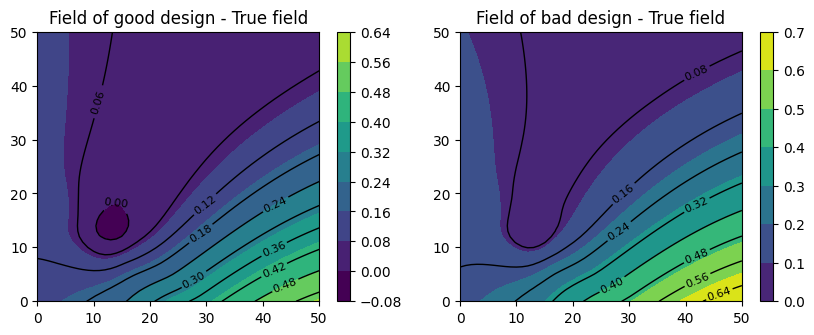

-0.0052565634 0.044045717


In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

vmin = min(np.min(u_t-u_design_5), np.min(u_t-u_design_7))
vmax = max(np.max(u_t-u_design_7), np.max(u_t-u_design_5))

# 绘制 contourf 图像并设置相同的 vmin 和 vmax
c1 = axes[0].contourf((u_t - u_design_5).T, vmin=vmin, vmax=vmax)
c2 = axes[1].contourf((u_t - u_design_7).T, vmin=vmin, vmax=vmax)

# 绘制等高线并标记所有等高线的值
contour1 = axes[0].contour((u_t - u_design_5).T, levels=10, colors='black', linewidths=1)
contour2 = axes[1].contour((u_t - u_design_7).T, levels=10, colors='black', linewidths=1)

# 给等高线标注值
axes[0].clabel(contour1, inline=True, fontsize=8)
axes[1].clabel(contour2, inline=True, fontsize=8)

axes[0].set_title('Field of good design - True field')
axes[1].set_title('Field of bad design - True field')

# 为所有子图添加颜色条
fig.colorbar(c1, ax=axes[0])
fig.colorbar(c2, ax=axes[1])

plt.show()

# 打印特定位置的值
print((u_t - u_design_5)[12, 12], (u_t - u_design_7)[12, 12])

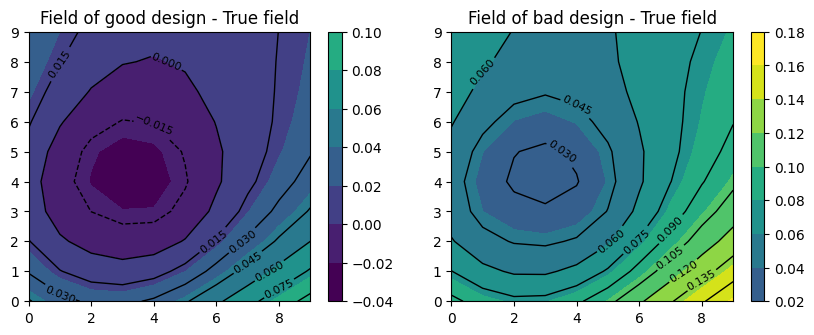

-0.0052565634 0.044045717 -0.019554406 0.031665564


In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

vmin = min(np.min(u_t[10:20,10:20]-u_design_5[10:20,10:20]), np.min(u_t[10:20,10:20]-u_design_7[10:20,10:20]))
vmax = max(np.max(u_t[10:20,10:20]-u_design_7[10:20,10:20]), np.max(u_t[10:20,10:20]-u_design_5[10:20,10:20]))

# 绘制 contourf 图像并设置相同的 vmin 和 vmax
c1 = axes[0].contourf((u_t[10:20,10:20] - u_design_5[10:20,10:20]).T, vmin=vmin, vmax=vmax)
c2 = axes[1].contourf((u_t[10:20,10:20] - u_design_7[10:20,10:20]).T, vmin=vmin, vmax=vmax)

# 绘制等高线并标记所有等高线的值
contour1 = axes[0].contour((u_t[10:20,10:20] - u_design_5[10:20,10:20]).T, levels=10, colors='black', linewidths=1)
contour2 = axes[1].contour((u_t[10:20,10:20] - u_design_7[10:20,10:20]).T, levels=10, colors='black', linewidths=1)

# 给等高线标注值
axes[0].clabel(contour1, inline=True, fontsize=8)
axes[1].clabel(contour2, inline=True, fontsize=8)

axes[0].set_title('Field of good design - True field')
axes[1].set_title('Field of bad design - True field')

# 为所有子图添加颜色条
fig.colorbar(c1, ax=axes[0])
fig.colorbar(c2, ax=axes[1])

plt.show()

# 打印特定位置的值
print((u_t - u_design_5)[12, 12], (u_t - u_design_7)[12, 12],(u_t - u_design_5)[13, 13], (u_t - u_design_7)[13, 13])


 stage =  3 

start learning design
start design :  [0.25369713 0.2914539 ]
Execution learning design time: 74.3653130531311 seconds


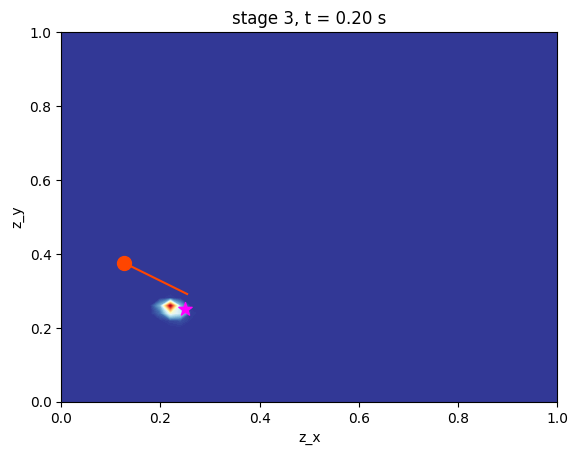

In [61]:
# 完成了新的设计计算后直接计算下一阶段的OED
#def calculate_loglikelihood(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, model):
#    '''
#    参数：
#    stage: 当前的阶段。用于决定forward模拟的步数
#    center: 污染源的中心
#    current_params: 网络的参数
#    d_start: 测量点
#    prior: 先验
#    noise_info: 测量误差设置
#    num_d: 计算后验时使用的点数
#    radio_d: 在测量点附近多选几个点测量，本质上可以理解为多次测量消除误差，可以考虑直接舍弃误差
#
#    说明：
#    1，假设数据量是300*300，计算范围是3*3
#    应该是需要数据尺寸是3的倍数，否则到时候后验那里也会费劲
#    也可以不是3的倍数，只要后验矩阵和数据矩阵匹配就行
#    2，运用了等效的原则。主要起作用的是测量点和center的相对位置
#    这里突然想到nn应该需要四个参数，当前的坐标和center，而不是仅当前坐标。
#    '''
#    noise_loc, noise_base_scale, noise_ratio_scale = noise_info[0]
#    if num_d == 1.0:
#        output_point, _ = sealed_convection_diffusion_true(d_start, center, stage) #这里的形状是()
#        #key, subkey = random.split(key) 这一步放在外面
#        
#        #暂时只考虑不要误差的情况：
#        #observation = output_point + jnp.array([0.0])
#
#        #这是要误差的代码：
#        noise = random.normal(key,(1,1))*(noise_base_scale+jnp.abs(output_point)*noise_ratio_scale) #形状(1,1)
#        observation = output_point + noise*0.05
#
#        # 给一个函数，从所有的输出中找到关心的点
#        false_center = jnp.array([1.0,1.0]) - d_start
#        false_start = jnp.array([0.5, 0.5])
#        _, output_all = sealed_convection_diffusion_nn(current_params, false_start, false_center, stage, model)
#        #_, output_all = sealed_convection_diffusion_true(false_start, false_center, stage) #这里的形状是()
#        output_all_central_sym = jnp.fliplr(jnp.flipud(output_all))
#        # 取出[0,1]^2之间的矩阵
#        xb_lo = int((0.0 - lo_b) / (up_b - lo_b) * (size - 1))
#        xb_up = int((1.0 - lo_b) / (up_b - lo_b) * (size - 1))
#        output_for_xb = output_all_central_sym[xb_lo:(xb_up+1),xb_lo:(xb_up+1)]
#        # 针对于每一个数字求likelihood
#        loglikelihood = jax.scipy.stats.norm.logpdf(output_for_xb, loc=observation, scale=noise_base_scale+noise_ratio_scale*jnp.abs(observation))
#        #loglikelihood = jax.scipy.stats.norm.logpdf(observation, loc=output_for_xb, scale=noise_base_scale+noise_ratio_scale*jnp.abs(output_for_xb))
#    return loglikelihood
    
key = random.split(key[-1],5)
#fig, axes = plt.subplots(1,5,figsize=(20,4))

for stage in [3]:

    d_start = design_list[stage]
    prior = posterior_list[stage-1]
    #params = params_list[stage-1] #沿用刚才的参数，不需要重新赋值
    #params = {'params': {'Dense_0': {'bias': jnp.array([ 1.2822,  1.1528, -1.2200,  1.1325]),
    #       'kernel': jnp.array([[ 11.5953, -11.6090, -11.8334, -10.5519],
    #    [-12.3921, -10.8175, -10.9383,  11.3898]])},
    #      'Dense_1': {'bias': jnp.array([-2.7209,  2.6878, -2.6491,  2.6046]),
    #       'kernel': jnp.array([[ 1.7158, -1.7884,  3.0201,  0.2812],
    #    [-0.2900, -3.1346,  1.7407, -1.8116],
    #    [-3.0800, -0.2645, -1.6933,  1.7542],
    #    [ 1.7458, -1.8156, -0.3283, -3.0389]])},
    #      'Dense_2': {'bias': jnp.array([-10.0284]),
    #       'kernel': jnp.array([[-13.7486],
    #    [ 12.9524],
    #    [-13.6961],
    #    [ 13.3542]])}}
    #     }
    
    print('\n stage = ', stage, '\n')
    key_for_design = random.split(key[stage*2],40)
    
    clip_count = 0
    
    if stage!=0:
        del tx1
    else:
        print(f'stage = 0, only run forward model and update posterior')
        
    #tx1 = optax.adam(lr_schedule1)
    tx1 = optax.chain(
    optax.adam(learning_rate1),  # 使用由 lr_schedule1 调整的学习率的 Adam 优化器
    optax.add_decayed_weights(1e-4)  # 添加权重衰减，衰减系数为 1e-5
    )
    
    opt_state1 = tx1.init(d_start)
    
    d_limit_min = d_start - d_change_range
    d_limit_max = d_start + d_change_range
    
    start_time = time.time()
    d_start_backup = d_start

    print('start learning design')
    print(f'start design : ', d_start)
    for i in range(40):
        negtive_KLD, grad_design = jax.value_and_grad(loss_design)(d_start, params, stage, center, prior, noise_info, num_d, radio_d, key_for_design[i], model)
        updates, opt_state1 = tx1.update(grad_design, opt_state1, params=d_start)

        
        # 解决nan的问题
        oed_nan_index = 0
        updates_contain_nans = any(jnp.any(jnp.isnan(u)) for u in jax.tree_util.tree_leaves(updates))
        if updates_contain_nans:
            oed_nan_index = oed_nan_index + 1
            print(f'NaN appears in learning. Perturb params and continue. Nan count: {oed_nan_index}')
            noise = 0.05*jax.random.normal(key_for_design[i], d_start.shape)
            d_start = d_start+ noise
        else:
            oed_nan_index = 0
            d_start = optax.apply_updates(d_start, updates)
    
        d_start_before_clip = d_start
        d_start = jnp.clip(d_start, d_limit_min, d_limit_max)
        
        # 如果clip函数生效，即有参数被裁剪，增加计数器
        clip_count = 0
        if not jnp.all(d_start == d_start_before_clip):
            clip_count += 1
        else:
            clip_count = 0
            
        if clip_count >= 5:
            print(f"Stopping iteration at step {i} as clip function has been activated 5 times.")
            break
        
        if np.isnan(d_start).any() or np.isnan(negtive_KLD).any():
            print('some results are Nan')
            break
    
        KLD_list.append(-negtive_KLD)
        
        if oed_nan_index > 6:
            print('连续出现nam并扰动6次，停止oed')
            break
            
        #if len(KLD_list) >= 5:
        #    last_five = KLD_list[-5:]
        #    if all(abs(last_five[0] - k) < 0.01*last_five[0] for k in last_five[1:]):
        #        print("连续5步的negtive_KLD几乎相同，停止循环")
        #        break  # 跳出循环
            
    end_time = time.time()
    print(f"Execution learning design time: {end_time - start_time} seconds")

    if stage not in stage_to_skip:
        _, posterior = forward_posterior_infoGain(params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], model)
        

    
    #恢复design到原来的轨迹
    #if stage in [2]:
    design_list.append(d_start)
        
    plt.contourf(grid_x_plot0, grid_y_plot0, posterior.T, levels=100,cmap='RdYlBu_r' )
    plt.scatter(d_start[0], d_start[1], marker='o', s=100, c='orangered')
    plt.scatter(center[0], center[1], marker='*', s=100, c='magenta')
    plt.plot([d_start[0],d_start_backup[0]],
                    [d_start[1],d_start_backup[1]], c='orangered')
    plt.title(f'stage {stage}, t = {((stage+1)*0.05):.2f} s')  # 设置子图的标题
    plt.xlabel('z_x')  # 设置x轴标签
    plt.ylabel('z_y')  # 设置y轴标签
    plt.show()
    #axes[stage-8].contourf(grid_x_plot0, grid_y_plot0, posterior.T, levels=100,cmap='RdYlBu_r' )
    #axes[stage-8].scatter(d_start[0], d_start[1], marker='o', s=100, c='orangered')
    #axes[stage-8].scatter(center[0], center[1], marker='*', s=100, c='magenta')
    #axes[stage-8].plot([d_start[0],d_start_backup[0]],
    #                [d_start[1],d_start_backup[1]], c='orangered')
    #axes[stage-8].set_title(f'stage {stage}, t = {((stage+1)*0.05):.2f} s')  # 设置子图的标题
    #axes[stage-8].set_xlabel('z_x')  # 设置x轴标签
    #axes[stage-8].set_ylabel('z_y')  # 设置y轴标签
    
#fig, axes = plt.subplots(1,2,figsize=(12,4))
#axes[0].contourf(posterior_list[stage].T)
#axes[0].set_title('updated by earlier design')
#axes[1].contourf(posterior.T)
#axes[1].set_title('updated by new design')

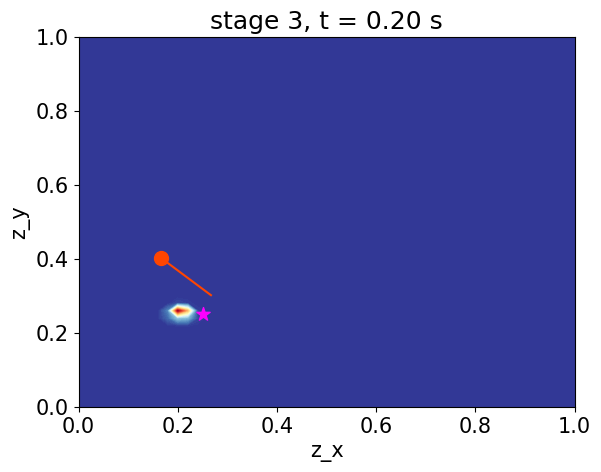

In [67]:
d_start = design_list[stage]+jnp.array([-0.1,0.1])
prior = posterior_list[stage-1]
params = params_list[stage-1] #沿用刚才的参数，不需要重新赋值
_, posterior = forward_posterior_infoGain(params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], model)
plt.contourf(grid_x_plot0, grid_y_plot0, posterior.T, levels=100,cmap='RdYlBu_r' )
plt.scatter(d_start[0], d_start[1], marker='o', s=100, c='orangered')
plt.scatter(center[0], center[1], marker='*', s=100, c='magenta')
plt.plot([d_start[0],d_start_backup[0]],
                [d_start[1],d_start_backup[1]], c='orangered')
plt.title(f'stage {stage}, t = {((stage+1)*0.05):.2f} s')  # 设置子图的标题
plt.xlabel('z_x')  # 设置x轴标签
plt.ylabel('z_y')  # 设置y轴标签
plt.show()       

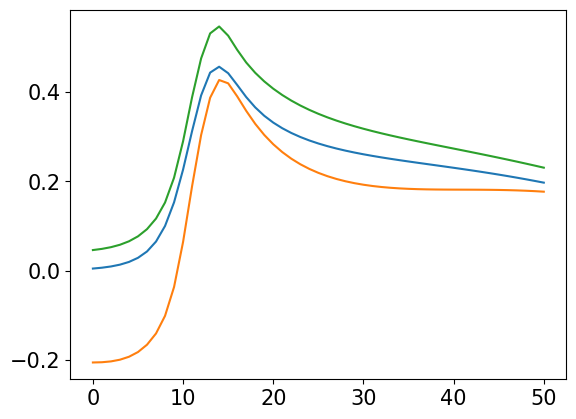

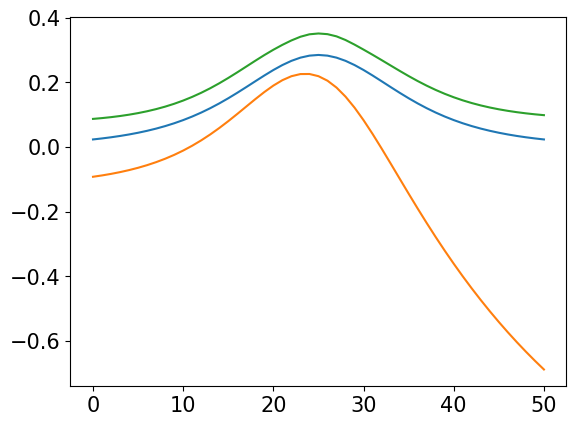

In [66]:
stage=3
params = {'params': {'Dense_0': {'bias': jnp.array([ 1.2822,  1.1528, -1.2200,  1.1325]),
       'kernel': jnp.array([[ 11.5953, -11.6090, -11.8334, -10.5519],
    [-12.3921, -10.8175, -10.9383,  11.3898]])},
      'Dense_1': {'bias': jnp.array([-2.7209,  2.6878, -2.6491,  2.6046]),
       'kernel': jnp.array([[ 1.7158, -1.7884,  3.0201,  0.2812],
    [-0.2900, -3.1346,  1.7407, -1.8116],
    [-3.0800, -0.2645, -1.6933,  1.7542],
    [ 1.7458, -1.8156, -0.3283, -3.0389]])},
      'Dense_2': {'bias': jnp.array([-10.0284]),
       'kernel': jnp.array([[-13.7486],
    [ 12.9524],
    [-13.6961],
    [ 13.3542]])}}
     }
u_t = sealed_convection_diffusion_true(d_start, center, stage)[1][100:151,100:151]
u_design_5 = sealed_convection_diffusion_nn(params_list[stage], d_start, center, stage, model)[1][100:151,100:151]
u_design_6 = sealed_convection_diffusion_nn(params, d_start, center, stage, model)[1][100:151,100:151]
diag_elements_t = np.diag(u_t)#np.diag(np.fliplr(u_t))
diag_elements_5 = np.diag(u_design_5)
diag_elements_6 = np.diag(u_design_6)
plt.plot(diag_elements_t)
plt.plot(diag_elements_5)
plt.plot(diag_elements_6)
plt.show()

diag_elements_t_T = np.diag(np.fliplr(u_t))
diag_elements_5_T = np.diag(np.fliplr(u_design_5))
diag_elements_6_T = np.diag(np.fliplr(u_design_6))
plt.plot(diag_elements_t_T)
plt.plot(diag_elements_5_T)
plt.plot(diag_elements_6_T)
plt.show()

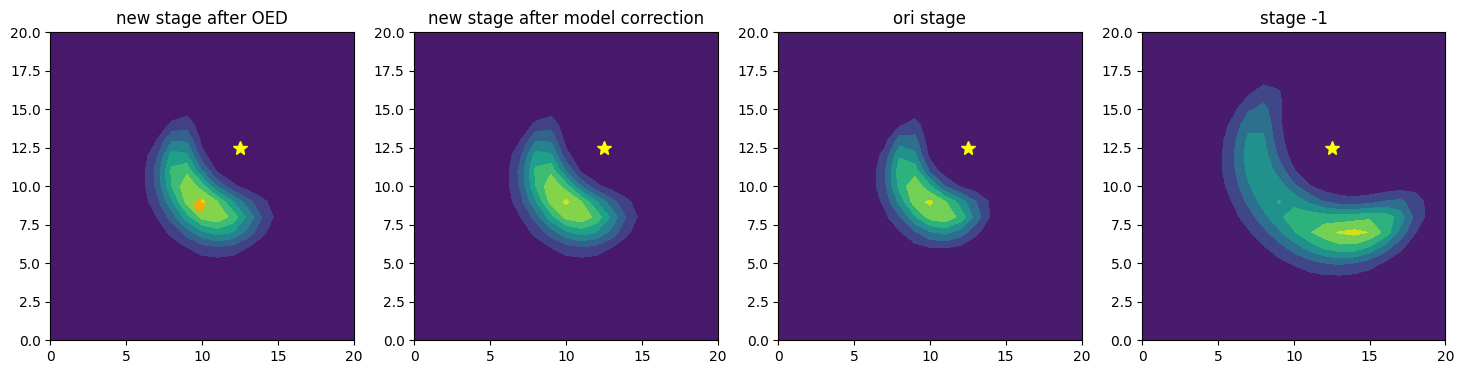

In [34]:
#_, posterior = forward_posterior_infoGain(params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], model)
fig, axes = plt.subplots(1,4,figsize=(18,4))
axes[0].contourf(prior.T)
axes[0].set_xlim([0,20])
axes[0].set_ylim([0,20])
axes[0].plot(center[0]*50,center[1]*50,color='yellow',marker='*',markersize=10)
axes[0].plot(estimated_center[0]*50,estimated_center[1]*50,color='orange',marker='*',markersize=10)
axes[0].set_title('new stage after OED')
axes[1].contourf(posterior.T)
axes[1].set_xlim([0,20])
axes[1].set_ylim([0,20])
axes[1].plot(center[0]*50,center[1]*50,color='yellow',marker='*',markersize=10)
axes[1].set_title('new stage after model correction')
axes[2].contourf(posterior_list[stage].T)
axes[2].set_xlim([0,20])
axes[2].set_ylim([0,20])
axes[2].plot(center[0]*50,center[1]*50,color='yellow',marker='*',markersize=10)
axes[2].set_title('ori stage')
axes[3].contourf(posterior_list[stage-1].T)
axes[3].set_xlim([0,20])
axes[3].set_ylim([0,20])
axes[3].set_title('stage -1')
axes[3].plot(center[0]*50,center[1]*50,color='yellow',marker='*',markersize=10)

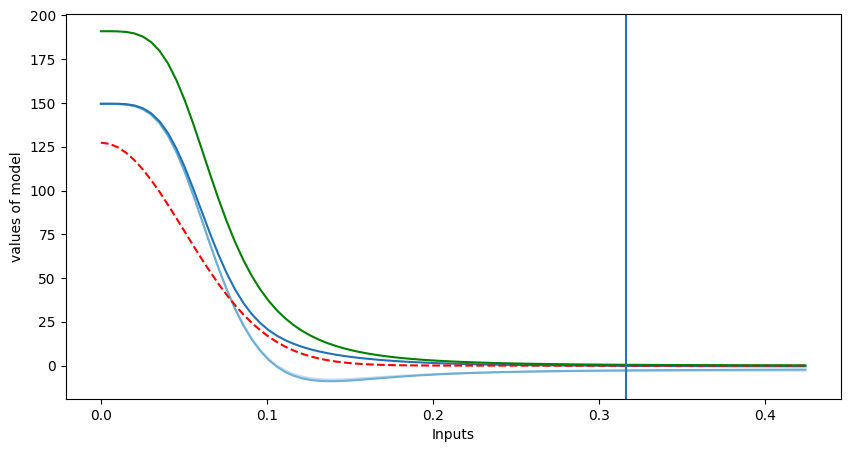

In [43]:
def show_nn_trajectory(params_list, apply_model, colormap = 'Blues', center_x=0, center_y=0, size=85):
    x = jnp.linspace(0, 0.3, size).reshape(-1, 1)
    y = jnp.linspace(0, 0.3, size).reshape(-1, 1)
    xy_combined = jnp.concatenate((x, y), axis=1)
    
    exponent_internal = ((x - center_x) ** 2 + (y - center_y) ** 2)
    factor = 2.0 / (2.0 * jnp.pi * 0.05 ** 2)
    array_exponent = factor * jnp.exp(-exponent_internal / (2.0 * 0.05 ** 2))
    array_reciprocal = factor * 1.5 / (exponent_internal ** 2 / (2.0 * 0.05 ** 2) ** 2 + 1.0)
    
    plt.figure(figsize=(10, 5))
    
    cmap = plt.colormaps[colormap].resampled(len(params_list)+2)#cm.get_cmap('Blues', len(params_list))
    for index, params in enumerate(params_list):
        #if index not in [6]:
        #    continue
        array_nn = apply_model.apply(params, xy_combined) #* 100.0
        
        plt.plot(jnp.sqrt(2) * x.squeeze(), 
                 (array_nn.squeeze() + array_reciprocal.squeeze()), 
                 label=f'NN + Reciprocal - Params {index+1}',
                 color=cmap(index+1))
    
    plt.plot(jnp.sqrt(2) * x.squeeze(), 
             array_exponent.squeeze(), color='r', linestyle = '--', label='Exponent')
    plt.plot(jnp.sqrt(2) * x.squeeze(), 
             array_reciprocal.squeeze(), color='g', label='Reciprocal')
    
    plt.ylabel('values of model')
    plt.xlabel('Inputs')
    
#show_nn_trajectory(params_list, model, center_x=0, center_y=0, size=85)
show_nn_trajectory([params_list[stage-1],params_list[stage],params], model, center_x=0, center_y=0, size=85)
distance1 = np.sqrt(np.sum((d_start - estimated_center)**2))
plt.axvline(distance1)

In [31]:
d_start, estimated_center

(Array([0.2083181, 0.3288989], dtype=float32),
 Array([0.196, 0.176], dtype=float32))

In [13]:
u_t = sealed_convection_diffusion_true(d_start, center, stage)[1][100:151,100:151]
u_design_5 = sealed_convection_diffusion_nn(params, d_start, estimated_center, stage, model)[1][100:151,100:151]
u_design_7 = sealed_convection_diffusion_nn(params_list[stage-1], d_start, estimated_center, stage, model)[1][100:151,100:151]
u_design_8 = sealed_convection_diffusion_nn(params_list[stage], d_start, estimated_center, stage, model)[1][100:151,100:151]
np.sum((u_t - u_design_5)**2),np.sum((u_t - u_design_7)**2),np.sum((u_t - u_design_8)**2)

(41.91622, 114.71689, 109.47804)

In [16]:
u_t = sealed_convection_diffusion_true(d_start, center, stage)[1][110:125,110:125]
u_design_5 = sealed_convection_diffusion_nn(params, d_start, estimated_center, stage, model)[1][110:125,110:125]
u_design_7 = sealed_convection_diffusion_nn(params_list[stage-1], d_start, estimated_center, stage, model)[1][110:125,110:125]
u_design_8 = sealed_convection_diffusion_nn(params_list[stage], d_start, estimated_center, stage, model)[1][110:125,110:125]
np.sum((u_t - u_design_5)**2),np.sum((u_t - u_design_7)**2),np.sum((u_t - u_design_8)**2)

(0.9038441, 1.574779, 1.1939421)

In [13]:
u_t = sealed_convection_diffusion_true(d_start, center, stage)[1][100:151,100:151]
u_design_5 = sealed_convection_diffusion_nn(params, d_start, center, stage, model)[1][100:151,100:151]
u_design_7 = sealed_convection_diffusion_nn(params_list[stage], d_start, center, stage, model)[1][100:151,100:151]
np.sum((u_t - u_design_5)**2),np.sum((u_t - u_design_7)**2)

(20.16698, 99.52376)

In [8]:
u_t = sealed_convection_diffusion_true(d_start, center, stage)[1][100:125,100:125]
u_design_5 = sealed_convection_diffusion_nn(params, d_start, center, stage, model)[1][100:125,100:125]
u_design_7 = sealed_convection_diffusion_nn(params_list[stage], d_start, center, stage, model)[1][100:125,100:125]
np.sum((u_t - u_design_5)**2),np.sum((u_t - u_design_7)**2)

(4.738275, 18.21538)

In [72]:
np.max((u_t-u_design_5)),np.max((u_t-u_design_7))

(0.7984278, 0.5477254)

In [73]:
np.where((u_t-u_design_7)==np.max((u_t-u_design_7)))

(array([50]), array([0]))

In [74]:
np.max((u_t-u_design_5)/u_t),np.max((u_t-u_design_7)/u_t)

(43.196358, 33.609913)

In [43]:
# 执行OED更新一步后验，对比新的后验
for stage in [6]:
    print('\n stage = ', stage, '\n')
    key_for_design = random.split(key[stage*2],iteration_step_number1[stage])
    key_for_param = random.split(key[stage*2+1],iteration_step_number2[stage])
    
    clip_count = 0
    
    if stage!=0:
        del tx1
    else:
        print(f'stage = 0, only run forward model and update posterior')
        
    #tx1 = optax.adam(lr_schedule1)
    tx1 = optax.chain(
    optax.adam(lr_schedule1),  # 使用由 lr_schedule1 调整的学习率的 Adam 优化器
    optax.add_decayed_weights(1e-4)  # 添加权重衰减，衰减系数为 1e-5
    )
    
    opt_state1 = tx1.init(d_start)
    
    d_limit_min = d_start - d_change_range
    d_limit_max = d_start + d_change_range
    
    start_time = time.time()
    d_start_backup = d_start

    print('start learning design')
    print(f'start design : ', d_start)
    for i in range(iteration_step_number1[stage]):
        negtive_KLD, grad_design = jax.value_and_grad(loss_design)(d_start, params, stage, center, prior, noise_info, num_d, radio_d, key_for_design[i], model)
        updates, opt_state1 = tx1.update(grad_design, opt_state1, params=d_start)

        
        # 解决nan的问题
        oed_nan_index = 0
        updates_contain_nans = any(jnp.any(jnp.isnan(u)) for u in jax.tree_util.tree_leaves(updates))
        if updates_contain_nans:
            oed_nan_index = oed_nan_index + 1
            print(f'NaN appears in learning. Perturb params and continue. Nan count: {oed_nan_index}')
            noise = 0.05*jax.random.normal(key_for_design[i], d_start.shape)
            d_start = d_start+ noise
        else:
            oed_nan_index = 0
            d_start = optax.apply_updates(d_start, updates)
    
        d_start_before_clip = d_start
        d_start = jnp.clip(d_start, d_limit_min, d_limit_max)
        
        # 如果clip函数生效，即有参数被裁剪，增加计数器
        clip_count = 0
        if not jnp.all(d_start == d_start_before_clip):
            clip_count += 1
        else:
            clip_count = 0
            
        if clip_count >= 5:
            print(f"Stopping iteration at step {i} as clip function has been activated 5 times.")
            break
        
        if np.isnan(d_start).any() or np.isnan(negtive_KLD).any():
            print('some results are Nan')
            break
    
        KLD_list.append(-negtive_KLD)
        
        if oed_nan_index > 6:
            print('连续出现nam并扰动6次，停止oed')
            break
            
        #if len(KLD_list) >= 5:
        #    last_five = KLD_list[-5:]
        #    if all(abs(last_five[0] - k) < 0.01*last_five[0] for k in last_five[1:]):
        #        print("连续5步的negtive_KLD几乎相同，停止循环")
        #        break  # 跳出循环
            
    end_time = time.time()
    print(f"Execution learning design time: {end_time - start_time} seconds")

    if stage!=0:
        _, posterior = forward_posterior_infoGain(params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], model)
        del prior
        prior = posterior


 stage =  6 

start learning design
start design :  [0.35514557 0.00731688]
Execution learning design time: 58.758559226989746 seconds


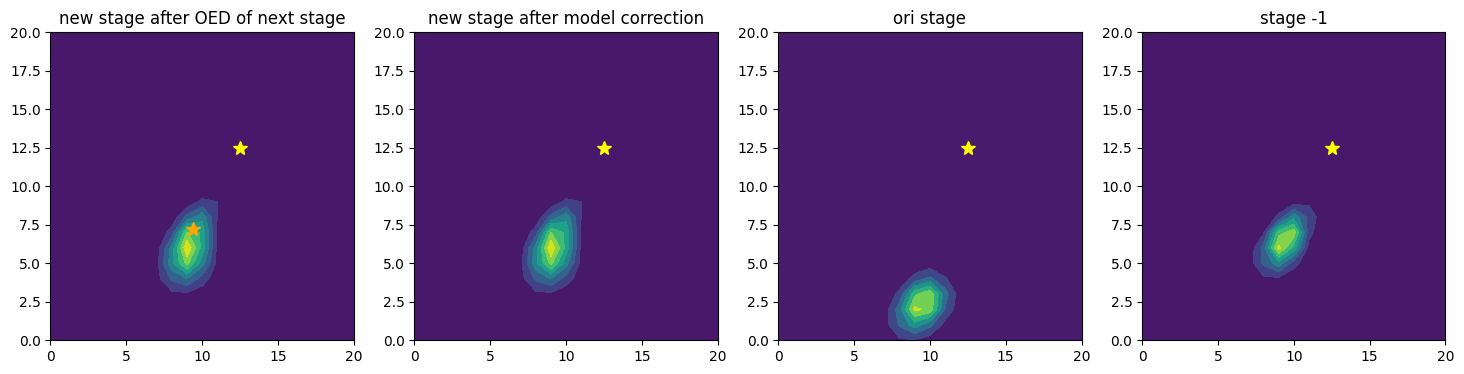

In [44]:
#_, posterior = forward_posterior_infoGain(params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], model)
fig, axes = plt.subplots(1,4,figsize=(18,4))
axes[0].contourf(prior.T)
axes[0].set_xlim([0,20])
axes[0].set_ylim([0,20])
axes[0].plot(center[0]*50,center[1]*50,color='yellow',marker='*',markersize=10)
axes[0].plot(estimated_center[0]*50,estimated_center[1]*50,color='orange',marker='*',markersize=10)
axes[0].set_title('new stage after OED of next stage')
axes[1].contourf(posterior.T)
axes[1].set_xlim([0,20])
axes[1].set_ylim([0,20])
axes[1].plot(center[0]*50,center[1]*50,color='yellow',marker='*',markersize=10)
axes[1].set_title('new stage after model correction')
axes[2].contourf(posterior_list[stage].T)
axes[2].set_xlim([0,20])
axes[2].set_ylim([0,20])
axes[2].plot(center[0]*50,center[1]*50,color='yellow',marker='*',markersize=10)
axes[2].set_title('ori stage')
axes[3].contourf(posterior_list[stage-1].T)
axes[3].set_xlim([0,20])
axes[3].set_ylim([0,20])
axes[3].set_title('stage -1')
axes[3].plot(center[0]*50,center[1]*50,color='yellow',marker='*',markersize=10)

In [54]:
u_t = sealed_convection_diffusion_true(d_start, center, stage)[1][100:125,100:125]
u_design_5 = sealed_convection_diffusion_nn(params, d_start, estimated_center, stage, model)[1][100:125,100:125]
u_design_7 = sealed_convection_diffusion_nn(params_list[stage-1], d_start, estimated_center, stage, model)[1][100:125,100:125]
np.sum((u_t - u_design_5)**2),np.sum((u_t - u_design_7)**2)

(6.5567346, 7.022069)

In [45]:
u_t = sealed_convection_diffusion_true(d_start, center, stage)[1][110:120,110:120]
u_design_5 = sealed_convection_diffusion_nn(params, d_start, estimated_center, stage, model)[1][110:120,110:120]
u_design_7 = sealed_convection_diffusion_nn(params_list[stage-1], d_start, estimated_center, stage, model)[1][110:120,110:120]
np.sum((u_t - u_design_5)**2),np.sum((u_t - u_design_7)**2)

(0.46408007, 1.2470524)

In [46]:
u_t = sealed_convection_diffusion_true(d_start, center, stage)[1][100:151,100:151]
u_design_5 = sealed_convection_diffusion_nn(params_list[stage], d_start, estimated_center, stage, model)[1][100:151,100:151]
u_design_7 = sealed_convection_diffusion_nn(params_list[stage-1], d_start, estimated_center, stage, model)[1][100:151,100:151]
np.sum((u_t - u_design_5)**2),np.sum((u_t - u_design_7)**2)

(41.80075, 67.45976)

In [ ]:
# EKI

In [5]:
import os
import pickle
import re
import gc
from flax.traverse_util import flatten_dict, unflatten_dict

def reconstruct_array_to_dict(params_grad_array, grads):
    """
    将扁平化后的数组重新构建回原始的 grads 字典。

    参数:
    - params_grad_array: 扁平化后的梯度数组
    - grads: 原始的 grads 字典，用于获取结构信息

    返回:
    - reconstructed_grads: 重建后的 grads 字典
    """
    # 获取原始 grads 的结构信息
    params_grad_flat = flatten_dict(grads)
    shapes = {k: v.shape for k, v in params_grad_flat.items()}

    # 将 params_grad_array 拆分成原始形状的数组
    index = 0
    reconstructed_params_grad_flat = {}
    for k, shape in shapes.items():
        size = size = int(np.prod(shape))  # 将形状转换为 numpy 数组，然后计算其大小
        reconstructed_params_grad_flat[k] = jnp.reshape(params_grad_array[index:index+size], shape)
        index += size

    # 将平坦化的字典恢复到原始的嵌套结构
    reconstructed_grads = unflatten_dict(reconstructed_params_grad_flat)

    return reconstructed_grads

def reconstruct_dict_to_array(grads):
    """
    将嵌套字典转换为扁平化的数组。

    参数:
    - grads: 嵌套的 grads 字典

    返回:
    - params_grad_array: 扁平化后的梯度数组
    """
    # 将字典展平
    params_grad_flat = flatten_dict(grads)
    
    # 获取所有梯度值，并将其展平
    flat_arrays = [jnp.ravel(v) for v in params_grad_flat.values()]
    
    # 将所有展平的数组拼接成一个单独的数组
    params_grad_array = jnp.concatenate(flat_arrays)
    
    return params_grad_array
    
def kl_divergence(mu1, sigma1, mu2, sigma2):
    # 计算逆矩阵和行列式
    sigma2_inv = jnp.linalg.inv(sigma2)
    #sigma1_det = jnp.linalg.det(sigma1)
    #sigma2_det = jnp.linalg.det(sigma2)
    
    # 计算各项
    term1 = jnp.trace(sigma2_inv @ sigma1)
    term2 = (mu2 - mu1).T @ sigma2_inv @ (mu2 - mu1)
    
    _, logdet_sigma1 = jnp.linalg.slogdet(sigma1)
    _, logdet_sigma2 = jnp.linalg.slogdet(sigma2)
    term3 = logdet_sigma2 - logdet_sigma1
    #term3 = jnp.log(sigma2_det / sigma1_det)
    
    # 计算最终的KL散度
    kl_div = 0.5 * (term1 + term2 - len(mu1) + term3)
    
    return kl_div
    
def EnKF_process_correct(d_start, observation, ensemble_member, estimated_center, stage, model, key2, num_top=5):
    # 进行一次EnKF更新
    # 这个代码是不能够并行的

    # 生成初始状态的场
    # 直接在外面生成一个导入
    # 从这个场，用ensemble menber更新到现在

    # 输入ensemble_member是数组
    # 输出theta_samples_updated是数组
    # noise_info, lo_b, up_b, size, num_top 是全局变量
    
    ensemble_size_local = ensemble_member.shape[0]
    noise_loc, noise_base_scale, noise_ratio_scale = noise_info[0]
    xb_lo = int((0.0 - lo_b) / (up_b - lo_b) * (size - 1))
    xb_up = int((1.0 - lo_b) / (up_b - lo_b) * (size - 1))


    y_fs = jnp.zeros((ensemble_size_local,1))
    
    for i in range(ensemble_size_local):
        ensemble_member_dict = reconstruct_array_to_dict(ensemble_member[i],params)
        y_f, _  = sealed_convection_diffusion_nn(ensemble_member_dict, d_start, estimated_center, stage, model)
        y_fs = y_fs.at[i,0].set(y_f)
        print('.',end='')
    
    y_f_mean = jnp.mean(y_fs)
    P_yy = 1/(ensemble_size_local-1)*jnp.sum((y_fs-y_f_mean)**2)+1.0#noise_base_scale

    #x_f_theta = ensemble_member.reshape(ensemble_size_local,-1) # 这一步是对于1维情况准备的，高维情况不用reshape
    x_f_theta = ensemble_member
    x_f_mean = jnp.mean(x_f_theta, axis=0).reshape(1,-1)

    x_f_deviation = x_f_theta - x_f_mean
    y_f_deviation = y_fs - y_f_mean.reshape(1,1)
    P_xy = jnp.matmul(x_f_deviation.T, y_f_deviation) / (ensemble_size_local - 1) 

    K = P_xy * 1.0/P_yy
    x_a = x_f_theta + jnp.matmul(K, (observation - y_fs).T).T
    #x_a = x_f_theta + jnp.matmul(K, (observation + jax.random.normal(key2, shape=observation.shape)*noise_base_scale - y_fs).T).T
    
    return x_a

    

# 现在需要一个函数，对于一个给定的场，给出一些index，取出/插值这些index上的点
def insert_from_u(u,indexs):
    # 要求indexs是一个数组，design_number * 2 / 或者一个列表
    y_f_member = jnp.zeros((1, len(indexs)))
    for i in range(len(indexs)):
        y_f = jax.scipy.ndimage.map_coordinates(u,indexs[i],1)
        y_f_member = y_f_member.at[0,i].set(y_f)

    return y_f_member

#indexs=np.array([[111,111],
#                [112,113]])
#insert_from_u(output_all, indexs)

#import numpy as np

def generate_2d_grid(lower_limit, upper_limit, num_points):
    # 在两个方向上生成指定数量的点
    x = np.linspace(lower_limit, upper_limit, num_points)
    y = np.linspace(lower_limit, upper_limit, num_points)
    
    # 生成网格
    X, Y = np.meshgrid(x, y)
    
    # 将网格点坐标转换为n*2的数组
    grid_points = np.vstack([X.ravel(), Y.ravel()]).T
    
    return grid_points

#def generate_2d_grid_xy(x_mid, y_mid, space, num=3):
#    # 在两个方向上生成指定数量的点
#    x = np.array([x_mid-space, x_mid, x_mid+space])
#    y = np.array([y_mid-space, y_mid, y_mid+space])
#    
#    # 生成网格
#    X, Y = np.meshgrid(x, y)
#    
#    # 将网格点坐标转换为n*2的数组
#    grid_points = np.vstack([X.ravel(), Y.ravel()]).T
#    
#    return grid_points

## 示例使用
#lower = 110
#upper = 130
#num = 5
#grid = generate_2d_grid(lower, upper, num)
#print(grid)

def generate_2d_grid_xy(x_mid, y_mid, space, num=3):
    # 检查num是否为奇数，如果不是则加1使其为奇数
    if num % 2 == 0:
        raise ValueError("num必须是奇数")

    # 生成x方向的点，确保中点位于x_mid
    x = np.linspace(x_mid - space * (num // 2), x_mid + space * (num // 2), num)
    
    # 生成y方向的点，确保中点位于y_mid
    y = np.linspace(y_mid - space * (num // 2), y_mid + space * (num // 2), num)
    
    # 生成网格
    X, Y = np.meshgrid(x, y)
    
    # 将网格点坐标转换为n*2的数组
    grid_points = np.vstack([X.ravel(), Y.ravel()]).T
    
    return grid_points

def EnKF_process_singledata(d_start, observation, ensemble_member, estimated_center, stage, model):
    
    ensemble_size_local = ensemble_member.shape[0]
    noise_loc, noise_base_scale, noise_ratio_scale = noise_info[0]

    observe_size = 1
    y_fs = jnp.zeros((ensemble_size_local,observe_size))
    
    for i in range(ensemble_size_local):
        ensemble_member_dict = reconstruct_array_to_dict(ensemble_member[i],params)
        y_f_member, _  = sealed_convection_diffusion_nn(ensemble_member_dict, d_start, estimated_center, stage, model) # u的尺寸是251*251
        y_fs = y_fs.at[i].set(y_f_member.squeeze())
        print('.',end='')
    
    y_f_mean = np.mean(y_fs, axis=0).reshape(1,-1)
    
    noise_covariance_matrix = np.eye(observe_size) * noise_base_scale
    P_yy = 1/(ensemble_size_local - 1) * np.matmul((y_fs - y_f_mean).T, (y_fs - y_f_mean)) + noise_covariance_matrix

    #x_f_theta = ensemble_member.reshape(ensemble_size_local,-1) # 这一步是对于1维情况准备的，高维情况不用reshape
    x_f_theta = ensemble_member
    x_f_mean = jnp.mean(x_f_theta, axis=0).reshape(1,-1)

    x_f_deviation = x_f_theta - x_f_mean
    y_f_deviation = y_fs - y_f_mean
    P_xy = jnp.matmul(x_f_deviation.T, y_f_deviation) / (ensemble_size_local - 1) 

    K = np.matmul(P_xy, np.linalg.inv(P_yy))
    x_a = x_f_theta + jnp.matmul(K, (observation - y_fs).T).T
    
    #x_a_mean = np.mean(x_a, axis=0)
    #inflation_factor = 1.01 # 或其他合适的值
    #x_a = x_a_mean + inflation_factor * (x_a - x_a_mean) # 膨胀因子
    
    return x_a

In [9]:
indexs = generate_2d_grid(112, 114, 3)

mean_array = reconstruct_dict_to_array(params)
ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(keys_ensemble, mean_array, 0.3)
ensemble_size_local = ensemble_members_array.shape[0]
noise_loc, noise_base_scale, noise_ratio_scale = noise_info[0]
observe_size = len(indexs)
y_fs = jnp.zeros((ensemble_size_local,observe_size))

for i in range(ensemble_size_local):
    ensemble_member_dict = reconstruct_array_to_dict(ensemble_members_array[i],params)
    _, u  = sealed_convection_diffusion_nn(ensemble_member_dict, d_start, estimated_center, stage, model2) # u的尺寸是251*251
    y_f_member = insert_from_u(u,indexs)
    y_fs = y_fs.at[i,:].set(y_f_member.squeeze())
    print('.',end='')

y_f_mean = np.mean(y_fs, axis=0).reshape(1,-1)

noise_covariance_matrix = np.eye(observe_size) * noise_base_scale
P_yy = 1/(ensemble_size_local - 1) * np.matmul((y_fs - y_f_mean).T, (y_fs - y_f_mean)) + noise_covariance_matrix

_, ut  = sealed_convection_diffusion_true(d_start, center, stage) # u的尺寸是251*251
observations = insert_from_u(ut,indexs)

x_f_theta = ensemble_members_array
x_f_mean = jnp.mean(x_f_theta, axis=0).reshape(1,-1)
x_f_deviation = x_f_theta - x_f_mean
y_f_deviation = y_fs - y_f_mean
P_xy = jnp.matmul(x_f_deviation.T, y_f_deviation) / (ensemble_size_local - 1) 
K = np.matmul(P_xy, np.linalg.inv(P_yy))
x_a = x_f_theta + jnp.matmul(K, (observation - y_fs).T).T

NameError: name 'generate_sample' is not defined

In [32]:
noise_covariance_matrix = np.eye(observe_size) * 0.005
1/(ensemble_size_local - 1) * np.matmul((y_fs - y_f_mean).T, (y_fs - y_f_mean))+noise_covariance_matrix

array([[0.08165391, 0.07864896, 0.08044714, 0.07548855, 0.07755321,
        0.07942509, 0.07405077, 0.07619586, 0.07816319],
       [0.07864896, 0.0858299 , 0.08281276, 0.07744899, 0.07969819,
        0.08175255, 0.07596668, 0.07829359, 0.0804405 ],
       [0.08044714, 0.08281276, 0.08998357, 0.0792132 , 0.08164512,
        0.08388437, 0.0776903 , 0.08019661, 0.08252431],
       [0.07548855, 0.07744899, 0.0792132 , 0.07945768, 0.07649112,
        0.07833023, 0.07314974, 0.07526715, 0.07720296],
       [0.07755321, 0.07969819, 0.08164512, 0.07649112, 0.083709  ,
        0.08072985, 0.07514136, 0.07744177, 0.07955759],
       [0.07942509, 0.08175255, 0.08388437, 0.07833023, 0.08072985,
        0.08793366, 0.07694044, 0.07942039, 0.0817164 ],
       [0.07405077, 0.07596668, 0.0776903 , 0.07314974, 0.07514136,
        0.07694044, 0.07697357, 0.07405189, 0.07594782],
       [0.07619586, 0.07829359, 0.08019661, 0.07526715, 0.07744177,
        0.07942039, 0.07405189, 0.08131321, 0.07838838],


In [ ]:
def generate_sample(key, mean, std_dev):
    return mean + std_dev * jax.random.normal(key, shape=mean.shape)
    
def natural_key(filename):
    return [int(part) if part.isdigit() else part for part in re.split(r'(\d+)', filename)]

# 保存检查点的函数
def save_checkpoint(i, j, params_trajectory, ensemble_members_array):
    checkpoint = {
        'i': i,
        'j': j,
        'params_trajectory': params_trajectory,
        'ensemble_members_array': ensemble_members_array
    }
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_i_{i}_j_{j}.pkl')
    with open(checkpoint_path, 'wb') as f:
        pickle.dump(checkpoint, f)
    print(f"Checkpoint saved at i={i}, j={j}")

# 加载最近的检查点
def load_checkpoint(j):
    checkpoint_files = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith(f'_j_{j}.pkl')], key=natural_key)
    if checkpoint_files:
        latest_checkpoint = checkpoint_files[-1]
        checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
        with open(checkpoint_path, 'rb') as f:
            checkpoint = pickle.load(f)
        print(f"Checkpoint loaded from {latest_checkpoint}")
        return checkpoint
    return None

def EnKF_process_multidata(indexs, observation, ensemble_member, estimated_center, stage, model, key2, step_index, num_top=5):
    
    ensemble_size_local = ensemble_member.shape[0]
    noise_loc, noise_base_scale, noise_ratio_scale = noise_info[0]

    observe_size = len(indexs)
    y_fs = jnp.zeros((ensemble_size_local,observe_size))
    
    for i in range(ensemble_size_local):
        ensemble_member_dict = reconstruct_array_to_dict(ensemble_member[i],params)
        _, u  = sealed_convection_diffusion_nn(ensemble_member_dict, d_start, estimated_center, stage, model) # u的尺寸是251*251
        y_f_member = insert_from_u(u,indexs)
        y_fs = y_fs.at[i,:].set(y_f_member.squeeze())
        print('.',end='')
    
    y_f_mean = np.mean(y_fs, axis=0).reshape(1,-1)
    
    noise_covariance_matrix = np.eye(observe_size) * noise_base_scale
    P_yy = 1/(ensemble_size_local - 1) * np.matmul((y_fs - y_f_mean).T, (y_fs - y_f_mean)) + noise_covariance_matrix

    #x_f_theta = ensemble_member.reshape(ensemble_size_local,-1) # 这一步是对于1维情况准备的，高维情况不用reshape
    x_f_theta = ensemble_member
    x_f_mean = jnp.mean(x_f_theta, axis=0).reshape(1,-1)

    x_f_deviation = x_f_theta - x_f_mean
    y_f_deviation = y_fs - y_f_mean
    P_xy = jnp.matmul(x_f_deviation.T, y_f_deviation) / (ensemble_size_local - 1) 

    K = np.matmul(P_xy, np.linalg.inv(P_yy))

    x_a = x_f_theta + jnp.matmul(K, (observation - y_fs).T).T

    #x_a_mean = np.mean(x_a, axis=0)
    #inflation_factor = 1.001 # 或其他合适的值
    #x_a = x_a_mean + inflation_factor * (x_a - x_a_mean) # 膨胀因子
    
    return x_a

In [11]:
estimated_posterior_point

[Array([0.268, 0.384], dtype=float32),
 Array([0.24399999, 0.212     ], dtype=float32),
 Array([0.236     , 0.24800001], dtype=float32),
 Array([0.22399999, 0.24800001], dtype=float32),
 Array([0.216     , 0.24800001], dtype=float32)]

In [ ]:
# 完成一个eki的部分

In [6]:
from jax import checkpoint

def predict_y_f(d_start, center, stage, model, ensemble_member_i):
    ensemble_member_i_dict = reconstruct_array_to_dict(ensemble_member_i,params)
    y_f, _ = sealed_convection_diffusion_nn(ensemble_member_i_dict, d_start, center, stage, model)
    return y_f

vmap_predict_y_f = jax.vmap(predict_y_f, in_axes=(None, None, None, None, 0))

def generate_sample(key, mean, std_dev):
    return mean + std_dev * jax.random.normal(key, shape=mean.shape)
     
def EnKF_process_fixCenter(d_start, center, observation_local, ensemble_member, stage, model, noise_level_eki=1e-5, inflation_factor=1.0, step_size=0.5):
    # 进行一次EnKF更新
    
    ensemble_size_local = ensemble_member.shape[0]
    
    y_fs = vmap_predict_y_f(d_start, center, stage, model, ensemble_member)

    y_fs = y_fs.reshape((ensemble_size_local, 1))
    
    y_f_mean = jnp.mean(y_fs)
    
    P_yy = 1/(ensemble_size_local-1)*jnp.sum((y_fs-y_f_mean)**2)+noise_level_eki

    x_f_theta = ensemble_member.reshape(ensemble_size_local,-1)
    x_f_mean = jnp.mean(x_f_theta, axis=0).reshape(1,-1)

    x_f_deviation = x_f_theta - x_f_mean
    y_f_deviation = y_fs - y_f_mean.reshape(1,1)
    P_xy = jnp.matmul(x_f_deviation.T, y_f_deviation) / (ensemble_size_local - 1) 

    K = P_xy * 1.0/P_yy
    x_a = x_f_theta + step_size*jnp.matmul(K, (observation_local - y_fs).T).T
    
    x_a_mean = jnp.mean(x_a, axis=0)
    x_a = x_a_mean + inflation_factor * (x_a - x_a_mean) # 膨胀因子
    
    return x_a


stage = 1

d_start=jnp.array([0.5,0.5])-jnp.array([0.1,0.1])
estimated_center = jnp.array([0.4,0.2])
observation, _ = sealed_convection_diffusion_true(d_start, center, stage)

mean_array = reconstruct_dict_to_array(params)
std_dev = 0.3
ensemble_size = 30

key_ensemble = jax.random.PRNGKey(0)  # 随机数种子
keys_ensemble = jax.random.split(key_ensemble, ensemble_size)

ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(keys_ensemble, mean_array, std_dev)

#vmap_predict_y_f(d_start, center, stage, model, ensemble_members_array)

#%time update_array = EnKF_process_fixCenter(d_start, estimated_center, observation, ensemble_members_array, stage, model, noise_level_eki=1e-5, inflation_factor=1.0, step_size=0.5)

#EnKF_process_singledata(d_start, observation, ensemble_members_array, estimated_center, stage, model)

y_fs = ensemble_members_array


# 固定所有不变参数，仅让 d_start 动态变化
def body(i, y_fs):
    return checkpoint(EnKF_process_fixCenter, static_argnums=(1, 2, 4, 5, 6, 7))(d_start, estimated_center, observation, y_fs, stage, model, 0.0002, 1.0, 0.5)

# 使用 fori_loop 进行循环，不保存中间结果
%time y_fs = jax.lax.fori_loop(0, 10, body, y_fs)

CPU times: user 2.01 s, sys: 3.53 s, total: 5.54 s
Wall time: 1.11 s


In [20]:
jnp.cov(ensemble_members_array, rowvar=False).shape

(37, 37)

In [ ]:
def loss_function5(d_start, center, estimated_center, noise_level_eki):
    y_fs = ensemble_members_array
    
    observation_local, _ = sealed_convection_diffusion_true(d_start, center, stage)
    
    # 固定所有不变参数，仅让 d_start 动态变化
    def body(i, y_fs):
        return checkpoint(EnKF_process_fixCenter, static_argnums=(1, 2, 4, 5, 6, 7, 8))(d_start, estimated_center, observation_local, y_fs, stage, model, noise_level_eki, 1.0, 0.5)
    
    # 使用 fori_loop 进行循环，不保存中间结果
    y_fs = jax.lax.fori_loop(0, 3, body, y_fs)

    updated_mu = jnp.mean(y_fs,axis=0)
    updated_sigma = jnp.cov(y_fs, rowvar=False)
    
    #return updated_sigma, (updated_mu,updated_sigma)
    return -kl_divergence(updated_mu, updated_sigma, initial_mu, initial_sigma), (updated_mu,updated_sigma)
    

stage = 6
ensemble_size = 70

key_ensemble = jax.random.PRNGKey(0)  # 随机数种子
keys_ensemble = jax.random.split(key_ensemble, ensemble_size)

ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(keys_ensemble, mean_array, std_dev)

initial_mu = jnp.mean(ensemble_members_array,axis=0)
initial_sigma = jnp.cov(ensemble_members_array, rowvar=False)

%time jax.value_and_grad(loss_function5,has_aux=True)(d_start, center, estimated_center, 0.0002)

In [10]:
# stage = 8, ensemble size = 40
# stage = 6, ensemble size = 50

In [147]:
np.trace(np.cov(ensemble_members_array, rowvar=False)), np.trace(np.cov(y_fs, rowvar=False))

(3.440898118136809, 3.258453275151448)

In [142]:
array2 = reconstruct_array_to_dict(jnp.mean(y_fs,axis=0),params) #d_start=jnp.array([0.5,0.5])

In [133]:
array1 = reconstruct_array_to_dict(jnp.mean(y_fs,axis=0),params) #d_start=jnp.array([0.5,0.5])

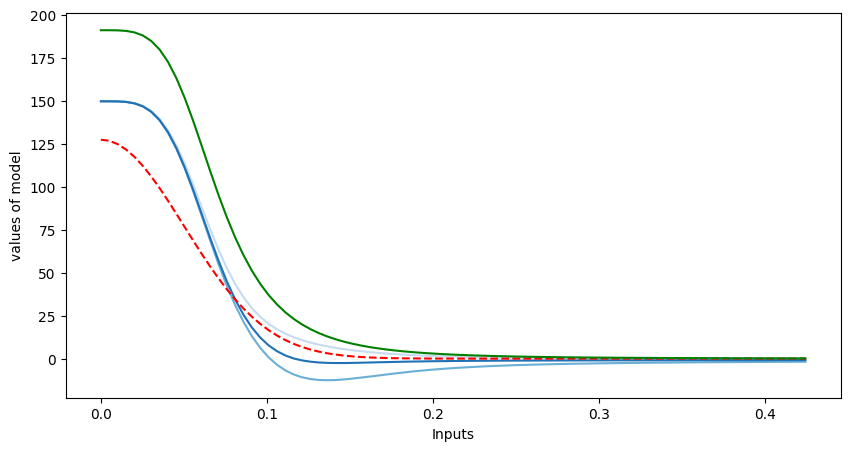

In [143]:
show_nn_trajectory([params,array1, array2], model, colormap = 'Blues', center_x=0, center_y=0, size=85)

In [144]:
u_t = sealed_convection_diffusion_true(d_start, center, stage)[1][100:151,100:151]
u_design_5 = sealed_convection_diffusion_nn(array1, d_start, estimated_center, stage, model)[1][100:151,100:151]
u_design_7 = sealed_convection_diffusion_nn(array2, d_start, estimated_center, stage, model)[1][100:151,100:151]
print(np.sum((u_t - u_design_5)**2),np.sum((u_t - u_design_7)**2))

u_t = sealed_convection_diffusion_true(d_start, center, stage)[1][110:121,110:121]
u_design_5 = sealed_convection_diffusion_nn(array1, d_start, estimated_center, stage, model)[1][110:121,110:121]
u_design_7 = sealed_convection_diffusion_nn(array2, d_start, estimated_center, stage, model)[1][110:121,110:121]
print(np.sum((u_t - u_design_5)**2),np.sum((u_t - u_design_7)**2))

27.165089 34.083313
6.5599194 6.322235


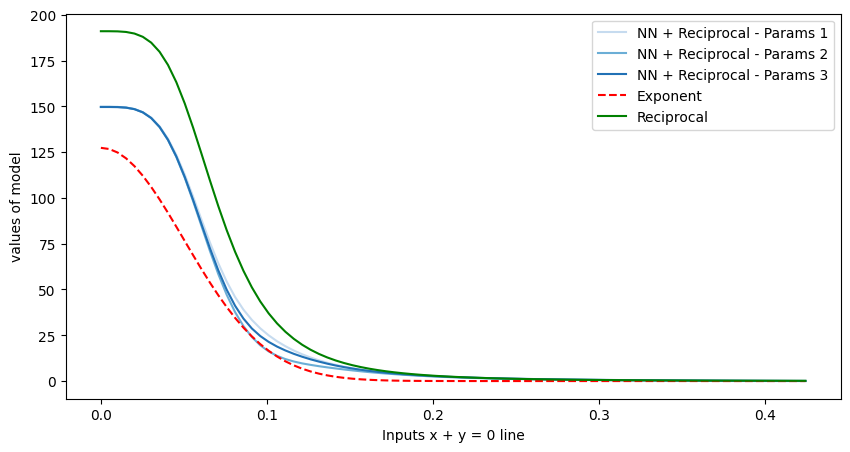

In [145]:
show_nn_trajectory_diag([params,array1, array2], model)

In [83]:
ensemble_size_local = ensemble_members_array.shape[0]

y_fs = vmap_predict_y_f(d_start, center, stage, model, ensemble_members_array)
y_fs = y_fs.reshape((ensemble_size_local, 1))

y_f_mean = jnp.mean(y_fs)

1/(ensemble_size_local-1)*jnp.sum((y_fs-y_f_mean)**2)

Array(0.07716636, dtype=float32)

In [ ]:
with open('all_data_nn_case_data_6_test9.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

posterior_list = loaded_data["posterior_list"]
design_list = loaded_data["design_list"]
params_list = loaded_data["params_list"]
estimated_posterior_point = loaded_data["estimated_posterior_point"]


stage = 2
grid_size=50
ensemble_size = 300  # 生成的数组数量
ensemble_step = 10


std_dev = 0.3  #0.05  #0.1  # 标准差

key_ensemble = jax.random.PRNGKey(0)  # 随机数种子
keys_ensemble = jax.random.split(key_ensemble, ensemble_size)
key2 = jax.random.PRNGKey(2)  # 随机数种子

class localFullyConnectedNN2(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=4)(x)  # 输入层到隐藏层1，8个节点
        x = nn.tanh(x)  # 激活函数
        x = nn.Dense(features=4)(x)  # 隐藏层1到隐藏层2，4个节点
        x = nn.tanh(x)  # 激活函数
        x = nn.Dense(features=1)(x)  # 隐藏层2到输出层，1个节点
        return x
        
model2 = localFullyConnectedNN2()  # 创建模型实例



estimated_center = estimated_posterior_point[stage]
print(f'estimated center is {estimated_center}')

#ensemble_optimizer = optax.adam(0.2)



noise_loc = 0
noise_base_scale = 0.005
noise_ratio_scale = 0.05
noise_info = [(noise_loc, noise_base_scale, noise_ratio_scale),]

In [ ]:
checkpoint_dir = './checkpoints/nn_case_data_6_EnFK_stage2_test21'
os.makedirs(checkpoint_dir, exist_ok=True)

d_start1 = design_list[stage+1]
d_start2 = design_list[stage+1]+jnp.array([0.05,-0.05])
d_start3 = design_list[stage+1]+jnp.array([-0.1,0.0])
d_start4 = jnp.array([0.2,0.2])
d_start5 = jnp.array([0.17,0.17])
d_start6 = jnp.array([0.35,0.15])
d_start8 = jnp.array([0.23,0.28])
d_start9 = jnp.array([0.17,0.12])

#key_for_ensemble = jax.random.split(key2,ensemble_step)

# 主循环
for j in [0,1]:#range(1):

    params = params_list[stage-1]

    
    mean_array = reconstruct_dict_to_array(params)

    ensemble_length=len(mean_array)

    # 初始化设计 d_start 根据 j 的值变化
    if j == 0:
        d_start = d_start1
    elif j == 1:
        d_start = d_start2
    elif j == 2:
        d_start = d_start3
    elif j == 3:
        d_start = d_start4
    elif j == 4:
        d_start = d_start5
    elif j == 5:
        d_start = d_start6
    elif j == 7:
        d_start = d_start8
    elif j == 8:
        d_start = d_start9
    

    
    #indexs = generate_2d_grid(110, 130, 10)
    #indexs = generate_2d_grid(105, 125, 21)

    if j != 6:
        indexs = generate_2d_grid_xy(d_start[0]*50+100, d_start[1]*50+100, 1)
    else:
        indexs = np.array([#        indexs = np.array([
            [0.25,0.283],#                    [0.23,0.283],
            [0.26,0.273],#                    [0.24,0.26],
            [0.27,0.26],#                    [0.25,0.25],
            [0.28,0.26],#                    [0.26,0.24],
            [0.29,0.25],#                    [0.27,0.24],
            [0.30,0.245],#                    [0.28,0.233],
            [0.24,0.30],#                    [0.29,0.22],
            [0.23,0.32],#                    [0.22,0.29],
            [0.31,0.24]#                    [0.21,0.32]
        ])*50+100#                ])*50+100
        
    # 生辰观测数据
    _, ut  = sealed_convection_diffusion_true(d_start, center, stage) # u的尺寸是251*251
    observations = insert_from_u(ut,indexs)
    _, u0  = sealed_convection_diffusion_true(d_start, estimated_center, stage) # u的尺寸是251*251
    y0 = insert_from_u(u0,indexs)
     
        
    # 每次 j 切换时重新加载或初始化参数
    checkpoint = load_checkpoint(j)
    
    if checkpoint is not None:
        start_step = checkpoint['i']
        params_trajectory = checkpoint['params_trajectory']
        ensemble_members_array = checkpoint['ensemble_members_array']
        print(f'continue from design {j}, step {i}')
    else:
        start_step = 0
        # 初始化参数，在每次 j 切换时都要重新初始化
        ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(keys_ensemble, mean_array, std_dev)
        params_trajectory = np.zeros((ensemble_step + 1, ensemble_size, ensemble_length))
        params_trajectory[0] = ensemble_members_array
        print(f'start from design {j}. step initial')



    for i in range(start_step, ensemble_step):
        key2 = jax.random.split(key2,1)[0]
        
        #observation_perturbed =  observations + 0.001 * jax.random.normal(key_for_ensemble[i], observations.shape)
        #ensemble_members_array = EnKF_process_multidata(indexs, observation_perturbed, ensemble_members_array, estimated_center, stage, model2, key2, i, num_top=5)
        
        ensemble_members_array = EnKF_process_multidata(indexs, observations, ensemble_members_array, estimated_center, stage, model2, key2, i, num_top=5)
        params_trajectory[i + 1] = ensemble_members_array
        print('|', end='')

        # 每10步保存一次检查点
        if (i + 1) % 5 == 0:
            save_checkpoint(i + 1, j, params_trajectory, ensemble_members_array)
    
    # 保存最终结果
    save_checkpoint(ensemble_step, j, params_trajectory, ensemble_members_array)
    print('-', end='')

    if j == 0:
        params_trajectory_good_design = params_trajectory
    elif j == 1:
        params_trajectory_bad_design = params_trajectory

print('saved in ', checkpoint_dir)

estimated center is [0.236      0.24800001]
start from design 0. step initial
............................................................................................................................................................................................................................................................................................................|............................................................................................................................................................................................................................................................................................................|............................................................................................................................................................................................................................................................................................................|...................

Checkpoint data loaded successfully.
Checkpoint data loaded successfully.
13.758534 82.472786


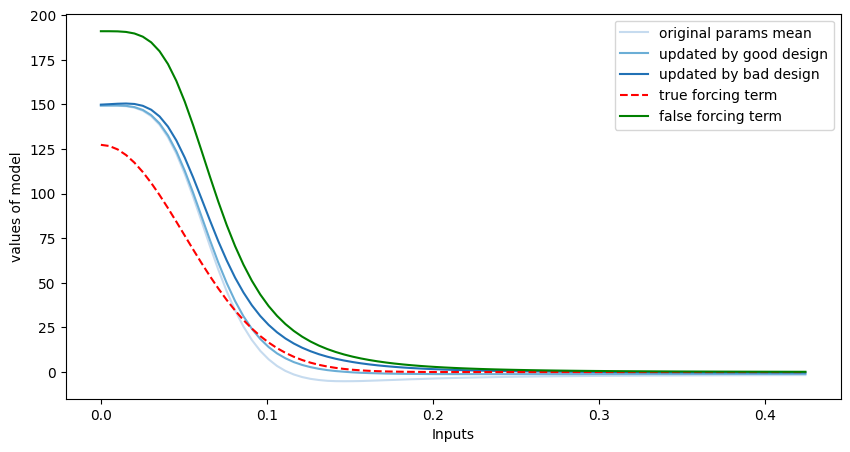

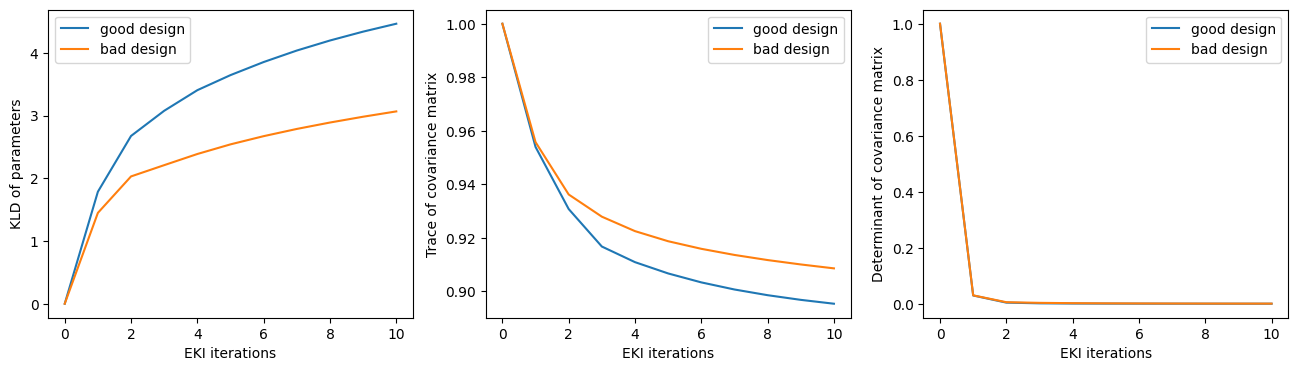

In [8]:
stage = 2
ensemble_step = 10
ensemble_size = 300

checkpoint_file_path = './checkpoints/nn_case_data_6_EnFK_stage2_test21/checkpoint_i_10_j_0.pkl'

# 检查文件是否存在
if os.path.exists(checkpoint_file_path):
    # 打开文件并加载数据
    with open(checkpoint_file_path, 'rb') as f:
        checkpoint_data = pickle.load(f)
    print("Checkpoint data loaded successfully.")
else:
    print("Checkpoint file not found.")

result_matrix_design_7 = checkpoint_data['params_trajectory'] # bad



checkpoint_file_path = './checkpoints/nn_case_data_6_EnFK_stage2_test21/checkpoint_i_10_j_1.pkl' 

# 检查文件是否存在
if os.path.exists(checkpoint_file_path):
    # 打开文件并加载数据
    with open(checkpoint_file_path, 'rb') as f:
        checkpoint_data = pickle.load(f)
    print("Checkpoint data loaded successfully.")
else:
    print("Checkpoint file not found.")

result_matrix_design_5 = checkpoint_data['params_trajectory'] # good



params0 = reconstruct_array_to_dict(np.mean(result_matrix_design_5[0], axis=0),params)
params5 = reconstruct_array_to_dict(np.mean(result_matrix_design_5[-1], axis=0),params)
params7 = reconstruct_array_to_dict(np.mean(result_matrix_design_7[-1], axis=0),params)
show_nn_trajectory([params0,params5, params7], model, 'Blues', center_x=0, center_y=0, size=85)
plt.legend()

leg = plt.gca().get_legend()

new_labels = ['original params mean', 'updated by good design', 'updated by bad design', 'true forcing term', 'false forcing term']

for text, new_label in zip(leg.get_texts(), new_labels):
    text.set_text(new_label)

plt.draw()


u_t = sealed_convection_diffusion_true(d_start, center, stage)[1][100:151,100:151]
u_design_5 = sealed_convection_diffusion_nn(params5, d_start, center, stage, model)[1][100:151,100:151]
u_design_7 = sealed_convection_diffusion_nn(params7, d_start, center, stage, model)[1][100:151,100:151]
print(np.sum((u_t - u_design_5)**2),np.sum((u_t - u_design_7)**2))


mean_ori = np.mean(result_matrix_design_5[0],axis=0)
mean_ori_centered = result_matrix_design_5[0] - mean_ori
var_ori = np.cov(mean_ori_centered, rowvar=False)
kld_trajectory5 = np.zeros(ensemble_step+1)
kld_trajectory5[0] = kl_divergence(mean_ori, var_ori, mean_ori, var_ori)
kld_compare_to_before5 = np.zeros(ensemble_step)
mean_current_back = mean_ori
var_current_back = var_ori
covar_trace_5 = np.zeros(ensemble_step+1)
covar_trace_5[0] = np.trace(var_ori)
covar_det_5 = np.zeros(ensemble_step+1)
covar_det_5[0] = np.linalg.det(var_ori)

for i in range(1,ensemble_step+1):
    mean_current = np.mean(result_matrix_design_5[i],axis=0)
    mean_current_centered = result_matrix_design_5[i] - mean_current
    var_current = np.cov(mean_current_centered, rowvar=False)
    kld_trajectory5[i]=kl_divergence(mean_current, var_current, mean_ori, var_ori)
    kld_compare_to_before5[i-1]=kl_divergence(mean_current, var_current, mean_current_back, var_current_back)
    covar_trace_5[i] = np.trace(var_current)
    covar_det_5[i] = np.linalg.det(var_current)
    mean_current_back = mean_current
    var_current_back = var_current 


mean_ori = np.mean(result_matrix_design_7[0],axis=0)
mean_ori_centered = result_matrix_design_7[0] - mean_ori
var_ori = np.cov(mean_ori_centered, rowvar=False)
kld_trajectory7 = np.zeros(ensemble_step+1)
kld_trajectory7[0] = kl_divergence(mean_ori, var_ori, mean_ori, var_ori)
kld_compare_to_before7 = np.zeros(ensemble_step)
mean_current_back = mean_ori
var_current_back = var_ori
covar_trace_7 = np.zeros(ensemble_step+1)
covar_trace_7[0] = np.trace(var_ori)
covar_det_7 = np.zeros(ensemble_step+1)
covar_det_7[0] = np.linalg.det(var_ori)

for i in range(1,ensemble_step+1):
    mean_current = np.mean(result_matrix_design_7[i],axis=0)
    mean_current_centered = result_matrix_design_7[i] - mean_current
    var_current = np.cov(mean_current_centered, rowvar=False)
    kld_trajectory7[i]=kl_divergence(mean_current, var_current, mean_ori, var_ori)
    kld_compare_to_before7[i-1]=kl_divergence(mean_current, var_current, mean_current_back, var_current_back)
    covar_trace_7[i] = np.trace(var_current)
    covar_det_7[i] = np.linalg.det(var_current)
    mean_current_back = mean_current
    var_current_back = var_current 


fig, axes = plt.subplots(1,3,figsize=(16,4))

axes[0].plot(kld_trajectory5, label = 'good design')
axes[0].plot(kld_trajectory7, label = 'bad design')
axes[0].set_xlabel('EKI iterations')
axes[0].set_ylabel('KLD of parameters')
axes[0].legend()


axes[1].plot(covar_trace_5/covar_trace_5[0], label = 'good design')
axes[1].plot(covar_trace_7/covar_trace_7[0], label = 'bad design')
axes[1].set_xlabel('EKI iterations')
axes[1].set_ylabel('Trace of covariance matrix')
axes[1].legend()


axes[2].plot(covar_det_5/covar_det_5[0], label = 'good design')
axes[2].plot(covar_det_7/covar_det_7[0], label = 'bad design')
axes[2].set_xlabel('EKI iterations')
axes[2].set_ylabel('Determinant of covariance matrix')
axes[2].legend()

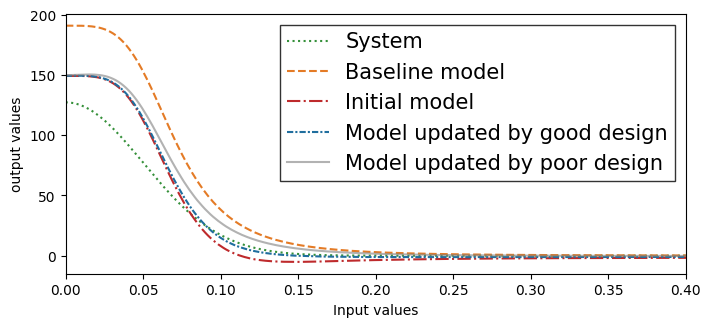

In [9]:
x = jnp.linspace(0, 0.3, size).reshape(-1, 1)
y = jnp.linspace(0, 0.3, size).reshape(-1, 1)  # Reshape y to match dimensions
xy_combined = jnp.concatenate((x, y), axis=1)  # Properly form (x, y) pairs
array_nn = model.apply(params0, xy_combined)
array_nn_5 = model.apply(params5, xy_combined)
array_nn_7 = model.apply(params7, xy_combined)

exponent_internal = ((x - 0.0) ** 2 + (y - 0.0) ** 2)
factor = 2.0 / (2.0 * jnp.pi * 0.05 ** 2)
array_exponent = factor * jnp.exp(-exponent_internal / (2.0 * 0.05 ** 2))
array_reciprocal = factor * 1.5 / (exponent_internal ** 2 / (2.0 * 0.05 ** 2) ** 2 + 1.0)
plt.figure(figsize=(8, 0.45*7.5))
# Directly use jnp arrays in plotting


plt.plot(jnp.sqrt(2) * x.squeeze(), 
         array_exponent.squeeze(), color = np.array([53,144,58])/255, label='System',linestyle=':')
plt.plot(jnp.sqrt(2) * x.squeeze(), 
         array_reciprocal.squeeze(), color = np.array([228,123,38])/255,label='Baseline model',linestyle='--')
plt.plot(jnp.sqrt(2) * x.squeeze(), 
         (array_nn.squeeze() + array_reciprocal.squeeze()), 
         label='Initial model',color = np.array([190,42,44])/255, linestyle='-.')

plt.plot(jnp.sqrt(2) * x.squeeze(), 
         (array_nn_5.squeeze() + array_reciprocal.squeeze()), 
         label='Model updated by good design',color = np.array([32,110,158])/255, linestyle=(0, (3, 1, 1, 1)))

plt.plot(jnp.sqrt(2) * x.squeeze(), 
         (array_nn_7.squeeze() + array_reciprocal.squeeze()), 
         label='Model updated by poor design',color = 'grey', linestyle='-',alpha=0.6)


plt.xlabel('input')
plt.ylabel('output values')# of source/network')
plt.xlabel('Input values')# of source/network')

plt.xlim([0,0.4])
#plt.legend()
#intersection_x = 0.07
#plt.axvline(x=intersection_x, color='black', linestyle='--')
#plt.axvspan(0, intersection_x, color='lightgrey', alpha=0.5)

font_size = 15
plt.rcParams.update({'font.size': font_size})

legend = plt.legend(borderpad=0.05,loc='upper right', bbox_to_anchor=(0.99, 0.975),fontsize=font_size)

legend.get_frame().set_edgecolor('black')  # 设置边框颜色为黑色
legend.get_frame().set_linewidth(1)  # 设置边框线宽为1
legend.get_frame().set_boxstyle("Square")

#plt.savefig('combined network shape.png', dpi=600, bbox_inches='tight')
plt.show()
#
#
#
#show_nn_trajectory([params0,params5, params7], model2, 'Blues', center_x=0, center_y=0, size=85)
#plt.legend()
#
#leg = plt.gca().get_legend()
#
#new_labels = ['original params mean', 'updated by good design', 'updated by bad design', 'true forcing term', 'false forcing term']
#
#for text, new_label in zip(leg.get_texts(), new_labels):
#    text.set_text(new_label)
#
#plt.draw()

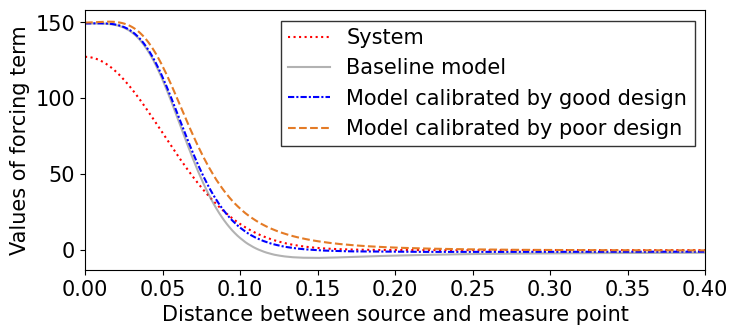

In [11]:
x = jnp.linspace(0, 0.3, size).reshape(-1, 1)
y = jnp.linspace(0, 0.3, size).reshape(-1, 1)  # Reshape y to match dimensions
xy_combined = jnp.concatenate((x, y), axis=1)  # Properly form (x, y) pairs
array_nn = model.apply(params0, xy_combined)
array_nn_5 = model.apply(params5, xy_combined)
array_nn_7 = model.apply(params7, xy_combined)

exponent_internal = ((x - 0.0) ** 2 + (y - 0.0) ** 2)
factor = 2.0 / (2.0 * jnp.pi * 0.05 ** 2)
array_exponent = factor * jnp.exp(-exponent_internal / (2.0 * 0.05 ** 2))
array_reciprocal = factor * 1.5 / (exponent_internal ** 2 / (2.0 * 0.05 ** 2) ** 2 + 1.0)
plt.figure(figsize=(8, 0.45*7.5))
# Directly use jnp arrays in plotting


plt.plot(jnp.sqrt(2) * x.squeeze(), 
         array_exponent.squeeze(), color = 'r', label='System',linestyle=':')#,alpha=0.6)
plt.plot(jnp.sqrt(2) * x.squeeze(), 
         (array_nn.squeeze() + array_reciprocal.squeeze()), 
         color = 'grey',label='Baseline model',linestyle='-',alpha=0.6)

plt.plot(jnp.sqrt(2) * x.squeeze(), 
         (array_nn_5.squeeze() + array_reciprocal.squeeze()), 
         label='Model calibrated by good design',color = 'b', linestyle=(0, (3, 1, 1, 1)))

plt.plot(jnp.sqrt(2) * x.squeeze(), 
         (array_nn_7.squeeze() + array_reciprocal.squeeze()), 
         label='Model calibrated by poor design',color = np.array([228,123,38])/255, linestyle='--')


plt.xlabel('Distance between source and measure point')
plt.ylabel('Values of forcing term')# of source/network')

plt.xlim([0,0.4])
#plt.yscale('log')
#plt.yscale('symlog', linthresh=1)

#plt.legend()
#intersection_x = 0.07
#plt.axvline(x=intersection_x, color='black', linestyle='--')
#plt.axvspan(0, intersection_x, color='lightgrey', alpha=0.5)

font_size = 15
plt.rcParams.update({'font.size': font_size})

legend = plt.legend(borderpad=0.05,loc='upper right', bbox_to_anchor=(0.99, 0.975),fontsize=font_size)

legend.get_frame().set_edgecolor('black')  # 设置边框颜色为黑色
legend.get_frame().set_linewidth(1)  # 设置边框线宽为1
legend.get_frame().set_boxstyle("Square")

#plt.savefig('combined network shape.png', dpi=600, bbox_inches='tight')
plt.show()
#
#
#
#show_nn_trajectory([params0,params5, params7], model2, 'Blues', center_x=0, center_y=0, size=85)
#plt.legend()
#
#leg = plt.gca().get_legend()
#
#new_labels = ['original params mean', 'updated by good design', 'updated by bad design', 'true forcing term', 'false forcing term']
#
#for text, new_label in zip(leg.get_texts(), new_labels):
#    text.set_text(new_label)
#
#plt.draw()

In [32]:
np.min(array_nn.squeeze() + array_reciprocal.squeeze())

Array(-5.159073, dtype=float32)

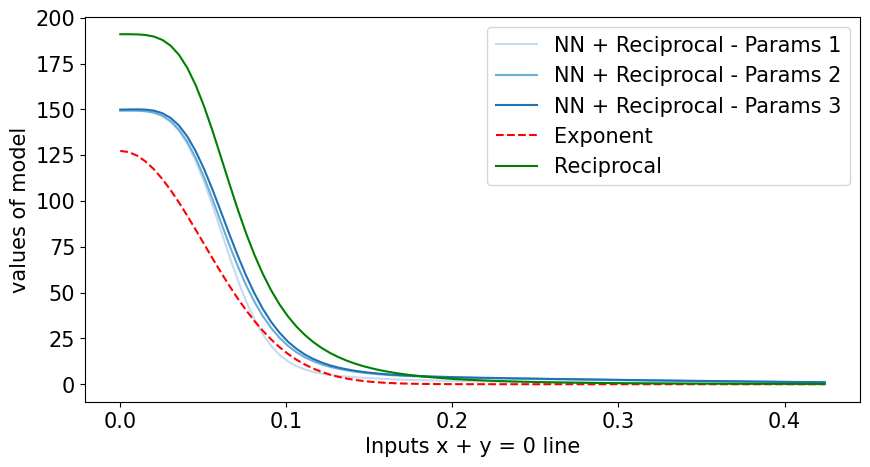

In [30]:
show_nn_trajectory_diag([params0,params5, params7], model, colormap='Blues', size=85)

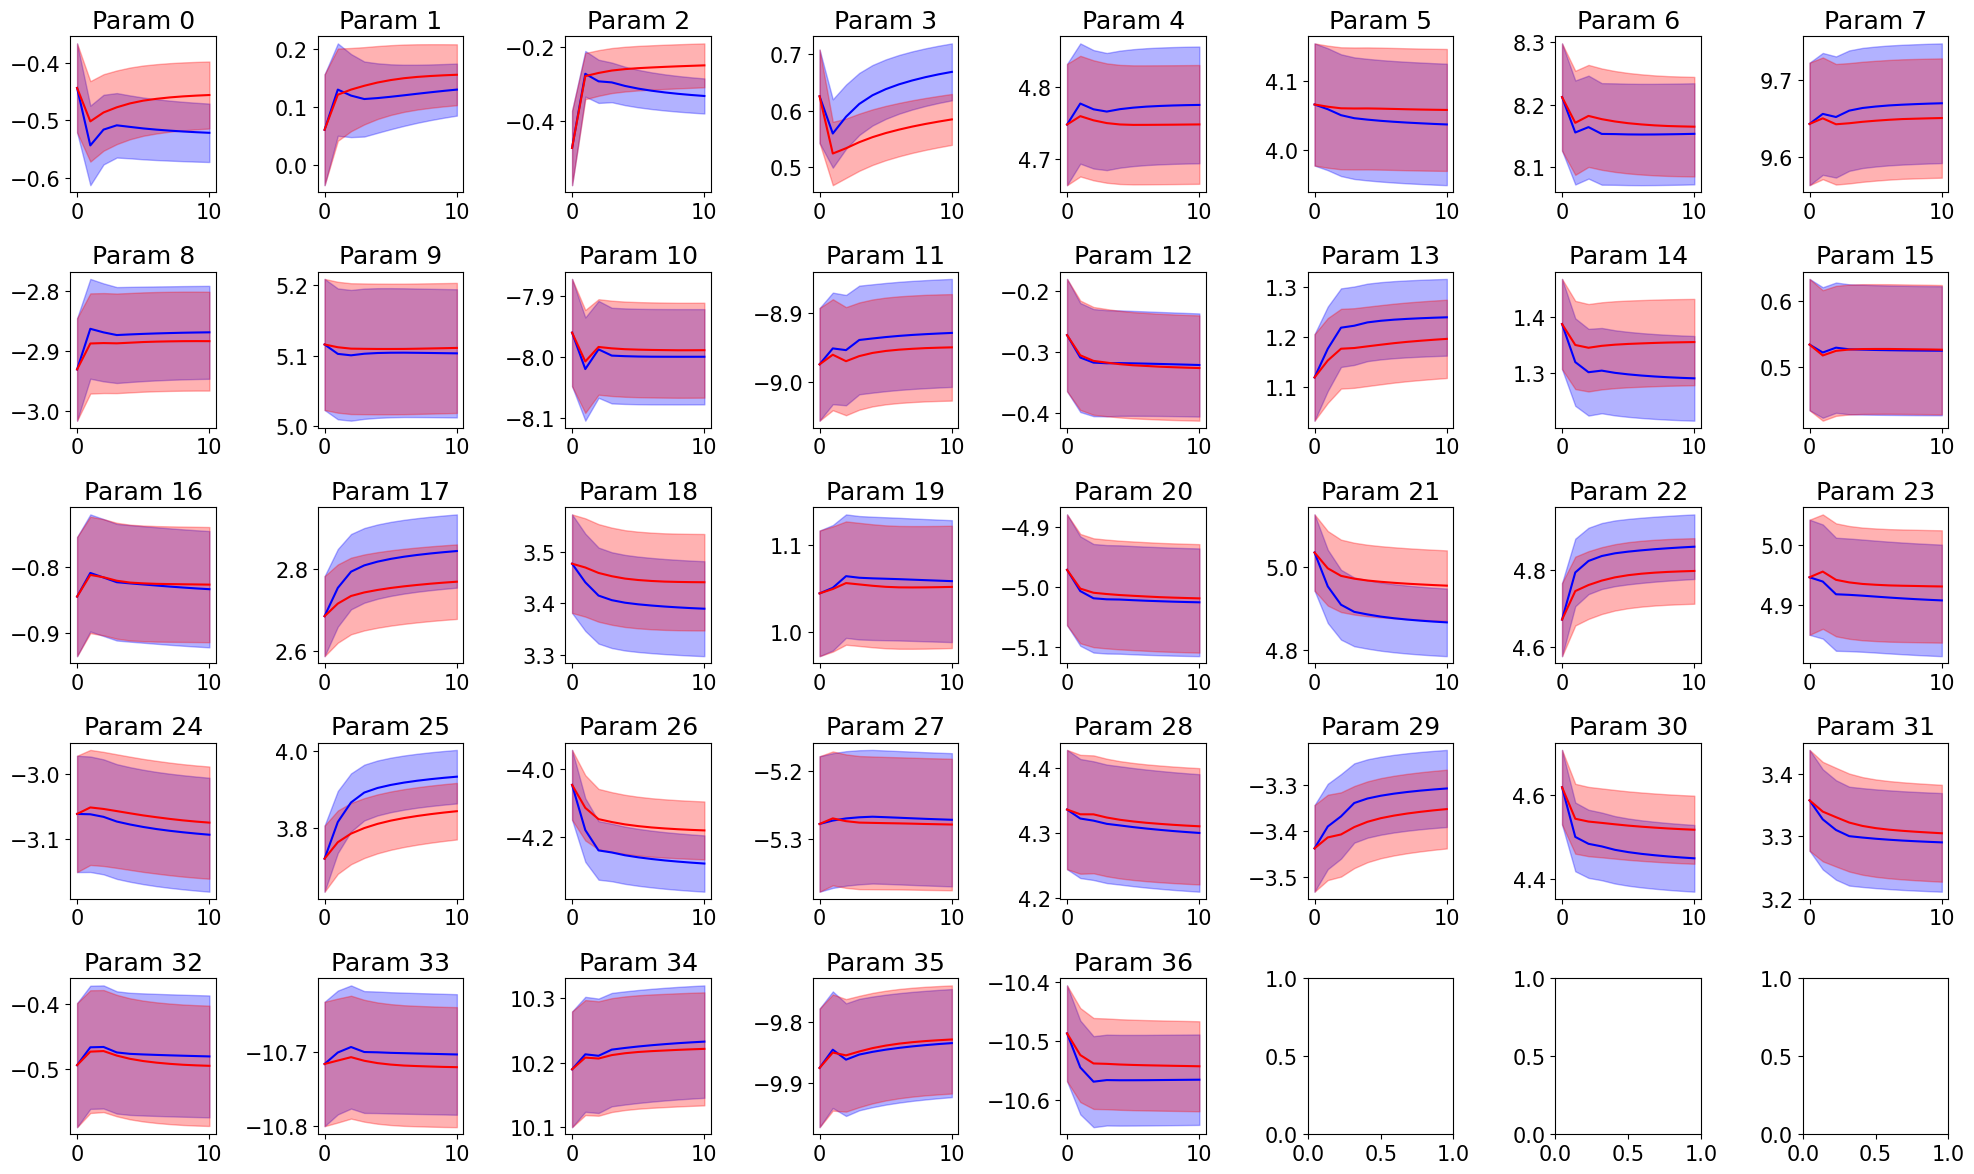

In [15]:
mean1 = np.mean(result_matrix_design_5,axis=1)
var1 = np.var(result_matrix_design_5,axis=1)
mean2 = np.mean(result_matrix_design_7,axis=1)
var2 = np.var(result_matrix_design_7,axis=1)
params_to_plot = 37  # 总共0~36个参数
rows, cols = 5, 8  # 5行8列的子图
fig, axs = plt.subplots(rows, cols, figsize=(20, 12))  # 设置画布大小

for i in range(params_to_plot):
    row = i // cols  # 计算当前子图的行号
    col = i % cols   # 计算当前子图的列号
    ax = axs[row, col]
    
    ax.plot(mean1[:, i], color='b')
    ax.fill_between(range(ensemble_step + 1), mean1[:, i] + var1[:, i], mean1[:, i] - var1[:, i], color='b', alpha=0.3)
    ax.plot(mean2[:, i], color='r')
    ax.fill_between(range(ensemble_step + 1), mean2[:, i] + var2[:, i], mean2[:, i] - var2[:, i], color='r', alpha=0.3)
    
    ax.set_title(f'Param {i}')  # 标题设置为参数编号

# 调整子图间距
plt.tight_layout()
plt.show()

Checkpoint data loaded successfully.
264.2229


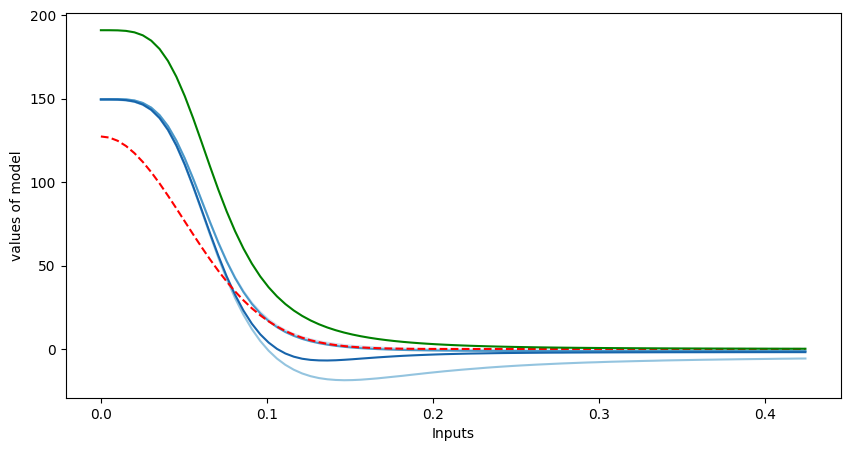

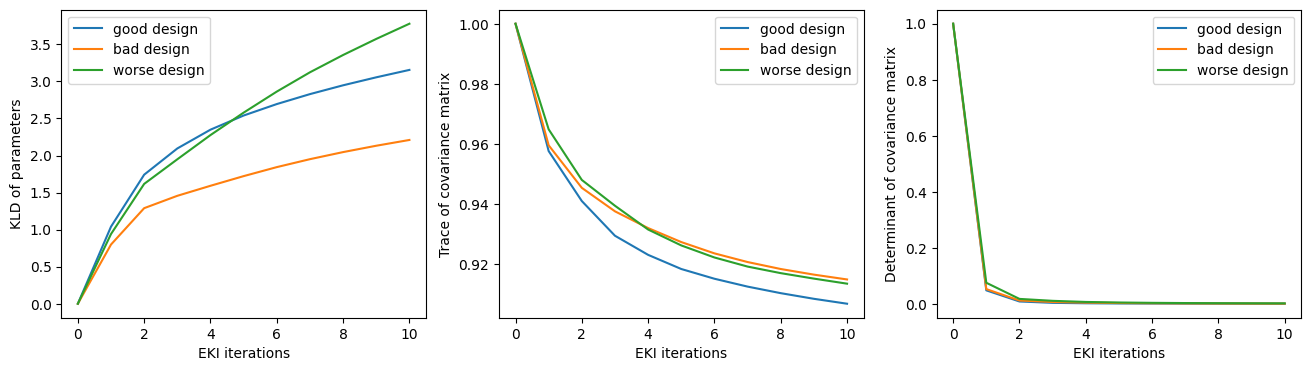

In [148]:

checkpoint_file_path = './checkpoints/nn_case_data_6_EnFK_stage3_test5/checkpoint_i_10_j_2.pkl' 

# 检查文件是否存在
if os.path.exists(checkpoint_file_path):
    # 打开文件并加载数据
    with open(checkpoint_file_path, 'rb') as f:
        checkpoint_data = pickle.load(f)
    print("Checkpoint data loaded successfully.")
else:
    print("Checkpoint file not found.")

result_matrix_design_9 = checkpoint_data['params_trajectory'] # worse


params9 = reconstruct_array_to_dict(np.mean(result_matrix_design_9[-1], axis=0),params)
show_nn_trajectory([params0,params5, params7, params9], model2, 'Blues', center_x=0, center_y=0, size=85)

u_design_9 = sealed_convection_diffusion_nn(params9, d_start4, estimated_center, stage, model2)[1][100:151,100:151]
print(np.sum((u_t - u_design_9)**2))


mean_ori = np.mean(result_matrix_design_9[0],axis=0)
mean_ori_centered = result_matrix_design_9[0] - mean_ori
var_ori = np.cov(mean_ori_centered, rowvar=False)
kld_trajectory9 = np.zeros(ensemble_step+1)
kld_trajectory9[0] = kl_divergence(mean_ori, var_ori, mean_ori, var_ori)
kld_compare_to_before9 = np.zeros(ensemble_step)
mean_current_back = mean_ori
var_current_back = var_ori
covar_trace_9 = np.zeros(ensemble_step+1)
covar_trace_9[0] = np.trace(var_ori)
covar_det_9 = np.zeros(ensemble_step+1)
covar_det_9[0] = np.linalg.det(var_ori)

for i in range(1,ensemble_step+1):
    mean_current = np.mean(result_matrix_design_9[i],axis=0)
    mean_current_centered = result_matrix_design_9[i] - mean_current
    var_current = np.cov(mean_current_centered, rowvar=False)
    kld_trajectory9[i]=kl_divergence(mean_current, var_current, mean_ori, var_ori)
    kld_compare_to_before9[i-1]=kl_divergence(mean_current, var_current, mean_current_back, var_current_back)
    covar_trace_9[i] = np.trace(var_current)
    covar_det_9[i] = np.linalg.det(var_current)
    mean_current_back = mean_current
    var_current_back = var_current 


fig, axes = plt.subplots(1,3,figsize=(16,4))

axes[0].plot(kld_trajectory5, label = 'good design')
axes[0].plot(kld_trajectory7, label = 'bad design')
axes[0].plot(kld_trajectory9, label = 'worse design')
axes[0].set_xlabel('EKI iterations')
axes[0].set_ylabel('KLD of parameters')
axes[0].legend()


axes[1].plot(covar_trace_5/covar_trace_5[0], label = 'good design')
axes[1].plot(covar_trace_7/covar_trace_7[0], label = 'bad design')
axes[1].plot(covar_trace_9/covar_trace_9[0], label = 'worse design')
axes[1].set_xlabel('EKI iterations')
axes[1].set_ylabel('Trace of covariance matrix')
axes[1].legend()


axes[2].plot(covar_det_5/covar_det_5[0], label = 'good design')
axes[2].plot(covar_det_7/covar_det_7[0], label = 'bad design')
axes[2].plot(covar_det_9/covar_det_9[0], label = 'worse design')
axes[2].set_xlabel('EKI iterations')
axes[2].set_ylabel('Determinant of covariance matrix')
axes[2].legend()

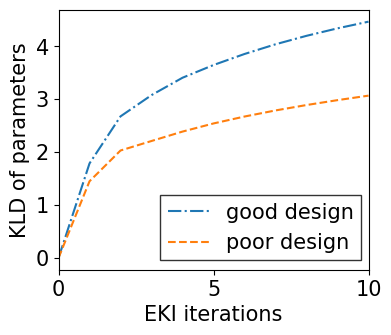

In [12]:
plt.figure(figsize=(4, 0.45*7.5))
plt.plot(kld_trajectory5, linestyle = '-.', label = 'good design')
plt.plot(kld_trajectory7, linestyle = '--', label = 'poor design')
plt.xlim([0,10])
plt.xticks([0,5,10])
plt.xlabel('EKI iterations')
plt.ylabel('KLD of parameters')
plt.legend()
legend = plt.legend(borderpad=0.05,loc='lower right', bbox_to_anchor=(0.99, 0.02),fontsize=font_size)

legend.get_frame().set_edgecolor('black')  # 设置边框颜色为黑色
legend.get_frame().set_linewidth(1)  # 设置边框线宽为1
legend.get_frame().set_boxstyle("Square")
plt.savefig('KLD of parameter of NN case.png', dpi=600, bbox_inches='tight')
plt.show()

In [149]:
stage=3 # 基于前一阶段的结果，指定下一阶段的设计，计算后验

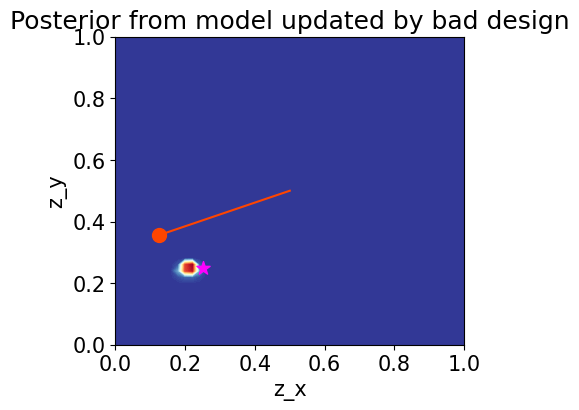

In [153]:
plt.figure(figsize=(4.5,4))
d_start = design_list[stage+1]#+jnp.array([-0.05,0.05])
prior = posterior_list[stage-1]
_, posterior = forward_posterior_infoGain(params7, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], model)
plt.contourf(grid_x_plot0, grid_y_plot0, posterior.T, levels=100,cmap='RdYlBu_r' )
plt.scatter(d_start[0], d_start[1], marker='o', s=100, c='orangered')
plt.scatter(center[0], center[1], marker='*', s=100, c='magenta')
plt.plot([d_start[0],d_start_backup[0]],
                [d_start[1],d_start_backup[1]], c='orangered')
plt.title('Posterior from model updated by bad design')  # 设置子图的标题
plt.xlabel('z_x')  # 设置x轴标签
plt.ylabel('z_y')  # 设置y轴标签
plt.show()       

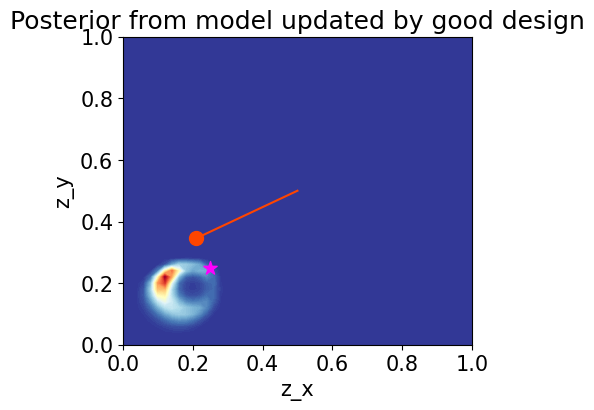

In [115]:
plt.figure(figsize=(4.5,4))
d_start = design_list[stage+1]+jnp.array([-0.05,0.05])
prior = posterior_list[stage-1]
_, posterior = forward_posterior_infoGain(params5, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], model)
plt.contourf(grid_x_plot0, grid_y_plot0, posterior.T, levels=100,cmap='RdYlBu_r' )
plt.scatter(d_start[0], d_start[1], marker='o', s=100, c='orangered')
plt.scatter(center[0], center[1], marker='*', s=100, c='magenta')
plt.plot([d_start[0],d_start_backup[0]],
                [d_start[1],d_start_backup[1]], c='orangered')
plt.title('Posterior from model updated by good design')  # 设置子图的标题
plt.xlabel('z_x')  # 设置x轴标签
plt.ylabel('z_y')  # 设置y轴标签
plt.show()       

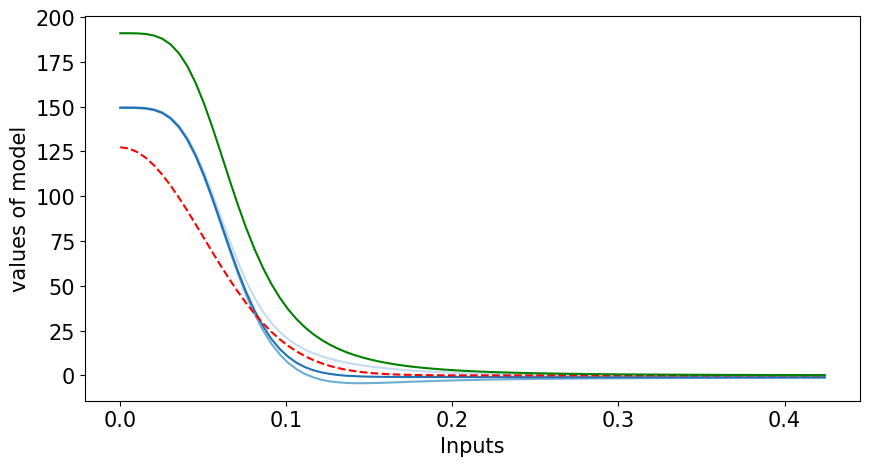

In [147]:
show_nn_trajectory(params_list[0:3], model, 'Blues', center_x=0, center_y=0, size=85)

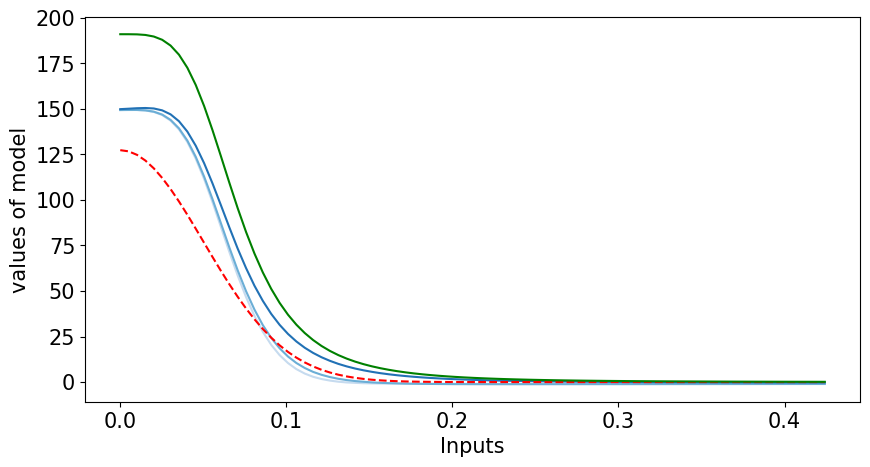

In [148]:
show_nn_trajectory([params_list[2],params5, params7], model, 'Blues', center_x=0, center_y=0, size=85)

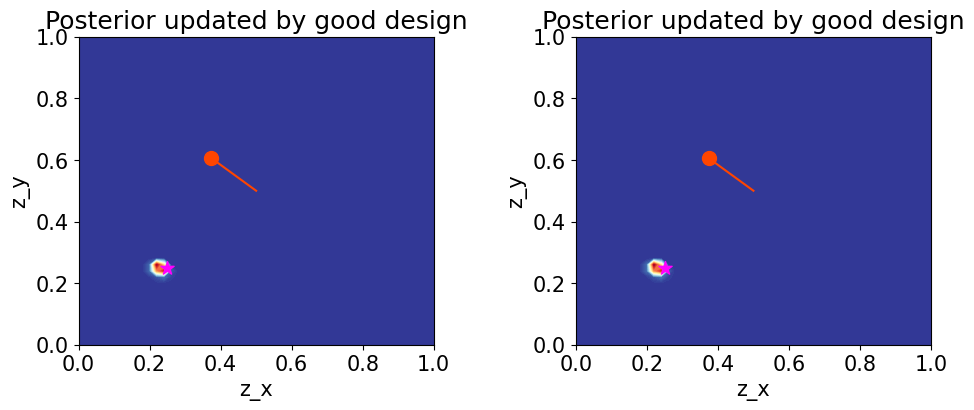

In [171]:
stage=3
_,axes = plt.subplots(1,2,figsize=(11,4))
plt.subplots_adjust(wspace=0.4)
d_start = design_list[stage+1]+jnp.array([0.25,0.25])
prior = posterior_list[stage-1]
_, posterior = forward_posterior_infoGain(params5, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], model)
axes[0].contourf(grid_x_plot0, grid_y_plot0, posterior.T, levels=100,cmap='RdYlBu_r' )
axes[0].scatter(d_start[0], d_start[1], marker='o', s=100, c='orangered')
axes[0].scatter(center[0], center[1], marker='*', s=100, c='magenta')
axes[0].plot([d_start[0],d_start_backup[0]], [d_start[1],d_start_backup[1]], c='orangered')
axes[0].set_title('Posterior updated by good design')  # 设置子图的标题
axes[0].set_xlabel('z_x')  # 设置x轴标签
axes[0].set_ylabel('z_y')  # 设置y轴标签
_, posterior = forward_posterior_infoGain(params7, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], model)
axes[1].contourf(grid_x_plot0, grid_y_plot0, posterior.T, levels=100,cmap='RdYlBu_r' )
axes[1].scatter(d_start[0], d_start[1], marker='o', s=100, c='orangered')
axes[1].scatter(center[0], center[1], marker='*', s=100, c='magenta')
axes[1].plot([d_start[0],d_start_backup[0]], [d_start[1],d_start_backup[1]], c='orangered')
axes[1].set_title('Posterior updated by good design')  # 设置子图的标题
axes[1].set_xlabel('z_x')  # 设置x轴标签
axes[1].set_ylabel('z_y')  # 设置y轴标签
plt.show()       

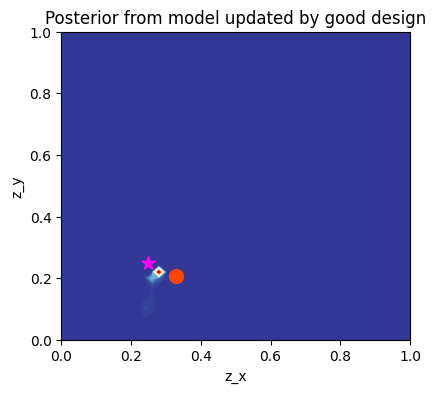

In [149]:
plt.figure(figsize=(4.5,4))
d_start = design_list[stage+1]#]+jnp.array([-0.1,0.1])
prior = posterior_list[stage-1]
_, posterior = forward_posterior_infoGain(params9, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], model)
plt.contourf(grid_x_plot0, grid_y_plot0, posterior.T, levels=100,cmap='RdYlBu_r' )
plt.scatter(d_start[0], d_start[1], marker='o', s=100, c='orangered')
plt.scatter(center[0], center[1], marker='*', s=100, c='magenta')
plt.plot([d_start[0],d_start_backup[0]],
                [d_start[1],d_start_backup[1]], c='orangered')
plt.title('Posterior from model updated by good design')  # 设置子图的标题
plt.xlabel('z_x')  # 设置x轴标签
plt.ylabel('z_y')  # 设置y轴标签
plt.show()       

total loss  13.758534 82.472786 369.63132
local loss  0.10516035 0.2618816 8.464962


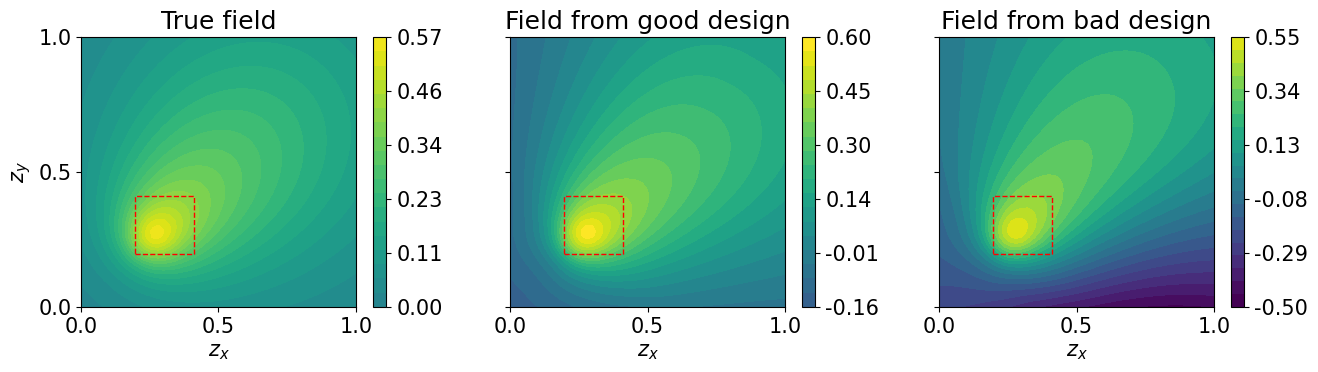

In [18]:
import matplotlib.patches as patches
# 需要指定当前的stage
stage = 2

u_t = sealed_convection_diffusion_true(d_start, center, stage)[1][100:151,100:151]
u_design_5 = sealed_convection_diffusion_nn(params5, d_start, center, stage, model)[1][100:151,100:151]
u_design_7 = sealed_convection_diffusion_nn(params7, d_start, center, stage, model)[1][100:151,100:151]
u_design_8 = sealed_convection_diffusion_nn(params_list[stage-1], d_start, center, stage, model)[1][100:151,100:151]
print('total loss ',np.sum((u_t - u_design_5)**2),np.sum((u_t - u_design_7)**2),np.sum((u_t - u_design_8)**2))
print('local loss ',np.sum(((u_t - u_design_5)**2)[10:21,10:21]),np.sum(((u_t - u_design_7)**2)[11:21,11:21]),np.sum(((u_t - u_design_8)**2)[11:21,11:21]))

# 找到所有数据的全局最小值和最大值
vmin = min(np.min(u_t), np.min(u_design_5), np.min(u_design_7))
vmax = max(np.max(u_t), np.max(u_design_5), np.max(u_design_7))

# 创建子图
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15.5, 3.5))
plt.subplots_adjust(wspace=0.25)


# Plot contourf images with shared vmin and vmax
c1 = axes[0].contourf(np.linspace(0, 1, u_t.shape[0]), np.linspace(0, 1, u_t.shape[1]), u_t.T, vmin=vmin, vmax=vmax, levels=20)
c2 = axes[1].contourf(np.linspace(0, 1, u_design_5.shape[0]), np.linspace(0, 1, u_design_5.shape[1]), u_design_5.T, vmin=vmin, vmax=vmax, levels=20)
c3 = axes[2].contourf(np.linspace(0, 1, u_design_7.shape[0]), np.linspace(0, 1, u_design_7.shape[1]), u_design_7.T, vmin=vmin, vmax=vmax, levels=20)

# Create rectangles with normalized coordinates
rect = patches.Rectangle((10/51, 10/51), 11/51, 11/51, linewidth=1, linestyle='--', edgecolor='red', facecolor='none')
axes[0].set_title('True field')
axes[0].add_patch(rect)

rect = patches.Rectangle((10/51, 10/51), 11/51, 11/51, linewidth=1, linestyle='--', edgecolor='red', facecolor='none')
axes[1].set_title('Field from good design')
axes[1].add_patch(rect)

rect = patches.Rectangle((10/51, 10/51), 11/51, 11/51, linewidth=1, linestyle='--', edgecolor='red', facecolor='none')
axes[2].set_title('Field from bad design')
axes[2].add_patch(rect)

# Set xlim and ylim for all axes
for ax in axes:
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([0.0, 0.5,1.0])
    ax.set_xlabel('$z_x$')
    if ax == axes[0]:
        ax.set_yticks([0.0, 0.5,1.0])
        ax.set_ylabel('$z_y$')
    else:
        ax.set_yticks([0.0, 0.5,1.0])
        ax.set_yticklabels([])


for ax, c in zip(axes, [c1, c2, c3]):
    colorbar = fig.colorbar(c, ax=ax)
    
    # 读取当前颜色条的 vmin 和 vmax
    vmin, vmax = colorbar.vmin, colorbar.vmax
    
    # 生成5个均匀分布的刻度
    ticks = np.linspace(vmin, vmax, 6)
    
    # 设置颜色条的刻度和格式化标签，保留两位小数
    colorbar.set_ticks(ticks)
    tick_labels = [f'{tick:.2f}' for tick in ticks]
    colorbar.set_ticklabels(tick_labels)
    
#plt.savefig('predict field with updated nn.png', dpi=600, bbox_inches='tight')
plt.show()

In [19]:
print('total loss ',np.sum((u_t - u_design_5)**2),np.sum((u_t - u_design_7)**2),np.sum((u_t - u_design_8)**2))
print('total relative loss ',np.sum(((u_t - u_design_5)/u_t)**2),np.sum(((u_t - u_design_7)/u_t)**2),np.sum(((u_t - u_design_8)/u_t)**2))

total loss  13.758534 82.472786 369.63132
total relative loss  2708.4824 14525.6 50443.68


In [29]:
print('total loss ',np.sum((u_t - u_design_5)**2)/51/51,np.sum((u_t - u_design_7)**2)/51/51,np.sum((u_t - u_design_8)**2)/51/51)

total loss  0.005289709508441953 0.03170810686263246 0.1421112330406274


In [28]:
np.sum(np.abs(u_t - u_design_5))/np.sum(np.abs(u_t)),np.sum(np.abs(u_t - u_design_7))/np.sum(np.abs(u_t)),np.sum(np.abs(u_t - u_design_8))/np.sum(np.abs(u_t))

(0.29763433, 0.664508, 1.5530363)

In [174]:
colorbar1 = fig.colorbar(c1, ax=axes[0])
colorbar1.vmax

0.6

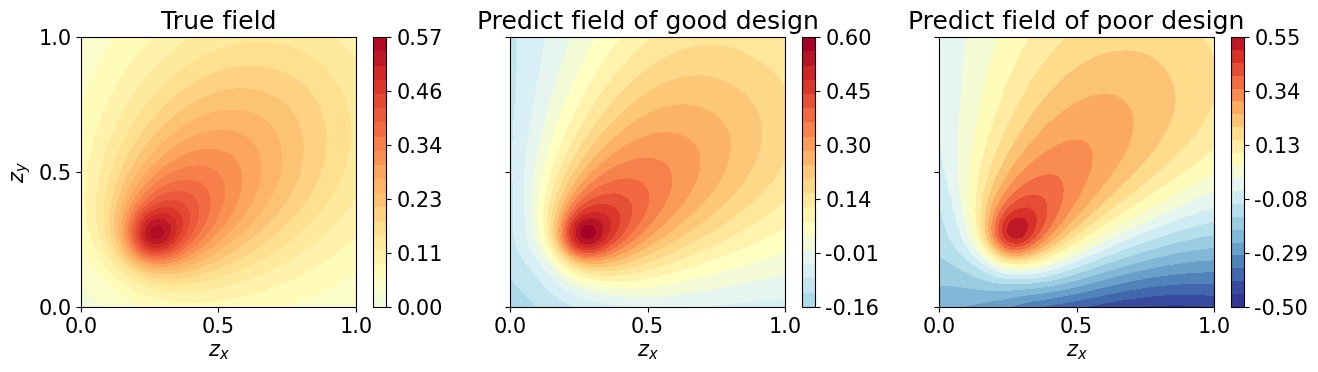

In [14]:
# 创建子图
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15.5, 3.5))
plt.subplots_adjust(wspace=0.25)

vmin = min(np.min(u_t), np.min(u_design_5), np.min(u_design_7))
vmax = max(np.max(u_t), np.max(u_design_5), np.max(u_design_7))

# Plot contourf images with shared vmin and vmax
c1 = axes[0].contourf(np.linspace(0, 1, u_t.shape[0]), np.linspace(0, 1, u_t.shape[1]), u_t.T, vmin=vmin, vmax=vmax, levels=20, cmap='RdYlBu_r')
c2 = axes[1].contourf(np.linspace(0, 1, u_design_5.shape[0]), np.linspace(0, 1, u_design_5.shape[1]), u_design_5.T, vmin=vmin, vmax=vmax, levels=20, cmap='RdYlBu_r')
c3 = axes[2].contourf(np.linspace(0, 1, u_design_7.shape[0]), np.linspace(0, 1, u_design_7.shape[1]), u_design_7.T, vmin=vmin, vmax=vmax, levels=20, cmap='RdYlBu_r')#'YlGnBu_r'
# Create rectangles with normalized coordinates
axes[0].set_title('True field')

axes[1].set_title('Predict field of good design')

axes[2].set_title('Predict field of poor design')

# Set xlim and ylim for all axes

# Set xlim and ylim for all axes
for ax in axes:
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([0.0, 0.5,1.0])
    ax.set_xlabel('$z_x$')
    if ax == axes[0]:
        ax.set_yticks([0.0, 0.5,1.0])
        ax.set_ylabel('$z_y$')
    else:
        ax.set_yticks([0.0, 0.5,1.0])
        ax.set_yticklabels([])


for ax, c in zip(axes, [c1, c2, c3]):
    colorbar = fig.colorbar(c, ax=ax)
    
    # 读取当前颜色条的 vmin 和 vmax
    vmin, vmax = colorbar.vmin, colorbar.vmax
    
    # 生成5个均匀分布的刻度
    ticks = np.linspace(vmin, vmax, 6)
    
    # 设置颜色条的刻度和格式化标签，保留两位小数
    colorbar.set_ticks(ticks)
    tick_labels = [f'{tick:.2f}' for tick in ticks]
    colorbar.set_ticklabels(tick_labels)

#plt.savefig('predict field with updated nn.png', dpi=600, bbox_inches='tight')
plt.show()

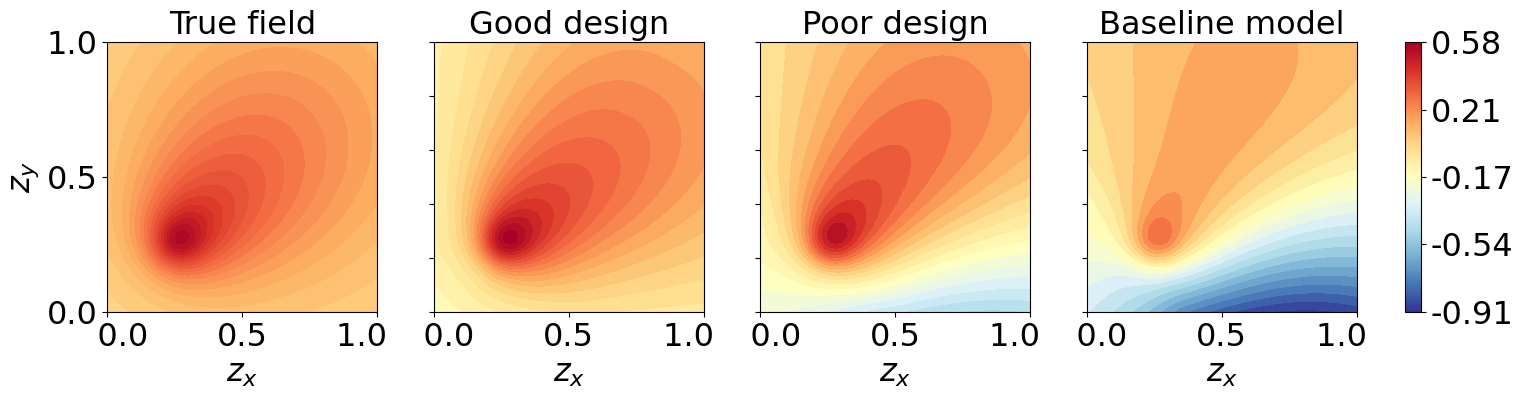

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# 创建子图
fig, axes = plt.subplots(1, 4, figsize=(4.03*4, 3.5))  # 调整figsize
fig.subplots_adjust(wspace=0.21)  # 调整子图间距

vmin = min(np.min(u_t), np.min(u_design_5), np.min(u_design_7), np.min(u_design_8))
vmax = max(np.max(u_t), np.max(u_design_5), np.max(u_design_7), np.max(u_design_8))

fontsize = 23
cmap = 'RdYlBu_r'  # 使用相同的颜色图

# 自定义刻度格式化函数
def custom_formatter(x, pos):
    if x == 0.0:
        return '   0.0'  # 向右移动
    elif x == 0.5:
        return '0.5'  # 向左移动
    elif x == 1.0:
        return '1.0   '
    else:
        return f'{x:.2f}'

# 绘制contourf图像，设置vmin和vmax
c1 = axes[0].contourf(np.linspace(0, 1, u_t.shape[0]), np.linspace(0, 1, u_t.shape[1]), u_t.T, vmin=vmin, vmax=vmax, levels=20, cmap=cmap)
c2 = axes[1].contourf(np.linspace(0, 1, u_design_5.shape[0]), np.linspace(0, 1, u_design_5.shape[1]), u_design_5.T, vmin=vmin, vmax=vmax, levels=20, cmap=cmap)
c3 = axes[2].contourf(np.linspace(0, 1, u_design_7.shape[0]), np.linspace(0, 1, u_design_7.shape[1]), u_design_7.T, vmin=vmin, vmax=vmax, levels=20, cmap=cmap)
c4 = axes[3].contourf(np.linspace(0, 1, u_design_8.shape[0]), np.linspace(0, 1, u_design_8.shape[1]), u_design_8.T, vmin=vmin, vmax=vmax, levels=20, cmap=cmap)

# 设置标题
axes[0].set_title('True field', fontsize=fontsize)
axes[1].set_title('Good design', fontsize=fontsize)
axes[2].set_title('Poor design', fontsize=fontsize)
axes[3].set_title('Baseline model', fontsize=fontsize)

# 统一设置xlim、ylim和刻度
for ax in axes:
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([0.0, 0.5, 1.0])
    ax.set_xlabel('$z_x$', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.xaxis.set_major_formatter(FuncFormatter(custom_formatter))  # 自定义刻度格式
    if ax == axes[0]:
        ax.set_yticks([0.0, 0.5, 1.0])
        ax.set_ylabel('$z_y$', fontsize=fontsize)
        ax.tick_params(axis='y', labelsize=fontsize)  # 设置 y 轴刻度标签的字体大小
    else:
        ax.set_yticklabels([])

# 设置颜色条
cbar_ax = fig.add_axes([0.93, 0.11, 0.01, 0.77])  # 设置颜色条位置
contour_set = plt.cm.ScalarMappable(cmap=cmap)
contour_set.set_array(u_design_8)
contour_set.set_clim(vmin, vmax)
ticks = np.linspace(vmin, vmax, 5)
cbar = fig.colorbar(contour_set, cax=cbar_ax, orientation='vertical')
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_ticks(ticks)
tick_labels = [f'{tick:.2f}' for tick in ticks]
cbar.set_ticklabels(tick_labels)

## 添加图例
#plt.plot([], [], marker='*', markersize=10, color=star_color, linestyle='None', label='true source location')
#legend = plt.legend(
#    loc='center',
#    bbox_to_anchor=(0.527, 1.1),
#    ncol=3,
#    frameon=True,
#    framealpha=1,
#    edgecolor='black',
#    fontsize=fontsize,
#    borderpad=0.05, handlelength=0.5,
#    bbox_transform=fig.transFigure
#)
#legend.get_frame().set_edgecolor('black')
#legend.get_frame().set_linewidth(1)
#legend.get_frame().set_boxstyle("Square")

# 保存图片
plt.savefig('predict_field_with_updated_nn.png', dpi=600, bbox_inches='tight')
plt.show()


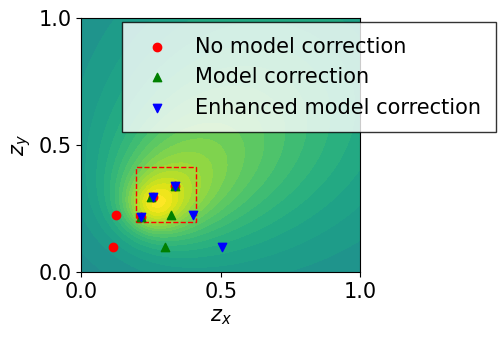

In [206]:
fig, ax = plt.subplots(figsize=(3.6, 3.3))
ax.contourf(np.linspace(0, 1, u_t.shape[0]), np.linspace(0, 1, u_t.shape[1]), u_t.T, vmin=vmin, vmax=vmax,levels=20)
rect = patches.Rectangle((10/51, 10/51), 11/51, 11/51, linewidth=1, linestyle='--', edgecolor='red', facecolor='none')
ax.add_patch(rect)

for i in range(1,n_stage+1):
    plt.scatter(design_list1[i][0],design_list[i][1],marker='o',color='r')
    plt.scatter(design_list2[i][0],design_list[i][1],marker='^',color='g')
    plt.scatter(design_list3[i][0],design_list[i][1],marker='v',color='b')

    
plt.scatter([], [], marker='o',color='r', label='No model correction')
plt.scatter([], [], marker='^',color='g', label='Model correction')
plt.scatter([], [], marker='v',color='b', label='Enhanced model correction')

plt.xlim(0, 1)
plt.xticks([0.0, 0.5,1.0])
plt.ylim(0, 1)
plt.yticks([0.0, 0.5,1.0])
plt.xlabel('$z_x$')
plt.ylabel('$z_y$')

legend = plt.legend(
    loc='best',
    bbox_to_anchor=(1.5, 1))

legend.get_frame().set_edgecolor('black')  # 设置边框颜色为黑色
legend.get_frame().set_linewidth(1)  # 设置边框线宽为1
legend.get_frame().set_boxstyle("Square")

In [131]:
design_list1, design_list2, design_list3

([Array([0.5, 0.5], dtype=float32),
  Array([0.33546886, 0.33540025], dtype=float32),
  Array([0.21560374, 0.21535774], dtype=float32),
  Array([0.2590128 , 0.29520652], dtype=float32),
  Array([0.1242381 , 0.35552606], dtype=float32),
  Array([0.11518266, 0.22299889], dtype=float32)],
 [Array([0.5, 0.5], dtype=float32),
  Array([0.33546886, 0.33540025], dtype=float32),
  Array([0.21560374, 0.21535774], dtype=float32),
  Array([0.2486042 , 0.26383477], dtype=float32),
  Array([0.320797  , 0.18974568], dtype=float32),
  Array([0.30103236, 0.23301315], dtype=float32)],
 [Array([0.5, 0.5], dtype=float32),
  Array([0.33546886, 0.33540025], dtype=float32),
  Array([0.21560374, 0.21535774], dtype=float32),
  Array([0.2590128 , 0.29520652], dtype=float32),
  Array([0.3991495 , 0.22517781], dtype=float32),
  Array([0.5055167 , 0.09697404], dtype=float32)])

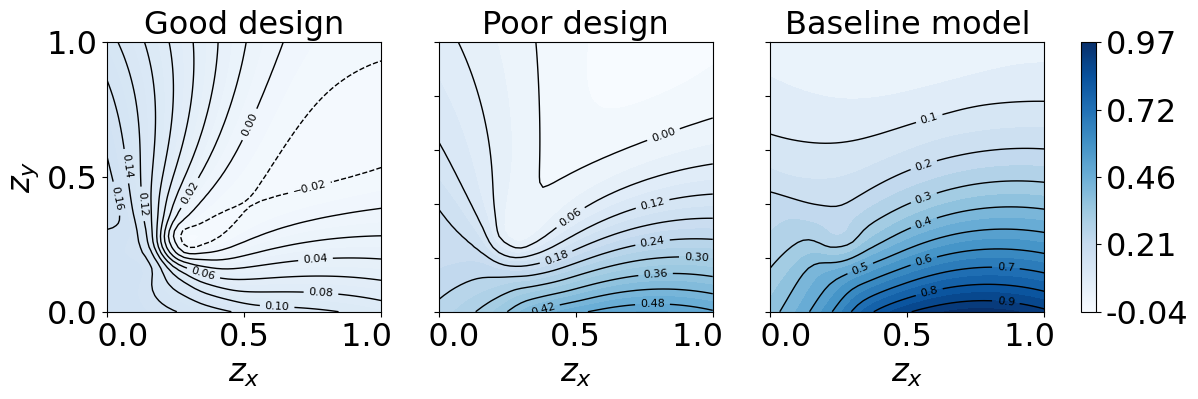

In [213]:
# 创建子图，调整figsize和wspace
fig, axes = plt.subplots(1, 3, figsize=(4.03*3, 3.5))  
fig.subplots_adjust(wspace=0.21)  

vmin = min(np.min(u_t - u_design_5), np.min(u_t - u_design_7), np.min(u_t - u_design_8))
vmax = max(np.max(u_t - u_design_5), np.max(u_t - u_design_7), np.max(u_t - u_design_8))

fontsize = 23
cmap = 'Blues'  # 颜色图与前面一致

# 自定义刻度格式化函数
def custom_formatter(x, pos):
    if x == 0.0:
        return '   0.0'  # 向右移动
    elif x == 0.5:
        return '0.5'  # 向左移动
    elif x == 1.0:
        return '1.0   '
    else:
        return f'{x:.2f}'

# 绘制 contourf 图像并设置 vmin 和 vmax
c1 = axes[0].contourf(np.linspace(0, 1, u_t.shape[0]), np.linspace(0, 1, u_t.shape[1]), (u_t - u_design_5).T, vmin=vmin, vmax=vmax, levels=20, cmap=cmap)
c2 = axes[1].contourf(np.linspace(0, 1, u_t.shape[0]), np.linspace(0, 1, u_t.shape[1]), (u_t - u_design_7).T, vmin=vmin, vmax=vmax, levels=20, cmap=cmap)
c3 = axes[2].contourf(np.linspace(0, 1, u_t.shape[0]), np.linspace(0, 1, u_t.shape[1]), (u_t - u_design_8).T, vmin=vmin, vmax=vmax, levels=20, cmap=cmap)

# 绘制等高线并标记所有等高线的值
contour1 = axes[0].contour(np.linspace(0, 1, u_t.shape[0]), np.linspace(0, 1, u_t.shape[1]), (u_t - u_design_5).T, levels=10, colors='black', linewidths=1)
contour2 = axes[1].contour(np.linspace(0, 1, u_t.shape[0]), np.linspace(0, 1, u_t.shape[1]), (u_t - u_design_7).T, levels=10, colors='black', linewidths=1)
contour3 = axes[2].contour(np.linspace(0, 1, u_t.shape[0]), np.linspace(0, 1, u_t.shape[1]), (u_t - u_design_8).T, levels=10, colors='black', linewidths=1)

# 给等高线标注值
axes[0].clabel(contour1, inline=True, fontsize=8)
axes[1].clabel(contour2, inline=True, fontsize=8)
axes[2].clabel(contour3, inline=True, fontsize=8)

# 设置标题、标签、刻度
axes[0].set_title('Good design', fontsize=fontsize)
axes[1].set_title('Poor design', fontsize=fontsize)
axes[2].set_title('Baseline model', fontsize=fontsize)

for ax in axes:
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([0.0, 0.5, 1.0])
    ax.set_xlabel('$z_x$', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.xaxis.set_major_formatter(FuncFormatter(custom_formatter))  # 自定义刻度格式
    if ax == axes[0]:
        ax.set_yticks([0.0, 0.5, 1.0])
        ax.set_ylabel('$z_y$', fontsize=fontsize)
        ax.tick_params(axis='y', labelsize=fontsize)
    else:
        ax.set_yticklabels([])

# 添加颜色条
cbar_ax = fig.add_axes([0.93, 0.11, 0.013, 0.77])  # 调整颜色条的位置
contour_set = plt.cm.ScalarMappable(cmap=cmap)
contour_set.set_array(u_design_8)
contour_set.set_clim(vmin, vmax)
ticks = np.linspace(vmin, vmax, 5)
cbar = fig.colorbar(contour_set, cax=cbar_ax, orientation='vertical')
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_ticks(ticks)
tick_labels = [f'{tick:.2f}' for tick in ticks]
cbar.set_ticklabels(tick_labels)


# 保存图片
plt.savefig('design_comparison.png', dpi=600, bbox_inches='tight')
plt.show()

In [103]:
print((u_t - u_design_5)[12, 12], (u_t - u_design_7)[12, 12])

0.015369177 0.07912126


In [113]:
u_t = sealed_convection_diffusion_true(d_start1, center, stage)[1][100:151,100:151]
u_design_5 = sealed_convection_diffusion_nn(params7, d_start1, center, stage, model)[1][100:151,100:151]
u_design_7 = sealed_convection_diffusion_nn(params_list[stage-1], d_start1, center, stage, model)[1][100:151,100:151]
np.sum((u_t - u_design_5)**2),np.sum((u_t - u_design_7)**2)

(37.039154, 145.35797)

In [18]:
for stage in range(n_stage):
    y, y_field = sealed_convection_diffusion_true(design_list[stage+1], center, stage)
    print(f'maximum of u is {jnp.max(y_field)}, mean of u is {jnp.mean(y_field)}. observation at design {design_list[stage+1]} is {y}')

maximum of u is 0.5851787328720093, mean of u is 0.004039997234940529. observation at design [0.37815458 0.37834254] is 0.27154695987701416
maximum of u is 0.6266726851463318, mean of u is 0.008039994165301323. observation at design [0.3037421  0.30317488] is 0.5742236971855164
maximum of u is 0.5540176033973694, mean of u is 0.012039991095662117. observation at design [0.24908948 0.24295828] is 0.5109094381332397
